This notebook replicated the experiments of training random feature models on mnist dataset.

In [21]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import queue
import os
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import copy 
import pandas as pd

class RF_NonLinear_Model(nn.Module):
    def __init__(self, p, d, o, coef):
        """RF_models
        
        Args:
            p (int): the hidden size
            d (int): the input feature dimension
            o (int): the output dimension
            coef (floatl): the ridge regression penalty coefficient
        """
        super(RF_NonLinear_Model, self).__init__()

        self.fc1 = nn.Linear(d, p, bias=False)
        stdv = 1
        self.fc1.weight.data.normal_(mean=0.0, std = stdv) # Gaussian initialization
        self.fc2 = nn.Linear(p, o, bias=False)
        self.p = p
        self.d = d
        self.o = o 
        self.coef = coef

    def forward(self, x):
        z = 1/np.sqrt(self.d) * F.relu(1/np.sqrt(self.d)* torch.mm(x, self.fc1.weight.data.t()))
        out = np.sqrt(self.d) * torch.mm(self.fc2.weight.data, z.t())
        return out.t()
    def optimize_second_layer(self, x, y):
        N = x.size(0)
        z = 1/np.sqrt(self.d) * F.relu(1/np.sqrt(self.d)* torch.mm(x, self.fc1.weight.data.t()))
        identity = torch.eye(self.p)
        identity = identity.to(x.device)
        beta = torch.mm(z.t(), z) + self.coef*self.p*N/(self.d**2) * identity
        beta = torch.mm(z, torch.inverse(beta))
        a = 1/np.sqrt(self.d) * torch.mm(y.t(), beta) 
        self.fc2.weight = torch.nn.Parameter(a)
        

In [22]:
class Ensemble_Two_Layer_NN(object):
    def __init__(self, n_classifiers, p, d=784, o=10, coef=1e-1):
        """Ensemble_Two_Layer_NN
        
        Args:
            p (int): the hidden size
            d (int, optional): the input feature dimension
            o (int, optional): the output dimension
            coef (float, optional): the ridge regression penalty coefficient
        """
        self.n_classifiers = n_classifiers
        self.p = p
        self.d = d 
        self.o = o 
        self.coef = coef
        self.learners = queue.LifoQueue(maxsize = self.n_classifiers)
        self.MODEL_TYPE = RF_NonLinear_Model
    def __len__(self):
        return len(self.learners.queue)
    
    def train_one_classifier(self, x, y):
        model = self.MODEL_TYPE(self.p, self.d, self.o, self.coef)
        if x.is_cuda:
            model.cuda()
        rho = 1/self.n_classifiers
        model.optimize_second_layer(x, y)
        self.learners.put([model, rho])
    def put_model_rho(self, model, rho):
        self.learners.put([model, rho])
    def get_init_model(self, cuda=True):
        model = self.MODEL_TYPE(self.p, self.d, self.o, self.coef)
        if cuda:
            model.cuda()
        return model
    def cuda(self):
        if len(self) == 0:
            return 
        else:
            for model, rho in self.learners.queue:
                model.cuda()
            return
    def train(self):
        if len(self)!=0:
            for model, rho in self.learners.queue:
                model.train()
    def eval(self):
        if len(self)!=0:
            for model, rho in self.learners.queue:
                model.eval()
    def forward(self, x):
        Bs = x.size(0)
        if len(self) == 0:
            zeros = torch.zeros(Bs, self.o)
            zeros = zeros.to(x.device)
            return zeros
        else:
            outputs = torch.zeros(Bs, self.o)
            outputs = outputs.to(x.device) 
            for model, rho in self.learners.queue:
                output = model(x)
                outputs += rho*output
            return outputs


In [23]:

def get_subsample_dataset(trainset, subset):
    trainsubset = copy.deepcopy(trainset)
    trainsubset.data = [trainsubset.data[index] for index in subset]
    trainsubset.targets = [trainsubset.targets[index] for index in subset]
    return trainsubset
def fix_width_number(width, n_classifiers):
    return max(1, width//n_classifiers)

# Training
def train(net, trainset, permute_index, train_size):
    net.train()
    train_loss = 0
    correct = 0
    subsample_indexes = np.random.choice(permute_index, size=train_size)
    trainsubset = get_subsample_dataset(trainset, subsample_indexes)
    trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=len(trainsubset), shuffle=True)
    trainloader = iter(trainloader)
    inputs, targets = next(trainloader)
    Bs = inputs.size(0)
    inputs = inputs.reshape(Bs, -1)
    inputs, targets = inputs.cuda(), targets.cuda()
    targets_onehot = torch.FloatTensor(targets.size(0), net.o).cuda()
    targets_onehot.zero_()
    targets_onehot.scatter_(1, targets.view(-1, 1).long(), 1)
    for _ in range(net.n_classifiers):
        net.train_one_classifier(inputs, targets_onehot)
    outputs = net.forward(inputs)
    loss = criterion(outputs, targets_onehot)
    train_loss = loss.item() * outputs.numel()
    _, predicted = outputs.max(1)
    correct = predicted.eq(targets).sum().item()
    total = targets.size(0)
    return train_loss/ total , 100. * correct / total

# Test
def test(net, testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            Bs = inputs.size(0)
            inputs = inputs.reshape(Bs, -1)
            targets_onehot = torch.FloatTensor(targets.size(0), net.o).cuda()
            targets_onehot.zero_()
            targets_onehot.scatter_(1, targets.view(-1, 1).long(), 1)
            outputs = net.forward(inputs)
            loss = criterion(outputs, targets_onehot)
            test_loss += loss.item() * outputs.numel()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return test_loss / total, 100. * correct / total

def compute_bias_variance(net, testloader, trial, OUTPUST_SUM, OUTPUTS_SUMNORMSQUARED):
    net.eval()
    bias2 = 0
    variance = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            Bs = inputs.size(0)
            inputs = inputs.reshape(Bs, -1)
            targets_onehot = torch.FloatTensor(targets.size(0), net.o).cuda()
            targets_onehot.zero_()
            targets_onehot.scatter_(1, targets.view(-1, 1).long(), 1)
            outputs = net.forward(inputs)
            OUTPUST_SUM[total:(total + targets.size(0)), :] += outputs
            OUTPUTS_SUMNORMSQUARED[total:total + targets.size(0)] += outputs.norm(dim=1) ** 2.0

            bias2 += (OUTPUST_SUM[total:total + targets.size(0), :] / (trial + 1) - targets_onehot).norm() ** 2.0
            variance += OUTPUTS_SUMNORMSQUARED[total:total + targets.size(0)].sum()/(trial + 1) - (OUTPUST_SUM[total:total + targets.size(0), :]/(trial + 1)).norm() ** 2.0
            total += targets.size(0)

    return bias2 / total, variance / total


In [24]:

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
# loss definition
criterion = nn.MSELoss(reduction='mean').cuda()

num_classes = 10
num_trials = 50
coef = 0.01
N_Ds = [0.5, 1]
feature_dim = 784
train_sizes = [int(np.around(x*feature_dim)) for x in N_Ds]
test_size = 10000
P_Ns = 10** np.linspace(-2, 1, 50)

outdir = 'mnist_coef_{}'.format(coef)
if not os.path.exists(outdir):
    os.makedirs(outdir)

def run_exps_ridge(train_sizes, N_Ds, P_Ns, trainset, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, save_csv, K = 1):
    df = pd.DataFrame()
    # When training single NN
    for train_size in train_sizes:
        hidden_sizes = P_Ns * train_size
        hidden_sizes = np.unique([int(np.around(x)) for x in hidden_sizes])
        for hidden_size in hidden_sizes:
            TRAIN_ACC_SUM = 0.0
            TEST_ACC_SUM = 0.0
            TRAIN_LOSS_SUM = 0.0
            TEST_LOSS_SUM = 0.0
            permute_index = np.random.permutation(len(trainset))
            OUTPUST_SUM = torch.Tensor(test_size, num_classes).zero_().cuda()
            OUTPUTS_SUMNORMSQUARED = torch.Tensor(test_size).zero_().cuda()
            for trial in range(num_trials):
                net = Ensemble_Two_Layer_NN(n_classifiers = K, p = fix_width_number(hidden_size, K), d=feature_dim, o=num_classes, coef=coef)
                net.cuda()
                train_loss, train_acc = train(net, trainset, permute_index, train_size)
                test_loss, test_acc = test(net, testloader)

                TRAIN_LOSS_SUM += train_loss
                TEST_LOSS_SUM += test_loss
                TRAIN_ACC_SUM += train_acc
                TEST_ACC_SUM += test_acc

                # compute bias and variance
                bias2, variance = compute_bias_variance(net, testloader, trial, OUTPUST_SUM, OUTPUTS_SUMNORMSQUARED)
                variance_unbias = variance * num_trials / (num_trials - 1.0)
                bias2_unbias = TEST_LOSS_SUM / (trial + 1) - variance_unbias
                print('Train size: [{}] hidden size: [{}] trial: {}, train_loss: {:.6f}, train acc: {}, test loss: {:.6f}, test acc: {}, bias2: {}, variance: {}'.format(
                    train_size, hidden_size,
                    trial, TRAIN_LOSS_SUM / (trial + 1), TRAIN_ACC_SUM / (trial + 1), TEST_LOSS_SUM / (trial + 1),
                    TEST_ACC_SUM / (trial + 1), bias2_unbias, variance_unbias))
                torch.cuda.empty_cache()
            print('#'*50)
            df = df.append({'train_size': train_size, 'hidden_size':hidden_size, 
                            'train_loss': TRAIN_LOSS_SUM / (trial + 1), 'train_acc': TRAIN_ACC_SUM / (trial + 1),
                            'test_loss': TEST_LOSS_SUM / (trial + 1), 'test_acc': TEST_ACC_SUM / (trial + 1), 
                           'variance': variance_unbias.item(),
                           'bias2': bias2_unbias.item()}, ignore_index=True)
            df.to_csv(os.path.join(outdir, save_csv))
    df.to_csv(os.path.join(outdir, save_csv))


In [5]:
run_exps_ridge(train_sizes, N_Ds, P_Ns, trainset, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'singleNN_output.csv', K = 1)

Train size: [392] hidden size: [4] trial: 0, train_loss: 0.820795, train acc: 30.612244897959183, test loss: 0.848634, test acc: 29.01, bias2: 0.8486340045928955, variance: 4.5737440501625315e-09
Train size: [392] hidden size: [4] trial: 1, train_loss: 0.831746, train acc: 30.867346938775512, test loss: 0.859087, test acc: 27.48, bias2: 0.8159823417663574, variance: 0.043104901909828186
Train size: [392] hidden size: [4] trial: 2, train_loss: 0.845058, train acc: 30.35714285714286, test loss: 0.870097, test acc: 25.873333333333335, bias2: 0.8144650459289551, variance: 0.055631645023822784
Train size: [392] hidden size: [4] trial: 3, train_loss: 0.853017, train acc: 29.14540816326531, test loss: 0.877153, test acc: 24.9875, bias2: 0.8152508735656738, variance: 0.06190219148993492
Train size: [392] hidden size: [4] trial: 4, train_loss: 0.855547, train acc: 27.653061224489797, test loss: 0.879788, test acc: 23.942, bias2: 0.8160421252250671, variance: 0.06374571472406387
Train size: [392

Train size: [392] hidden size: [4] trial: 41, train_loss: 0.875693, train acc: 24.125364431486876, test loss: 0.891602, test acc: 21.79047619047619, bias2: 0.8181967735290527, variance: 0.07340526580810547
Train size: [392] hidden size: [4] trial: 42, train_loss: 0.876209, train acc: 24.02112007593735, test loss: 0.891861, test acc: 21.720232558139536, bias2: 0.8188032507896423, variance: 0.07305776327848434
Train size: [392] hidden size: [4] trial: 43, train_loss: 0.876318, train acc: 24.049165120593692, test loss: 0.891925, test acc: 21.77068181818182, bias2: 0.8189879655838013, variance: 0.07293679565191269
Train size: [392] hidden size: [4] trial: 44, train_loss: 0.876001, train acc: 24.09297052154195, test loss: 0.891918, test acc: 21.76177777777778, bias2: 0.8189067244529724, variance: 0.0730113759636879
Train size: [392] hidden size: [4] trial: 45, train_loss: 0.875302, train acc: 24.14041703637977, test loss: 0.891517, test acc: 21.76326086956522, bias2: 0.8180948495864868, var

Train size: [392] hidden size: [5] trial: 32, train_loss: 0.858827, train acc: 26.74706246134818, test loss: 0.880750, test acc: 23.451818181818183, bias2: 0.8005399703979492, variance: 0.08021029829978943
Train size: [392] hidden size: [5] trial: 33, train_loss: 0.858219, train acc: 26.86824729891957, test loss: 0.880651, test acc: 23.45882352941177, bias2: 0.8000091910362244, variance: 0.08064163476228714
Train size: [392] hidden size: [5] trial: 34, train_loss: 0.857959, train acc: 26.931486880466476, test loss: 0.880253, test acc: 23.47514285714286, bias2: 0.7993131875991821, variance: 0.08094016462564468
Train size: [392] hidden size: [5] trial: 35, train_loss: 0.858164, train acc: 26.93452380952381, test loss: 0.880433, test acc: 23.596388888888892, bias2: 0.7991868257522583, variance: 0.08124659210443497
Train size: [392] hidden size: [5] trial: 36, train_loss: 0.857943, train acc: 26.902923331494765, test loss: 0.879741, test acc: 23.650000000000006, bias2: 0.7987599968910217, 

Train size: [392] hidden size: [6] trial: 23, train_loss: 0.836775, train acc: 29.910714285714292, test loss: 0.859899, test acc: 26.757499999999997, bias2: 0.7722277641296387, variance: 0.08767160028219223
Train size: [392] hidden size: [6] trial: 24, train_loss: 0.836588, train acc: 30.000000000000004, test loss: 0.859448, test acc: 26.873599999999996, bias2: 0.7714759707450867, variance: 0.0879717543721199
Train size: [392] hidden size: [6] trial: 25, train_loss: 0.835258, train acc: 30.12166405023548, test loss: 0.858164, test acc: 26.909230769230764, bias2: 0.7691972851753235, variance: 0.08896686136722565
Train size: [392] hidden size: [6] trial: 26, train_loss: 0.834843, train acc: 30.31934996220711, test loss: 0.858214, test acc: 26.98703703703703, bias2: 0.7691481709480286, variance: 0.08906558901071548
Train size: [392] hidden size: [6] trial: 27, train_loss: 0.836004, train acc: 30.17492711370263, test loss: 0.859400, test acc: 26.804999999999996, bias2: 0.7709364891052246, 

Train size: [392] hidden size: [7] trial: 14, train_loss: 0.821081, train acc: 34.20068027210884, test loss: 0.845023, test acc: 30.564000000000004, bias2: 0.7571613788604736, variance: 0.0878618061542511
Train size: [392] hidden size: [7] trial: 15, train_loss: 0.820282, train acc: 34.295280612244895, test loss: 0.844962, test acc: 30.65125, bias2: 0.7563728094100952, variance: 0.08858964592218399
Train size: [392] hidden size: [7] trial: 16, train_loss: 0.820000, train acc: 34.43877551020408, test loss: 0.844704, test acc: 30.68235294117647, bias2: 0.755743682384491, variance: 0.08895993232727051
Train size: [392] hidden size: [7] trial: 17, train_loss: 0.819571, train acc: 34.36791383219955, test loss: 0.843695, test acc: 30.717777777777783, bias2: 0.7543067932128906, variance: 0.08938783407211304
Train size: [392] hidden size: [7] trial: 18, train_loss: 0.819737, train acc: 34.34479054779806, test loss: 0.843730, test acc: 30.70263157894737, bias2: 0.7533224821090698, variance: 0.0

Train size: [392] hidden size: [8] trial: 5, train_loss: 0.808861, train acc: 35.79931972789115, test loss: 0.842823, test acc: 30.706666666666667, bias2: 0.7598834037780762, variance: 0.08294010907411575
Train size: [392] hidden size: [8] trial: 6, train_loss: 0.811646, train acc: 34.94897959183673, test loss: 0.842466, test acc: 30.62, bias2: 0.7564011216163635, variance: 0.08606527745723724
Train size: [392] hidden size: [8] trial: 7, train_loss: 0.807790, train acc: 36.03316326530612, test loss: 0.841280, test acc: 31.13625, bias2: 0.7520139813423157, variance: 0.08926574140787125
Train size: [392] hidden size: [8] trial: 8, train_loss: 0.807385, train acc: 36.224489795918366, test loss: 0.840641, test acc: 31.022222222222222, bias2: 0.7504379749298096, variance: 0.0902027115225792
Train size: [392] hidden size: [8] trial: 9, train_loss: 0.806526, train acc: 36.275510204081634, test loss: 0.839162, test acc: 31.145999999999997, bias2: 0.7483150959014893, variance: 0.090846732258796

Train size: [392] hidden size: [8] trial: 46, train_loss: 0.805513, train acc: 36.00738167607469, test loss: 0.837358, test acc: 31.540000000000006, bias2: 0.7346835136413574, variance: 0.1026744693517685
Train size: [392] hidden size: [8] trial: 47, train_loss: 0.806009, train acc: 35.93218537414966, test loss: 0.837971, test acc: 31.44145833333334, bias2: 0.7355037331581116, variance: 0.1024676039814949
Train size: [392] hidden size: [8] trial: 48, train_loss: 0.805575, train acc: 35.943356934610584, test loss: 0.837496, test acc: 31.441224489795925, bias2: 0.7351298928260803, variance: 0.10236595571041107
Train size: [392] hidden size: [8] trial: 49, train_loss: 0.805381, train acc: 35.954081632653065, test loss: 0.837808, test acc: 31.40020000000001, bias2: 0.7348683476448059, variance: 0.10293977707624435
##################################################
Train size: [392] hidden size: [9] trial: 0, train_loss: 0.797276, train acc: 39.03061224489796, test loss: 0.832656, test acc:

Train size: [392] hidden size: [9] trial: 37, train_loss: 0.791113, train acc: 38.21831364124596, test loss: 0.826183, test acc: 33.38078947368422, bias2: 0.7160971164703369, variance: 0.11008554697036743
Train size: [392] hidden size: [9] trial: 38, train_loss: 0.790806, train acc: 38.31763474620617, test loss: 0.826161, test acc: 33.37641025641027, bias2: 0.7160608768463135, variance: 0.11010043323040009
Train size: [392] hidden size: [9] trial: 39, train_loss: 0.790652, train acc: 38.34821428571428, test loss: 0.825837, test acc: 33.428250000000006, bias2: 0.7157557010650635, variance: 0.11008104681968689
Train size: [392] hidden size: [9] trial: 40, train_loss: 0.790890, train acc: 38.414634146341456, test loss: 0.825491, test acc: 33.56170731707318, bias2: 0.7155045866966248, variance: 0.10998640209436417
Train size: [392] hidden size: [9] trial: 41, train_loss: 0.792086, train acc: 38.22278911564625, test loss: 0.826906, test acc: 33.32309523809525, bias2: 0.7170791029930115, var

Train size: [392] hidden size: [11] trial: 28, train_loss: 0.767738, train acc: 42.294159042927525, test loss: 0.807121, test acc: 37.171379310344825, bias2: 0.6904585361480713, variance: 0.11666229367256165
Train size: [392] hidden size: [11] trial: 29, train_loss: 0.767172, train acc: 42.219387755102055, test loss: 0.806449, test acc: 37.12433333333333, bias2: 0.6896978616714478, variance: 0.11675126105546951
Train size: [392] hidden size: [11] trial: 30, train_loss: 0.766039, train acc: 42.28110599078342, test loss: 0.805710, test acc: 37.12322580645161, bias2: 0.6885316371917725, variance: 0.11717817187309265
Train size: [392] hidden size: [11] trial: 31, train_loss: 0.766087, train acc: 42.23533163265308, test loss: 0.805114, test acc: 37.231562499999995, bias2: 0.6877288818359375, variance: 0.11738462746143341
Train size: [392] hidden size: [11] trial: 32, train_loss: 0.765888, train acc: 42.24644403215834, test loss: 0.804607, test acc: 37.36212121212121, bias2: 0.68688595294952

Train size: [392] hidden size: [12] trial: 19, train_loss: 0.755721, train acc: 44.50255102040817, test loss: 0.795787, test acc: 39.166000000000004, bias2: 0.6724485158920288, variance: 0.12333817034959793
Train size: [392] hidden size: [12] trial: 20, train_loss: 0.756771, train acc: 44.448493683187564, test loss: 0.796621, test acc: 39.014761904761905, bias2: 0.673316478729248, variance: 0.12330462038516998
Train size: [392] hidden size: [12] trial: 21, train_loss: 0.755815, train acc: 44.60807050092765, test loss: 0.796358, test acc: 39.063181818181825, bias2: 0.6726325750350952, variance: 0.12372586876153946
Train size: [392] hidden size: [12] trial: 22, train_loss: 0.757003, train acc: 44.46539485359362, test loss: 0.797805, test acc: 38.797826086956526, bias2: 0.6742615699768066, variance: 0.12354353070259094
Train size: [392] hidden size: [12] trial: 23, train_loss: 0.757027, train acc: 44.45153061224491, test loss: 0.796778, test acc: 39.00708333333334, bias2: 0.67325460910797

Train size: [392] hidden size: [14] trial: 9, train_loss: 0.724169, train acc: 49.7704081632653, test loss: 0.778929, test acc: 41.992000000000004, bias2: 0.6506626009941101, variance: 0.12826615571975708
Train size: [392] hidden size: [14] trial: 10, train_loss: 0.727090, train acc: 49.67532467532467, test loss: 0.780940, test acc: 41.89090909090909, bias2: 0.652578592300415, variance: 0.12836110591888428
Train size: [392] hidden size: [14] trial: 11, train_loss: 0.726806, train acc: 49.851190476190474, test loss: 0.777166, test acc: 42.571666666666665, bias2: 0.6492387056350708, variance: 0.12792780995368958
Train size: [392] hidden size: [14] trial: 12, train_loss: 0.725287, train acc: 50.019623233908945, test loss: 0.777612, test acc: 42.675384615384615, bias2: 0.6477831602096558, variance: 0.12982884049415588
Train size: [392] hidden size: [14] trial: 13, train_loss: 0.724546, train acc: 50.01822157434402, test loss: 0.777011, test acc: 42.71642857142857, bias2: 0.6463088989257812

Train size: [392] hidden size: [16] trial: 0, train_loss: 0.697458, train acc: 54.59183673469388, test loss: 0.750439, test acc: 48.31, bias2: 0.7504390478134155, variance: -5.838822203507732e-10
Train size: [392] hidden size: [16] trial: 1, train_loss: 0.712010, train acc: 49.744897959183675, test loss: 0.769561, test acc: 44.185, bias2: 0.6965922117233276, variance: 0.07296870648860931
Train size: [392] hidden size: [16] trial: 2, train_loss: 0.714976, train acc: 49.14965986394558, test loss: 0.767456, test acc: 45.23666666666667, bias2: 0.6728771328926086, variance: 0.09457848966121674
Train size: [392] hidden size: [16] trial: 3, train_loss: 0.710000, train acc: 51.65816326530613, test loss: 0.768037, test acc: 45.237500000000004, bias2: 0.6582855582237244, variance: 0.10975097864866257
Train size: [392] hidden size: [16] trial: 4, train_loss: 0.711667, train acc: 51.22448979591837, test loss: 0.770379, test acc: 44.936, bias2: 0.6552959680557251, variance: 0.11508334428071976
Trai

Train size: [392] hidden size: [16] trial: 41, train_loss: 0.711838, train acc: 51.4516520894072, test loss: 0.766381, test acc: 45.134523809523806, bias2: 0.6252301335334778, variance: 0.14115087687969208
Train size: [392] hidden size: [16] trial: 42, train_loss: 0.711171, train acc: 51.483151400094926, test loss: 0.765733, test acc: 45.154186046511626, bias2: 0.6243956089019775, variance: 0.14133688807487488
Train size: [392] hidden size: [16] trial: 43, train_loss: 0.711378, train acc: 51.420454545454554, test loss: 0.765904, test acc: 45.04022727272727, bias2: 0.6245611906051636, variance: 0.14134231209754944
Train size: [392] hidden size: [16] trial: 44, train_loss: 0.711501, train acc: 51.37755102040817, test loss: 0.766075, test acc: 44.99288888888889, bias2: 0.6247753500938416, variance: 0.14129923284053802
Train size: [392] hidden size: [16] trial: 45, train_loss: 0.711440, train acc: 51.40860692102929, test loss: 0.766376, test acc: 44.99434782608696, bias2: 0.624709725379943

Train size: [392] hidden size: [18] trial: 32, train_loss: 0.690087, train acc: 55.7204700061843, test loss: 0.751426, test acc: 47.72727272727273, bias2: 0.6075042486190796, variance: 0.1439214050769806
Train size: [392] hidden size: [18] trial: 33, train_loss: 0.689187, train acc: 55.76230492196879, test loss: 0.750746, test acc: 47.78411764705883, bias2: 0.6059799790382385, variance: 0.14476560056209564
Train size: [392] hidden size: [18] trial: 34, train_loss: 0.689442, train acc: 55.699708454810505, test loss: 0.750473, test acc: 47.722, bias2: 0.605767548084259, variance: 0.14470504224300385
Train size: [392] hidden size: [18] trial: 35, train_loss: 0.689685, train acc: 55.71145124716554, test loss: 0.750901, test acc: 47.64527777777778, bias2: 0.6060696840286255, variance: 0.14483091235160828
Train size: [392] hidden size: [18] trial: 36, train_loss: 0.689325, train acc: 55.67429674572533, test loss: 0.750651, test acc: 47.637027027027024, bias2: 0.6053715944290161, variance: 0.

Train size: [392] hidden size: [21] trial: 22, train_loss: 0.661212, train acc: 58.29636202307009, test loss: 0.732946, test acc: 49.729565217391304, bias2: 0.5787676572799683, variance: 0.15417839586734772
Train size: [392] hidden size: [21] trial: 23, train_loss: 0.662498, train acc: 58.142006802721085, test loss: 0.733589, test acc: 49.59625, bias2: 0.5794481635093689, variance: 0.15414083003997803
Train size: [392] hidden size: [21] trial: 24, train_loss: 0.662997, train acc: 58.11224489795918, test loss: 0.733991, test acc: 49.545199999999994, bias2: 0.579846203327179, variance: 0.15414460003376007
Train size: [392] hidden size: [21] trial: 25, train_loss: 0.662015, train acc: 58.24175824175824, test loss: 0.731921, test acc: 49.75269230769231, bias2: 0.5780779123306274, variance: 0.15384280681610107
Train size: [392] hidden size: [21] trial: 26, train_loss: 0.662082, train acc: 58.13492063492063, test loss: 0.731950, test acc: 49.68074074074074, bias2: 0.5781601667404175, varianc

Train size: [392] hidden size: [25] trial: 13, train_loss: 0.625324, train acc: 64.34037900874635, test loss: 0.707308, test acc: 53.91428571428571, bias2: 0.5531623363494873, variance: 0.15414585173130035
Train size: [392] hidden size: [25] trial: 14, train_loss: 0.627936, train acc: 63.79251700680272, test loss: 0.709486, test acc: 53.74133333333334, bias2: 0.554867148399353, variance: 0.15461848676204681
Train size: [392] hidden size: [25] trial: 15, train_loss: 0.628553, train acc: 63.87117346938775, test loss: 0.709162, test acc: 53.884375, bias2: 0.5536658763885498, variance: 0.15549609065055847
Train size: [392] hidden size: [25] trial: 16, train_loss: 0.628947, train acc: 63.68547418967586, test loss: 0.709731, test acc: 53.85588235294117, bias2: 0.5542891621589661, variance: 0.15544168651103973
Train size: [392] hidden size: [25] trial: 17, train_loss: 0.628051, train acc: 64.05895691609976, test loss: 0.709369, test acc: 54.129999999999995, bias2: 0.5526095628738403, variance

Train size: [392] hidden size: [28] trial: 3, train_loss: 0.608959, train acc: 66.26275510204081, test loss: 0.703178, test acc: 55.205, bias2: 0.5696518421173096, variance: 0.1335265338420868
Train size: [392] hidden size: [28] trial: 4, train_loss: 0.600850, train acc: 66.78571428571429, test loss: 0.698495, test acc: 55.39, bias2: 0.556521475315094, variance: 0.14197342097759247
Train size: [392] hidden size: [28] trial: 5, train_loss: 0.603908, train acc: 66.15646258503402, test loss: 0.696945, test acc: 55.586666666666666, bias2: 0.551528811454773, variance: 0.1454159915447235
Train size: [392] hidden size: [28] trial: 6, train_loss: 0.604598, train acc: 66.21720116618076, test loss: 0.696443, test acc: 55.66714285714285, bias2: 0.5468602776527405, variance: 0.1495828628540039
Train size: [392] hidden size: [28] trial: 7, train_loss: 0.603863, train acc: 66.54974489795919, test loss: 0.696475, test acc: 55.903749999999995, bias2: 0.5433961749076843, variance: 0.1530783325433731
Tr

Train size: [392] hidden size: [28] trial: 44, train_loss: 0.605517, train acc: 67.0238095238095, test loss: 0.696476, test acc: 56.26466666666666, bias2: 0.5258581042289734, variance: 0.17061780393123627
Train size: [392] hidden size: [28] trial: 45, train_loss: 0.605265, train acc: 67.02528837622005, test loss: 0.696529, test acc: 56.25847826086956, bias2: 0.5256482362747192, variance: 0.17088060081005096
Train size: [392] hidden size: [28] trial: 46, train_loss: 0.604980, train acc: 67.05384281372122, test loss: 0.696249, test acc: 56.29893617021276, bias2: 0.5255163311958313, variance: 0.1707325577735901
Train size: [392] hidden size: [28] trial: 47, train_loss: 0.605314, train acc: 67.06526360544217, test loss: 0.696143, test acc: 56.360625, bias2: 0.525610625743866, variance: 0.1705324798822403
Train size: [392] hidden size: [28] trial: 48, train_loss: 0.606336, train acc: 66.91482715535193, test loss: 0.696752, test acc: 56.2465306122449, bias2: 0.5265047550201416, variance: 0.1

Train size: [392] hidden size: [32] trial: 34, train_loss: 0.580066, train acc: 70.45918367346938, test loss: 0.680807, test acc: 58.75400000000001, bias2: 0.5053380727767944, variance: 0.17546933889389038
Train size: [392] hidden size: [32] trial: 35, train_loss: 0.579227, train acc: 70.47902494331066, test loss: 0.680402, test acc: 58.75527777777779, bias2: 0.5045889019966125, variance: 0.17581357061862946
Train size: [392] hidden size: [32] trial: 36, train_loss: 0.579748, train acc: 70.4288472145615, test loss: 0.680686, test acc: 58.75432432432433, bias2: 0.504804253578186, variance: 0.17588157951831818
Train size: [392] hidden size: [32] trial: 37, train_loss: 0.579435, train acc: 70.44172932330827, test loss: 0.680800, test acc: 58.738157894736844, bias2: 0.5048632621765137, variance: 0.17593702673912048
Train size: [392] hidden size: [32] trial: 38, train_loss: 0.579291, train acc: 70.41470434327577, test loss: 0.680539, test acc: 58.779487179487184, bias2: 0.5047684907913208, 

Train size: [392] hidden size: [37] trial: 24, train_loss: 0.551366, train acc: 74.03061224489797, test loss: 0.671775, test acc: 60.07920000000001, bias2: 0.48681628704071045, variance: 0.18495917320251465
Train size: [392] hidden size: [37] trial: 25, train_loss: 0.550990, train acc: 74.09733124018838, test loss: 0.671974, test acc: 60.09038461538462, bias2: 0.4868738353252411, variance: 0.1850999891757965
Train size: [392] hidden size: [37] trial: 26, train_loss: 0.550748, train acc: 74.14021164021165, test loss: 0.670118, test acc: 60.33185185185185, bias2: 0.48572179675102234, variance: 0.18439587950706482
Train size: [392] hidden size: [37] trial: 27, train_loss: 0.550372, train acc: 74.08892128279885, test loss: 0.669157, test acc: 60.46750000000001, bias2: 0.48462602496147156, variance: 0.18453136086463928
Train size: [392] hidden size: [37] trial: 28, train_loss: 0.550469, train acc: 74.03237156931739, test loss: 0.668873, test acc: 60.48068965517241, bias2: 0.4847663938999176

Train size: [392] hidden size: [43] trial: 14, train_loss: 0.519349, train acc: 76.80272108843539, test loss: 0.654202, test acc: 63.36533333333334, bias2: 0.47077760100364685, variance: 0.18342408537864685
Train size: [392] hidden size: [43] trial: 15, train_loss: 0.517691, train acc: 77.04081632653063, test loss: 0.653224, test acc: 63.34875000000001, bias2: 0.4684444069862366, variance: 0.184779092669487
Train size: [392] hidden size: [43] trial: 16, train_loss: 0.516488, train acc: 77.14585834333735, test loss: 0.653279, test acc: 63.321764705882366, bias2: 0.4667200744152069, variance: 0.1865588128566742
Train size: [392] hidden size: [43] trial: 17, train_loss: 0.515903, train acc: 77.01247165532881, test loss: 0.652609, test acc: 63.293333333333344, bias2: 0.46511906385421753, variance: 0.18749020993709564
Train size: [392] hidden size: [43] trial: 18, train_loss: 0.515583, train acc: 77.24221267454351, test loss: 0.651057, test acc: 63.65052631578948, bias2: 0.46359723806381226

Train size: [392] hidden size: [50] trial: 4, train_loss: 0.493664, train acc: 80.05102040816327, test loss: 0.642438, test acc: 65.174, bias2: 0.48071929812431335, variance: 0.16171899437904358
Train size: [392] hidden size: [50] trial: 5, train_loss: 0.495059, train acc: 79.76190476190476, test loss: 0.640640, test acc: 65.21166666666669, bias2: 0.4715472459793091, variance: 0.16909277439117432
Train size: [392] hidden size: [50] trial: 6, train_loss: 0.494893, train acc: 80.06559766763849, test loss: 0.639333, test acc: 65.39142857142859, bias2: 0.46482840180397034, variance: 0.17450425028800964
Train size: [392] hidden size: [50] trial: 7, train_loss: 0.495163, train acc: 79.65561224489797, test loss: 0.641237, test acc: 64.98375000000001, bias2: 0.46367597579956055, variance: 0.17756056785583496
Train size: [392] hidden size: [50] trial: 8, train_loss: 0.493256, train acc: 80.13038548752836, test loss: 0.640698, test acc: 65.1588888888889, bias2: 0.45973891019821167, variance: 0.1

Train size: [392] hidden size: [50] trial: 45, train_loss: 0.486114, train acc: 80.48469387755101, test loss: 0.639654, test acc: 65.01239130434783, bias2: 0.4394378662109375, variance: 0.20021580159664154
Train size: [392] hidden size: [50] trial: 46, train_loss: 0.486386, train acc: 80.41141988710378, test loss: 0.639053, test acc: 65.06702127659575, bias2: 0.4393094778060913, variance: 0.19974304735660553
Train size: [392] hidden size: [50] trial: 47, train_loss: 0.486303, train acc: 80.36777210884352, test loss: 0.639231, test acc: 65.03770833333333, bias2: 0.4392446279525757, variance: 0.1999868005514145
Train size: [392] hidden size: [50] trial: 48, train_loss: 0.486290, train acc: 80.377967513536, test loss: 0.639024, test acc: 65.06183673469387, bias2: 0.4389578104019165, variance: 0.20006634294986725
Train size: [392] hidden size: [50] trial: 49, train_loss: 0.485965, train acc: 80.41836734693875, test loss: 0.639524, test acc: 65.0262, bias2: 0.4392583966255188, variance: 0.2

Train size: [392] hidden size: [57] trial: 36, train_loss: 0.461101, train acc: 83.45973524544952, test loss: 0.628200, test acc: 66.69270270270269, bias2: 0.4238358736038208, variance: 0.20436453819274902
Train size: [392] hidden size: [57] trial: 37, train_loss: 0.460949, train acc: 83.51235230934478, test loss: 0.627924, test acc: 66.76499999999999, bias2: 0.4235951602458954, variance: 0.20432916283607483
Train size: [392] hidden size: [57] trial: 38, train_loss: 0.460656, train acc: 83.5426478283621, test loss: 0.628845, test acc: 66.66076923076922, bias2: 0.42384326457977295, variance: 0.20500220358371735
Train size: [392] hidden size: [57] trial: 39, train_loss: 0.461004, train acc: 83.50127551020407, test loss: 0.629159, test acc: 66.66174999999998, bias2: 0.4239919185638428, variance: 0.20516741275787354
Train size: [392] hidden size: [57] trial: 40, train_loss: 0.460887, train acc: 83.47436535589844, test loss: 0.628890, test acc: 66.68463414634145, bias2: 0.42377257347106934,

Train size: [392] hidden size: [66] trial: 27, train_loss: 0.429812, train acc: 86.16071428571429, test loss: 0.621658, test acc: 68.24892857142858, bias2: 0.4061790704727173, variance: 0.2154785543680191
Train size: [392] hidden size: [66] trial: 28, train_loss: 0.429448, train acc: 86.18930330752991, test loss: 0.621760, test acc: 68.20793103448275, bias2: 0.4057556986808777, variance: 0.21600477397441864
Train size: [392] hidden size: [66] trial: 29, train_loss: 0.429559, train acc: 86.13945578231292, test loss: 0.622440, test acc: 68.09599999999999, bias2: 0.40596914291381836, variance: 0.21647034585475922
Train size: [392] hidden size: [66] trial: 30, train_loss: 0.429594, train acc: 86.10928242264647, test loss: 0.621892, test acc: 68.15451612903226, bias2: 0.4055497646331787, variance: 0.2163422554731369
Train size: [392] hidden size: [66] trial: 31, train_loss: 0.429047, train acc: 86.20854591836734, test loss: 0.621679, test acc: 68.1828125, bias2: 0.4049873650074005, variance

Train size: [392] hidden size: [76] trial: 18, train_loss: 0.400586, train acc: 88.80236305048336, test loss: 0.618302, test acc: 69.41473684210524, bias2: 0.39606356620788574, variance: 0.2222386747598648
Train size: [392] hidden size: [76] trial: 19, train_loss: 0.401314, train acc: 88.78826530612245, test loss: 0.618595, test acc: 69.33399999999997, bias2: 0.39616602659225464, variance: 0.22242869436740875
Train size: [392] hidden size: [76] trial: 20, train_loss: 0.402358, train acc: 88.76336248785229, test loss: 0.618766, test acc: 69.33666666666666, bias2: 0.39622271060943604, variance: 0.22254347801208496
Train size: [392] hidden size: [76] trial: 21, train_loss: 0.401117, train acc: 88.8334879406308, test loss: 0.617609, test acc: 69.41545454545452, bias2: 0.395060658454895, variance: 0.2225480079650879
Train size: [392] hidden size: [76] trial: 22, train_loss: 0.400603, train acc: 88.78660159716061, test loss: 0.616282, test acc: 69.4486956521739, bias2: 0.3936917185783386, va

Train size: [392] hidden size: [87] trial: 8, train_loss: 0.357418, train acc: 91.78004535147392, test loss: 0.608810, test acc: 70.77111111111111, bias2: 0.39117807149887085, variance: 0.2176314741373062
Train size: [392] hidden size: [87] trial: 9, train_loss: 0.355120, train acc: 91.68367346938776, test loss: 0.609198, test acc: 70.787, bias2: 0.38778358697891235, variance: 0.2214142233133316
Train size: [392] hidden size: [87] trial: 10, train_loss: 0.355654, train acc: 91.7439703153989, test loss: 0.609502, test acc: 70.62818181818183, bias2: 0.38560986518859863, variance: 0.22389166057109833
Train size: [392] hidden size: [87] trial: 11, train_loss: 0.357865, train acc: 91.49659863945578, test loss: 0.608979, test acc: 70.71750000000002, bias2: 0.383669912815094, variance: 0.2253086417913437
Train size: [392] hidden size: [87] trial: 12, train_loss: 0.359701, train acc: 91.3657770800628, test loss: 0.610091, test acc: 70.65, bias2: 0.38374876976013184, variance: 0.226342365145683

Train size: [392] hidden size: [87] trial: 49, train_loss: 0.364144, train acc: 91.30612244897958, test loss: 0.609717, test acc: 70.80300000000001, bias2: 0.36999261379241943, variance: 0.23972393572330475
##################################################
Train size: [392] hidden size: [100] trial: 0, train_loss: 0.332445, train acc: 92.60204081632654, test loss: 0.633603, test acc: 68.82, bias2: 0.633603036403656, variance: -3.5032932110823367e-09
Train size: [392] hidden size: [100] trial: 1, train_loss: 0.329625, train acc: 92.98469387755102, test loss: 0.620591, test acc: 70.36, bias2: 0.47940197587013245, variance: 0.1411888301372528
Train size: [392] hidden size: [100] trial: 2, train_loss: 0.337059, train acc: 93.28231292517007, test loss: 0.617565, test acc: 70.61333333333333, bias2: 0.43474775552749634, variance: 0.18281714618206024
Train size: [392] hidden size: [100] trial: 3, train_loss: 0.346728, train acc: 93.04846938775512, test loss: 0.614315, test acc: 71.31, bias2: 

Train size: [392] hidden size: [100] trial: 39, train_loss: 0.340478, train acc: 93.50127551020405, test loss: 0.615771, test acc: 71.3865, bias2: 0.35744035243988037, variance: 0.2583310604095459
Train size: [392] hidden size: [100] trial: 40, train_loss: 0.340262, train acc: 93.4980089596814, test loss: 0.615420, test acc: 71.40975609756099, bias2: 0.3573997914791107, variance: 0.2580201327800751
Train size: [392] hidden size: [100] trial: 41, train_loss: 0.340427, train acc: 93.49489795918365, test loss: 0.615147, test acc: 71.43690476190477, bias2: 0.3571915924549103, variance: 0.2579558193683624
Train size: [392] hidden size: [100] trial: 42, train_loss: 0.340691, train acc: 93.48599905078306, test loss: 0.615114, test acc: 71.43046511627908, bias2: 0.3571663796901703, variance: 0.2579478323459625
Train size: [392] hidden size: [100] trial: 43, train_loss: 0.340516, train acc: 93.51229128014839, test loss: 0.614308, test acc: 71.48727272727272, bias2: 0.3567092716693878, variance:

Train size: [392] hidden size: [116] trial: 29, train_loss: 0.302235, train acc: 95.34013605442175, test loss: 0.619698, test acc: 72.096, bias2: 0.3448379635810852, variance: 0.27486008405685425
Train size: [392] hidden size: [116] trial: 30, train_loss: 0.301938, train acc: 95.4081632653061, test loss: 0.620379, test acc: 72.06032258064516, bias2: 0.3444982171058655, variance: 0.2758803963661194
Train size: [392] hidden size: [116] trial: 31, train_loss: 0.302089, train acc: 95.36830357142856, test loss: 0.619965, test acc: 72.05875, bias2: 0.34402620792388916, variance: 0.2759387493133545
Train size: [392] hidden size: [116] trial: 32, train_loss: 0.302434, train acc: 95.32312925170066, test loss: 0.619420, test acc: 72.10454545454546, bias2: 0.343450129032135, variance: 0.2759699821472168
Train size: [392] hidden size: [116] trial: 33, train_loss: 0.302033, train acc: 95.36314525810323, test loss: 0.618990, test acc: 72.08588235294118, bias2: 0.3429142236709595, variance: 0.2760756

Train size: [392] hidden size: [133] trial: 20, train_loss: 0.274762, train acc: 96.93877551020407, test loss: 0.627933, test acc: 72.85142857142857, bias2: 0.33422380685806274, variance: 0.2937089800834656
Train size: [392] hidden size: [133] trial: 21, train_loss: 0.273981, train acc: 96.9503710575139, test loss: 0.627999, test acc: 72.78318181818182, bias2: 0.33320003747940063, variance: 0.294799268245697
Train size: [392] hidden size: [133] trial: 22, train_loss: 0.273600, train acc: 97.0053238686779, test loss: 0.628203, test acc: 72.80913043478262, bias2: 0.33274418115615845, variance: 0.2954585552215576
Train size: [392] hidden size: [133] trial: 23, train_loss: 0.273449, train acc: 97.01318027210884, test loss: 0.627821, test acc: 72.8275, bias2: 0.33228421211242676, variance: 0.2955363392829895
Train size: [392] hidden size: [133] trial: 24, train_loss: 0.274161, train acc: 96.95918367346938, test loss: 0.627953, test acc: 72.79400000000001, bias2: 0.3322352468967438, variance

Train size: [392] hidden size: [153] trial: 10, train_loss: 0.237521, train acc: 98.58534322820037, test loss: 0.644094, test acc: 73.17090909090909, bias2: 0.33676961064338684, variance: 0.30732420086860657
Train size: [392] hidden size: [153] trial: 11, train_loss: 0.237290, train acc: 98.57568027210884, test loss: 0.643336, test acc: 73.15583333333333, bias2: 0.33406487107276917, variance: 0.30927154421806335
Train size: [392] hidden size: [153] trial: 12, train_loss: 0.237095, train acc: 98.56750392464679, test loss: 0.644220, test acc: 72.92538461538462, bias2: 0.33312106132507324, variance: 0.31109851598739624
Train size: [392] hidden size: [153] trial: 13, train_loss: 0.237280, train acc: 98.59693877551021, test loss: 0.644539, test acc: 72.89785714285713, bias2: 0.33119019865989685, variance: 0.3133486807346344
Train size: [392] hidden size: [153] trial: 14, train_loss: 0.237959, train acc: 98.55442176870748, test loss: 0.645426, test acc: 72.89466666666665, bias2: 0.3286859691

Train size: [392] hidden size: [176] trial: 0, train_loss: 0.206132, train acc: 99.48979591836735, test loss: 0.686362, test acc: 71.22, bias2: 0.6863619685173035, variance: -7.785095901269301e-10
Train size: [392] hidden size: [176] trial: 1, train_loss: 0.203405, train acc: 99.61734693877551, test loss: 0.672672, test acc: 71.175, bias2: 0.48839280009269714, variance: 0.18427959084510803
Train size: [392] hidden size: [176] trial: 2, train_loss: 0.201387, train acc: 99.57482993197279, test loss: 0.663716, test acc: 71.86333333333333, bias2: 0.419458270072937, variance: 0.2442578822374344
Train size: [392] hidden size: [176] trial: 3, train_loss: 0.205263, train acc: 99.36224489795919, test loss: 0.659844, test acc: 72.11749999999999, bias2: 0.38957127928733826, variance: 0.27027300000190735
Train size: [392] hidden size: [176] trial: 4, train_loss: 0.207416, train acc: 99.28571428571429, test loss: 0.656058, test acc: 72.74, bias2: 0.367898553609848, variance: 0.2881592810153961
Trai

Train size: [392] hidden size: [176] trial: 41, train_loss: 0.204837, train acc: 99.37439261418848, test loss: 0.657237, test acc: 73.37785714285714, bias2: 0.299137145280838, variance: 0.35809966921806335
Train size: [392] hidden size: [176] trial: 42, train_loss: 0.204780, train acc: 99.38300901756047, test loss: 0.656878, test acc: 73.40906976744185, bias2: 0.2988588809967041, variance: 0.35801953077316284
Train size: [392] hidden size: [176] trial: 43, train_loss: 0.204897, train acc: 99.39123376623371, test loss: 0.657145, test acc: 73.39477272727272, bias2: 0.29843080043792725, variance: 0.35871422290802
Train size: [392] hidden size: [176] trial: 44, train_loss: 0.204946, train acc: 99.3820861678004, test loss: 0.656560, test acc: 73.44288888888889, bias2: 0.2980841100215912, variance: 0.3584756553173065
Train size: [392] hidden size: [176] trial: 45, train_loss: 0.204704, train acc: 99.38442768411707, test loss: 0.656554, test acc: 73.43760869565217, bias2: 0.29795777797698975,

Train size: [392] hidden size: [203] trial: 31, train_loss: 0.169392, train acc: 99.74489795918365, test loss: 0.682387, test acc: 73.0571875, bias2: 0.29134103655815125, variance: 0.39104607701301575
Train size: [392] hidden size: [203] trial: 32, train_loss: 0.169337, train acc: 99.7294372294372, test loss: 0.682716, test acc: 73.03636363636363, bias2: 0.2911260426044464, variance: 0.3915903866291046
Train size: [392] hidden size: [203] trial: 33, train_loss: 0.169304, train acc: 99.72989195678268, test loss: 0.682853, test acc: 73.06235294117647, bias2: 0.29033640027046204, variance: 0.39251700043678284
Train size: [392] hidden size: [203] trial: 34, train_loss: 0.169318, train acc: 99.73760932944603, test loss: 0.682515, test acc: 73.066, bias2: 0.28983813524246216, variance: 0.3926766514778137
Train size: [392] hidden size: [203] trial: 35, train_loss: 0.169003, train acc: 99.74489795918365, test loss: 0.682510, test acc: 73.06944444444444, bias2: 0.28933748602867126, variance: 0.

Train size: [392] hidden size: [234] trial: 22, train_loss: 0.136557, train acc: 99.93345164152616, test loss: 0.707772, test acc: 73.08304347826086, bias2: 0.28817063570022583, variance: 0.41960155963897705
Train size: [392] hidden size: [234] trial: 23, train_loss: 0.137377, train acc: 99.92559523809523, test loss: 0.708099, test acc: 73.05166666666666, bias2: 0.2877967953681946, variance: 0.42030197381973267
Train size: [392] hidden size: [234] trial: 24, train_loss: 0.137344, train acc: 99.92857142857142, test loss: 0.707681, test acc: 73.026, bias2: 0.28706586360931396, variance: 0.42061537504196167
Train size: [392] hidden size: [234] trial: 25, train_loss: 0.137654, train acc: 99.92150706436419, test loss: 0.708125, test acc: 73.05961538461538, bias2: 0.28609955310821533, variance: 0.4220259189605713
Train size: [392] hidden size: [234] trial: 26, train_loss: 0.137253, train acc: 99.92441421012848, test loss: 0.710093, test acc: 72.92851851851852, bias2: 0.2858641445636749, vari

Train size: [392] hidden size: [269] trial: 13, train_loss: 0.106678, train acc: 100.0, test loss: 0.725147, test acc: 72.94642857142857, bias2: 0.28982868790626526, variance: 0.43531790375709534
Train size: [392] hidden size: [269] trial: 14, train_loss: 0.106946, train acc: 100.0, test loss: 0.726310, test acc: 72.86866666666667, bias2: 0.28790220618247986, variance: 0.4384073317050934
Train size: [392] hidden size: [269] trial: 15, train_loss: 0.106461, train acc: 100.0, test loss: 0.726277, test acc: 72.81375, bias2: 0.2867140769958496, variance: 0.43956315517425537
Train size: [392] hidden size: [269] trial: 16, train_loss: 0.106290, train acc: 100.0, test loss: 0.726220, test acc: 72.87529411764706, bias2: 0.2845389246940613, variance: 0.441680908203125
Train size: [392] hidden size: [269] trial: 17, train_loss: 0.106556, train acc: 100.0, test loss: 0.726853, test acc: 72.85333333333332, bias2: 0.283277302980423, variance: 0.4435752332210541
Train size: [392] hidden size: [269] 

Train size: [392] hidden size: [310] trial: 6, train_loss: 0.077497, train acc: 100.0, test loss: 0.747470, test acc: 72.36857142857143, bias2: 0.32168272137641907, variance: 0.42578741908073425
Train size: [392] hidden size: [310] trial: 7, train_loss: 0.077014, train acc: 100.0, test loss: 0.743244, test acc: 72.79875, bias2: 0.31122732162475586, variance: 0.43201643228530884
Train size: [392] hidden size: [310] trial: 8, train_loss: 0.076252, train acc: 100.0, test loss: 0.740496, test acc: 72.8411111111111, bias2: 0.30487704277038574, variance: 0.4356192946434021
Train size: [392] hidden size: [310] trial: 9, train_loss: 0.075829, train acc: 100.0, test loss: 0.739309, test acc: 72.80499999999999, bias2: 0.30003324151039124, variance: 0.4392760694026947
Train size: [392] hidden size: [310] trial: 10, train_loss: 0.076047, train acc: 100.0, test loss: 0.736940, test acc: 72.8290909090909, bias2: 0.2947480380535126, variance: 0.4421917498111725
Train size: [392] hidden size: [310] tr

Train size: [392] hidden size: [310] trial: 49, train_loss: 0.079473, train acc: 100.0, test loss: 0.741875, test acc: 72.72099999999996, bias2: 0.2586577832698822, variance: 0.48321714997291565
##################################################
Train size: [392] hidden size: [357] trial: 0, train_loss: 0.052072, train acc: 100.0, test loss: 0.695108, test acc: 74.53, bias2: 0.6951084136962891, variance: -8.563605824463139e-09
Train size: [392] hidden size: [357] trial: 1, train_loss: 0.055545, train acc: 100.0, test loss: 0.724455, test acc: 73.84, bias2: 0.4769479036331177, variance: 0.24750715494155884
Train size: [392] hidden size: [357] trial: 2, train_loss: 0.056693, train acc: 100.0, test loss: 0.735166, test acc: 73.13333333333334, bias2: 0.40219107270240784, variance: 0.3329751193523407
Train size: [392] hidden size: [357] trial: 3, train_loss: 0.053987, train acc: 100.0, test loss: 0.728006, test acc: 73.61500000000001, bias2: 0.3593096137046814, variance: 0.36869651079177856

Train size: [392] hidden size: [357] trial: 42, train_loss: 0.055634, train acc: 100.0, test loss: 0.725617, test acc: 74.06093023255815, bias2: 0.2519773542881012, variance: 0.4736400544643402
Train size: [392] hidden size: [357] trial: 43, train_loss: 0.055572, train acc: 100.0, test loss: 0.726018, test acc: 74.03522727272728, bias2: 0.2519315481185913, variance: 0.47408604621887207
Train size: [392] hidden size: [357] trial: 44, train_loss: 0.055576, train acc: 100.0, test loss: 0.726247, test acc: 74.04666666666668, bias2: 0.2517750561237335, variance: 0.47447219491004944
Train size: [392] hidden size: [357] trial: 45, train_loss: 0.055554, train acc: 100.0, test loss: 0.725728, test acc: 74.07695652173913, bias2: 0.25148501992225647, variance: 0.47424349188804626
Train size: [392] hidden size: [357] trial: 46, train_loss: 0.055537, train acc: 100.0, test loss: 0.725920, test acc: 74.06872340425532, bias2: 0.25141817331314087, variance: 0.474501371383667
Train size: [392] hidden s

Train size: [392] hidden size: [411] trial: 35, train_loss: 0.038286, train acc: 100.0, test loss: 0.688153, test acc: 75.50527777777778, bias2: 0.24899277091026306, variance: 0.4391597807407379
Train size: [392] hidden size: [411] trial: 36, train_loss: 0.038368, train acc: 100.0, test loss: 0.688322, test acc: 75.51837837837837, bias2: 0.2487354874610901, variance: 0.4395865201950073
Train size: [392] hidden size: [411] trial: 37, train_loss: 0.038375, train acc: 100.0, test loss: 0.688927, test acc: 75.46921052631579, bias2: 0.24863511323928833, variance: 0.4402915835380554
Train size: [392] hidden size: [411] trial: 38, train_loss: 0.038420, train acc: 100.0, test loss: 0.689302, test acc: 75.48025641025642, bias2: 0.24813127517700195, variance: 0.441170871257782
Train size: [392] hidden size: [411] trial: 39, train_loss: 0.038302, train acc: 100.0, test loss: 0.689248, test acc: 75.48875000000001, bias2: 0.24755731225013733, variance: 0.441691130399704
Train size: [392] hidden siz

Train size: [392] hidden size: [473] trial: 28, train_loss: 0.026380, train acc: 100.0, test loss: 0.643494, test acc: 76.86931034482757, bias2: 0.24829000234603882, variance: 0.39520376920700073
Train size: [392] hidden size: [473] trial: 29, train_loss: 0.026354, train acc: 100.0, test loss: 0.643682, test acc: 76.86633333333333, bias2: 0.24793124198913574, variance: 0.3957502841949463
Train size: [392] hidden size: [473] trial: 30, train_loss: 0.026553, train acc: 100.0, test loss: 0.644724, test acc: 76.83612903225806, bias2: 0.24740809202194214, variance: 0.3973159193992615
Train size: [392] hidden size: [473] trial: 31, train_loss: 0.026492, train acc: 100.0, test loss: 0.644662, test acc: 76.79999999999998, bias2: 0.24705487489700317, variance: 0.39760708808898926
Train size: [392] hidden size: [473] trial: 32, train_loss: 0.026577, train acc: 100.0, test loss: 0.645093, test acc: 76.76484848484847, bias2: 0.24663597345352173, variance: 0.3984573483467102
Train size: [392] hidde

Train size: [392] hidden size: [545] trial: 21, train_loss: 0.018660, train acc: 100.0, test loss: 0.602319, test acc: 78.14727272727274, bias2: 0.2507438063621521, variance: 0.3515756130218506
Train size: [392] hidden size: [545] trial: 22, train_loss: 0.018636, train acc: 100.0, test loss: 0.601430, test acc: 78.20695652173914, bias2: 0.24958115816116333, variance: 0.3518484830856323
Train size: [392] hidden size: [545] trial: 23, train_loss: 0.018721, train acc: 100.0, test loss: 0.603306, test acc: 78.1675, bias2: 0.24948331713676453, variance: 0.35382315516471863
Train size: [392] hidden size: [545] trial: 24, train_loss: 0.018796, train acc: 100.0, test loss: 0.603909, test acc: 78.12400000000001, bias2: 0.24885839223861694, variance: 0.3550509214401245
Train size: [392] hidden size: [545] trial: 25, train_loss: 0.018811, train acc: 100.0, test loss: 0.604406, test acc: 78.11423076923077, bias2: 0.24797925353050232, variance: 0.35642680525779724
Train size: [392] hidden size: [54

Train size: [392] hidden size: [627] trial: 14, train_loss: 0.014543, train acc: 100.0, test loss: 0.561651, test acc: 79.36533333333334, bias2: 0.2534211575984955, variance: 0.3082294166088104
Train size: [392] hidden size: [627] trial: 15, train_loss: 0.014558, train acc: 100.0, test loss: 0.562370, test acc: 79.318125, bias2: 0.2529526650905609, variance: 0.3094175159931183
Train size: [392] hidden size: [627] trial: 16, train_loss: 0.014579, train acc: 100.0, test loss: 0.562413, test acc: 79.28117647058824, bias2: 0.25170597434043884, variance: 0.3107070028781891
Train size: [392] hidden size: [627] trial: 17, train_loss: 0.014499, train acc: 100.0, test loss: 0.560699, test acc: 79.30166666666668, bias2: 0.25074344873428345, variance: 0.30995577573776245
Train size: [392] hidden size: [627] trial: 18, train_loss: 0.014543, train acc: 100.0, test loss: 0.561051, test acc: 79.30842105263159, bias2: 0.24991920590400696, variance: 0.31113138794898987
Train size: [392] hidden size: [6

Train size: [392] hidden size: [722] trial: 6, train_loss: 0.010652, train acc: 100.0, test loss: 0.512181, test acc: 81.08, bias2: 0.26840680837631226, variance: 0.24377407133579254
Train size: [392] hidden size: [722] trial: 7, train_loss: 0.010697, train acc: 100.0, test loss: 0.514186, test acc: 81.00999999999999, bias2: 0.26411575078964233, variance: 0.25007033348083496
Train size: [392] hidden size: [722] trial: 8, train_loss: 0.010572, train acc: 100.0, test loss: 0.514361, test acc: 80.85888888888888, bias2: 0.2612912654876709, variance: 0.25306957960128784
Train size: [392] hidden size: [722] trial: 9, train_loss: 0.010531, train acc: 100.0, test loss: 0.513182, test acc: 80.86599999999999, bias2: 0.2587094008922577, variance: 0.2544728219509125
Train size: [392] hidden size: [722] trial: 10, train_loss: 0.010584, train acc: 100.0, test loss: 0.512137, test acc: 80.92727272727271, bias2: 0.25589099526405334, variance: 0.25624558329582214
Train size: [392] hidden size: [722] tr

Train size: [392] hidden size: [722] trial: 49, train_loss: 0.010719, train acc: 100.0, test loss: 0.518191, test acc: 80.85399999999997, bias2: 0.2365424931049347, variance: 0.2816488444805145
##################################################
Train size: [392] hidden size: [831] trial: 0, train_loss: 0.007961, train acc: 100.0, test loss: 0.494182, test acc: 81.21, bias2: 0.4941823184490204, variance: 7.785095901269301e-10
Train size: [392] hidden size: [831] trial: 1, train_loss: 0.008800, train acc: 100.0, test loss: 0.494499, test acc: 81.35, bias2: 0.3631361722946167, variance: 0.1313626915216446
Train size: [392] hidden size: [831] trial: 2, train_loss: 0.008551, train acc: 100.0, test loss: 0.497177, test acc: 81.25666666666666, bias2: 0.3221500515937805, variance: 0.1750267744064331
Train size: [392] hidden size: [831] trial: 3, train_loss: 0.008532, train acc: 100.0, test loss: 0.491830, test acc: 81.6525, bias2: 0.29693803191185, variance: 0.19489151239395142
Train size: [39

Train size: [392] hidden size: [831] trial: 42, train_loss: 0.008395, train acc: 100.0, test loss: 0.483119, test acc: 82.06534883720929, bias2: 0.2361624389886856, variance: 0.24695663154125214
Train size: [392] hidden size: [831] trial: 43, train_loss: 0.008395, train acc: 100.0, test loss: 0.483188, test acc: 82.05863636363635, bias2: 0.2361772209405899, variance: 0.247011199593544
Train size: [392] hidden size: [831] trial: 44, train_loss: 0.008422, train acc: 100.0, test loss: 0.483487, test acc: 82.05599999999998, bias2: 0.23595882952213287, variance: 0.24752803146839142
Train size: [392] hidden size: [831] trial: 45, train_loss: 0.008426, train acc: 100.0, test loss: 0.483442, test acc: 82.06630434782608, bias2: 0.23587541282176971, variance: 0.24756653606891632
Train size: [392] hidden size: [831] trial: 46, train_loss: 0.008416, train acc: 100.0, test loss: 0.483439, test acc: 82.05744680851063, bias2: 0.23570434749126434, variance: 0.24773432314395905
Train size: [392] hidden

Train size: [392] hidden size: [957] trial: 35, train_loss: 0.006984, train acc: 100.0, test loss: 0.457276, test acc: 82.75666666666667, bias2: 0.23593968152999878, variance: 0.2213365137577057
Train size: [392] hidden size: [957] trial: 36, train_loss: 0.007010, train acc: 100.0, test loss: 0.457733, test acc: 82.7145945945946, bias2: 0.2356870025396347, variance: 0.22204641997814178
Train size: [392] hidden size: [957] trial: 37, train_loss: 0.006999, train acc: 100.0, test loss: 0.457840, test acc: 82.69763157894738, bias2: 0.23566760122776031, variance: 0.2221720665693283
Train size: [392] hidden size: [957] trial: 38, train_loss: 0.006999, train acc: 100.0, test loss: 0.458362, test acc: 82.67333333333333, bias2: 0.23585274815559387, variance: 0.2225089967250824
Train size: [392] hidden size: [957] trial: 39, train_loss: 0.006993, train acc: 100.0, test loss: 0.458866, test acc: 82.63825, bias2: 0.23572613298892975, variance: 0.22314022481441498
Train size: [392] hidden size: [95

Train size: [392] hidden size: [1102] trial: 28, train_loss: 0.005947, train acc: 100.0, test loss: 0.438710, test acc: 83.2358620689655, bias2: 0.23724733293056488, variance: 0.20146258175373077
Train size: [392] hidden size: [1102] trial: 29, train_loss: 0.005932, train acc: 100.0, test loss: 0.438732, test acc: 83.20566666666666, bias2: 0.23741932213306427, variance: 0.20131264626979828
Train size: [392] hidden size: [1102] trial: 30, train_loss: 0.005922, train acc: 100.0, test loss: 0.438594, test acc: 83.20064516129031, bias2: 0.23723365366458893, variance: 0.20136038959026337
Train size: [392] hidden size: [1102] trial: 31, train_loss: 0.005908, train acc: 100.0, test loss: 0.438532, test acc: 83.18187499999999, bias2: 0.23717688024044037, variance: 0.20135526359081268
Train size: [392] hidden size: [1102] trial: 32, train_loss: 0.005887, train acc: 100.0, test loss: 0.438127, test acc: 83.19181818181818, bias2: 0.23686376214027405, variance: 0.20126312971115112
Train size: [392

Train size: [392] hidden size: [1269] trial: 20, train_loss: 0.005232, train acc: 100.0, test loss: 0.419675, test acc: 83.96428571428571, bias2: 0.23892170190811157, variance: 0.18075329065322876
Train size: [392] hidden size: [1269] trial: 21, train_loss: 0.005221, train acc: 100.0, test loss: 0.420321, test acc: 83.88181818181818, bias2: 0.2387411743402481, variance: 0.18158017098903656
Train size: [392] hidden size: [1269] trial: 22, train_loss: 0.005202, train acc: 100.0, test loss: 0.420596, test acc: 83.8391304347826, bias2: 0.23838819563388824, variance: 0.18220748007297516
Train size: [392] hidden size: [1269] trial: 23, train_loss: 0.005231, train acc: 100.0, test loss: 0.421435, test acc: 83.80416666666666, bias2: 0.23827970027923584, variance: 0.18315571546554565
Train size: [392] hidden size: [1269] trial: 24, train_loss: 0.005227, train acc: 100.0, test loss: 0.420633, test acc: 83.83840000000001, bias2: 0.23756591975688934, variance: 0.18306712806224823
Train size: [392]

Train size: [392] hidden size: [1461] trial: 13, train_loss: 0.004595, train acc: 100.0, test loss: 0.402561, test acc: 84.75071428571428, bias2: 0.24283862113952637, variance: 0.15972241759300232
Train size: [392] hidden size: [1461] trial: 14, train_loss: 0.004570, train acc: 100.0, test loss: 0.403327, test acc: 84.64733333333334, bias2: 0.2421143800020218, variance: 0.16121239960193634
Train size: [392] hidden size: [1461] trial: 15, train_loss: 0.004569, train acc: 100.0, test loss: 0.403962, test acc: 84.63125000000001, bias2: 0.24162323772907257, variance: 0.16233904659748077
Train size: [392] hidden size: [1461] trial: 16, train_loss: 0.004548, train acc: 100.0, test loss: 0.402950, test acc: 84.7035294117647, bias2: 0.24055059254169464, variance: 0.16239909827709198
Train size: [392] hidden size: [1461] trial: 17, train_loss: 0.004558, train acc: 100.0, test loss: 0.403099, test acc: 84.68944444444445, bias2: 0.24003058671951294, variance: 0.16306808590888977
Train size: [392]

Train size: [392] hidden size: [1682] trial: 6, train_loss: 0.004199, train acc: 100.0, test loss: 0.390665, test acc: 85.11142857142859, bias2: 0.25183701515197754, variance: 0.1388276219367981
Train size: [392] hidden size: [1682] trial: 7, train_loss: 0.004180, train acc: 100.0, test loss: 0.389857, test acc: 85.12250000000002, bias2: 0.2491796761751175, variance: 0.14067690074443817
Train size: [392] hidden size: [1682] trial: 8, train_loss: 0.004188, train acc: 100.0, test loss: 0.391524, test acc: 84.93888888888891, bias2: 0.2475435733795166, variance: 0.14398068189620972
Train size: [392] hidden size: [1682] trial: 9, train_loss: 0.004182, train acc: 100.0, test loss: 0.392300, test acc: 84.84400000000002, bias2: 0.24601003527641296, variance: 0.14628958702087402
Train size: [392] hidden size: [1682] trial: 10, train_loss: 0.004167, train acc: 100.0, test loss: 0.391617, test acc: 84.90818181818183, bias2: 0.24489973485469818, variance: 0.14671747386455536
Train size: [392] hidd

Train size: [392] hidden size: [1682] trial: 48, train_loss: 0.004185, train acc: 100.0, test loss: 0.391420, test acc: 84.90204081632653, bias2: 0.23355448246002197, variance: 0.15786567330360413
Train size: [392] hidden size: [1682] trial: 49, train_loss: 0.004185, train acc: 100.0, test loss: 0.391288, test acc: 84.91940000000001, bias2: 0.23359304666519165, variance: 0.1576945185661316
##################################################
Train size: [392] hidden size: [1937] trial: 0, train_loss: 0.003627, train acc: 100.0, test loss: 0.379852, test acc: 85.15, bias2: 0.37985190749168396, variance: 2.3355288814030928e-09
Train size: [392] hidden size: [1937] trial: 1, train_loss: 0.003763, train acc: 100.0, test loss: 0.383224, test acc: 85.18, bias2: 0.3069087266921997, variance: 0.07631514966487885
Train size: [392] hidden size: [1937] trial: 2, train_loss: 0.003874, train acc: 100.0, test loss: 0.381318, test acc: 85.34666666666668, bias2: 0.28059685230255127, variance: 0.10072164

Train size: [392] hidden size: [1937] trial: 40, train_loss: 0.003851, train acc: 100.0, test loss: 0.382449, test acc: 85.19000000000003, bias2: 0.23359957337379456, variance: 0.14884966611862183
Train size: [392] hidden size: [1937] trial: 41, train_loss: 0.003854, train acc: 100.0, test loss: 0.382452, test acc: 85.19880952380954, bias2: 0.23343446850776672, variance: 0.14901718497276306
Train size: [392] hidden size: [1937] trial: 42, train_loss: 0.003844, train acc: 100.0, test loss: 0.381901, test acc: 85.22651162790699, bias2: 0.2332155406475067, variance: 0.14868518710136414
Train size: [392] hidden size: [1937] trial: 43, train_loss: 0.003855, train acc: 100.0, test loss: 0.382352, test acc: 85.21318181818184, bias2: 0.23313473165035248, variance: 0.1492173820734024
Train size: [392] hidden size: [1937] trial: 44, train_loss: 0.003866, train acc: 100.0, test loss: 0.382746, test acc: 85.20400000000002, bias2: 0.2330883890390396, variance: 0.1496579796075821
Train size: [392] h

Train size: [392] hidden size: [2230] trial: 33, train_loss: 0.003580, train acc: 100.0, test loss: 0.375296, test acc: 85.48529411764704, bias2: 0.23405338823795319, variance: 0.14124248921871185
Train size: [392] hidden size: [2230] trial: 34, train_loss: 0.003570, train acc: 100.0, test loss: 0.375239, test acc: 85.46971428571428, bias2: 0.23393675684928894, variance: 0.14130178093910217
Train size: [392] hidden size: [2230] trial: 35, train_loss: 0.003575, train acc: 100.0, test loss: 0.375155, test acc: 85.46777777777777, bias2: 0.2339419722557068, variance: 0.14121297001838684
Train size: [392] hidden size: [2230] trial: 36, train_loss: 0.003570, train acc: 100.0, test loss: 0.375195, test acc: 85.43972972972972, bias2: 0.23390984535217285, variance: 0.14128559827804565
Train size: [392] hidden size: [2230] trial: 37, train_loss: 0.003568, train acc: 100.0, test loss: 0.375280, test acc: 85.425, bias2: 0.23393230140209198, variance: 0.14134807884693146
Train size: [392] hidden si

Train size: [392] hidden size: [2568] trial: 26, train_loss: 0.003380, train acc: 100.0, test loss: 0.365761, test acc: 85.79777777777778, bias2: 0.2341306358575821, variance: 0.1316302865743637
Train size: [392] hidden size: [2568] trial: 27, train_loss: 0.003395, train acc: 100.0, test loss: 0.365466, test acc: 85.85249999999999, bias2: 0.2338404655456543, variance: 0.13162589073181152
Train size: [392] hidden size: [2568] trial: 28, train_loss: 0.003400, train acc: 100.0, test loss: 0.365111, test acc: 85.87862068965518, bias2: 0.23354442417621613, variance: 0.1315663903951645
Train size: [392] hidden size: [2568] trial: 29, train_loss: 0.003399, train acc: 100.0, test loss: 0.365422, test acc: 85.84433333333332, bias2: 0.2335158735513687, variance: 0.13190613687038422
Train size: [392] hidden size: [2568] trial: 30, train_loss: 0.003395, train acc: 100.0, test loss: 0.365487, test acc: 85.83354838709678, bias2: 0.23349398374557495, variance: 0.13199302554130554
Train size: [392] hi

Train size: [392] hidden size: [2957] trial: 18, train_loss: 0.003110, train acc: 100.0, test loss: 0.359506, test acc: 85.66684210526316, bias2: 0.23771566152572632, variance: 0.1217898353934288
Train size: [392] hidden size: [2957] trial: 19, train_loss: 0.003121, train acc: 100.0, test loss: 0.360545, test acc: 85.5985, bias2: 0.2375590205192566, variance: 0.12298645824193954
Train size: [392] hidden size: [2957] trial: 20, train_loss: 0.003123, train acc: 100.0, test loss: 0.360845, test acc: 85.6252380952381, bias2: 0.2370956838130951, variance: 0.12374906986951828
Train size: [392] hidden size: [2957] trial: 21, train_loss: 0.003142, train acc: 100.0, test loss: 0.361442, test acc: 85.62363636363636, bias2: 0.23677390813827515, variance: 0.12466838955879211
Train size: [392] hidden size: [2957] trial: 22, train_loss: 0.003133, train acc: 100.0, test loss: 0.361597, test acc: 85.61130434782608, bias2: 0.23649288713932037, variance: 0.12510402500629425
Train size: [392] hidden size

Train size: [392] hidden size: [3405] trial: 11, train_loss: 0.003116, train acc: 100.0, test loss: 0.353903, test acc: 86.21166666666666, bias2: 0.2374350130558014, variance: 0.11646760255098343
Train size: [392] hidden size: [3405] trial: 12, train_loss: 0.003128, train acc: 100.0, test loss: 0.353382, test acc: 86.28153846153845, bias2: 0.23678943514823914, variance: 0.11659246683120728
Train size: [392] hidden size: [3405] trial: 13, train_loss: 0.003097, train acc: 100.0, test loss: 0.353246, test acc: 86.25428571428571, bias2: 0.23636344075202942, variance: 0.11688232421875
Train size: [392] hidden size: [3405] trial: 14, train_loss: 0.003087, train acc: 100.0, test loss: 0.353305, test acc: 86.202, bias2: 0.23589782416820526, variance: 0.11740739643573761
Train size: [392] hidden size: [3405] trial: 15, train_loss: 0.003110, train acc: 100.0, test loss: 0.353454, test acc: 86.18125, bias2: 0.23564520478248596, variance: 0.11780861020088196
Train size: [392] hidden size: [3405] t

Train size: [392] hidden size: [3920] trial: 4, train_loss: 0.003082, train acc: 100.0, test loss: 0.349750, test acc: 86.248, bias2: 0.25204998254776, variance: 0.09769974648952484
Train size: [392] hidden size: [3920] trial: 5, train_loss: 0.003032, train acc: 100.0, test loss: 0.348639, test acc: 86.23833333333334, bias2: 0.24835002422332764, variance: 0.10028915852308273
Train size: [392] hidden size: [3920] trial: 6, train_loss: 0.002975, train acc: 100.0, test loss: 0.348492, test acc: 86.22285714285715, bias2: 0.24557767808437347, variance: 0.10291434824466705
Train size: [392] hidden size: [3920] trial: 7, train_loss: 0.002979, train acc: 100.0, test loss: 0.350198, test acc: 86.17750000000001, bias2: 0.24296540021896362, variance: 0.10723307728767395
Train size: [392] hidden size: [3920] trial: 8, train_loss: 0.003029, train acc: 100.0, test loss: 0.350153, test acc: 86.23, bias2: 0.24064913392066956, variance: 0.10950428247451782
Train size: [392] hidden size: [3920] trial: 9

Train size: [392] hidden size: [3920] trial: 47, train_loss: 0.002935, train acc: 100.0, test loss: 0.350393, test acc: 86.25166666666668, bias2: 0.2309577465057373, variance: 0.11943507194519043
Train size: [392] hidden size: [3920] trial: 48, train_loss: 0.002934, train acc: 100.0, test loss: 0.350226, test acc: 86.2583673469388, bias2: 0.2309284657239914, variance: 0.11929722130298615
Train size: [392] hidden size: [3920] trial: 49, train_loss: 0.002933, train acc: 100.0, test loss: 0.350401, test acc: 86.23140000000001, bias2: 0.231001079082489, variance: 0.11940019577741623
##################################################
Train size: [784] hidden size: [8] trial: 0, train_loss: 0.827977, train acc: 35.84183673469388, test loss: 0.837401, test acc: 33.9, bias2: 0.837401270866394, variance: 4.865685077071191e-10
Train size: [784] hidden size: [8] trial: 1, train_loss: 0.820036, train acc: 36.67091836734694, test loss: 0.825112, test acc: 34.455, bias2: 0.7805472612380981, variance

Train size: [784] hidden size: [8] trial: 38, train_loss: 0.819175, train acc: 33.98744113029826, test loss: 0.832017, test acc: 31.837948717948713, bias2: 0.7419706583023071, variance: 0.09004668891429901
Train size: [784] hidden size: [8] trial: 39, train_loss: 0.818523, train acc: 34.09757653061223, test loss: 0.831545, test acc: 31.893249999999995, bias2: 0.7411439418792725, variance: 0.0904010534286499
Train size: [784] hidden size: [8] trial: 40, train_loss: 0.817718, train acc: 34.18989547038326, test loss: 0.831012, test acc: 31.957073170731704, bias2: 0.7401222586631775, variance: 0.0908893421292305
Train size: [784] hidden size: [8] trial: 41, train_loss: 0.818407, train acc: 34.02575315840621, test loss: 0.831742, test acc: 31.817380952380944, bias2: 0.7409704923629761, variance: 0.09077183157205582
Train size: [784] hidden size: [8] trial: 42, train_loss: 0.818460, train acc: 33.984931181775025, test loss: 0.831919, test acc: 31.73558139534883, bias2: 0.7410135865211487, va

Train size: [784] hidden size: [9] trial: 29, train_loss: 0.801471, train acc: 37.14285714285714, test loss: 0.817581, test acc: 34.772333333333336, bias2: 0.7179892063140869, variance: 0.09959208965301514
Train size: [784] hidden size: [9] trial: 30, train_loss: 0.802095, train acc: 37.05974325213956, test loss: 0.817957, test acc: 34.73161290322581, bias2: 0.7185831069946289, variance: 0.09937432408332825
Train size: [784] hidden size: [9] trial: 31, train_loss: 0.800688, train acc: 37.308673469387756, test loss: 0.817566, test acc: 34.870312500000004, bias2: 0.7164555191993713, variance: 0.10111041367053986
Train size: [784] hidden size: [9] trial: 32, train_loss: 0.800850, train acc: 37.31833642547929, test loss: 0.817724, test acc: 34.91939393939394, bias2: 0.7168765664100647, variance: 0.10084693878889084
Train size: [784] hidden size: [9] trial: 33, train_loss: 0.800835, train acc: 37.282412965186076, test loss: 0.818187, test acc: 34.82176470588235, bias2: 0.7171971201896667, v

Train size: [784] hidden size: [10] trial: 20, train_loss: 0.789709, train acc: 39.83236151603499, test loss: 0.803575, test acc: 37.89428571428571, bias2: 0.7030364274978638, variance: 0.10053866356611252
Train size: [784] hidden size: [10] trial: 21, train_loss: 0.787635, train acc: 40.09160482374769, test loss: 0.801767, test acc: 38.16863636363635, bias2: 0.7006437182426453, variance: 0.10112341493368149
Train size: [784] hidden size: [10] trial: 22, train_loss: 0.788375, train acc: 39.96228926353151, test loss: 0.802650, test acc: 38.01999999999999, bias2: 0.7013624906539917, variance: 0.10128790140151978
Train size: [784] hidden size: [10] trial: 23, train_loss: 0.787345, train acc: 39.99787414965987, test loss: 0.801184, test acc: 38.08333333333332, bias2: 0.6991598010063171, variance: 0.10202424228191376
Train size: [784] hidden size: [10] trial: 24, train_loss: 0.787781, train acc: 39.872448979591844, test loss: 0.801050, test acc: 38.06879999999999, bias2: 0.6993588209152222,

Train size: [784] hidden size: [12] trial: 10, train_loss: 0.771823, train acc: 41.79035250463822, test loss: 0.790629, test acc: 39.58, bias2: 0.6862667202949524, variance: 0.1043618842959404
Train size: [784] hidden size: [12] trial: 11, train_loss: 0.771147, train acc: 41.826105442176875, test loss: 0.789697, test acc: 39.6225, bias2: 0.6841592192649841, variance: 0.10553771257400513
Train size: [784] hidden size: [12] trial: 12, train_loss: 0.771405, train acc: 41.86616954474097, test loss: 0.790094, test acc: 39.54384615384616, bias2: 0.6839650869369507, variance: 0.10612908750772476
Train size: [784] hidden size: [12] trial: 13, train_loss: 0.770995, train acc: 42.09183673469388, test loss: 0.789950, test acc: 39.70285714285715, bias2: 0.6836808919906616, variance: 0.10626891255378723
Train size: [784] hidden size: [12] trial: 14, train_loss: 0.771412, train acc: 41.87925170068027, test loss: 0.791456, test acc: 39.35266666666667, bias2: 0.6849137544631958, variance: 0.1065423488

Train size: [784] hidden size: [14] trial: 0, train_loss: 0.722534, train acc: 50.0, test loss: 0.740145, test acc: 47.83, bias2: 0.7401453256607056, variance: 1.5570191802538602e-09
Train size: [784] hidden size: [14] trial: 1, train_loss: 0.719176, train acc: 46.875, test loss: 0.749473, test acc: 44.415, bias2: 0.6842570900917053, variance: 0.06521598249673843
Train size: [784] hidden size: [14] trial: 2, train_loss: 0.718756, train acc: 48.256802721088434, test loss: 0.747479, test acc: 45.370000000000005, bias2: 0.6644521951675415, variance: 0.08302639424800873
Train size: [784] hidden size: [14] trial: 3, train_loss: 0.724229, train acc: 47.608418367346935, test loss: 0.751281, test acc: 44.7475, bias2: 0.6598461866378784, variance: 0.09143524616956711
Train size: [784] hidden size: [14] trial: 4, train_loss: 0.732626, train acc: 46.836734693877546, test loss: 0.760260, test acc: 43.81, bias2: 0.6618639230728149, variance: 0.09839613735675812
Train size: [784] hidden size: [14] t

Train size: [784] hidden size: [14] trial: 41, train_loss: 0.742801, train acc: 47.02380952380953, test loss: 0.766651, test acc: 43.85642857142857, bias2: 0.6466380953788757, variance: 0.12001264840364456
Train size: [784] hidden size: [14] trial: 42, train_loss: 0.742778, train acc: 46.9921689606075, test loss: 0.766795, test acc: 43.83279069767442, bias2: 0.646414041519165, variance: 0.12038053572177887
Train size: [784] hidden size: [14] trial: 43, train_loss: 0.742264, train acc: 47.03733766233767, test loss: 0.766392, test acc: 43.87045454545454, bias2: 0.6458123922348022, variance: 0.12058001756668091
Train size: [784] hidden size: [14] trial: 44, train_loss: 0.741893, train acc: 47.15702947845806, test loss: 0.766283, test acc: 43.95177777777778, bias2: 0.6455039381980896, variance: 0.12077921628952026
Train size: [784] hidden size: [14] trial: 45, train_loss: 0.742047, train acc: 47.14951197870454, test loss: 0.766419, test acc: 43.93152173913043, bias2: 0.6457603573799133, va

Train size: [784] hidden size: [16] trial: 31, train_loss: 0.725295, train acc: 50.16342474489795, test loss: 0.747515, test acc: 47.009687500000005, bias2: 0.6240171194076538, variance: 0.12349753826856613
Train size: [784] hidden size: [16] trial: 32, train_loss: 0.724675, train acc: 50.20871985157699, test loss: 0.747044, test acc: 47.02787878787879, bias2: 0.623073160648346, variance: 0.12397079914808273
Train size: [784] hidden size: [16] trial: 33, train_loss: 0.723389, train acc: 50.32262905162064, test loss: 0.745592, test acc: 47.18411764705883, bias2: 0.6213380098342896, variance: 0.12425369769334793
Train size: [784] hidden size: [16] trial: 34, train_loss: 0.723497, train acc: 50.28425655976675, test loss: 0.745636, test acc: 47.12714285714286, bias2: 0.6212324500083923, variance: 0.12440336495637894
Train size: [784] hidden size: [16] trial: 35, train_loss: 0.723447, train acc: 50.258645124716544, test loss: 0.745286, test acc: 47.132777777777775, bias2: 0.6208187937736511

Train size: [784] hidden size: [18] trial: 22, train_loss: 0.703169, train acc: 54.037267080745345, test loss: 0.736846, test acc: 49.34739130434782, bias2: 0.6060712337493896, variance: 0.13077479600906372
Train size: [784] hidden size: [18] trial: 23, train_loss: 0.702393, train acc: 53.97534013605443, test loss: 0.735945, test acc: 49.38958333333333, bias2: 0.604792594909668, variance: 0.13115237653255463
Train size: [784] hidden size: [18] trial: 24, train_loss: 0.702367, train acc: 53.91836734693879, test loss: 0.735805, test acc: 49.3692, bias2: 0.6044172048568726, variance: 0.13138791918754578
Train size: [784] hidden size: [18] trial: 25, train_loss: 0.702712, train acc: 53.85596546310833, test loss: 0.735522, test acc: 49.38269230769231, bias2: 0.6041526198387146, variance: 0.13136927783489227
Train size: [784] hidden size: [18] trial: 26, train_loss: 0.702085, train acc: 53.93518518518519, test loss: 0.734603, test acc: 49.53296296296297, bias2: 0.6033071279525757, variance: 

Train size: [784] hidden size: [21] trial: 12, train_loss: 0.672529, train acc: 57.034929356357914, test loss: 0.702591, test acc: 53.45769230769231, bias2: 0.576479434967041, variance: 0.12611185014247894
Train size: [784] hidden size: [21] trial: 13, train_loss: 0.676197, train acc: 56.669096209912524, test loss: 0.706306, test acc: 53.09214285714286, bias2: 0.5785568952560425, variance: 0.12774942815303802
Train size: [784] hidden size: [21] trial: 14, train_loss: 0.678190, train acc: 56.54761904761904, test loss: 0.708213, test acc: 52.92533333333334, bias2: 0.5807325839996338, variance: 0.12748050689697266
Train size: [784] hidden size: [21] trial: 15, train_loss: 0.679570, train acc: 56.53698979591836, test loss: 0.709044, test acc: 52.838125000000005, bias2: 0.5810251832008362, variance: 0.12801866233348846
Train size: [784] hidden size: [21] trial: 16, train_loss: 0.678920, train acc: 56.692677070828324, test loss: 0.708158, test acc: 53.03117647058824, bias2: 0.579627811908721

Train size: [784] hidden size: [24] trial: 2, train_loss: 0.667210, train acc: 58.41836734693877, test loss: 0.702698, test acc: 54.04, bias2: 0.6091548204421997, variance: 0.09354349970817566
Train size: [784] hidden size: [24] trial: 3, train_loss: 0.660539, train acc: 59.119897959183675, test loss: 0.699553, test acc: 53.905, bias2: 0.5956296920776367, variance: 0.10392309725284576
Train size: [784] hidden size: [24] trial: 4, train_loss: 0.655188, train acc: 59.97448979591837, test loss: 0.694764, test acc: 54.698, bias2: 0.5814709663391113, variance: 0.11329276859760284
Train size: [784] hidden size: [24] trial: 5, train_loss: 0.655341, train acc: 60.01275510204082, test loss: 0.694498, test acc: 54.57333333333333, bias2: 0.5768930912017822, variance: 0.11760532110929489
Train size: [784] hidden size: [24] trial: 6, train_loss: 0.657075, train acc: 59.91253644314869, test loss: 0.694869, test acc: 54.714285714285715, bias2: 0.5736194252967834, variance: 0.12124983966350555
Train s

Train size: [784] hidden size: [24] trial: 43, train_loss: 0.654641, train acc: 60.42149814471242, test loss: 0.690050, test acc: 55.88159090909091, bias2: 0.5509573817253113, variance: 0.13909214735031128
Train size: [784] hidden size: [24] trial: 44, train_loss: 0.654804, train acc: 60.45068027210883, test loss: 0.690050, test acc: 55.92533333333333, bias2: 0.551078200340271, variance: 0.13897213339805603
Train size: [784] hidden size: [24] trial: 45, train_loss: 0.654808, train acc: 60.448092280390405, test loss: 0.690341, test acc: 55.85369565217391, bias2: 0.5513194799423218, variance: 0.13902130722999573
Train size: [784] hidden size: [24] trial: 46, train_loss: 0.655220, train acc: 60.42661745549282, test loss: 0.690462, test acc: 55.850638297872344, bias2: 0.5515199899673462, variance: 0.13894250988960266
Train size: [784] hidden size: [24] trial: 47, train_loss: 0.655404, train acc: 60.41400935374148, test loss: 0.691040, test acc: 55.77791666666667, bias2: 0.5518455505371094,

Train size: [784] hidden size: [28] trial: 33, train_loss: 0.627326, train acc: 63.970588235294116, test loss: 0.668672, test acc: 58.859999999999985, bias2: 0.5256532430648804, variance: 0.1430191695690155
Train size: [784] hidden size: [28] trial: 34, train_loss: 0.627069, train acc: 63.862973760932945, test loss: 0.667801, test acc: 58.905999999999985, bias2: 0.5248100161552429, variance: 0.1429908722639084
Train size: [784] hidden size: [28] trial: 35, train_loss: 0.627557, train acc: 63.800311791383216, test loss: 0.668370, test acc: 58.828333333333326, bias2: 0.5254123210906982, variance: 0.14295777678489685
Train size: [784] hidden size: [28] trial: 36, train_loss: 0.627671, train acc: 63.80308880308879, test loss: 0.668348, test acc: 58.85594594594593, bias2: 0.5252354145050049, variance: 0.14311274886131287
Train size: [784] hidden size: [28] trial: 37, train_loss: 0.627794, train acc: 63.73858754027926, test loss: 0.668309, test acc: 58.80815789473683, bias2: 0.52499401569366

Train size: [784] hidden size: [32] trial: 23, train_loss: 0.607502, train acc: 66.54974489795917, test loss: 0.655912, test acc: 60.96874999999999, bias2: 0.5111417770385742, variance: 0.14477059245109558
Train size: [784] hidden size: [32] trial: 24, train_loss: 0.608042, train acc: 66.4642857142857, test loss: 0.656258, test acc: 60.95839999999999, bias2: 0.5110154151916504, variance: 0.1452426314353943
Train size: [784] hidden size: [32] trial: 25, train_loss: 0.608327, train acc: 66.47861067503923, test loss: 0.656567, test acc: 60.9876923076923, bias2: 0.5113763809204102, variance: 0.14519110321998596
Train size: [784] hidden size: [32] trial: 26, train_loss: 0.608285, train acc: 66.43518518518516, test loss: 0.656977, test acc: 60.917037037037026, bias2: 0.5112118124961853, variance: 0.14576484262943268
Train size: [784] hidden size: [32] trial: 27, train_loss: 0.608318, train acc: 66.45863702623906, test loss: 0.657507, test acc: 60.85678571428571, bias2: 0.5115941762924194, va

Train size: [784] hidden size: [37] trial: 13, train_loss: 0.575934, train acc: 69.88884839650147, test loss: 0.630271, test acc: 63.64357142857142, bias2: 0.48743557929992676, variance: 0.14283575117588043
Train size: [784] hidden size: [37] trial: 14, train_loss: 0.576478, train acc: 69.85544217687077, test loss: 0.630990, test acc: 63.560666666666656, bias2: 0.48783785104751587, variance: 0.14315174520015717
Train size: [784] hidden size: [37] trial: 15, train_loss: 0.575877, train acc: 69.90593112244899, test loss: 0.630610, test acc: 63.58124999999999, bias2: 0.4873594641685486, variance: 0.14325036108493805
Train size: [784] hidden size: [37] trial: 16, train_loss: 0.575817, train acc: 69.99549819927972, test loss: 0.631521, test acc: 63.519999999999996, bias2: 0.48713600635528564, variance: 0.14438463747501373
Train size: [784] hidden size: [37] trial: 17, train_loss: 0.575621, train acc: 70.03968253968254, test loss: 0.630714, test acc: 63.64333333333333, bias2: 0.4853948354721

Train size: [784] hidden size: [43] trial: 3, train_loss: 0.561505, train acc: 72.19387755102042, test loss: 0.620659, test acc: 65.5325, bias2: 0.4980943202972412, variance: 0.12256436794996262
Train size: [784] hidden size: [43] trial: 4, train_loss: 0.557032, train acc: 72.44897959183675, test loss: 0.618732, test acc: 65.462, bias2: 0.49116963148117065, variance: 0.12756264209747314
Train size: [784] hidden size: [43] trial: 5, train_loss: 0.559223, train acc: 72.27891156462586, test loss: 0.618818, test acc: 65.27499999999999, bias2: 0.4874032139778137, variance: 0.1314142942428589
Train size: [784] hidden size: [43] trial: 6, train_loss: 0.563048, train acc: 72.30320699708456, test loss: 0.619248, test acc: 65.41, bias2: 0.48494505882263184, variance: 0.13430307805538177
Train size: [784] hidden size: [43] trial: 7, train_loss: 0.561972, train acc: 72.60841836734696, test loss: 0.616161, test acc: 66.04875, bias2: 0.48124510049819946, variance: 0.13491593301296234
Train size: [78

Train size: [784] hidden size: [43] trial: 44, train_loss: 0.554586, train acc: 72.82029478458051, test loss: 0.615552, test acc: 65.87, bias2: 0.46432942152023315, variance: 0.15122266113758087
Train size: [784] hidden size: [43] trial: 45, train_loss: 0.553960, train acc: 72.9009538598048, test loss: 0.615144, test acc: 65.93152173913043, bias2: 0.46386533975601196, variance: 0.15127874910831451
Train size: [784] hidden size: [43] trial: 46, train_loss: 0.554490, train acc: 72.8831958315241, test loss: 0.615516, test acc: 65.92702127659574, bias2: 0.46433189511299133, variance: 0.15118452906608582
Train size: [784] hidden size: [43] trial: 47, train_loss: 0.554057, train acc: 72.93792517006803, test loss: 0.615192, test acc: 65.96041666666666, bias2: 0.46375221014022827, variance: 0.15143997967243195
Train size: [784] hidden size: [43] trial: 48, train_loss: 0.553751, train acc: 73.00343606830488, test loss: 0.614879, test acc: 66.04673469387755, bias2: 0.46350210905075073, variance:

Train size: [784] hidden size: [49] trial: 35, train_loss: 0.528108, train acc: 75.4889455782313, test loss: 0.595721, test acc: 68.05694444444445, bias2: 0.44640159606933594, variance: 0.14931906759738922
Train size: [784] hidden size: [49] trial: 36, train_loss: 0.527550, train acc: 75.51709873138445, test loss: 0.594757, test acc: 68.16243243243244, bias2: 0.44549474120140076, variance: 0.14926257729530334
Train size: [784] hidden size: [49] trial: 37, train_loss: 0.527590, train acc: 75.5639097744361, test loss: 0.594724, test acc: 68.215, bias2: 0.4452517628669739, variance: 0.14947260916233063
Train size: [784] hidden size: [49] trial: 38, train_loss: 0.527167, train acc: 75.5821559392988, test loss: 0.594252, test acc: 68.24076923076923, bias2: 0.4443848431110382, variance: 0.1498669683933258
Train size: [784] hidden size: [49] trial: 39, train_loss: 0.526945, train acc: 75.53571428571429, test loss: 0.594353, test acc: 68.20949999999999, bias2: 0.4443281590938568, variance: 0.1

Train size: [784] hidden size: [56] trial: 25, train_loss: 0.503273, train acc: 78.20839874411304, test loss: 0.579345, test acc: 70.22653846153847, bias2: 0.42717644572257996, variance: 0.15216854214668274
Train size: [784] hidden size: [56] trial: 26, train_loss: 0.503617, train acc: 78.16043083900229, test loss: 0.580129, test acc: 70.18407407407408, bias2: 0.4274406135082245, variance: 0.1526879370212555
Train size: [784] hidden size: [56] trial: 27, train_loss: 0.504003, train acc: 78.15688775510206, test loss: 0.580121, test acc: 70.20035714285714, bias2: 0.4275205135345459, variance: 0.1526002436876297
Train size: [784] hidden size: [56] trial: 28, train_loss: 0.504564, train acc: 78.04802955665026, test loss: 0.580544, test acc: 70.14034482758622, bias2: 0.42769017815589905, variance: 0.15285417437553406
Train size: [784] hidden size: [56] trial: 29, train_loss: 0.503694, train acc: 78.14200680272111, test loss: 0.579989, test acc: 70.19133333333335, bias2: 0.4269936680793762, 

Train size: [784] hidden size: [65] trial: 16, train_loss: 0.474017, train acc: 81.34753901560623, test loss: 0.561530, test acc: 72.49705882352941, bias2: 0.41380465030670166, variance: 0.14772538840770721
Train size: [784] hidden size: [65] trial: 17, train_loss: 0.473530, train acc: 81.40589569160997, test loss: 0.560312, test acc: 72.52888888888889, bias2: 0.4124335050582886, variance: 0.14787863194942474
Train size: [784] hidden size: [65] trial: 18, train_loss: 0.473060, train acc: 81.46482277121375, test loss: 0.559807, test acc: 72.60263157894737, bias2: 0.4111962616443634, variance: 0.14861062169075012
Train size: [784] hidden size: [65] trial: 19, train_loss: 0.472001, train acc: 81.51785714285714, test loss: 0.559803, test acc: 72.543, bias2: 0.41001734137535095, variance: 0.14978602528572083
Train size: [784] hidden size: [65] trial: 20, train_loss: 0.471894, train acc: 81.50510204081633, test loss: 0.560488, test acc: 72.48238095238096, bias2: 0.4098873436450958, variance:

Train size: [784] hidden size: [75] trial: 6, train_loss: 0.451050, train acc: 83.09037900874635, test loss: 0.543327, test acc: 74.2942857142857, bias2: 0.4058745503425598, variance: 0.1374526023864746
Train size: [784] hidden size: [75] trial: 7, train_loss: 0.447354, train acc: 83.32270408163265, test loss: 0.543856, test acc: 74.1425, bias2: 0.4021962881088257, variance: 0.141659215092659
Train size: [784] hidden size: [75] trial: 8, train_loss: 0.449118, train acc: 83.10657596371883, test loss: 0.542656, test acc: 74.3111111111111, bias2: 0.4000682234764099, variance: 0.1425877809524536
Train size: [784] hidden size: [75] trial: 9, train_loss: 0.449496, train acc: 83.03571428571429, test loss: 0.544164, test acc: 74.118, bias2: 0.39936715364456177, variance: 0.14479701220989227
Train size: [784] hidden size: [75] trial: 10, train_loss: 0.447796, train acc: 83.15166975881262, test loss: 0.545621, test acc: 73.89818181818181, bias2: 0.3991851806640625, variance: 0.14643536508083344


Train size: [784] hidden size: [75] trial: 47, train_loss: 0.452555, train acc: 83.1420068027211, test loss: 0.547875, test acc: 73.896875, bias2: 0.3901674151420593, variance: 0.15770713984966278
Train size: [784] hidden size: [75] trial: 48, train_loss: 0.452866, train acc: 83.13463140358185, test loss: 0.548243, test acc: 73.84918367346938, bias2: 0.3904118537902832, variance: 0.157831072807312
Train size: [784] hidden size: [75] trial: 49, train_loss: 0.452272, train acc: 83.18877551020408, test loss: 0.547978, test acc: 73.87219999999999, bias2: 0.39020052552223206, variance: 0.15777698159217834
##################################################
Train size: [784] hidden size: [86] trial: 0, train_loss: 0.429468, train acc: 83.41836734693878, test loss: 0.522653, test acc: 76.01, bias2: 0.5226525068283081, variance: -4.281802912231569e-09
Train size: [784] hidden size: [86] trial: 1, train_loss: 0.428563, train acc: 85.33163265306123, test loss: 0.532109, test acc: 75.5399999999999

Train size: [784] hidden size: [86] trial: 38, train_loss: 0.426554, train acc: 85.52786499215073, test loss: 0.534254, test acc: 75.43846153846151, bias2: 0.37561672925949097, variance: 0.15863750874996185
Train size: [784] hidden size: [86] trial: 39, train_loss: 0.426237, train acc: 85.5357142857143, test loss: 0.534007, test acc: 75.43924999999997, bias2: 0.37539517879486084, variance: 0.15861165523529053
Train size: [784] hidden size: [86] trial: 40, train_loss: 0.426640, train acc: 85.49651567944252, test loss: 0.533776, test acc: 75.48609756097558, bias2: 0.3750927448272705, variance: 0.15868286788463593
Train size: [784] hidden size: [86] trial: 41, train_loss: 0.426051, train acc: 85.56547619047622, test loss: 0.533526, test acc: 75.51952380952378, bias2: 0.3747064769268036, variance: 0.15881934762001038
Train size: [784] hidden size: [86] trial: 42, train_loss: 0.426486, train acc: 85.52740863787378, test loss: 0.533770, test acc: 75.4841860465116, bias2: 0.3748316168785095, 

Train size: [784] hidden size: [99] trial: 29, train_loss: 0.399288, train acc: 87.453231292517, test loss: 0.521742, test acc: 76.679, bias2: 0.36031317710876465, variance: 0.16142882406711578
Train size: [784] hidden size: [99] trial: 30, train_loss: 0.399364, train acc: 87.44239631336404, test loss: 0.521227, test acc: 76.71903225806452, bias2: 0.35964494943618774, variance: 0.16158239543437958
Train size: [784] hidden size: [99] trial: 31, train_loss: 0.399422, train acc: 87.47608418367346, test loss: 0.521618, test acc: 76.7203125, bias2: 0.3598901629447937, variance: 0.16172774136066437
Train size: [784] hidden size: [99] trial: 32, train_loss: 0.399062, train acc: 87.48840445269016, test loss: 0.521590, test acc: 76.70363636363638, bias2: 0.3595542907714844, variance: 0.1620355099439621
Train size: [784] hidden size: [99] trial: 33, train_loss: 0.399262, train acc: 87.40996398559423, test loss: 0.521370, test acc: 76.70588235294119, bias2: 0.3594445288181305, variance: 0.1619254

Train size: [784] hidden size: [114] trial: 20, train_loss: 0.376843, train acc: 89.45578231292517, test loss: 0.511781, test acc: 77.56238095238095, bias2: 0.3478408455848694, variance: 0.16394011676311493
Train size: [784] hidden size: [114] trial: 21, train_loss: 0.376386, train acc: 89.4306586270872, test loss: 0.511747, test acc: 77.59272727272727, bias2: 0.3469628095626831, variance: 0.16478444635868073
Train size: [784] hidden size: [114] trial: 22, train_loss: 0.376459, train acc: 89.396628216504, test loss: 0.511731, test acc: 77.59652173913044, bias2: 0.3467365503311157, variance: 0.1649942547082901
Train size: [784] hidden size: [114] trial: 23, train_loss: 0.375826, train acc: 89.4451530612245, test loss: 0.511944, test acc: 77.60291666666667, bias2: 0.3465001881122589, variance: 0.16544392704963684
Train size: [784] hidden size: [114] trial: 24, train_loss: 0.375257, train acc: 89.41326530612245, test loss: 0.511606, test acc: 77.5996, bias2: 0.346116304397583, variance: 0

Train size: [784] hidden size: [131] trial: 10, train_loss: 0.347829, train acc: 91.2917439703154, test loss: 0.501371, test acc: 78.67272727272729, bias2: 0.340695858001709, variance: 0.16067509353160858
Train size: [784] hidden size: [131] trial: 11, train_loss: 0.346972, train acc: 91.33715986394559, test loss: 0.500147, test acc: 78.765, bias2: 0.3381465673446655, variance: 0.16200034320354462
Train size: [784] hidden size: [131] trial: 12, train_loss: 0.345947, train acc: 91.43445839874411, test loss: 0.499884, test acc: 78.75384615384615, bias2: 0.3368901312351227, variance: 0.1629936695098877
Train size: [784] hidden size: [131] trial: 13, train_loss: 0.345296, train acc: 91.4814139941691, test loss: 0.500321, test acc: 78.75785714285715, bias2: 0.33559030294418335, variance: 0.16473114490509033
Train size: [784] hidden size: [131] trial: 14, train_loss: 0.345812, train acc: 91.3265306122449, test loss: 0.502061, test acc: 78.58133333333333, bias2: 0.3354458808898926, variance: 

Train size: [784] hidden size: [151] trial: 0, train_loss: 0.316620, train acc: 93.75, test loss: 0.487053, test acc: 79.77, bias2: 0.4870529770851135, variance: 1.0899134927910836e-08
Train size: [784] hidden size: [151] trial: 1, train_loss: 0.319978, train acc: 93.49489795918367, test loss: 0.496891, test acc: 79.175, bias2: 0.40154480934143066, variance: 0.09534570574760437
Train size: [784] hidden size: [151] trial: 2, train_loss: 0.321041, train acc: 93.45238095238096, test loss: 0.494232, test acc: 79.24666666666667, bias2: 0.36830151081085205, variance: 0.1259300410747528
Train size: [784] hidden size: [151] trial: 3, train_loss: 0.319829, train acc: 93.46301020408164, test loss: 0.492965, test acc: 79.405, bias2: 0.3533189296722412, variance: 0.139646515250206
Train size: [784] hidden size: [151] trial: 4, train_loss: 0.322439, train acc: 93.46938775510205, test loss: 0.495734, test acc: 79.316, bias2: 0.3472726047039032, variance: 0.14846152067184448
Train size: [784] hidden 

Train size: [784] hidden size: [151] trial: 41, train_loss: 0.322456, train acc: 93.19424198250728, test loss: 0.491882, test acc: 79.85428571428572, bias2: 0.31301945447921753, variance: 0.17886288464069366
Train size: [784] hidden size: [151] trial: 42, train_loss: 0.322271, train acc: 93.18343616516373, test loss: 0.491876, test acc: 79.84744186046511, bias2: 0.31282907724380493, variance: 0.17904649674892426
Train size: [784] hidden size: [151] trial: 43, train_loss: 0.322154, train acc: 93.20500927643783, test loss: 0.491943, test acc: 79.8525, bias2: 0.3124982714653015, variance: 0.17944473028182983
Train size: [784] hidden size: [151] trial: 44, train_loss: 0.322136, train acc: 93.21428571428571, test loss: 0.492029, test acc: 79.84577777777778, bias2: 0.31245219707489014, variance: 0.1795768290758133
Train size: [784] hidden size: [151] trial: 45, train_loss: 0.322002, train acc: 93.21206743566992, test loss: 0.492043, test acc: 79.83891304347827, bias2: 0.31219711899757385, va

Train size: [784] hidden size: [174] trial: 31, train_loss: 0.295965, train acc: 94.78236607142858, test loss: 0.486270, test acc: 80.7403125, bias2: 0.3003683090209961, variance: 0.1859021633863449
Train size: [784] hidden size: [174] trial: 32, train_loss: 0.295739, train acc: 94.80905998763143, test loss: 0.486812, test acc: 80.70545454545456, bias2: 0.3003827929496765, variance: 0.18642966449260712
Train size: [784] hidden size: [174] trial: 33, train_loss: 0.295202, train acc: 94.84918967587036, test loss: 0.486519, test acc: 80.74029411764707, bias2: 0.29990771412849426, variance: 0.18661126494407654
Train size: [784] hidden size: [174] trial: 34, train_loss: 0.295457, train acc: 94.87609329446066, test loss: 0.486816, test acc: 80.732, bias2: 0.29990723729133606, variance: 0.1869087815284729
Train size: [784] hidden size: [174] trial: 35, train_loss: 0.295609, train acc: 94.858985260771, test loss: 0.486843, test acc: 80.72, bias2: 0.29985642433166504, variance: 0.18698643147945

Train size: [784] hidden size: [201] trial: 22, train_loss: 0.267206, train acc: 96.40638864241349, test loss: 0.484276, test acc: 81.15173913043479, bias2: 0.2897070050239563, variance: 0.19456911087036133
Train size: [784] hidden size: [201] trial: 23, train_loss: 0.266721, train acc: 96.44982993197279, test loss: 0.483688, test acc: 81.20041666666667, bias2: 0.2889366149902344, variance: 0.19475187361240387
Train size: [784] hidden size: [201] trial: 24, train_loss: 0.267174, train acc: 96.43367346938776, test loss: 0.483774, test acc: 81.20400000000001, bias2: 0.2884678840637207, variance: 0.19530591368675232
Train size: [784] hidden size: [201] trial: 25, train_loss: 0.267490, train acc: 96.44819466248039, test loss: 0.483506, test acc: 81.25346153846155, bias2: 0.28814220428466797, variance: 0.19536332786083221
Train size: [784] hidden size: [201] trial: 26, train_loss: 0.268204, train acc: 96.40967498110356, test loss: 0.484027, test acc: 81.23444444444443, bias2: 0.287992328405

Train size: [784] hidden size: [231] trial: 13, train_loss: 0.244498, train acc: 97.3396501457726, test loss: 0.485544, test acc: 81.38071428571428, bias2: 0.28597432374954224, variance: 0.19956977665424347
Train size: [784] hidden size: [231] trial: 14, train_loss: 0.243968, train acc: 97.32142857142858, test loss: 0.485055, test acc: 81.39933333333333, bias2: 0.28449249267578125, variance: 0.2005622237920761
Train size: [784] hidden size: [231] trial: 15, train_loss: 0.243967, train acc: 97.36926020408164, test loss: 0.484580, test acc: 81.410625, bias2: 0.283770889043808, variance: 0.20080900192260742
Train size: [784] hidden size: [231] trial: 16, train_loss: 0.244246, train acc: 97.35894357743098, test loss: 0.483895, test acc: 81.45647058823529, bias2: 0.28289681673049927, variance: 0.20099830627441406
Train size: [784] hidden size: [231] trial: 17, train_loss: 0.244331, train acc: 97.3497732426304, test loss: 0.483302, test acc: 81.51055555555556, bias2: 0.2817676365375519, vari

Train size: [784] hidden size: [266] trial: 3, train_loss: 0.211442, train acc: 98.53316326530613, test loss: 0.477879, test acc: 82.28, bias2: 0.3111321032047272, variance: 0.16674712300300598
Train size: [784] hidden size: [266] trial: 4, train_loss: 0.211809, train acc: 98.59693877551021, test loss: 0.476990, test acc: 82.424, bias2: 0.29953497648239136, variance: 0.17745545506477356
Train size: [784] hidden size: [266] trial: 5, train_loss: 0.214682, train acc: 98.42687074829934, test loss: 0.477317, test acc: 82.385, bias2: 0.29233258962631226, variance: 0.18498395383358002
Train size: [784] hidden size: [266] trial: 6, train_loss: 0.216002, train acc: 98.46938775510206, test loss: 0.478765, test acc: 82.2057142857143, bias2: 0.2883768677711487, variance: 0.19038838148117065
Train size: [784] hidden size: [266] trial: 7, train_loss: 0.217099, train acc: 98.40561224489798, test loss: 0.477503, test acc: 82.3375, bias2: 0.2841457724571228, variance: 0.19335722923278809
Train size: [

Train size: [784] hidden size: [266] trial: 44, train_loss: 0.218959, train acc: 98.3248299319728, test loss: 0.481206, test acc: 82.02133333333333, bias2: 0.2631723880767822, variance: 0.21803370118141174
Train size: [784] hidden size: [266] trial: 45, train_loss: 0.218947, train acc: 98.32797249334517, test loss: 0.481083, test acc: 82.01978260869565, bias2: 0.2630434036254883, variance: 0.2180393934249878
Train size: [784] hidden size: [266] trial: 46, train_loss: 0.218631, train acc: 98.34455058619193, test loss: 0.481052, test acc: 82.02191489361702, bias2: 0.2629328966140747, variance: 0.21811901032924652
Train size: [784] hidden size: [266] trial: 47, train_loss: 0.218814, train acc: 98.34183673469387, test loss: 0.481061, test acc: 82.02270833333333, bias2: 0.2627977132797241, variance: 0.21826370060443878
Train size: [784] hidden size: [266] trial: 48, train_loss: 0.218787, train acc: 98.33663057059559, test loss: 0.480997, test acc: 82.02673469387754, bias2: 0.262764453887939

Train size: [784] hidden size: [306] trial: 34, train_loss: 0.190409, train acc: 99.02696793002914, test loss: 0.483183, test acc: 82.41714285714285, bias2: 0.2520858645439148, variance: 0.2310967892408371
Train size: [784] hidden size: [306] trial: 35, train_loss: 0.190277, train acc: 99.02919501133786, test loss: 0.482856, test acc: 82.4261111111111, bias2: 0.2517209053039551, variance: 0.23113511502742767
Train size: [784] hidden size: [306] trial: 36, train_loss: 0.190450, train acc: 99.02095973524544, test loss: 0.482299, test acc: 82.45351351351351, bias2: 0.2512317895889282, variance: 0.23106691241264343
Train size: [784] hidden size: [306] trial: 37, train_loss: 0.190468, train acc: 99.01315789473684, test loss: 0.482208, test acc: 82.46815789473685, bias2: 0.2511243224143982, variance: 0.23108327388763428
Train size: [784] hidden size: [306] trial: 38, train_loss: 0.190480, train acc: 99.0057561486133, test loss: 0.482232, test acc: 82.44692307692307, bias2: 0.2511722445487976

Train size: [784] hidden size: [353] trial: 24, train_loss: 0.165191, train acc: 99.52040816326529, test loss: 0.482374, test acc: 82.8832, bias2: 0.24440662562847137, variance: 0.23796777427196503
Train size: [784] hidden size: [353] trial: 25, train_loss: 0.165703, train acc: 99.50941915227628, test loss: 0.482581, test acc: 82.85038461538463, bias2: 0.24428485333919525, variance: 0.23829571902751923
Train size: [784] hidden size: [353] trial: 26, train_loss: 0.165677, train acc: 99.51814058956914, test loss: 0.482388, test acc: 82.84814814814816, bias2: 0.24377970397472382, variance: 0.23860852420330048
Train size: [784] hidden size: [353] trial: 27, train_loss: 0.165689, train acc: 99.50801749271135, test loss: 0.482479, test acc: 82.84678571428572, bias2: 0.24328888952732086, variance: 0.23919029533863068
Train size: [784] hidden size: [353] trial: 28, train_loss: 0.166186, train acc: 99.50299085151299, test loss: 0.482817, test acc: 82.81517241379309, bias2: 0.24320659041404724, 

Train size: [784] hidden size: [406] trial: 14, train_loss: 0.139524, train acc: 99.79591836734693, test loss: 0.482853, test acc: 82.80933333333333, bias2: 0.24579699337482452, variance: 0.23705585300922394
Train size: [784] hidden size: [406] trial: 15, train_loss: 0.139604, train acc: 99.80070153061223, test loss: 0.482446, test acc: 82.87625, bias2: 0.24425722658634186, variance: 0.2381884604692459
Train size: [784] hidden size: [406] trial: 16, train_loss: 0.139558, train acc: 99.8049219687875, test loss: 0.481075, test acc: 82.94, bias2: 0.24255812168121338, variance: 0.238517165184021
Train size: [784] hidden size: [406] trial: 17, train_loss: 0.139502, train acc: 99.80867346938774, test loss: 0.481411, test acc: 82.91833333333334, bias2: 0.24220629036426544, variance: 0.23920480906963348
Train size: [784] hidden size: [406] trial: 18, train_loss: 0.139296, train acc: 99.80531686358752, test loss: 0.481867, test acc: 82.83894736842106, bias2: 0.2420077621936798, variance: 0.2398

Train size: [784] hidden size: [468] trial: 4, train_loss: 0.121721, train acc: 99.92346938775509, test loss: 0.483871, test acc: 83.614, bias2: 0.27227386832237244, variance: 0.21159735321998596
Train size: [784] hidden size: [468] trial: 5, train_loss: 0.120857, train acc: 99.91496598639453, test loss: 0.485836, test acc: 83.37166666666667, bias2: 0.2644055485725403, variance: 0.2214302271604538
Train size: [784] hidden size: [468] trial: 6, train_loss: 0.121551, train acc: 99.92711370262388, test loss: 0.487860, test acc: 83.35142857142857, bias2: 0.25884783267974854, variance: 0.22901178896427155
Train size: [784] hidden size: [468] trial: 7, train_loss: 0.120679, train acc: 99.9362244897959, test loss: 0.486126, test acc: 83.4025, bias2: 0.25356870889663696, variance: 0.23255757987499237
Train size: [784] hidden size: [468] trial: 8, train_loss: 0.120136, train acc: 99.94331065759636, test loss: 0.486454, test acc: 83.3488888888889, bias2: 0.24969510734081268, variance: 0.23675875

Train size: [784] hidden size: [468] trial: 44, train_loss: 0.116244, train acc: 99.92913832199548, test loss: 0.478114, test acc: 83.74711111111112, bias2: 0.2237652838230133, variance: 0.2543492019176483
Train size: [784] hidden size: [468] trial: 45, train_loss: 0.116178, train acc: 99.93067879325645, test loss: 0.477988, test acc: 83.73913043478262, bias2: 0.22380760312080383, variance: 0.2541808784008026
Train size: [784] hidden size: [468] trial: 46, train_loss: 0.116262, train acc: 99.92672600955277, test loss: 0.477933, test acc: 83.74297872340426, bias2: 0.2235705852508545, variance: 0.25436270236968994
Train size: [784] hidden size: [468] trial: 47, train_loss: 0.116091, train acc: 99.92825255102042, test loss: 0.477509, test acc: 83.75958333333334, bias2: 0.22341474890708923, variance: 0.2540939748287201
Train size: [784] hidden size: [468] trial: 48, train_loss: 0.116007, train acc: 99.92711370262393, test loss: 0.477531, test acc: 83.75897959183675, bias2: 0.22327780723571

Train size: [784] hidden size: [538] trial: 35, train_loss: 0.094267, train acc: 99.9610260770975, test loss: 0.469233, test acc: 84.1113888888889, bias2: 0.2179400622844696, variance: 0.25129279494285583
Train size: [784] hidden size: [538] trial: 36, train_loss: 0.094496, train acc: 99.96207942636514, test loss: 0.469694, test acc: 84.07027027027029, bias2: 0.217999666929245, variance: 0.2516944706439972
Train size: [784] hidden size: [538] trial: 37, train_loss: 0.094344, train acc: 99.96307733619763, test loss: 0.469938, test acc: 84.07289473684212, bias2: 0.21782341599464417, variance: 0.252114474773407
Train size: [784] hidden size: [538] trial: 38, train_loss: 0.094547, train acc: 99.96402407116692, test loss: 0.470456, test acc: 84.0571794871795, bias2: 0.21768847107887268, variance: 0.2527671754360199
Train size: [784] hidden size: [538] trial: 39, train_loss: 0.094635, train acc: 99.96492346938774, test loss: 0.470532, test acc: 84.04675, bias2: 0.21773496270179749, variance:

Train size: [784] hidden size: [620] trial: 26, train_loss: 0.076991, train acc: 99.97165532879818, test loss: 0.454625, test acc: 84.68888888888887, bias2: 0.21474279463291168, variance: 0.23988215625286102
Train size: [784] hidden size: [620] trial: 27, train_loss: 0.076785, train acc: 99.97266763848395, test loss: 0.454802, test acc: 84.68321428571427, bias2: 0.2144303023815155, variance: 0.24037140607833862
Train size: [784] hidden size: [620] trial: 28, train_loss: 0.076878, train acc: 99.97361013370865, test loss: 0.454727, test acc: 84.66413793103447, bias2: 0.21420179307460785, variance: 0.240525022149086
Train size: [784] hidden size: [620] trial: 29, train_loss: 0.076998, train acc: 99.97448979591836, test loss: 0.455133, test acc: 84.67099999999999, bias2: 0.21380917727947235, variance: 0.2413240522146225
Train size: [784] hidden size: [620] trial: 30, train_loss: 0.076773, train acc: 99.97531270572745, test loss: 0.454884, test acc: 84.67774193548387, bias2: 0.2134506255388

Train size: [784] hidden size: [714] trial: 17, train_loss: 0.062661, train acc: 99.99291383219955, test loss: 0.440029, test acc: 85.59944444444446, bias2: 0.2152099460363388, variance: 0.2248193472623825
Train size: [784] hidden size: [714] trial: 18, train_loss: 0.062415, train acc: 99.99328678839957, test loss: 0.439480, test acc: 85.55368421052633, bias2: 0.2148018479347229, variance: 0.22467845678329468
Train size: [784] hidden size: [714] trial: 19, train_loss: 0.062420, train acc: 99.9936224489796, test loss: 0.439376, test acc: 85.55350000000001, bias2: 0.21395190060138702, variance: 0.2254236489534378
Train size: [784] hidden size: [714] trial: 20, train_loss: 0.062383, train acc: 99.99392614188532, test loss: 0.439188, test acc: 85.55571428571429, bias2: 0.2131519317626953, variance: 0.22603577375411987
Train size: [784] hidden size: [714] trial: 21, train_loss: 0.062354, train acc: 99.99420222634508, test loss: 0.439271, test acc: 85.57181818181819, bias2: 0.212338805198669

Train size: [784] hidden size: [822] trial: 7, train_loss: 0.050442, train acc: 100.0, test loss: 0.423818, test acc: 85.93375, bias2: 0.22684292495250702, variance: 0.1969750076532364
Train size: [784] hidden size: [822] trial: 8, train_loss: 0.050275, train acc: 100.0, test loss: 0.423178, test acc: 85.99111111111112, bias2: 0.22329960763454437, variance: 0.19987796247005463
Train size: [784] hidden size: [822] trial: 9, train_loss: 0.050008, train acc: 100.0, test loss: 0.421337, test acc: 86.129, bias2: 0.22024750709533691, variance: 0.20108991861343384
Train size: [784] hidden size: [822] trial: 10, train_loss: 0.050079, train acc: 100.0, test loss: 0.421957, test acc: 86.11272727272728, bias2: 0.21861644089221954, variance: 0.20334015786647797
Train size: [784] hidden size: [822] trial: 11, train_loss: 0.050101, train acc: 100.0, test loss: 0.421875, test acc: 86.18583333333333, bias2: 0.21668559312820435, variance: 0.20518913865089417
Train size: [784] hidden size: [822] trial: 

Train size: [784] hidden size: [822] trial: 49, train_loss: 0.049980, train acc: 99.99744897959182, test loss: 0.421369, test acc: 86.13719999999999, bias2: 0.20254938304424286, variance: 0.21881936490535736
##################################################
Train size: [784] hidden size: [946] trial: 0, train_loss: 0.042411, train acc: 100.0, test loss: 0.399894, test acc: 86.91, bias2: 0.39989423751831055, variance: 7.0065864221646734e-09
Train size: [784] hidden size: [946] trial: 1, train_loss: 0.041419, train acc: 100.0, test loss: 0.399625, test acc: 87.07499999999999, bias2: 0.2979704737663269, variance: 0.10165431350469589
Train size: [784] hidden size: [946] trial: 2, train_loss: 0.041316, train acc: 100.0, test loss: 0.398014, test acc: 86.93666666666665, bias2: 0.2611382007598877, variance: 0.13687558472156525
Train size: [784] hidden size: [946] trial: 3, train_loss: 0.040483, train acc: 100.0, test loss: 0.397267, test acc: 87.17999999999998, bias2: 0.2434036284685135, var

Train size: [784] hidden size: [946] trial: 41, train_loss: 0.040807, train acc: 99.99696307094266, test loss: 0.402013, test acc: 86.76642857142853, bias2: 0.20053109526634216, variance: 0.20148232579231262
Train size: [784] hidden size: [946] trial: 42, train_loss: 0.040717, train acc: 99.9970336971998, test loss: 0.401817, test acc: 86.77651162790693, bias2: 0.20027375221252441, variance: 0.20154348015785217
Train size: [784] hidden size: [946] trial: 43, train_loss: 0.040719, train acc: 99.99710111317253, test loss: 0.401909, test acc: 86.77545454545451, bias2: 0.20008401572704315, variance: 0.2018253058195114
Train size: [784] hidden size: [946] trial: 44, train_loss: 0.040722, train acc: 99.9971655328798, test loss: 0.401779, test acc: 86.77955555555552, bias2: 0.19988015294075012, variance: 0.20189890265464783
Train size: [784] hidden size: [946] trial: 45, train_loss: 0.040668, train acc: 99.99722715173024, test loss: 0.401599, test acc: 86.79130434782606, bias2: 0.199804142117

Train size: [784] hidden size: [1089] trial: 33, train_loss: 0.034060, train acc: 100.0, test loss: 0.383013, test acc: 87.44294117647058, bias2: 0.19924330711364746, variance: 0.18376994132995605
Train size: [784] hidden size: [1089] trial: 34, train_loss: 0.034021, train acc: 100.0, test loss: 0.383076, test acc: 87.43685714285714, bias2: 0.1991480439901352, variance: 0.18392841517925262
Train size: [784] hidden size: [1089] trial: 35, train_loss: 0.033982, train acc: 100.0, test loss: 0.382759, test acc: 87.455, bias2: 0.19879335165023804, variance: 0.18396568298339844
Train size: [784] hidden size: [1089] trial: 36, train_loss: 0.033882, train acc: 100.0, test loss: 0.382619, test acc: 87.44108108108108, bias2: 0.19872252643108368, variance: 0.18389682471752167
Train size: [784] hidden size: [1089] trial: 37, train_loss: 0.033908, train acc: 100.0, test loss: 0.382774, test acc: 87.43947368421054, bias2: 0.1985335499048233, variance: 0.18424080312252045
Train size: [784] hidden siz

Train size: [784] hidden size: [1254] trial: 26, train_loss: 0.028521, train acc: 100.0, test loss: 0.363040, test acc: 88.06481481481481, bias2: 0.19877973198890686, variance: 0.16425999999046326
Train size: [784] hidden size: [1254] trial: 27, train_loss: 0.028494, train acc: 99.995444606414, test loss: 0.362808, test acc: 88.06607142857142, bias2: 0.19832980632781982, variance: 0.1644781231880188
Train size: [784] hidden size: [1254] trial: 28, train_loss: 0.028442, train acc: 99.99560168895144, test loss: 0.362429, test acc: 88.08931034482758, bias2: 0.19803516566753387, variance: 0.1643940955400467
Train size: [784] hidden size: [1254] trial: 29, train_loss: 0.028464, train acc: 99.99574829931973, test loss: 0.362544, test acc: 88.06633333333333, bias2: 0.19781789183616638, variance: 0.16472578048706055
Train size: [784] hidden size: [1254] trial: 30, train_loss: 0.028437, train acc: 99.99588545095457, test loss: 0.362753, test acc: 88.0641935483871, bias2: 0.1975991278886795, var

Train size: [784] hidden size: [1444] trial: 17, train_loss: 0.024291, train acc: 100.0, test loss: 0.349445, test acc: 88.53333333333336, bias2: 0.19989939033985138, variance: 0.14954523742198944
Train size: [784] hidden size: [1444] trial: 18, train_loss: 0.024298, train acc: 100.0, test loss: 0.349399, test acc: 88.55210526315793, bias2: 0.19938018918037415, variance: 0.15001901984214783
Train size: [784] hidden size: [1444] trial: 19, train_loss: 0.024259, train acc: 100.0, test loss: 0.348760, test acc: 88.58750000000003, bias2: 0.19886371493339539, variance: 0.1498958170413971
Train size: [784] hidden size: [1444] trial: 20, train_loss: 0.024181, train acc: 100.0, test loss: 0.348390, test acc: 88.58952380952384, bias2: 0.19821473956108093, variance: 0.15017542243003845
Train size: [784] hidden size: [1444] trial: 21, train_loss: 0.024063, train acc: 100.0, test loss: 0.348229, test acc: 88.57863636363639, bias2: 0.19798515737056732, variance: 0.1502441018819809
Train size: [784]

Train size: [784] hidden size: [1663] trial: 9, train_loss: 0.021215, train acc: 99.98724489795919, test loss: 0.331639, test acc: 88.93700000000001, bias2: 0.20435597002506256, variance: 0.12728281319141388
Train size: [784] hidden size: [1663] trial: 10, train_loss: 0.021117, train acc: 99.98840445269016, test loss: 0.331440, test acc: 88.93272727272728, bias2: 0.2026471346616745, variance: 0.1287928968667984
Train size: [784] hidden size: [1663] trial: 11, train_loss: 0.021220, train acc: 99.98937074829932, test loss: 0.331150, test acc: 88.92416666666668, bias2: 0.20151017606258392, variance: 0.12963984906673431
Train size: [784] hidden size: [1663] trial: 12, train_loss: 0.021135, train acc: 99.99018838304552, test loss: 0.331029, test acc: 88.92461538461541, bias2: 0.20040999352931976, variance: 0.13061948120594025
Train size: [784] hidden size: [1663] trial: 13, train_loss: 0.021161, train acc: 99.99088921282798, test loss: 0.331586, test acc: 88.90285714285717, bias2: 0.1997112

Train size: [784] hidden size: [1663] trial: 49, train_loss: 0.021212, train acc: 99.99744897959182, test loss: 0.333000, test acc: 88.90440000000001, bias2: 0.1928725242614746, variance: 0.14012786746025085
##################################################
Train size: [784] hidden size: [1915] trial: 0, train_loss: 0.018483, train acc: 100.0, test loss: 0.320910, test acc: 89.91, bias2: 0.3209097981452942, variance: 1.0899134927910836e-08
Train size: [784] hidden size: [1915] trial: 1, train_loss: 0.018054, train acc: 100.0, test loss: 0.318722, test acc: 89.58500000000001, bias2: 0.25262993574142456, variance: 0.06609189510345459
Train size: [784] hidden size: [1915] trial: 2, train_loss: 0.018853, train acc: 100.0, test loss: 0.322320, test acc: 89.47000000000001, bias2: 0.23179960250854492, variance: 0.09052086621522903
Train size: [784] hidden size: [1915] trial: 3, train_loss: 0.018773, train acc: 100.0, test loss: 0.322242, test acc: 89.5125, bias2: 0.22046610713005066, varianc

Train size: [784] hidden size: [1915] trial: 41, train_loss: 0.018756, train acc: 100.0, test loss: 0.321715, test acc: 89.22785714285716, bias2: 0.19227829575538635, variance: 0.12943658232688904
Train size: [784] hidden size: [1915] trial: 42, train_loss: 0.018773, train acc: 100.0, test loss: 0.321858, test acc: 89.23069767441862, bias2: 0.1922302097082138, variance: 0.12962813675403595
Train size: [784] hidden size: [1915] trial: 43, train_loss: 0.018763, train acc: 100.0, test loss: 0.321856, test acc: 89.22795454545457, bias2: 0.1922074556350708, variance: 0.12964841723442078
Train size: [784] hidden size: [1915] trial: 44, train_loss: 0.018780, train acc: 100.0, test loss: 0.321828, test acc: 89.22644444444445, bias2: 0.19206559658050537, variance: 0.12976282835006714
Train size: [784] hidden size: [1915] trial: 45, train_loss: 0.018780, train acc: 100.0, test loss: 0.321891, test acc: 89.23152173913044, bias2: 0.19205833971500397, variance: 0.12983296811580658
Train size: [784]

Train size: [784] hidden size: [2204] trial: 34, train_loss: 0.016732, train acc: 100.0, test loss: 0.311263, test acc: 89.50485714285713, bias2: 0.1926979124546051, variance: 0.1185654029250145
Train size: [784] hidden size: [2204] trial: 35, train_loss: 0.016696, train acc: 100.0, test loss: 0.311202, test acc: 89.49111111111111, bias2: 0.19265539944171906, variance: 0.1185469776391983
Train size: [784] hidden size: [2204] trial: 36, train_loss: 0.016695, train acc: 100.0, test loss: 0.311374, test acc: 89.48864864864865, bias2: 0.19249770045280457, variance: 0.11887583136558533
Train size: [784] hidden size: [2204] trial: 37, train_loss: 0.016676, train acc: 100.0, test loss: 0.311466, test acc: 89.47, bias2: 0.1925426423549652, variance: 0.11892358213663101
Train size: [784] hidden size: [2204] trial: 38, train_loss: 0.016658, train acc: 100.0, test loss: 0.311365, test acc: 89.46589743589743, bias2: 0.192508727312088, variance: 0.11885585635900497
Train size: [784] hidden size: [2

Train size: [784] hidden size: [2538] trial: 27, train_loss: 0.015620, train acc: 100.0, test loss: 0.302107, test acc: 89.86785714285713, bias2: 0.19184252619743347, variance: 0.11026405543088913
Train size: [784] hidden size: [2538] trial: 28, train_loss: 0.015587, train acc: 100.0, test loss: 0.302268, test acc: 89.84310344827585, bias2: 0.19196191430091858, variance: 0.11030609160661697
Train size: [784] hidden size: [2538] trial: 29, train_loss: 0.015600, train acc: 100.0, test loss: 0.302705, test acc: 89.82033333333332, bias2: 0.19206103682518005, variance: 0.11064384132623672
Train size: [784] hidden size: [2538] trial: 30, train_loss: 0.015614, train acc: 100.0, test loss: 0.302732, test acc: 89.83032258064516, bias2: 0.19185352325439453, variance: 0.11087799817323685
Train size: [784] hidden size: [2538] trial: 31, train_loss: 0.015581, train acc: 100.0, test loss: 0.302485, test acc: 89.8390625, bias2: 0.1916595995426178, variance: 0.11082545667886734
Train size: [784] hidde

Train size: [784] hidden size: [2922] trial: 19, train_loss: 0.014412, train acc: 100.0, test loss: 0.294526, test acc: 90.138, bias2: 0.19296759366989136, variance: 0.10155791789293289
Train size: [784] hidden size: [2922] trial: 20, train_loss: 0.014370, train acc: 100.0, test loss: 0.294530, test acc: 90.1252380952381, bias2: 0.19272136688232422, variance: 0.10180875658988953
Train size: [784] hidden size: [2922] trial: 21, train_loss: 0.014358, train acc: 100.0, test loss: 0.294716, test acc: 90.09909090909092, bias2: 0.19259721040725708, variance: 0.10211878269910812
Train size: [784] hidden size: [2922] trial: 22, train_loss: 0.014390, train acc: 100.0, test loss: 0.294817, test acc: 90.08608695652174, bias2: 0.19237744808197021, variance: 0.10243930667638779
Train size: [784] hidden size: [2922] trial: 23, train_loss: 0.014379, train acc: 100.0, test loss: 0.294642, test acc: 90.07458333333334, bias2: 0.1922576129436493, variance: 0.10238415002822876
Train size: [784] hidden siz

Train size: [784] hidden size: [3365] trial: 11, train_loss: 0.013035, train acc: 100.0, test loss: 0.285879, test acc: 90.30833333333332, bias2: 0.19538961350917816, variance: 0.09048940241336823
Train size: [784] hidden size: [3365] trial: 12, train_loss: 0.013097, train acc: 100.0, test loss: 0.286850, test acc: 90.23615384615383, bias2: 0.19496172666549683, variance: 0.091888427734375
Train size: [784] hidden size: [3365] trial: 13, train_loss: 0.013129, train acc: 100.0, test loss: 0.287037, test acc: 90.22714285714282, bias2: 0.19461430609226227, variance: 0.09242300689220428
Train size: [784] hidden size: [3365] trial: 14, train_loss: 0.013126, train acc: 100.0, test loss: 0.286597, test acc: 90.25199999999997, bias2: 0.19380441308021545, variance: 0.09279239177703857
Train size: [784] hidden size: [3365] trial: 15, train_loss: 0.013129, train acc: 100.0, test loss: 0.286973, test acc: 90.24249999999996, bias2: 0.19363120198249817, variance: 0.09334149211645126
Train size: [784]

Train size: [784] hidden size: [3874] trial: 3, train_loss: 0.012517, train acc: 100.0, test loss: 0.282980, test acc: 90.15, bias2: 0.21235907077789307, variance: 0.07062137871980667
Train size: [784] hidden size: [3874] trial: 4, train_loss: 0.012747, train acc: 100.0, test loss: 0.282067, test acc: 90.376, bias2: 0.20629870891571045, variance: 0.07576862722635269
Train size: [784] hidden size: [3874] trial: 5, train_loss: 0.012744, train acc: 100.0, test loss: 0.281028, test acc: 90.49000000000001, bias2: 0.20196902751922607, variance: 0.07905948907136917
Train size: [784] hidden size: [3874] trial: 6, train_loss: 0.012833, train acc: 100.0, test loss: 0.281527, test acc: 90.45285714285716, bias2: 0.19980508089065552, variance: 0.08172175288200378
Train size: [784] hidden size: [3874] trial: 7, train_loss: 0.012591, train acc: 100.0, test loss: 0.280920, test acc: 90.45875000000001, bias2: 0.19832566380500793, variance: 0.08259463310241699
Train size: [784] hidden size: [3874] trial

Train size: [784] hidden size: [3874] trial: 46, train_loss: 0.012686, train acc: 100.0, test loss: 0.283311, test acc: 90.32148936170213, bias2: 0.18929940462112427, variance: 0.0940113365650177
Train size: [784] hidden size: [3874] trial: 47, train_loss: 0.012696, train acc: 100.0, test loss: 0.283231, test acc: 90.325, bias2: 0.18921932578086853, variance: 0.09401204437017441
Train size: [784] hidden size: [3874] trial: 48, train_loss: 0.012701, train acc: 100.0, test loss: 0.283336, test acc: 90.31061224489797, bias2: 0.18919959664344788, variance: 0.09413599967956543
Train size: [784] hidden size: [3874] trial: 49, train_loss: 0.012704, train acc: 100.0, test loss: 0.283417, test acc: 90.3096, bias2: 0.18917781114578247, variance: 0.09423898905515671
##################################################
Train size: [784] hidden size: [4461] trial: 0, train_loss: 0.012467, train acc: 100.0, test loss: 0.277782, test acc: 90.32, bias2: 0.27778151631355286, variance: 1.0899134927910836e

Train size: [784] hidden size: [4461] trial: 39, train_loss: 0.011977, train acc: 100.0, test loss: 0.278443, test acc: 90.48474999999999, bias2: 0.18940341472625732, variance: 0.08903942257165909
Train size: [784] hidden size: [4461] trial: 40, train_loss: 0.011984, train acc: 100.0, test loss: 0.278490, test acc: 90.4780487804878, bias2: 0.18935805559158325, variance: 0.08913162350654602
Train size: [784] hidden size: [4461] trial: 41, train_loss: 0.012011, train acc: 100.0, test loss: 0.278533, test acc: 90.48238095238095, bias2: 0.1892656683921814, variance: 0.08926764130592346
Train size: [784] hidden size: [4461] trial: 42, train_loss: 0.012002, train acc: 100.0, test loss: 0.278547, test acc: 90.46465116279069, bias2: 0.18930232524871826, variance: 0.08924474567174911
Train size: [784] hidden size: [4461] trial: 43, train_loss: 0.012010, train acc: 100.0, test loss: 0.278624, test acc: 90.45863636363634, bias2: 0.18919719755649567, variance: 0.08942706882953644
Train size: [784]

Train size: [784] hidden size: [5136] trial: 32, train_loss: 0.011622, train acc: 100.0, test loss: 0.274850, test acc: 90.63424242424242, bias2: 0.1894337385892868, variance: 0.0854165107011795
Train size: [784] hidden size: [5136] trial: 33, train_loss: 0.011663, train acc: 100.0, test loss: 0.275045, test acc: 90.62794117647059, bias2: 0.1893257051706314, variance: 0.08571968972682953
Train size: [784] hidden size: [5136] trial: 34, train_loss: 0.011645, train acc: 100.0, test loss: 0.275099, test acc: 90.60542857142858, bias2: 0.18930695950984955, variance: 0.08579222857952118
Train size: [784] hidden size: [5136] trial: 35, train_loss: 0.011627, train acc: 100.0, test loss: 0.275348, test acc: 90.57861111111112, bias2: 0.18946102261543274, variance: 0.085887111723423
Train size: [784] hidden size: [5136] trial: 36, train_loss: 0.011620, train acc: 100.0, test loss: 0.275321, test acc: 90.57891891891892, bias2: 0.18933779001235962, variance: 0.08598360419273376
Train size: [784] hi

Train size: [784] hidden size: [5914] trial: 25, train_loss: 0.011054, train acc: 100.0, test loss: 0.270641, test acc: 90.71538461538461, bias2: 0.1895473301410675, variance: 0.08109352737665176
Train size: [784] hidden size: [5914] trial: 26, train_loss: 0.011091, train acc: 100.0, test loss: 0.270585, test acc: 90.72925925925927, bias2: 0.1893080472946167, variance: 0.08127652853727341
Train size: [784] hidden size: [5914] trial: 27, train_loss: 0.011069, train acc: 100.0, test loss: 0.270461, test acc: 90.7482142857143, bias2: 0.1891380399465561, variance: 0.08132325112819672
Train size: [784] hidden size: [5914] trial: 28, train_loss: 0.011119, train acc: 100.0, test loss: 0.270795, test acc: 90.73103448275863, bias2: 0.1890508234500885, variance: 0.08174401521682739
Train size: [784] hidden size: [5914] trial: 29, train_loss: 0.011113, train acc: 100.0, test loss: 0.270666, test acc: 90.73833333333333, bias2: 0.18902280926704407, variance: 0.08164355903863907
Train size: [784] hi

Train size: [784] hidden size: [6809] trial: 17, train_loss: 0.010556, train acc: 100.0, test loss: 0.267281, test acc: 90.82277777777776, bias2: 0.190757155418396, variance: 0.0765242874622345
Train size: [784] hidden size: [6809] trial: 18, train_loss: 0.010579, train acc: 100.0, test loss: 0.267272, test acc: 90.8115789473684, bias2: 0.1904146522283554, variance: 0.07685734331607819
Train size: [784] hidden size: [6809] trial: 19, train_loss: 0.010586, train acc: 100.0, test loss: 0.267164, test acc: 90.81699999999998, bias2: 0.19025292992591858, variance: 0.07691129297018051
Train size: [784] hidden size: [6809] trial: 20, train_loss: 0.010612, train acc: 100.0, test loss: 0.267164, test acc: 90.8142857142857, bias2: 0.19015221297740936, variance: 0.07701210677623749
Train size: [784] hidden size: [6809] trial: 21, train_loss: 0.010643, train acc: 100.0, test loss: 0.267243, test acc: 90.82863636363635, bias2: 0.18997317552566528, variance: 0.07726958394050598
Train size: [784] hid

Train size: [784] hidden size: [7840] trial: 9, train_loss: 0.010177, train acc: 100.0, test loss: 0.265715, test acc: 90.72299999999998, bias2: 0.19572433829307556, variance: 0.06999018788337708
Train size: [784] hidden size: [7840] trial: 10, train_loss: 0.010118, train acc: 100.0, test loss: 0.265762, test acc: 90.72272727272727, bias2: 0.19532033801078796, variance: 0.07044211775064468
Train size: [784] hidden size: [7840] trial: 11, train_loss: 0.010152, train acc: 100.0, test loss: 0.265217, test acc: 90.76083333333332, bias2: 0.19426162540912628, variance: 0.07095552980899811
Train size: [784] hidden size: [7840] trial: 12, train_loss: 0.010119, train acc: 100.0, test loss: 0.264788, test acc: 90.79230769230769, bias2: 0.1935443878173828, variance: 0.07124409079551697
Train size: [784] hidden size: [7840] trial: 13, train_loss: 0.010077, train acc: 100.0, test loss: 0.265126, test acc: 90.76714285714286, bias2: 0.19344884157180786, variance: 0.0716770589351654
Train size: [784] 

In [6]:
run_exps_ridge(train_sizes, N_Ds, P_Ns, trainset, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'ensembleNNK=2_output.csv', K = 2)

Train size: [392] hidden size: [4] trial: 0, train_loss: 0.893361, train acc: 21.93877551020408, test loss: 0.908773, test acc: 20.71, bias2: 0.9087728261947632, variance: -2.0679159773440148e-10
Train size: [392] hidden size: [4] trial: 1, train_loss: 0.897920, train acc: 20.79081632653061, test loss: 0.907250, test acc: 18.630000000000003, bias2: 0.8934879302978516, variance: 0.013761866837739944
Train size: [392] hidden size: [4] trial: 2, train_loss: 0.905073, train acc: 22.534013605442173, test loss: 0.915579, test acc: 19.88, bias2: 0.8969460725784302, variance: 0.018632512539625168
Train size: [392] hidden size: [4] trial: 3, train_loss: 0.904998, train acc: 21.93877551020408, test loss: 0.916791, test acc: 19.5325, bias2: 0.895552933216095, variance: 0.0212384182959795
Train size: [392] hidden size: [4] trial: 4, train_loss: 0.903197, train acc: 21.836734693877553, test loss: 0.913418, test acc: 19.582, bias2: 0.8918701410293579, variance: 0.021547550335526466
Train size: [392]

Train size: [392] hidden size: [4] trial: 41, train_loss: 0.902793, train acc: 21.9569970845481, test loss: 0.908442, test acc: 19.836190476190477, bias2: 0.8821855783462524, variance: 0.026256874203681946
Train size: [392] hidden size: [4] trial: 42, train_loss: 0.902354, train acc: 22.004034171808254, test loss: 0.908244, test acc: 19.80883720930233, bias2: 0.882072925567627, variance: 0.026170773431658745
Train size: [392] hidden size: [4] trial: 43, train_loss: 0.902187, train acc: 22.08371985157699, test loss: 0.908058, test acc: 19.886590909090913, bias2: 0.8818572163581848, variance: 0.026200521737337112
Train size: [392] hidden size: [4] trial: 44, train_loss: 0.902024, train acc: 22.137188208616777, test loss: 0.907932, test acc: 19.84088888888889, bias2: 0.8818025588989258, variance: 0.02612939290702343
Train size: [392] hidden size: [4] trial: 45, train_loss: 0.901952, train acc: 22.12732919254658, test loss: 0.908093, test acc: 19.787826086956525, bias2: 0.8819884657859802,

Train size: [392] hidden size: [5] trial: 31, train_loss: 0.900639, train acc: 21.843112244897956, test loss: 0.908418, test acc: 19.68968749999999, bias2: 0.8845816850662231, variance: 0.023836731910705566
Train size: [392] hidden size: [5] trial: 32, train_loss: 0.900113, train acc: 21.923314780457634, test loss: 0.907797, test acc: 19.801818181818174, bias2: 0.8839528560638428, variance: 0.023844338953495026
Train size: [392] hidden size: [5] trial: 33, train_loss: 0.900148, train acc: 21.841236494597837, test loss: 0.907930, test acc: 19.7035294117647, bias2: 0.8841708898544312, variance: 0.023758765310049057
Train size: [392] hidden size: [5] trial: 34, train_loss: 0.900376, train acc: 21.836734693877546, test loss: 0.908162, test acc: 19.68799999999999, bias2: 0.8844188451766968, variance: 0.023742709308862686
Train size: [392] hidden size: [5] trial: 35, train_loss: 0.900956, train acc: 21.797052154195008, test loss: 0.908702, test acc: 19.588333333333324, bias2: 0.8850554823875

Train size: [392] hidden size: [6] trial: 21, train_loss: 0.868729, train acc: 27.968460111317253, test loss: 0.880480, test acc: 24.62727272727273, bias2: 0.8495648503303528, variance: 0.03091512992978096
Train size: [392] hidden size: [6] trial: 22, train_loss: 0.868570, train acc: 27.95031055900621, test loss: 0.880413, test acc: 24.53739130434783, bias2: 0.8495710492134094, variance: 0.030841661617159843
Train size: [392] hidden size: [6] trial: 23, train_loss: 0.868305, train acc: 27.763605442176868, test loss: 0.880016, test acc: 24.378333333333334, bias2: 0.8491607308387756, variance: 0.030855219811201096
Train size: [392] hidden size: [6] trial: 24, train_loss: 0.868563, train acc: 27.785714285714285, test loss: 0.880086, test acc: 24.476000000000003, bias2: 0.8491475582122803, variance: 0.030938470736145973
Train size: [392] hidden size: [6] trial: 25, train_loss: 0.868803, train acc: 27.698194662480375, test loss: 0.880553, test acc: 24.395769230769233, bias2: 0.8496404886245

Train size: [392] hidden size: [7] trial: 11, train_loss: 0.873329, train acc: 27.083333333333332, test loss: 0.881943, test acc: 25.189999999999994, bias2: 0.8546663522720337, variance: 0.027276333421468735
Train size: [392] hidden size: [7] trial: 12, train_loss: 0.873407, train acc: 27.021193092621665, test loss: 0.881994, test acc: 25.366153846153843, bias2: 0.8546656966209412, variance: 0.02732851542532444
Train size: [392] hidden size: [7] trial: 13, train_loss: 0.873355, train acc: 27.004373177842563, test loss: 0.882230, test acc: 25.182142857142853, bias2: 0.854767918586731, variance: 0.027461864054203033
Train size: [392] hidden size: [7] trial: 14, train_loss: 0.871951, train acc: 27.482993197278912, test loss: 0.880413, test acc: 25.642666666666667, bias2: 0.8522882461547852, variance: 0.028124945238232613
Train size: [392] hidden size: [7] trial: 15, train_loss: 0.873758, train acc: 27.34375, test loss: 0.882518, test acc: 25.5875, bias2: 0.853887140750885, variance: 0.028

Train size: [392] hidden size: [8] trial: 1, train_loss: 0.836606, train acc: 33.16326530612245, test loss: 0.862234, test acc: 26.545, bias2: 0.8412744998931885, variance: 0.02095922827720642
Train size: [392] hidden size: [8] trial: 2, train_loss: 0.833708, train acc: 34.43877551020408, test loss: 0.860812, test acc: 27.49, bias2: 0.8343455791473389, variance: 0.026466157287359238
Train size: [392] hidden size: [8] trial: 3, train_loss: 0.834660, train acc: 34.43877551020408, test loss: 0.856956, test acc: 28.125, bias2: 0.8266420364379883, variance: 0.030314361676573753
Train size: [392] hidden size: [8] trial: 4, train_loss: 0.829163, train acc: 35.05102040816327, test loss: 0.849055, test acc: 29.68, bias2: 0.8161976337432861, variance: 0.03285747393965721
Train size: [392] hidden size: [8] trial: 5, train_loss: 0.832809, train acc: 33.29081632653061, test loss: 0.850564, test acc: 29.208333333333332, bias2: 0.8160234093666077, variance: 0.03454073891043663
Train size: [392] hidde

Train size: [392] hidden size: [8] trial: 42, train_loss: 0.840464, train acc: 33.03868058851447, test loss: 0.855855, test acc: 28.883023255813953, bias2: 0.8199816942214966, variance: 0.03587372973561287
Train size: [392] hidden size: [8] trial: 43, train_loss: 0.840295, train acc: 33.08209647495361, test loss: 0.855748, test acc: 28.876136363636363, bias2: 0.8197314143180847, variance: 0.03601692244410515
Train size: [392] hidden size: [8] trial: 44, train_loss: 0.840024, train acc: 33.20861678004535, test loss: 0.855422, test acc: 28.994222222222223, bias2: 0.8193144798278809, variance: 0.036107420921325684
Train size: [392] hidden size: [8] trial: 45, train_loss: 0.840265, train acc: 33.129991126885535, test loss: 0.855559, test acc: 28.886739130434783, bias2: 0.8195099234580994, variance: 0.03604872524738312
Train size: [392] hidden size: [8] trial: 46, train_loss: 0.840114, train acc: 33.195831524099, test loss: 0.855397, test acc: 28.944680851063826, bias2: 0.8192993402481079, 

Train size: [392] hidden size: [9] trial: 33, train_loss: 0.844773, train acc: 33.19327731092437, test loss: 0.858710, test acc: 29.466470588235296, bias2: 0.8235310912132263, variance: 0.0351792648434639
Train size: [392] hidden size: [9] trial: 34, train_loss: 0.845049, train acc: 33.11224489795919, test loss: 0.859171, test acc: 29.33742857142857, bias2: 0.8241509199142456, variance: 0.0350196436047554
Train size: [392] hidden size: [9] trial: 35, train_loss: 0.845520, train acc: 33.13492063492063, test loss: 0.859468, test acc: 29.358055555555552, bias2: 0.8244874477386475, variance: 0.03498068079352379
Train size: [392] hidden size: [9] trial: 36, train_loss: 0.844964, train acc: 33.239106453392175, test loss: 0.859083, test acc: 29.44189189189189, bias2: 0.8238230347633362, variance: 0.035259537398815155
Train size: [392] hidden size: [9] trial: 37, train_loss: 0.845306, train acc: 33.163265306122454, test loss: 0.859600, test acc: 29.359210526315785, bias2: 0.8244352340698242, v

Train size: [392] hidden size: [11] trial: 23, train_loss: 0.820056, train acc: 36.936649659863946, test loss: 0.836261, test acc: 32.57208333333333, bias2: 0.7969406843185425, variance: 0.03932008892297745
Train size: [392] hidden size: [11] trial: 24, train_loss: 0.820352, train acc: 36.91836734693877, test loss: 0.836980, test acc: 32.48, bias2: 0.797819972038269, variance: 0.03915967047214508
Train size: [392] hidden size: [11] trial: 25, train_loss: 0.821242, train acc: 36.891679748822604, test loss: 0.837624, test acc: 32.47038461538462, bias2: 0.7983010411262512, variance: 0.03932342305779457
Train size: [392] hidden size: [11] trial: 26, train_loss: 0.821445, train acc: 36.88586545729403, test loss: 0.837685, test acc: 32.50962962962963, bias2: 0.7983660101890564, variance: 0.03931859880685806
Train size: [392] hidden size: [11] trial: 27, train_loss: 0.821461, train acc: 36.953352769679306, test loss: 0.837198, test acc: 32.70642857142857, bias2: 0.7981051206588745, variance: 

Train size: [392] hidden size: [12] trial: 13, train_loss: 0.796030, train acc: 41.98250728862973, test loss: 0.815768, test acc: 37.503571428571426, bias2: 0.7751295566558838, variance: 0.04063847288489342
Train size: [392] hidden size: [12] trial: 14, train_loss: 0.798113, train acc: 41.785714285714285, test loss: 0.817176, test acc: 37.316, bias2: 0.7763832807540894, variance: 0.04079306498169899
Train size: [392] hidden size: [12] trial: 15, train_loss: 0.798857, train acc: 41.67729591836734, test loss: 0.817960, test acc: 37.134375, bias2: 0.7771143317222595, variance: 0.04084540158510208
Train size: [392] hidden size: [12] trial: 16, train_loss: 0.799872, train acc: 41.50660264105642, test loss: 0.818487, test acc: 36.98176470588235, bias2: 0.7778211832046509, variance: 0.040665701031684875
Train size: [392] hidden size: [12] trial: 17, train_loss: 0.801157, train acc: 41.35487528344672, test loss: 0.819959, test acc: 36.721666666666664, bias2: 0.779238224029541, variance: 0.0407

Train size: [392] hidden size: [14] trial: 4, train_loss: 0.772741, train acc: 44.795918367346935, test loss: 0.803804, test acc: 38.714000000000006, bias2: 0.7646067142486572, variance: 0.03919773921370506
Train size: [392] hidden size: [14] trial: 5, train_loss: 0.772235, train acc: 44.94047619047618, test loss: 0.804887, test acc: 38.72666666666667, bias2: 0.7637215256690979, variance: 0.04116497188806534
Train size: [392] hidden size: [14] trial: 6, train_loss: 0.773194, train acc: 44.89795918367347, test loss: 0.801582, test acc: 38.95428571428572, bias2: 0.7586585283279419, variance: 0.04292348027229309
Train size: [392] hidden size: [14] trial: 7, train_loss: 0.778221, train acc: 44.22831632653061, test loss: 0.803142, test acc: 38.72125, bias2: 0.7603367567062378, variance: 0.042805369943380356
Train size: [392] hidden size: [14] trial: 8, train_loss: 0.782686, train acc: 43.424036281179134, test loss: 0.807686, test acc: 37.70666666666666, bias2: 0.7643452882766724, variance: 

Train size: [392] hidden size: [14] trial: 44, train_loss: 0.776577, train acc: 45.073696145124714, test loss: 0.800568, test acc: 39.76177777777778, bias2: 0.7520467042922974, variance: 0.04852139949798584
Train size: [392] hidden size: [14] trial: 45, train_loss: 0.777397, train acc: 45.02551020408163, test loss: 0.801217, test acc: 39.70217391304348, bias2: 0.7527967095375061, variance: 0.04841974750161171
Train size: [392] hidden size: [14] trial: 46, train_loss: 0.777499, train acc: 45.055362570560135, test loss: 0.800986, test acc: 39.79851063829788, bias2: 0.7526631355285645, variance: 0.0483231246471405
Train size: [392] hidden size: [14] trial: 47, train_loss: 0.777474, train acc: 45.099914965986386, test loss: 0.800696, test acc: 39.859166666666674, bias2: 0.7523531317710876, variance: 0.04834296554327011
Train size: [392] hidden size: [14] trial: 48, train_loss: 0.776870, train acc: 45.18950437317783, test loss: 0.799901, test acc: 39.98897959183674, bias2: 0.751392364501953

Train size: [392] hidden size: [16] trial: 34, train_loss: 0.762562, train acc: 46.76384839650145, test loss: 0.791060, test acc: 40.459142857142865, bias2: 0.7399235963821411, variance: 0.05113627761602402
Train size: [392] hidden size: [16] trial: 35, train_loss: 0.762551, train acc: 46.71910430839002, test loss: 0.790867, test acc: 40.44333333333334, bias2: 0.739738404750824, variance: 0.05112872272729874
Train size: [392] hidden size: [16] trial: 36, train_loss: 0.763047, train acc: 46.580253723110864, test loss: 0.791077, test acc: 40.411081081081086, bias2: 0.7399155497550964, variance: 0.051161471754312515
Train size: [392] hidden size: [16] trial: 37, train_loss: 0.762492, train acc: 46.650107411385605, test loss: 0.790607, test acc: 40.482368421052634, bias2: 0.7393742799758911, variance: 0.051232367753982544
Train size: [392] hidden size: [16] trial: 38, train_loss: 0.762383, train acc: 46.677132391418105, test loss: 0.790866, test acc: 40.45846153846154, bias2: 0.73959034681

Train size: [392] hidden size: [18] trial: 24, train_loss: 0.744222, train acc: 50.39795918367347, test loss: 0.773092, test acc: 43.35679999999999, bias2: 0.7179728150367737, variance: 0.055119115859270096
Train size: [392] hidden size: [18] trial: 25, train_loss: 0.743804, train acc: 50.58869701726845, test loss: 0.772492, test acc: 43.585384615384605, bias2: 0.7170728445053101, variance: 0.055419400334358215
Train size: [392] hidden size: [18] trial: 26, train_loss: 0.743125, train acc: 50.604686318972036, test loss: 0.771967, test acc: 43.60074074074073, bias2: 0.7163068652153015, variance: 0.055659811943769455
Train size: [392] hidden size: [18] trial: 27, train_loss: 0.744493, train acc: 50.437317784256564, test loss: 0.772962, test acc: 43.505357142857136, bias2: 0.7173818349838257, variance: 0.055580586194992065
Train size: [392] hidden size: [18] trial: 28, train_loss: 0.744599, train acc: 50.387051372273056, test loss: 0.772410, test acc: 43.68862068965517, bias2: 0.716823875

Train size: [392] hidden size: [21] trial: 14, train_loss: 0.726297, train acc: 53.79251700680272, test loss: 0.757683, test acc: 46.99333333333333, bias2: 0.7016552090644836, variance: 0.056028131395578384
Train size: [392] hidden size: [21] trial: 15, train_loss: 0.725133, train acc: 53.90624999999999, test loss: 0.756339, test acc: 47.270624999999995, bias2: 0.6999152898788452, variance: 0.056423746049404144
Train size: [392] hidden size: [21] trial: 16, train_loss: 0.726807, train acc: 53.60144057623048, test loss: 0.757980, test acc: 47.054117647058824, bias2: 0.701805591583252, variance: 0.056174710392951965
Train size: [392] hidden size: [21] trial: 17, train_loss: 0.725184, train acc: 53.93990929705214, test loss: 0.756341, test acc: 47.437222222222225, bias2: 0.6997660994529724, variance: 0.05657506734132767
Train size: [392] hidden size: [21] trial: 18, train_loss: 0.725279, train acc: 53.85338345864661, test loss: 0.756896, test acc: 47.23157894736842, bias2: 0.6998550891876

Train size: [392] hidden size: [25] trial: 4, train_loss: 0.708731, train acc: 55.765306122448976, test loss: 0.739828, test acc: 50.314, bias2: 0.6894960999488831, variance: 0.050332341343164444
Train size: [392] hidden size: [25] trial: 5, train_loss: 0.703284, train acc: 56.164965986394556, test loss: 0.736658, test acc: 50.298333333333325, bias2: 0.682320237159729, variance: 0.05433733016252518
Train size: [392] hidden size: [25] trial: 6, train_loss: 0.698915, train acc: 56.08600583090379, test loss: 0.732347, test acc: 50.215714285714284, bias2: 0.6761438846588135, variance: 0.05620274692773819
Train size: [392] hidden size: [25] trial: 7, train_loss: 0.701131, train acc: 55.99489795918367, test loss: 0.735878, test acc: 49.707499999999996, bias2: 0.6778645515441895, variance: 0.058013517409563065
Train size: [392] hidden size: [25] trial: 8, train_loss: 0.700858, train acc: 56.06575963718821, test loss: 0.735869, test acc: 49.624444444444435, bias2: 0.6769883632659912, variance:

Train size: [392] hidden size: [25] trial: 44, train_loss: 0.698128, train acc: 56.96712018140591, test loss: 0.736270, test acc: 49.73755555555554, bias2: 0.6720995903015137, variance: 0.06417012214660645
Train size: [392] hidden size: [25] trial: 45, train_loss: 0.697436, train acc: 57.12067435669921, test loss: 0.735705, test acc: 49.83652173913042, bias2: 0.671470582485199, variance: 0.0642349049448967
Train size: [392] hidden size: [25] trial: 46, train_loss: 0.697754, train acc: 57.22427268779853, test loss: 0.736078, test acc: 49.82723404255317, bias2: 0.6718360781669617, variance: 0.0642416849732399
Train size: [392] hidden size: [25] trial: 47, train_loss: 0.697827, train acc: 57.21194727891157, test loss: 0.736100, test acc: 49.87270833333332, bias2: 0.6717660427093506, variance: 0.06433401256799698
Train size: [392] hidden size: [25] trial: 48, train_loss: 0.697727, train acc: 57.28342357351105, test loss: 0.736170, test acc: 49.907142857142844, bias2: 0.6718000769615173, va

Train size: [392] hidden size: [28] trial: 34, train_loss: 0.670871, train acc: 61.32653061224487, test loss: 0.716653, test acc: 53.052, bias2: 0.6477704644203186, variance: 0.06888233125209808
Train size: [392] hidden size: [28] trial: 35, train_loss: 0.670514, train acc: 61.344954648526056, test loss: 0.717037, test acc: 52.970277777777774, bias2: 0.6480579972267151, variance: 0.06897874176502228
Train size: [392] hidden size: [28] trial: 36, train_loss: 0.670114, train acc: 61.47959183673467, test loss: 0.716118, test acc: 53.17189189189189, bias2: 0.6472177505493164, variance: 0.06890057772397995
Train size: [392] hidden size: [28] trial: 37, train_loss: 0.670273, train acc: 61.45273899033295, test loss: 0.716110, test acc: 53.17078947368421, bias2: 0.6470831036567688, variance: 0.06902682781219482
Train size: [392] hidden size: [28] trial: 38, train_loss: 0.671296, train acc: 61.41418105703817, test loss: 0.716944, test acc: 53.156410256410254, bias2: 0.6480196714401245, variance

Train size: [392] hidden size: [32] trial: 24, train_loss: 0.645391, train acc: 64.79591836734696, test loss: 0.697859, test acc: 55.5968, bias2: 0.6264870166778564, variance: 0.0713716521859169
Train size: [392] hidden size: [32] trial: 25, train_loss: 0.644214, train acc: 64.94309262166406, test loss: 0.697010, test acc: 55.644615384615385, bias2: 0.6254419088363647, variance: 0.07156836241483688
Train size: [392] hidden size: [32] trial: 26, train_loss: 0.643967, train acc: 64.94708994708996, test loss: 0.696994, test acc: 55.60481481481481, bias2: 0.625072717666626, variance: 0.0719214379787445
Train size: [392] hidden size: [32] trial: 27, train_loss: 0.645289, train acc: 64.76858600583093, test loss: 0.698283, test acc: 55.43071428571428, bias2: 0.626372218132019, variance: 0.07191088050603867
Train size: [392] hidden size: [32] trial: 28, train_loss: 0.645813, train acc: 64.67276565798736, test loss: 0.698481, test acc: 55.387241379310346, bias2: 0.6264404654502869, variance: 0.

Train size: [392] hidden size: [37] trial: 15, train_loss: 0.625384, train acc: 68.01658163265306, test loss: 0.682955, test acc: 57.401875, bias2: 0.6087905168533325, variance: 0.07416438311338425
Train size: [392] hidden size: [37] trial: 16, train_loss: 0.625841, train acc: 67.69207683073229, test loss: 0.683905, test acc: 57.18529411764706, bias2: 0.6091488003730774, variance: 0.07475584000349045
Train size: [392] hidden size: [37] trial: 17, train_loss: 0.624926, train acc: 67.63038548752834, test loss: 0.683108, test acc: 57.220555555555556, bias2: 0.6078994274139404, variance: 0.075208380818367
Train size: [392] hidden size: [37] trial: 18, train_loss: 0.624685, train acc: 67.49462943071966, test loss: 0.682802, test acc: 57.195789473684215, bias2: 0.6076354384422302, variance: 0.07516690343618393
Train size: [392] hidden size: [37] trial: 19, train_loss: 0.624458, train acc: 67.56377551020408, test loss: 0.682482, test acc: 57.185, bias2: 0.6068512797355652, variance: 0.0756305

Train size: [392] hidden size: [43] trial: 5, train_loss: 0.592490, train acc: 72.49149659863946, test loss: 0.654731, test acc: 62.083333333333336, bias2: 0.5850036144256592, variance: 0.06972739100456238
Train size: [392] hidden size: [43] trial: 6, train_loss: 0.589293, train acc: 72.15743440233236, test loss: 0.654071, test acc: 61.88857142857143, bias2: 0.582163393497467, variance: 0.07190795987844467
Train size: [392] hidden size: [43] trial: 7, train_loss: 0.588614, train acc: 71.71556122448979, test loss: 0.653835, test acc: 61.63125, bias2: 0.5800832509994507, variance: 0.07375170290470123
Train size: [392] hidden size: [43] trial: 8, train_loss: 0.589917, train acc: 71.1734693877551, test loss: 0.655275, test acc: 61.1888888888889, bias2: 0.5798147320747375, variance: 0.07546006143093109
Train size: [392] hidden size: [43] trial: 9, train_loss: 0.586600, train acc: 71.45408163265306, test loss: 0.652038, test acc: 61.35300000000001, bias2: 0.5758258104324341, variance: 0.0762

Train size: [392] hidden size: [43] trial: 45, train_loss: 0.588574, train acc: 71.48402839396626, test loss: 0.652523, test acc: 61.17956521739131, bias2: 0.571211576461792, variance: 0.08131144195795059
Train size: [392] hidden size: [43] trial: 46, train_loss: 0.588051, train acc: 71.54798089448542, test loss: 0.652522, test acc: 61.198723404255325, bias2: 0.5709855556488037, variance: 0.0815366804599762
Train size: [392] hidden size: [43] trial: 47, train_loss: 0.588619, train acc: 71.50829081632651, test loss: 0.653065, test acc: 61.1475, bias2: 0.5714985132217407, variance: 0.08156654983758926
Train size: [392] hidden size: [43] trial: 48, train_loss: 0.588583, train acc: 71.42336526447312, test loss: 0.653138, test acc: 61.083673469387755, bias2: 0.571311891078949, variance: 0.08182625472545624
Train size: [392] hidden size: [43] trial: 49, train_loss: 0.588911, train acc: 71.44387755102039, test loss: 0.653295, test acc: 61.138000000000005, bias2: 0.5714473724365234, variance: 

Train size: [392] hidden size: [50] trial: 36, train_loss: 0.561457, train acc: 74.58632101489243, test loss: 0.630496, test acc: 64.15054054054053, bias2: 0.5460553765296936, variance: 0.08444058150053024
Train size: [392] hidden size: [50] trial: 37, train_loss: 0.560986, train acc: 74.64419978517722, test loss: 0.630646, test acc: 64.09210526315788, bias2: 0.5460846424102783, variance: 0.0845617949962616
Train size: [392] hidden size: [50] trial: 38, train_loss: 0.560491, train acc: 74.79068550497121, test loss: 0.630059, test acc: 64.20179487179486, bias2: 0.5454185009002686, variance: 0.08464054018259048
Train size: [392] hidden size: [50] trial: 39, train_loss: 0.560698, train acc: 74.8469387755102, test loss: 0.630321, test acc: 64.22999999999999, bias2: 0.5457412600517273, variance: 0.08458001166582108
Train size: [392] hidden size: [50] trial: 40, train_loss: 0.560448, train acc: 74.81956197112991, test loss: 0.630043, test acc: 64.20609756097559, bias2: 0.5454871654510498, va

Train size: [392] hidden size: [57] trial: 27, train_loss: 0.543554, train acc: 76.83126822157435, test loss: 0.623124, test acc: 65.00142857142858, bias2: 0.5345388650894165, variance: 0.08858492970466614
Train size: [392] hidden size: [57] trial: 28, train_loss: 0.542877, train acc: 76.88247712878255, test loss: 0.623203, test acc: 65.00448275862068, bias2: 0.53447026014328, variance: 0.08873222768306732
Train size: [392] hidden size: [57] trial: 29, train_loss: 0.541243, train acc: 76.921768707483, test loss: 0.623202, test acc: 64.90066666666667, bias2: 0.5339041948318481, variance: 0.08929798007011414
Train size: [392] hidden size: [57] trial: 30, train_loss: 0.541972, train acc: 76.85977616853194, test loss: 0.623295, test acc: 64.93129032258064, bias2: 0.5341132283210754, variance: 0.08918152004480362
Train size: [392] hidden size: [57] trial: 31, train_loss: 0.541791, train acc: 76.92920918367348, test loss: 0.623184, test acc: 64.986875, bias2: 0.5337082147598267, variance: 0.

Train size: [392] hidden size: [66] trial: 18, train_loss: 0.505940, train acc: 80.54511278195488, test loss: 0.596248, test acc: 67.54263157894736, bias2: 0.5052469968795776, variance: 0.09100106358528137
Train size: [392] hidden size: [66] trial: 19, train_loss: 0.504900, train acc: 80.59948979591837, test loss: 0.595992, test acc: 67.47099999999999, bias2: 0.5042932629585266, variance: 0.09169899672269821
Train size: [392] hidden size: [66] trial: 20, train_loss: 0.503601, train acc: 80.44217687074831, test loss: 0.595708, test acc: 67.3595238095238, bias2: 0.5037873387336731, variance: 0.09192018210887909
Train size: [392] hidden size: [66] trial: 21, train_loss: 0.504289, train acc: 80.3687384044527, test loss: 0.596028, test acc: 67.40045454545454, bias2: 0.5040740370750427, variance: 0.09195434302091599
Train size: [392] hidden size: [66] trial: 22, train_loss: 0.504536, train acc: 80.41259982253771, test loss: 0.595924, test acc: 67.4891304347826, bias2: 0.5039806962013245, var

Train size: [392] hidden size: [76] trial: 8, train_loss: 0.474392, train acc: 82.90816326530611, test loss: 0.575245, test acc: 70.02000000000001, bias2: 0.48802536725997925, variance: 0.08721988648176193
Train size: [392] hidden size: [76] trial: 9, train_loss: 0.475580, train acc: 82.67857142857142, test loss: 0.575830, test acc: 70.01500000000001, bias2: 0.4873642921447754, variance: 0.08846615254878998
Train size: [392] hidden size: [76] trial: 10, train_loss: 0.477923, train acc: 82.81539888682745, test loss: 0.576410, test acc: 70.07181818181819, bias2: 0.4871450960636139, variance: 0.08926519006490707
Train size: [392] hidden size: [76] trial: 11, train_loss: 0.477938, train acc: 82.84438775510203, test loss: 0.575766, test acc: 70.09083333333334, bias2: 0.4859791398048401, variance: 0.08978719264268875
Train size: [392] hidden size: [76] trial: 12, train_loss: 0.476718, train acc: 82.947409733124, test loss: 0.574081, test acc: 70.3146153846154, bias2: 0.4836817979812622, vari

Train size: [392] hidden size: [76] trial: 48, train_loss: 0.480027, train acc: 82.60620574760513, test loss: 0.577625, test acc: 69.85000000000001, bias2: 0.48076117038726807, variance: 0.09686426818370819
Train size: [392] hidden size: [76] trial: 49, train_loss: 0.479811, train acc: 82.64285714285712, test loss: 0.577528, test acc: 69.87800000000001, bias2: 0.48057591915130615, variance: 0.09695171564817429
##################################################
Train size: [392] hidden size: [87] trial: 0, train_loss: 0.422047, train acc: 87.5, test loss: 0.552534, test acc: 71.34, bias2: 0.5525344610214233, variance: -9.731370154142382e-10
Train size: [392] hidden size: [87] trial: 1, train_loss: 0.436979, train acc: 85.71428571428572, test loss: 0.554111, test acc: 71.88, bias2: 0.5057297348976135, variance: 0.04838139936327934
Train size: [392] hidden size: [87] trial: 2, train_loss: 0.441508, train acc: 84.86394557823131, test loss: 0.552825, test acc: 72.26333333333334, bias2: 0.48

Train size: [392] hidden size: [87] trial: 39, train_loss: 0.451365, train acc: 84.85331632653062, test loss: 0.564350, test acc: 70.76374999999999, bias2: 0.46346515417099, variance: 0.10088462382555008
Train size: [392] hidden size: [87] trial: 40, train_loss: 0.450982, train acc: 84.88053758088601, test loss: 0.564577, test acc: 70.74024390243902, bias2: 0.4635668694972992, variance: 0.10101058334112167
Train size: [392] hidden size: [87] trial: 41, train_loss: 0.451068, train acc: 84.84572400388727, test loss: 0.564412, test acc: 70.76880952380952, bias2: 0.4634968638420105, variance: 0.10091512650251389
Train size: [392] hidden size: [87] trial: 42, train_loss: 0.451409, train acc: 84.83032747982915, test loss: 0.564340, test acc: 70.79279069767442, bias2: 0.4634154438972473, variance: 0.10092449188232422
Train size: [392] hidden size: [87] trial: 43, train_loss: 0.451240, train acc: 84.85621521335808, test loss: 0.564308, test acc: 70.78863636363637, bias2: 0.4633531868457794, va

Train size: [392] hidden size: [100] trial: 29, train_loss: 0.416489, train acc: 87.51700680272107, test loss: 0.546964, test acc: 72.43266666666666, bias2: 0.441228449344635, variance: 0.10573507845401764
Train size: [392] hidden size: [100] trial: 30, train_loss: 0.416418, train acc: 87.54937458854508, test loss: 0.546431, test acc: 72.52032258064517, bias2: 0.44059330224990845, variance: 0.10583813488483429
Train size: [392] hidden size: [100] trial: 31, train_loss: 0.416376, train acc: 87.48405612244896, test loss: 0.546385, test acc: 72.4946875, bias2: 0.44031432271003723, variance: 0.10607102513313293
Train size: [392] hidden size: [100] trial: 32, train_loss: 0.416501, train acc: 87.53865182436608, test loss: 0.546436, test acc: 72.48, bias2: 0.4401627779006958, variance: 0.10627275705337524
Train size: [392] hidden size: [100] trial: 33, train_loss: 0.416555, train acc: 87.53751500600238, test loss: 0.546557, test acc: 72.43558823529412, bias2: 0.44033801555633545, variance: 0.

Train size: [392] hidden size: [116] trial: 19, train_loss: 0.399285, train acc: 89.36224489795921, test loss: 0.532931, test acc: 74.46500000000002, bias2: 0.4251582622528076, variance: 0.10777305066585541
Train size: [392] hidden size: [116] trial: 20, train_loss: 0.398778, train acc: 89.3586005830904, test loss: 0.532853, test acc: 74.42952380952383, bias2: 0.42477041482925415, variance: 0.10808224976062775
Train size: [392] hidden size: [116] trial: 21, train_loss: 0.398831, train acc: 89.27411873840448, test loss: 0.532133, test acc: 74.55863636363638, bias2: 0.4238066077232361, variance: 0.10832624137401581
Train size: [392] hidden size: [116] trial: 22, train_loss: 0.397739, train acc: 89.37444543034609, test loss: 0.532400, test acc: 74.44652173913046, bias2: 0.4235510528087616, variance: 0.10884901881217957
Train size: [392] hidden size: [116] trial: 23, train_loss: 0.397244, train acc: 89.36011904761908, test loss: 0.532559, test acc: 74.36666666666669, bias2: 0.4233696758747

Train size: [392] hidden size: [133] trial: 9, train_loss: 0.356089, train acc: 92.19387755102042, test loss: 0.520673, test acc: 75.20900000000002, bias2: 0.41022005677223206, variance: 0.11045249551534653
Train size: [392] hidden size: [133] trial: 10, train_loss: 0.356255, train acc: 92.04545454545456, test loss: 0.520268, test acc: 75.24000000000001, bias2: 0.4088199734687805, variance: 0.11144791543483734
Train size: [392] hidden size: [133] trial: 11, train_loss: 0.355640, train acc: 92.0918367346939, test loss: 0.520161, test acc: 75.3225, bias2: 0.4080987572669983, variance: 0.11206179112195969
Train size: [392] hidden size: [133] trial: 12, train_loss: 0.355259, train acc: 92.13108320251179, test loss: 0.520540, test acc: 75.26846153846155, bias2: 0.40739861130714417, variance: 0.11314169317483902
Train size: [392] hidden size: [133] trial: 13, train_loss: 0.354625, train acc: 92.11005830903791, test loss: 0.519010, test acc: 75.4357142857143, bias2: 0.4060010015964508, varian

Train size: [392] hidden size: [133] trial: 49, train_loss: 0.361178, train acc: 91.56122448979593, test loss: 0.519439, test acc: 75.2636, bias2: 0.4035411775112152, variance: 0.11589744687080383
##################################################
Train size: [392] hidden size: [153] trial: 0, train_loss: 0.315544, train acc: 94.38775510204081, test loss: 0.509338, test acc: 74.94, bias2: 0.5093379020690918, variance: 3.5032932110823367e-09
Train size: [392] hidden size: [153] trial: 1, train_loss: 0.328028, train acc: 92.98469387755102, test loss: 0.508017, test acc: 75.44, bias2: 0.4465358257293701, variance: 0.06148146465420723
Train size: [392] hidden size: [153] trial: 2, train_loss: 0.326310, train acc: 93.79251700680273, test loss: 0.510302, test acc: 75.79666666666667, bias2: 0.4288293123245239, variance: 0.08147274702787399
Train size: [392] hidden size: [153] trial: 3, train_loss: 0.328246, train acc: 93.55867346938777, test loss: 0.510782, test acc: 75.91749999999999, bias2:

Train size: [392] hidden size: [153] trial: 39, train_loss: 0.333750, train acc: 93.48214285714286, test loss: 0.511620, test acc: 76.199, bias2: 0.38871198892593384, variance: 0.12290792167186737
Train size: [392] hidden size: [153] trial: 40, train_loss: 0.333573, train acc: 93.46689895470382, test loss: 0.511467, test acc: 76.2439024390244, bias2: 0.3884842097759247, variance: 0.12298312038183212
Train size: [392] hidden size: [153] trial: 41, train_loss: 0.333719, train acc: 93.4402332361516, test loss: 0.511278, test acc: 76.2642857142857, bias2: 0.3882126808166504, variance: 0.12306494265794754
Train size: [392] hidden size: [153] trial: 42, train_loss: 0.333354, train acc: 93.46226862838158, test loss: 0.511005, test acc: 76.30511627906976, bias2: 0.3879736661911011, variance: 0.12303172796964645
Train size: [392] hidden size: [153] trial: 43, train_loss: 0.333382, train acc: 93.5006957328386, test loss: 0.510973, test acc: 76.34772727272727, bias2: 0.3879355788230896, variance:

Train size: [392] hidden size: [176] trial: 29, train_loss: 0.301733, train acc: 95.45918367346938, test loss: 0.508809, test acc: 76.61999999999999, bias2: 0.37502217292785645, variance: 0.13378645479679108
Train size: [392] hidden size: [176] trial: 30, train_loss: 0.301756, train acc: 95.46576695194206, test loss: 0.508915, test acc: 76.6, bias2: 0.3750278949737549, variance: 0.13388681411743164
Train size: [392] hidden size: [176] trial: 31, train_loss: 0.301683, train acc: 95.44005102040816, test loss: 0.508544, test acc: 76.6146875, bias2: 0.3746844530105591, variance: 0.13385988771915436
Train size: [392] hidden size: [176] trial: 32, train_loss: 0.301911, train acc: 95.43135435992578, test loss: 0.509185, test acc: 76.52181818181819, bias2: 0.37501418590545654, variance: 0.13417094945907593
Train size: [392] hidden size: [176] trial: 33, train_loss: 0.301849, train acc: 95.43817527010803, test loss: 0.509252, test acc: 76.51029411764706, bias2: 0.37488695979118347, variance: 0.

Train size: [392] hidden size: [203] trial: 19, train_loss: 0.278149, train acc: 96.68367346938774, test loss: 0.497506, test acc: 77.86800000000002, bias2: 0.3602367639541626, variance: 0.13726891577243805
Train size: [392] hidden size: [203] trial: 20, train_loss: 0.278065, train acc: 96.67152575315839, test loss: 0.497176, test acc: 77.91428571428573, bias2: 0.359291136264801, variance: 0.13788501918315887
Train size: [392] hidden size: [203] trial: 21, train_loss: 0.277513, train acc: 96.75324675324674, test loss: 0.498109, test acc: 77.83954545454547, bias2: 0.3597260117530823, variance: 0.1383831948041916
Train size: [392] hidden size: [203] trial: 22, train_loss: 0.277226, train acc: 96.75022182786158, test loss: 0.497319, test acc: 77.91521739130435, bias2: 0.3588901162147522, variance: 0.13842904567718506
Train size: [392] hidden size: [203] trial: 23, train_loss: 0.277493, train acc: 96.75807823129252, test loss: 0.497092, test acc: 77.92916666666667, bias2: 0.358592569828033

Train size: [392] hidden size: [234] trial: 9, train_loss: 0.240625, train acc: 97.95918367346938, test loss: 0.493352, test acc: 78.624, bias2: 0.35017991065979004, variance: 0.14317172765731812
Train size: [392] hidden size: [234] trial: 10, train_loss: 0.239282, train acc: 98.07513914656771, test loss: 0.494917, test acc: 78.50636363636363, bias2: 0.3491644859313965, variance: 0.14575301110744476
Train size: [392] hidden size: [234] trial: 11, train_loss: 0.240123, train acc: 98.10799319727892, test loss: 0.495628, test acc: 78.43166666666666, bias2: 0.3480648398399353, variance: 0.1475631445646286
Train size: [392] hidden size: [234] trial: 12, train_loss: 0.240793, train acc: 98.03767660910519, test loss: 0.496054, test acc: 78.44769230769231, bias2: 0.3475307822227478, variance: 0.14852306246757507
Train size: [392] hidden size: [234] trial: 13, train_loss: 0.241031, train acc: 97.97740524781342, test loss: 0.495200, test acc: 78.44642857142857, bias2: 0.346679151058197, variance

Train size: [392] hidden size: [234] trial: 49, train_loss: 0.242232, train acc: 97.91836734693874, test loss: 0.494864, test acc: 78.30179999999997, bias2: 0.3384391665458679, variance: 0.1564243882894516
##################################################
Train size: [392] hidden size: [269] trial: 0, train_loss: 0.208668, train acc: 100.0, test loss: 0.485603, test acc: 79.42, bias2: 0.4856034517288208, variance: 1.5570191802538602e-09
Train size: [392] hidden size: [269] trial: 1, train_loss: 0.213981, train acc: 99.23469387755102, test loss: 0.490386, test acc: 79.095, bias2: 0.407400906085968, variance: 0.08298473805189133
Train size: [392] hidden size: [269] trial: 2, train_loss: 0.215313, train acc: 98.72448979591837, test loss: 0.489652, test acc: 78.86333333333333, bias2: 0.37946778535842896, variance: 0.11018422991037369
Train size: [392] hidden size: [269] trial: 3, train_loss: 0.213545, train acc: 98.85204081632654, test loss: 0.488852, test acc: 79.0725, bias2: 0.364205360

Train size: [392] hidden size: [269] trial: 39, train_loss: 0.215713, train acc: 98.81377551020408, test loss: 0.490964, test acc: 79.14850000000004, bias2: 0.3250560164451599, variance: 0.16590844094753265
Train size: [392] hidden size: [269] trial: 40, train_loss: 0.215521, train acc: 98.81159780985566, test loss: 0.490764, test acc: 79.15243902439028, bias2: 0.32469505071640015, variance: 0.16606898605823517
Train size: [392] hidden size: [269] trial: 41, train_loss: 0.215609, train acc: 98.80344995140914, test loss: 0.490782, test acc: 79.15714285714289, bias2: 0.32467401027679443, variance: 0.16610820591449738
Train size: [392] hidden size: [269] trial: 42, train_loss: 0.215807, train acc: 98.77788324632179, test loss: 0.491030, test acc: 79.11186046511631, bias2: 0.3246493339538574, variance: 0.16638095676898956
Train size: [392] hidden size: [269] trial: 43, train_loss: 0.215717, train acc: 98.78246753246754, test loss: 0.491153, test acc: 79.10272727272731, bias2: 0.32468026876

Train size: [392] hidden size: [310] trial: 29, train_loss: 0.180800, train acc: 99.41326530612241, test loss: 0.494564, test acc: 79.07233333333333, bias2: 0.3135738968849182, variance: 0.18099023401737213
Train size: [392] hidden size: [310] trial: 30, train_loss: 0.181271, train acc: 99.39104674127712, test loss: 0.494655, test acc: 79.10290322580646, bias2: 0.3131459951400757, variance: 0.18150924146175385
Train size: [392] hidden size: [310] trial: 31, train_loss: 0.181673, train acc: 99.38616071428568, test loss: 0.495127, test acc: 79.096875, bias2: 0.3131186366081238, variance: 0.1820080727338791
Train size: [392] hidden size: [310] trial: 32, train_loss: 0.181345, train acc: 99.39703153988864, test loss: 0.494857, test acc: 79.10484848484849, bias2: 0.3126469850540161, variance: 0.18220999836921692
Train size: [392] hidden size: [310] trial: 33, train_loss: 0.181118, train acc: 99.3847539015606, test loss: 0.494967, test acc: 79.0914705882353, bias2: 0.3124529719352722, varian

Train size: [392] hidden size: [357] trial: 19, train_loss: 0.158017, train acc: 99.68112244897956, test loss: 0.501676, test acc: 79.36749999999999, bias2: 0.3037492632865906, variance: 0.19792716205120087
Train size: [392] hidden size: [357] trial: 20, train_loss: 0.157690, train acc: 99.67201166180755, test loss: 0.501679, test acc: 79.37571428571428, bias2: 0.3030983805656433, variance: 0.1985805779695511
Train size: [392] hidden size: [357] trial: 21, train_loss: 0.157136, train acc: 99.68692022263448, test loss: 0.500848, test acc: 79.41545454545454, bias2: 0.3024749159812927, variance: 0.19837306439876556
Train size: [392] hidden size: [357] trial: 22, train_loss: 0.157746, train acc: 99.65616681455187, test loss: 0.501627, test acc: 79.39739130434782, bias2: 0.3024410009384155, variance: 0.19918574392795563
Train size: [392] hidden size: [357] trial: 23, train_loss: 0.157457, train acc: 99.67049319727887, test loss: 0.501510, test acc: 79.39375, bias2: 0.30237430334091187, vari

Train size: [392] hidden size: [411] trial: 10, train_loss: 0.130649, train acc: 99.97680890538032, test loss: 0.509364, test acc: 79.31545454545454, bias2: 0.3022609353065491, variance: 0.20710311830043793
Train size: [392] hidden size: [411] trial: 11, train_loss: 0.130135, train acc: 99.97874149659863, test loss: 0.510507, test acc: 79.21499999999999, bias2: 0.300429105758667, variance: 0.2100781947374344
Train size: [392] hidden size: [411] trial: 12, train_loss: 0.129933, train acc: 99.98037676609104, test loss: 0.509331, test acc: 79.20076923076923, bias2: 0.29916268587112427, variance: 0.21016782522201538
Train size: [392] hidden size: [411] trial: 13, train_loss: 0.129310, train acc: 99.98177842565597, test loss: 0.509759, test acc: 79.23785714285714, bias2: 0.297742635011673, variance: 0.21201607584953308
Train size: [392] hidden size: [411] trial: 14, train_loss: 0.128868, train acc: 99.9829931972789, test loss: 0.510927, test acc: 79.16, bias2: 0.29750263690948486, variance:

Train size: [392] hidden size: [473] trial: 0, train_loss: 0.100343, train acc: 100.0, test loss: 0.517466, test acc: 79.38, bias2: 0.5174663066864014, variance: -1.0120625226761604e-08
Train size: [392] hidden size: [473] trial: 1, train_loss: 0.097651, train acc: 100.0, test loss: 0.515523, test acc: 79.34, bias2: 0.39272812008857727, variance: 0.12279494851827621
Train size: [392] hidden size: [473] trial: 2, train_loss: 0.099189, train acc: 100.0, test loss: 0.519304, test acc: 79.14666666666666, bias2: 0.35384729504585266, variance: 0.16545698046684265
Train size: [392] hidden size: [473] trial: 3, train_loss: 0.099074, train acc: 100.0, test loss: 0.521421, test acc: 79.1175, bias2: 0.33429211378097534, variance: 0.18712888658046722
Train size: [392] hidden size: [473] trial: 4, train_loss: 0.098755, train acc: 100.0, test loss: 0.519527, test acc: 79.388, bias2: 0.32062533497810364, variance: 0.19890138506889343
Train size: [392] hidden size: [473] trial: 5, train_loss: 0.099985

Train size: [392] hidden size: [473] trial: 42, train_loss: 0.099985, train acc: 99.98813478879924, test loss: 0.521926, test acc: 79.18162790697676, bias2: 0.27728092670440674, variance: 0.2446448653936386
Train size: [392] hidden size: [473] trial: 43, train_loss: 0.100145, train acc: 99.98840445269016, test loss: 0.522187, test acc: 79.16590909090911, bias2: 0.2772144377231598, variance: 0.24497267603874207
Train size: [392] hidden size: [473] trial: 44, train_loss: 0.100215, train acc: 99.98866213151928, test loss: 0.522962, test acc: 79.13266666666668, bias2: 0.2770293951034546, variance: 0.24593228101730347
Train size: [392] hidden size: [473] trial: 45, train_loss: 0.100127, train acc: 99.98890860692103, test loss: 0.522827, test acc: 79.12326086956523, bias2: 0.2769312858581543, variance: 0.24589528143405914
Train size: [392] hidden size: [473] trial: 46, train_loss: 0.100286, train acc: 99.98914459400781, test loss: 0.523301, test acc: 79.07531914893617, bias2: 0.2769622206687

Train size: [392] hidden size: [545] trial: 34, train_loss: 0.073992, train acc: 100.0, test loss: 0.525310, test acc: 79.67657142857144, bias2: 0.26592302322387695, variance: 0.25938743352890015
Train size: [392] hidden size: [545] trial: 35, train_loss: 0.074063, train acc: 100.0, test loss: 0.525743, test acc: 79.6538888888889, bias2: 0.2658540606498718, variance: 0.2598889470100403
Train size: [392] hidden size: [545] trial: 36, train_loss: 0.074058, train acc: 100.0, test loss: 0.526129, test acc: 79.62945945945947, bias2: 0.26585114002227783, variance: 0.2602779269218445
Train size: [392] hidden size: [545] trial: 37, train_loss: 0.074261, train acc: 100.0, test loss: 0.526324, test acc: 79.58394736842106, bias2: 0.2657336890697479, variance: 0.260590523481369
Train size: [392] hidden size: [545] trial: 38, train_loss: 0.074328, train acc: 100.0, test loss: 0.526685, test acc: 79.57333333333335, bias2: 0.2655486762523651, variance: 0.26113662123680115
Train size: [392] hidden siz

Train size: [392] hidden size: [627] trial: 27, train_loss: 0.054873, train acc: 100.0, test loss: 0.527470, test acc: 80.02285714285713, bias2: 0.2606031596660614, variance: 0.26686719059944153
Train size: [392] hidden size: [627] trial: 28, train_loss: 0.054945, train acc: 100.0, test loss: 0.527774, test acc: 79.98827586206896, bias2: 0.2604154348373413, variance: 0.26735877990722656
Train size: [392] hidden size: [627] trial: 29, train_loss: 0.054809, train acc: 100.0, test loss: 0.527730, test acc: 79.98866666666666, bias2: 0.2601434886455536, variance: 0.2675868570804596
Train size: [392] hidden size: [627] trial: 30, train_loss: 0.054777, train acc: 100.0, test loss: 0.528144, test acc: 79.93193548387096, bias2: 0.2602742314338684, variance: 0.2678692936897278
Train size: [392] hidden size: [627] trial: 31, train_loss: 0.054688, train acc: 100.0, test loss: 0.528634, test acc: 79.8746875, bias2: 0.2601514458656311, variance: 0.2684825658798218
Train size: [392] hidden size: [627

Train size: [392] hidden size: [722] trial: 19, train_loss: 0.038544, train acc: 100.0, test loss: 0.521038, test acc: 80.1695, bias2: 0.2622753083705902, variance: 0.25876232981681824
Train size: [392] hidden size: [722] trial: 20, train_loss: 0.038623, train acc: 100.0, test loss: 0.521000, test acc: 80.19380952380952, bias2: 0.2614990174770355, variance: 0.2595011293888092
Train size: [392] hidden size: [722] trial: 21, train_loss: 0.038596, train acc: 100.0, test loss: 0.521239, test acc: 80.15272727272726, bias2: 0.2608964443206787, variance: 0.26034289598464966
Train size: [392] hidden size: [722] trial: 22, train_loss: 0.038663, train acc: 100.0, test loss: 0.521435, test acc: 80.14652173913043, bias2: 0.2603560984134674, variance: 0.2610783874988556
Train size: [392] hidden size: [722] trial: 23, train_loss: 0.038593, train acc: 100.0, test loss: 0.521408, test acc: 80.12333333333332, bias2: 0.2598345875740051, variance: 0.2615729570388794
Train size: [392] hidden size: [722] t

Train size: [392] hidden size: [831] trial: 12, train_loss: 0.027228, train acc: 100.0, test loss: 0.500965, test acc: 81.14615384615385, bias2: 0.2590140104293823, variance: 0.24195124208927155
Train size: [392] hidden size: [831] trial: 13, train_loss: 0.027399, train acc: 100.0, test loss: 0.503393, test acc: 81.0207142857143, bias2: 0.2588568329811096, variance: 0.24453586339950562
Train size: [392] hidden size: [831] trial: 14, train_loss: 0.027457, train acc: 100.0, test loss: 0.504476, test acc: 81.07400000000001, bias2: 0.25729888677597046, variance: 0.24717728793621063
Train size: [392] hidden size: [831] trial: 15, train_loss: 0.027736, train acc: 100.0, test loss: 0.505874, test acc: 81.00375000000001, bias2: 0.2564355134963989, variance: 0.24943886697292328
Train size: [392] hidden size: [831] trial: 16, train_loss: 0.027810, train acc: 100.0, test loss: 0.506640, test acc: 81.01705882352942, bias2: 0.25521641969680786, variance: 0.2514236569404602
Train size: [392] hidden 

Train size: [392] hidden size: [957] trial: 5, train_loss: 0.019040, train acc: 100.0, test loss: 0.481275, test acc: 81.74666666666666, bias2: 0.2777698040008545, variance: 0.20350532233715057
Train size: [392] hidden size: [957] trial: 6, train_loss: 0.019317, train acc: 100.0, test loss: 0.482404, test acc: 81.76285714285713, bias2: 0.2716900706291199, variance: 0.210713729262352
Train size: [392] hidden size: [957] trial: 7, train_loss: 0.019449, train acc: 100.0, test loss: 0.484270, test acc: 81.73249999999999, bias2: 0.2681610584259033, variance: 0.21610914170742035
Train size: [392] hidden size: [957] trial: 8, train_loss: 0.019537, train acc: 100.0, test loss: 0.485136, test acc: 81.71888888888888, bias2: 0.2648160755634308, variance: 0.22032013535499573
Train size: [392] hidden size: [957] trial: 9, train_loss: 0.019314, train acc: 100.0, test loss: 0.483432, test acc: 81.893, bias2: 0.2613595724105835, variance: 0.22207282483577728
Train size: [392] hidden size: [957] trial:

Train size: [392] hidden size: [957] trial: 48, train_loss: 0.019548, train acc: 100.0, test loss: 0.481610, test acc: 81.88285714285713, bias2: 0.2415524125099182, variance: 0.240057110786438
Train size: [392] hidden size: [957] trial: 49, train_loss: 0.019538, train acc: 100.0, test loss: 0.481518, test acc: 81.9012, bias2: 0.24130018055438995, variance: 0.2402181178331375
##################################################
Train size: [392] hidden size: [1102] trial: 0, train_loss: 0.014592, train acc: 100.0, test loss: 0.461766, test acc: 82.49, bias2: 0.4617656469345093, variance: 2.413379718291253e-08
Train size: [392] hidden size: [1102] trial: 1, train_loss: 0.014532, train acc: 100.0, test loss: 0.461058, test acc: 82.11, bias2: 0.3490009307861328, variance: 0.11205661296844482
Train size: [392] hidden size: [1102] trial: 2, train_loss: 0.014536, train acc: 100.0, test loss: 0.461412, test acc: 82.37333333333333, bias2: 0.3107948899269104, variance: 0.1506168246269226
Train siz

Train size: [392] hidden size: [1102] trial: 40, train_loss: 0.014401, train acc: 100.0, test loss: 0.462747, test acc: 82.47317073170731, bias2: 0.24241603910923004, variance: 0.22033141553401947
Train size: [392] hidden size: [1102] trial: 41, train_loss: 0.014421, train acc: 100.0, test loss: 0.463047, test acc: 82.46071428571429, bias2: 0.24245913326740265, variance: 0.2205883115530014
Train size: [392] hidden size: [1102] trial: 42, train_loss: 0.014427, train acc: 100.0, test loss: 0.462991, test acc: 82.45023255813953, bias2: 0.242269366979599, variance: 0.22072184085845947
Train size: [392] hidden size: [1102] trial: 43, train_loss: 0.014399, train acc: 100.0, test loss: 0.463037, test acc: 82.45409090909091, bias2: 0.24213582277297974, variance: 0.2209014594554901
Train size: [392] hidden size: [1102] trial: 44, train_loss: 0.014391, train acc: 100.0, test loss: 0.462896, test acc: 82.46955555555556, bias2: 0.24186427891254425, variance: 0.22103144228458405
Train size: [392] h

Train size: [392] hidden size: [1269] trial: 33, train_loss: 0.010566, train acc: 100.0, test loss: 0.435363, test acc: 83.47823529411765, bias2: 0.23996296525001526, variance: 0.195400208234787
Train size: [392] hidden size: [1269] trial: 34, train_loss: 0.010600, train acc: 100.0, test loss: 0.435068, test acc: 83.5077142857143, bias2: 0.23943392932415009, variance: 0.19563360512256622
Train size: [392] hidden size: [1269] trial: 35, train_loss: 0.010604, train acc: 100.0, test loss: 0.434946, test acc: 83.50111111111113, bias2: 0.2393651306629181, variance: 0.19558125734329224
Train size: [392] hidden size: [1269] trial: 36, train_loss: 0.010605, train acc: 100.0, test loss: 0.435113, test acc: 83.49621621621623, bias2: 0.23916463553905487, variance: 0.19594790041446686
Train size: [392] hidden size: [1269] trial: 37, train_loss: 0.010602, train acc: 100.0, test loss: 0.435441, test acc: 83.4842105263158, bias2: 0.23927097022533417, variance: 0.19616957008838654
Train size: [392] hi

Train size: [392] hidden size: [1461] trial: 26, train_loss: 0.008394, train acc: 100.0, test loss: 0.416559, test acc: 84.16777777777777, bias2: 0.23963956534862518, variance: 0.17691956460475922
Train size: [392] hidden size: [1461] trial: 27, train_loss: 0.008414, train acc: 100.0, test loss: 0.416371, test acc: 84.21107142857143, bias2: 0.23942330479621887, variance: 0.17694729566574097
Train size: [392] hidden size: [1461] trial: 28, train_loss: 0.008404, train acc: 100.0, test loss: 0.416305, test acc: 84.18206896551723, bias2: 0.23920758068561554, variance: 0.17709778249263763
Train size: [392] hidden size: [1461] trial: 29, train_loss: 0.008386, train acc: 100.0, test loss: 0.415878, test acc: 84.19533333333332, bias2: 0.2388634830713272, variance: 0.17701463401317596
Train size: [392] hidden size: [1461] trial: 30, train_loss: 0.008406, train acc: 100.0, test loss: 0.415811, test acc: 84.19774193548386, bias2: 0.23866873979568481, variance: 0.17714256048202515
Train size: [392

Train size: [392] hidden size: [1682] trial: 18, train_loss: 0.006956, train acc: 100.0, test loss: 0.403530, test acc: 84.40631578947368, bias2: 0.2437088042497635, variance: 0.15982089936733246
Train size: [392] hidden size: [1682] trial: 19, train_loss: 0.006933, train acc: 100.0, test loss: 0.403358, test acc: 84.3935, bias2: 0.2431424856185913, variance: 0.1602153182029724
Train size: [392] hidden size: [1682] trial: 20, train_loss: 0.006887, train acc: 100.0, test loss: 0.403235, test acc: 84.36000000000001, bias2: 0.24298878014087677, variance: 0.1602465659379959
Train size: [392] hidden size: [1682] trial: 21, train_loss: 0.006901, train acc: 100.0, test loss: 0.403360, test acc: 84.32272727272728, bias2: 0.24300611019134521, variance: 0.16035419702529907
Train size: [392] hidden size: [1682] trial: 22, train_loss: 0.006903, train acc: 100.0, test loss: 0.403232, test acc: 84.36173913043478, bias2: 0.24252822995185852, variance: 0.1607036590576172
Train size: [392] hidden size:

Train size: [392] hidden size: [1937] trial: 10, train_loss: 0.005966, train acc: 100.0, test loss: 0.384239, test acc: 85.39454545454545, bias2: 0.24213509261608124, variance: 0.14210368692874908
Train size: [392] hidden size: [1937] trial: 11, train_loss: 0.005980, train acc: 100.0, test loss: 0.384735, test acc: 85.38749999999999, bias2: 0.2409989833831787, variance: 0.14373618364334106
Train size: [392] hidden size: [1937] trial: 12, train_loss: 0.005962, train acc: 100.0, test loss: 0.384401, test acc: 85.3976923076923, bias2: 0.24006876349449158, variance: 0.14433246850967407
Train size: [392] hidden size: [1937] trial: 13, train_loss: 0.005922, train acc: 100.0, test loss: 0.384796, test acc: 85.36142857142856, bias2: 0.23971781134605408, variance: 0.14507782459259033
Train size: [392] hidden size: [1937] trial: 14, train_loss: 0.005938, train acc: 100.0, test loss: 0.386386, test acc: 85.25933333333333, bias2: 0.23994766175746918, variance: 0.1464385837316513
Train size: [392] 

Train size: [392] hidden size: [2230] trial: 2, train_loss: 0.005239, train acc: 100.0, test loss: 0.380243, test acc: 85.66333333333334, bias2: 0.28054672479629517, variance: 0.09969674050807953
Train size: [392] hidden size: [2230] trial: 3, train_loss: 0.005104, train acc: 100.0, test loss: 0.378318, test acc: 85.6725, bias2: 0.26697981357574463, variance: 0.11133864521980286
Train size: [392] hidden size: [2230] trial: 4, train_loss: 0.005110, train acc: 100.0, test loss: 0.377572, test acc: 85.54400000000001, bias2: 0.2609586715698242, variance: 0.11661321669816971
Train size: [392] hidden size: [2230] trial: 5, train_loss: 0.005100, train acc: 100.0, test loss: 0.377247, test acc: 85.61166666666668, bias2: 0.25609350204467773, variance: 0.12115304172039032
Train size: [392] hidden size: [2230] trial: 6, train_loss: 0.005137, train acc: 100.0, test loss: 0.376068, test acc: 85.56428571428572, bias2: 0.25157231092453003, variance: 0.1244954913854599
Train size: [392] hidden size: [

Train size: [392] hidden size: [2230] trial: 44, train_loss: 0.005185, train acc: 100.0, test loss: 0.377663, test acc: 85.42288888888892, bias2: 0.2339639663696289, variance: 0.14369872212409973
Train size: [392] hidden size: [2230] trial: 45, train_loss: 0.005178, train acc: 100.0, test loss: 0.377318, test acc: 85.4467391304348, bias2: 0.23376786708831787, variance: 0.1435500979423523
Train size: [392] hidden size: [2230] trial: 46, train_loss: 0.005181, train acc: 100.0, test loss: 0.377595, test acc: 85.43170212765959, bias2: 0.2337220460176468, variance: 0.1438724547624588
Train size: [392] hidden size: [2230] trial: 47, train_loss: 0.005186, train acc: 100.0, test loss: 0.377433, test acc: 85.46020833333336, bias2: 0.23358304798603058, variance: 0.14385007321834564
Train size: [392] hidden size: [2230] trial: 48, train_loss: 0.005175, train acc: 100.0, test loss: 0.377645, test acc: 85.4387755102041, bias2: 0.23371177911758423, variance: 0.14393284916877747
Train size: [392] hid

Train size: [392] hidden size: [2568] trial: 36, train_loss: 0.004542, train acc: 100.0, test loss: 0.370870, test acc: 85.55351351351351, bias2: 0.23469050228595734, variance: 0.13617925345897675
Train size: [392] hidden size: [2568] trial: 37, train_loss: 0.004540, train acc: 100.0, test loss: 0.371058, test acc: 85.54473684210525, bias2: 0.23462368547916412, variance: 0.1364341825246811
Train size: [392] hidden size: [2568] trial: 38, train_loss: 0.004535, train acc: 100.0, test loss: 0.370678, test acc: 85.57153846153847, bias2: 0.23440279066562653, variance: 0.13627485930919647
Train size: [392] hidden size: [2568] trial: 39, train_loss: 0.004536, train acc: 100.0, test loss: 0.371081, test acc: 85.548, bias2: 0.23440289497375488, variance: 0.1366778016090393
Train size: [392] hidden size: [2568] trial: 40, train_loss: 0.004538, train acc: 100.0, test loss: 0.370754, test acc: 85.56487804878049, bias2: 0.2342531532049179, variance: 0.13650088012218475
Train size: [392] hidden size

Train size: [392] hidden size: [2957] trial: 29, train_loss: 0.004088, train acc: 100.0, test loss: 0.362737, test acc: 85.89933333333332, bias2: 0.23550637066364288, variance: 0.12723107635974884
Train size: [392] hidden size: [2957] trial: 30, train_loss: 0.004085, train acc: 100.0, test loss: 0.362609, test acc: 85.9164516129032, bias2: 0.23530089855194092, variance: 0.1273079216480255
Train size: [392] hidden size: [2957] trial: 31, train_loss: 0.004083, train acc: 100.0, test loss: 0.362696, test acc: 85.88281249999999, bias2: 0.23512426018714905, variance: 0.1275717318058014
Train size: [392] hidden size: [2957] trial: 32, train_loss: 0.004100, train acc: 100.0, test loss: 0.362458, test acc: 85.90696969696968, bias2: 0.23478494584560394, variance: 0.12767304480075836
Train size: [392] hidden size: [2957] trial: 33, train_loss: 0.004098, train acc: 100.0, test loss: 0.363039, test acc: 85.83882352941175, bias2: 0.23496735095977783, variance: 0.1280718445777893
Train size: [392] h

Train size: [392] hidden size: [3405] trial: 21, train_loss: 0.003745, train acc: 100.0, test loss: 0.357977, test acc: 85.9518181818182, bias2: 0.2363693118095398, variance: 0.121607206761837
Train size: [392] hidden size: [3405] trial: 22, train_loss: 0.003746, train acc: 100.0, test loss: 0.357800, test acc: 85.99608695652175, bias2: 0.2361992597579956, variance: 0.12160053849220276
Train size: [392] hidden size: [3405] trial: 23, train_loss: 0.003743, train acc: 100.0, test loss: 0.357494, test acc: 85.97750000000002, bias2: 0.23620283603668213, variance: 0.12129082530736923
Train size: [392] hidden size: [3405] trial: 24, train_loss: 0.003746, train acc: 100.0, test loss: 0.357594, test acc: 85.98760000000001, bias2: 0.23595058917999268, variance: 0.12164358049631119
Train size: [392] hidden size: [3405] trial: 25, train_loss: 0.003740, train acc: 100.0, test loss: 0.357410, test acc: 85.98076923076925, bias2: 0.23578551411628723, variance: 0.12162473052740097
Train size: [392] hi

Train size: [392] hidden size: [3920] trial: 13, train_loss: 0.003551, train acc: 100.0, test loss: 0.351831, test acc: 86.24071428571429, bias2: 0.23840868473052979, variance: 0.11342210322618484
Train size: [392] hidden size: [3920] trial: 14, train_loss: 0.003534, train acc: 100.0, test loss: 0.351826, test acc: 86.22000000000001, bias2: 0.23781739175319672, variance: 0.11400838196277618
Train size: [392] hidden size: [3920] trial: 15, train_loss: 0.003523, train acc: 100.0, test loss: 0.351902, test acc: 86.21437500000002, bias2: 0.23741930723190308, variance: 0.11448238044977188
Train size: [392] hidden size: [3920] trial: 16, train_loss: 0.003512, train acc: 100.0, test loss: 0.352489, test acc: 86.19176470588236, bias2: 0.23727530241012573, variance: 0.11521363258361816
Train size: [392] hidden size: [3920] trial: 17, train_loss: 0.003517, train acc: 100.0, test loss: 0.352814, test acc: 86.15611111111112, bias2: 0.23700501024723053, variance: 0.11580900847911835
Train size: [39

Train size: [784] hidden size: [8] trial: 5, train_loss: 0.855368, train acc: 30.272108843537413, test loss: 0.861518, test acc: 29.215000000000003, bias2: 0.8335152864456177, variance: 0.028002874925732613
Train size: [784] hidden size: [8] trial: 6, train_loss: 0.854037, train acc: 30.102040816326532, test loss: 0.861399, test acc: 28.688571428571432, bias2: 0.8326200842857361, variance: 0.0287794042378664
Train size: [784] hidden size: [8] trial: 7, train_loss: 0.853105, train acc: 29.92665816326531, test loss: 0.860042, test acc: 28.5225, bias2: 0.8303073644638062, variance: 0.02973482571542263
Train size: [784] hidden size: [8] trial: 8, train_loss: 0.853981, train acc: 29.91780045351474, test loss: 0.860287, test acc: 28.642222222222227, bias2: 0.8307104706764221, variance: 0.029577001929283142
Train size: [784] hidden size: [8] trial: 9, train_loss: 0.855201, train acc: 29.732142857142854, test loss: 0.860788, test acc: 28.596000000000004, bias2: 0.831199049949646, variance: 0.0

Train size: [784] hidden size: [8] trial: 45, train_loss: 0.849959, train acc: 31.582741792369116, test loss: 0.855985, test acc: 29.9295652173913, bias2: 0.823128879070282, variance: 0.03285641595721245
Train size: [784] hidden size: [8] trial: 46, train_loss: 0.849939, train acc: 31.494246634824137, test loss: 0.856232, test acc: 29.827021276595737, bias2: 0.8232386708259583, variance: 0.03299368917942047
Train size: [784] hidden size: [8] trial: 47, train_loss: 0.849978, train acc: 31.497130102040813, test loss: 0.856390, test acc: 29.778124999999992, bias2: 0.8234390020370483, variance: 0.032950788736343384
Train size: [784] hidden size: [8] trial: 48, train_loss: 0.849668, train acc: 31.53633902540608, test loss: 0.856147, test acc: 29.78714285714285, bias2: 0.8232432007789612, variance: 0.032903365790843964
Train size: [784] hidden size: [8] trial: 49, train_loss: 0.849972, train acc: 31.530612244897956, test loss: 0.856480, test acc: 29.814199999999996, bias2: 0.8235443830490112

Train size: [784] hidden size: [9] trial: 35, train_loss: 0.847704, train acc: 31.962159863945583, test loss: 0.854824, test acc: 29.747777777777774, bias2: 0.8220598101615906, variance: 0.032763753086328506
Train size: [784] hidden size: [9] trial: 36, train_loss: 0.847458, train acc: 31.98428019856592, test loss: 0.854471, test acc: 29.75756756756756, bias2: 0.8216845989227295, variance: 0.032786477357149124
Train size: [784] hidden size: [9] trial: 37, train_loss: 0.847034, train acc: 32.06565520945221, test loss: 0.854019, test acc: 29.87315789473684, bias2: 0.8211863040924072, variance: 0.03283289819955826
Train size: [784] hidden size: [9] trial: 38, train_loss: 0.846962, train acc: 32.031658817373106, test loss: 0.854179, test acc: 29.809487179487178, bias2: 0.8212517499923706, variance: 0.032927434891462326
Train size: [784] hidden size: [9] trial: 39, train_loss: 0.847108, train acc: 32.02168367346939, test loss: 0.854270, test acc: 29.808249999999997, bias2: 0.821319043636322

Train size: [784] hidden size: [10] trial: 25, train_loss: 0.825678, train acc: 35.493524332810054, test loss: 0.833854, test acc: 33.482307692307685, bias2: 0.7967791557312012, variance: 0.037074439227581024
Train size: [784] hidden size: [10] trial: 26, train_loss: 0.825348, train acc: 35.60090702947846, test loss: 0.833290, test acc: 33.70555555555555, bias2: 0.7962633371353149, variance: 0.03702688217163086
Train size: [784] hidden size: [10] trial: 27, train_loss: 0.825620, train acc: 35.55940233236152, test loss: 0.833583, test acc: 33.61428571428571, bias2: 0.7966170310974121, variance: 0.03696560487151146
Train size: [784] hidden size: [10] trial: 28, train_loss: 0.826306, train acc: 35.49876847290641, test loss: 0.834204, test acc: 33.49379310344827, bias2: 0.7972697019577026, variance: 0.03693467378616333
Train size: [784] hidden size: [10] trial: 29, train_loss: 0.826598, train acc: 35.49319727891157, test loss: 0.834660, test acc: 33.444333333333326, bias2: 0.79767668247222

Train size: [784] hidden size: [12] trial: 15, train_loss: 0.802977, train acc: 38.85522959183673, test loss: 0.811591, test acc: 37.139375, bias2: 0.7718971967697144, variance: 0.03969345614314079
Train size: [784] hidden size: [12] trial: 16, train_loss: 0.803570, train acc: 38.948079231692674, test loss: 0.811840, test acc: 37.28411764705883, bias2: 0.7723838090896606, variance: 0.03945619985461235
Train size: [784] hidden size: [12] trial: 17, train_loss: 0.803727, train acc: 38.988095238095234, test loss: 0.811958, test acc: 37.32777777777778, bias2: 0.7725903987884521, variance: 0.0393674261868
Train size: [784] hidden size: [12] trial: 18, train_loss: 0.803656, train acc: 39.03732545649839, test loss: 0.811972, test acc: 37.317894736842106, bias2: 0.7724790573120117, variance: 0.03949259594082832
Train size: [784] hidden size: [12] trial: 19, train_loss: 0.803294, train acc: 39.21556122448979, test loss: 0.812022, test acc: 37.412000000000006, bias2: 0.7721704840660095, variance

Train size: [784] hidden size: [14] trial: 5, train_loss: 0.794133, train acc: 42.38945578231293, test loss: 0.805337, test acc: 39.440000000000005, bias2: 0.7680502533912659, variance: 0.03728703036904335
Train size: [784] hidden size: [14] trial: 6, train_loss: 0.790126, train acc: 42.67492711370262, test loss: 0.800989, test acc: 39.82, bias2: 0.7622601985931396, variance: 0.0387289896607399
Train size: [784] hidden size: [14] trial: 7, train_loss: 0.789811, train acc: 42.93686224489796, test loss: 0.798885, test acc: 40.26875, bias2: 0.7595198750495911, variance: 0.03936531022191048
Train size: [784] hidden size: [14] trial: 8, train_loss: 0.787657, train acc: 43.32482993197279, test loss: 0.796650, test acc: 40.614444444444445, bias2: 0.7564052939414978, variance: 0.04024474322795868
Train size: [784] hidden size: [14] trial: 9, train_loss: 0.788184, train acc: 42.80612244897959, test loss: 0.796280, test acc: 40.400999999999996, bias2: 0.7544806003570557, variance: 0.041799545288

Train size: [784] hidden size: [14] trial: 45, train_loss: 0.786894, train acc: 43.02074090505767, test loss: 0.797037, test acc: 40.70978260869565, bias2: 0.7536084055900574, variance: 0.04342830926179886
Train size: [784] hidden size: [14] trial: 46, train_loss: 0.786836, train acc: 42.98469387755102, test loss: 0.796983, test acc: 40.6868085106383, bias2: 0.7536110877990723, variance: 0.043372344225645065
Train size: [784] hidden size: [14] trial: 47, train_loss: 0.787279, train acc: 42.92889030612245, test loss: 0.797560, test acc: 40.603541666666665, bias2: 0.7542389631271362, variance: 0.043321393430233
Train size: [784] hidden size: [14] trial: 48, train_loss: 0.787153, train acc: 42.940441482715535, test loss: 0.797430, test acc: 40.59673469387755, bias2: 0.754055917263031, variance: 0.04337383806705475
Train size: [784] hidden size: [14] trial: 49, train_loss: 0.787293, train acc: 43.04336734693877, test loss: 0.797737, test acc: 40.6124, bias2: 0.7543696165084839, variance: 0

Train size: [784] hidden size: [16] trial: 36, train_loss: 0.771731, train acc: 46.09418091560949, test loss: 0.783150, test acc: 43.4245945945946, bias2: 0.7367526292800903, variance: 0.04639782756567001
Train size: [784] hidden size: [16] trial: 37, train_loss: 0.771124, train acc: 46.16004296455425, test loss: 0.782909, test acc: 43.4471052631579, bias2: 0.7364375591278076, variance: 0.04647120088338852
Train size: [784] hidden size: [16] trial: 38, train_loss: 0.771333, train acc: 46.183281004709585, test loss: 0.782824, test acc: 43.487179487179496, bias2: 0.7364258170127869, variance: 0.0463978536427021
Train size: [784] hidden size: [16] trial: 39, train_loss: 0.771194, train acc: 46.237244897959194, test loss: 0.782443, test acc: 43.529500000000006, bias2: 0.7359722852706909, variance: 0.04647049680352211
Train size: [784] hidden size: [16] trial: 40, train_loss: 0.771483, train acc: 46.15791438526631, test loss: 0.782845, test acc: 43.428048780487806, bias2: 0.7363860011100769

Train size: [784] hidden size: [18] trial: 26, train_loss: 0.755215, train acc: 48.88038548752835, test loss: 0.768780, test acc: 46.11333333333333, bias2: 0.7195456027984619, variance: 0.049233946949243546
Train size: [784] hidden size: [18] trial: 27, train_loss: 0.755245, train acc: 48.93403790087465, test loss: 0.769014, test acc: 46.11607142857143, bias2: 0.7198675870895386, variance: 0.049145955592393875
Train size: [784] hidden size: [18] trial: 28, train_loss: 0.754551, train acc: 49.03237156931739, test loss: 0.768350, test acc: 46.24655172413794, bias2: 0.7190279960632324, variance: 0.049321845173835754
Train size: [784] hidden size: [18] trial: 29, train_loss: 0.754018, train acc: 49.12414965986395, test loss: 0.768016, test acc: 46.330333333333336, bias2: 0.7185730338096619, variance: 0.0494430772960186
Train size: [784] hidden size: [18] trial: 30, train_loss: 0.754174, train acc: 49.16886109282424, test loss: 0.768140, test acc: 46.33903225806451, bias2: 0.718685150146484

Train size: [784] hidden size: [21] trial: 16, train_loss: 0.736432, train acc: 50.5702280912365, test loss: 0.754120, test acc: 46.99588235294118, bias2: 0.7016773819923401, variance: 0.05244236811995506
Train size: [784] hidden size: [21] trial: 17, train_loss: 0.736692, train acc: 50.843253968253975, test loss: 0.754296, test acc: 47.16111111111112, bias2: 0.7016761898994446, variance: 0.052619799971580505
Train size: [784] hidden size: [21] trial: 18, train_loss: 0.737201, train acc: 50.80558539205157, test loss: 0.755096, test acc: 47.04842105263158, bias2: 0.7024731040000916, variance: 0.052623387426137924
Train size: [784] hidden size: [21] trial: 19, train_loss: 0.737118, train acc: 50.860969387755105, test loss: 0.754682, test acc: 47.18900000000001, bias2: 0.7021699547767639, variance: 0.052511557936668396
Train size: [784] hidden size: [21] trial: 20, train_loss: 0.737098, train acc: 50.83211856171041, test loss: 0.753972, test acc: 47.26952380952381, bias2: 0.70158916711807

Train size: [784] hidden size: [24] trial: 6, train_loss: 0.705030, train acc: 54.282069970845484, test loss: 0.722207, test acc: 51.38714285714286, bias2: 0.6716901063919067, variance: 0.050516627728939056
Train size: [784] hidden size: [24] trial: 7, train_loss: 0.707801, train acc: 54.400510204081634, test loss: 0.725281, test acc: 51.321250000000006, bias2: 0.6732625961303711, variance: 0.05201822146773338
Train size: [784] hidden size: [24] trial: 8, train_loss: 0.708774, train acc: 54.393424036281175, test loss: 0.726332, test acc: 51.357777777777784, bias2: 0.6734158396720886, variance: 0.05291656032204628
Train size: [784] hidden size: [24] trial: 9, train_loss: 0.710799, train acc: 54.27295918367347, test loss: 0.727824, test acc: 51.24400000000001, bias2: 0.6746098399162292, variance: 0.05321390554308891
Train size: [784] hidden size: [24] trial: 10, train_loss: 0.709924, train acc: 54.441094619666046, test loss: 0.727733, test acc: 51.33181818181819, bias2: 0.674216866493225

Train size: [784] hidden size: [24] trial: 47, train_loss: 0.714960, train acc: 54.64498299319729, test loss: 0.733288, test acc: 51.163333333333334, bias2: 0.6760682463645935, variance: 0.05721988528966904
Train size: [784] hidden size: [24] trial: 48, train_loss: 0.714744, train acc: 54.62047063723449, test loss: 0.732987, test acc: 51.15551020408164, bias2: 0.6757046580314636, variance: 0.05728232115507126
Train size: [784] hidden size: [24] trial: 49, train_loss: 0.714824, train acc: 54.58928571428572, test loss: 0.733303, test acc: 51.095200000000006, bias2: 0.6759632229804993, variance: 0.05733976513147354
##################################################
Train size: [784] hidden size: [28] trial: 0, train_loss: 0.676838, train acc: 59.94897959183673, test loss: 0.711371, test acc: 54.97, bias2: 0.711371123790741, variance: 2.432842594046747e-09
Train size: [784] hidden size: [28] trial: 1, train_loss: 0.674894, train acc: 62.88265306122449, test loss: 0.710968, test acc: 55.315

Train size: [784] hidden size: [28] trial: 37, train_loss: 0.686421, train acc: 59.40520945220193, test loss: 0.708251, test acc: 54.95789473684211, bias2: 0.6464632153511047, variance: 0.06178797408938408
Train size: [784] hidden size: [28] trial: 38, train_loss: 0.686183, train acc: 59.45185766614338, test loss: 0.707832, test acc: 55.06384615384616, bias2: 0.6459993124008179, variance: 0.06183301657438278
Train size: [784] hidden size: [28] trial: 39, train_loss: 0.685490, train acc: 59.55357142857143, test loss: 0.707022, test acc: 55.20975000000001, bias2: 0.6451663374900818, variance: 0.06185527518391609
Train size: [784] hidden size: [28] trial: 40, train_loss: 0.685969, train acc: 59.541438526630174, test loss: 0.707636, test acc: 55.15439024390245, bias2: 0.6457411050796509, variance: 0.06189459189772606
Train size: [784] hidden size: [28] trial: 41, train_loss: 0.685934, train acc: 59.53899416909621, test loss: 0.707358, test acc: 55.21166666666667, bias2: 0.6456089615821838,

Train size: [784] hidden size: [32] trial: 27, train_loss: 0.658333, train acc: 63.03298104956267, test loss: 0.683215, test acc: 58.51035714285714, bias2: 0.6208709478378296, variance: 0.062344081699848175
Train size: [784] hidden size: [32] trial: 28, train_loss: 0.658429, train acc: 63.0146023926812, test loss: 0.683579, test acc: 58.459310344827585, bias2: 0.6209316849708557, variance: 0.06264682859182358
Train size: [784] hidden size: [32] trial: 29, train_loss: 0.658947, train acc: 63.069727891156454, test loss: 0.684184, test acc: 58.36466666666666, bias2: 0.6215597987174988, variance: 0.06262378394603729
Train size: [784] hidden size: [32] trial: 30, train_loss: 0.658006, train acc: 63.1048387096774, test loss: 0.683006, test acc: 58.43290322580645, bias2: 0.6201061606407166, variance: 0.06289992481470108
Train size: [784] hidden size: [32] trial: 31, train_loss: 0.657691, train acc: 63.109853316326515, test loss: 0.682543, test acc: 58.474687499999995, bias2: 0.619720101356506

Train size: [784] hidden size: [37] trial: 17, train_loss: 0.645751, train acc: 64.33531746031747, test loss: 0.670249, test acc: 59.943333333333335, bias2: 0.6085929870605469, variance: 0.061656102538108826
Train size: [784] hidden size: [37] trial: 18, train_loss: 0.646335, train acc: 64.35955961331902, test loss: 0.670758, test acc: 59.95894736842106, bias2: 0.6086633205413818, variance: 0.062094878405332565
Train size: [784] hidden size: [37] trial: 19, train_loss: 0.645969, train acc: 64.48979591836736, test loss: 0.670040, test acc: 60.169500000000006, bias2: 0.6074950695037842, variance: 0.06254468858242035
Train size: [784] hidden size: [37] trial: 20, train_loss: 0.645605, train acc: 64.68051506316813, test loss: 0.669752, test acc: 60.23714285714286, bias2: 0.6067358255386353, variance: 0.06301619112491608
Train size: [784] hidden size: [37] trial: 21, train_loss: 0.645117, train acc: 64.76692949907236, test loss: 0.668825, test acc: 60.379090909090905, bias2: 0.6054786443710

Train size: [784] hidden size: [43] trial: 7, train_loss: 0.621847, train acc: 67.31505102040816, test loss: 0.650559, test acc: 62.073750000000004, bias2: 0.588036060333252, variance: 0.06252297013998032
Train size: [784] hidden size: [43] trial: 8, train_loss: 0.617946, train acc: 67.48866213151928, test loss: 0.647447, test acc: 62.45666666666667, bias2: 0.5840548872947693, variance: 0.06339197605848312
Train size: [784] hidden size: [43] trial: 9, train_loss: 0.617850, train acc: 67.44897959183673, test loss: 0.646419, test acc: 62.658, bias2: 0.5826109051704407, variance: 0.06380809098482132
Train size: [784] hidden size: [43] trial: 10, train_loss: 0.615596, train acc: 67.74118738404452, test loss: 0.645736, test acc: 62.606363636363646, bias2: 0.5809282064437866, variance: 0.06480826437473297
Train size: [784] hidden size: [43] trial: 11, train_loss: 0.615986, train acc: 67.49574829931973, test loss: 0.647104, test acc: 62.30250000000001, bias2: 0.5809832811355591, variance: 0.0

Train size: [784] hidden size: [43] trial: 48, train_loss: 0.617170, train acc: 67.5838192419825, test loss: 0.646102, test acc: 62.74959183673469, bias2: 0.57647305727005, variance: 0.06962911784648895
Train size: [784] hidden size: [43] trial: 49, train_loss: 0.616951, train acc: 67.57908163265306, test loss: 0.645835, test acc: 62.7598, bias2: 0.5762766599655151, variance: 0.06955823302268982
##################################################
Train size: [784] hidden size: [49] trial: 0, train_loss: 0.603460, train acc: 69.89795918367346, test loss: 0.638370, test acc: 63.59, bias2: 0.6383697986602783, variance: 0.0
Train size: [784] hidden size: [49] trial: 1, train_loss: 0.593867, train acc: 69.4515306122449, test loss: 0.629779, test acc: 64.195, bias2: 0.5939074158668518, variance: 0.03587114065885544
Train size: [784] hidden size: [49] trial: 2, train_loss: 0.590321, train acc: 69.30272108843538, test loss: 0.626802, test acc: 64.11666666666666, bias2: 0.5794093608856201, varia

Train size: [784] hidden size: [49] trial: 39, train_loss: 0.591000, train acc: 70.61862244897958, test loss: 0.623026, test acc: 65.38025000000002, bias2: 0.552156925201416, variance: 0.07086936384439468
Train size: [784] hidden size: [49] trial: 40, train_loss: 0.591034, train acc: 70.68815331010452, test loss: 0.622866, test acc: 65.43951219512196, bias2: 0.551996648311615, variance: 0.0708690956234932
Train size: [784] hidden size: [49] trial: 41, train_loss: 0.591226, train acc: 70.69970845481049, test loss: 0.623056, test acc: 65.46547619047621, bias2: 0.5522084832191467, variance: 0.07084780931472778
Train size: [784] hidden size: [49] trial: 42, train_loss: 0.591103, train acc: 70.63063597532035, test loss: 0.622820, test acc: 65.44302325581397, bias2: 0.5519940257072449, variance: 0.07082580029964447
Train size: [784] hidden size: [49] trial: 43, train_loss: 0.591721, train acc: 70.52701762523189, test loss: 0.623476, test acc: 65.34954545454546, bias2: 0.5525565147399902, var

Train size: [784] hidden size: [56] trial: 30, train_loss: 0.564688, train acc: 73.57225148123766, test loss: 0.600518, test acc: 68.0093548387097, bias2: 0.5276308655738831, variance: 0.07288681715726852
Train size: [784] hidden size: [56] trial: 31, train_loss: 0.565042, train acc: 73.62882653061224, test loss: 0.600880, test acc: 68.01250000000002, bias2: 0.5279442071914673, variance: 0.07293549925088882
Train size: [784] hidden size: [56] trial: 32, train_loss: 0.565153, train acc: 73.49644403215832, test loss: 0.601173, test acc: 67.9448484848485, bias2: 0.5281193256378174, variance: 0.07305362820625305
Train size: [784] hidden size: [56] trial: 33, train_loss: 0.565854, train acc: 73.48064225690277, test loss: 0.601766, test acc: 67.93058823529414, bias2: 0.5287721157073975, variance: 0.07299399375915527
Train size: [784] hidden size: [56] trial: 34, train_loss: 0.565661, train acc: 73.45116618075802, test loss: 0.601758, test acc: 67.90657142857145, bias2: 0.5285540223121643, va

Train size: [784] hidden size: [65] trial: 21, train_loss: 0.538515, train acc: 76.29870129870129, test loss: 0.582847, test acc: 69.76272727272728, bias2: 0.509719967842102, variance: 0.07312734425067902
Train size: [784] hidden size: [65] trial: 22, train_loss: 0.539290, train acc: 76.22005323868677, test loss: 0.583228, test acc: 69.78565217391304, bias2: 0.510029673576355, variance: 0.07319790124893188
Train size: [784] hidden size: [65] trial: 23, train_loss: 0.539588, train acc: 76.14264455782312, test loss: 0.582755, test acc: 69.8475, bias2: 0.5094852447509766, variance: 0.07326991856098175
Train size: [784] hidden size: [65] trial: 24, train_loss: 0.539321, train acc: 76.10714285714285, test loss: 0.582809, test acc: 69.8036, bias2: 0.5093796253204346, variance: 0.0734289214015007
Train size: [784] hidden size: [65] trial: 25, train_loss: 0.539478, train acc: 76.11361852433281, test loss: 0.582781, test acc: 69.82538461538462, bias2: 0.509074866771698, variance: 0.073706105351

Train size: [784] hidden size: [75] trial: 11, train_loss: 0.523690, train acc: 78.16751700680273, test loss: 0.567311, test acc: 71.82333333333334, bias2: 0.4949384331703186, variance: 0.07237260788679123
Train size: [784] hidden size: [75] trial: 12, train_loss: 0.523654, train acc: 78.14952904238618, test loss: 0.567297, test acc: 71.83923076923078, bias2: 0.494465708732605, variance: 0.07283156365156174
Train size: [784] hidden size: [75] trial: 13, train_loss: 0.522334, train acc: 78.16144314868804, test loss: 0.567581, test acc: 71.61571428571429, bias2: 0.4940580427646637, variance: 0.07352324575185776
Train size: [784] hidden size: [75] trial: 14, train_loss: 0.522128, train acc: 78.08673469387755, test loss: 0.567526, test acc: 71.55666666666667, bias2: 0.49336299300193787, variance: 0.07416335493326187
Train size: [784] hidden size: [75] trial: 15, train_loss: 0.522681, train acc: 77.98150510204081, test loss: 0.567841, test acc: 71.59687500000001, bias2: 0.49361661076545715,

Train size: [784] hidden size: [86] trial: 1, train_loss: 0.480494, train acc: 82.65306122448979, test loss: 0.539767, test acc: 74.23, bias2: 0.499254047870636, variance: 0.04051309823989868
Train size: [784] hidden size: [86] trial: 2, train_loss: 0.485444, train acc: 81.16496598639456, test loss: 0.543754, test acc: 73.53333333333335, bias2: 0.48931631445884705, variance: 0.05443719029426575
Train size: [784] hidden size: [86] trial: 3, train_loss: 0.484825, train acc: 81.88775510204081, test loss: 0.542180, test acc: 74.02250000000001, bias2: 0.48079702258110046, variance: 0.06138315051794052
Train size: [784] hidden size: [86] trial: 4, train_loss: 0.486430, train acc: 82.29591836734694, test loss: 0.541734, test acc: 74.39200000000001, bias2: 0.47641605138778687, variance: 0.06531824171543121
Train size: [784] hidden size: [86] trial: 5, train_loss: 0.485497, train acc: 82.03656462585035, test loss: 0.541854, test acc: 74.18166666666667, bias2: 0.47359514236450195, variance: 0.06

Train size: [784] hidden size: [86] trial: 42, train_loss: 0.486838, train acc: 80.83471760797343, test loss: 0.541673, test acc: 73.76906976744185, bias2: 0.4629232883453369, variance: 0.07875000685453415
Train size: [784] hidden size: [86] trial: 43, train_loss: 0.486743, train acc: 80.85865027829314, test loss: 0.541374, test acc: 73.83840909090908, bias2: 0.4626156687736511, variance: 0.07875799387693405
Train size: [784] hidden size: [86] trial: 44, train_loss: 0.486907, train acc: 80.88151927437643, test loss: 0.541328, test acc: 73.88911111111109, bias2: 0.4626629948616028, variance: 0.07866507023572922
Train size: [784] hidden size: [86] trial: 45, train_loss: 0.487076, train acc: 80.87843833185448, test loss: 0.541396, test acc: 73.87282608695651, bias2: 0.462659627199173, variance: 0.07873669266700745
Train size: [784] hidden size: [86] trial: 46, train_loss: 0.487157, train acc: 80.86463308727748, test loss: 0.541448, test acc: 73.87425531914892, bias2: 0.462802916765213, va

Train size: [784] hidden size: [99] trial: 32, train_loss: 0.463901, train acc: 82.44434137291279, test loss: 0.523731, test acc: 75.21636363636364, bias2: 0.4443444013595581, variance: 0.07938635349273682
Train size: [784] hidden size: [99] trial: 33, train_loss: 0.463834, train acc: 82.46548619447778, test loss: 0.523710, test acc: 75.22235294117647, bias2: 0.44429638981819153, variance: 0.07941315323114395
Train size: [784] hidden size: [99] trial: 34, train_loss: 0.464275, train acc: 82.42711370262388, test loss: 0.523977, test acc: 75.23285714285714, bias2: 0.4446139931678772, variance: 0.07936335355043411
Train size: [784] hidden size: [99] trial: 35, train_loss: 0.464131, train acc: 82.47945011337868, test loss: 0.523704, test acc: 75.27916666666667, bias2: 0.44438982009887695, variance: 0.07931394129991531
Train size: [784] hidden size: [99] trial: 36, train_loss: 0.464651, train acc: 82.40140650854936, test loss: 0.524171, test acc: 75.21162162162163, bias2: 0.4447866976261139

Train size: [784] hidden size: [114] trial: 22, train_loss: 0.439579, train acc: 84.79924578527063, test loss: 0.506591, test acc: 76.88956521739132, bias2: 0.42772743105888367, variance: 0.07886335253715515
Train size: [784] hidden size: [114] trial: 23, train_loss: 0.439525, train acc: 84.77359693877551, test loss: 0.506868, test acc: 76.83833333333335, bias2: 0.4276176989078522, variance: 0.07925072312355042
Train size: [784] hidden size: [114] trial: 24, train_loss: 0.439594, train acc: 84.78571428571429, test loss: 0.506950, test acc: 76.85360000000001, bias2: 0.42741286754608154, variance: 0.07953721284866333
Train size: [784] hidden size: [114] trial: 25, train_loss: 0.440409, train acc: 84.72821821036108, test loss: 0.507352, test acc: 76.85307692307694, bias2: 0.4276789724826813, variance: 0.07967337965965271
Train size: [784] hidden size: [114] trial: 26, train_loss: 0.439214, train acc: 84.80725623582767, test loss: 0.506743, test acc: 76.85592592592593, bias2: 0.42694520950

Train size: [784] hidden size: [131] trial: 12, train_loss: 0.414802, train acc: 86.63657770800629, test loss: 0.489734, test acc: 78.42769230769233, bias2: 0.41158854961395264, variance: 0.07814532518386841
Train size: [784] hidden size: [131] trial: 13, train_loss: 0.414844, train acc: 86.61625364431487, test loss: 0.489826, test acc: 78.37357142857145, bias2: 0.4109160602092743, variance: 0.07890982180833817
Train size: [784] hidden size: [131] trial: 14, train_loss: 0.415357, train acc: 86.6156462585034, test loss: 0.490057, test acc: 78.39266666666668, bias2: 0.41086453199386597, variance: 0.07919292151927948
Train size: [784] hidden size: [131] trial: 15, train_loss: 0.415316, train acc: 86.62308673469389, test loss: 0.489591, test acc: 78.42687500000002, bias2: 0.4101189970970154, variance: 0.07947222143411636
Train size: [784] hidden size: [131] trial: 16, train_loss: 0.414252, train acc: 86.72719087635055, test loss: 0.489379, test acc: 78.47294117647061, bias2: 0.409311085939

Train size: [784] hidden size: [151] trial: 2, train_loss: 0.386628, train acc: 88.13775510204083, test loss: 0.479413, test acc: 78.83999999999999, bias2: 0.42149415612220764, variance: 0.057919327169656754
Train size: [784] hidden size: [151] trial: 3, train_loss: 0.390596, train acc: 88.20153061224491, test loss: 0.478661, test acc: 79.235, bias2: 0.4130476117134094, variance: 0.06561331450939178
Train size: [784] hidden size: [151] trial: 4, train_loss: 0.390884, train acc: 87.83163265306123, test loss: 0.477235, test acc: 79.15799999999999, bias2: 0.40849119424819946, variance: 0.06874379515647888
Train size: [784] hidden size: [151] trial: 5, train_loss: 0.387176, train acc: 88.2015306122449, test loss: 0.475747, test acc: 79.265, bias2: 0.4036681354045868, variance: 0.07207838445901871
Train size: [784] hidden size: [151] trial: 6, train_loss: 0.389832, train acc: 88.1195335276968, test loss: 0.475289, test acc: 79.41142857142857, bias2: 0.4014197587966919, variance: 0.073869444

Train size: [784] hidden size: [151] trial: 43, train_loss: 0.393569, train acc: 88.00440630797772, test loss: 0.473771, test acc: 79.65977272727272, bias2: 0.38984838128089905, variance: 0.08392258733510971
Train size: [784] hidden size: [151] trial: 44, train_loss: 0.393446, train acc: 88.0300453514739, test loss: 0.473644, test acc: 79.66644444444444, bias2: 0.3896193504333496, variance: 0.08402446657419205
Train size: [784] hidden size: [151] trial: 45, train_loss: 0.393505, train acc: 88.05456965394852, test loss: 0.473711, test acc: 79.67543478260869, bias2: 0.3896098732948303, variance: 0.08410076797008514
Train size: [784] hidden size: [151] trial: 46, train_loss: 0.393949, train acc: 88.04548415110723, test loss: 0.473731, test acc: 79.69106382978723, bias2: 0.38955724239349365, variance: 0.0841735303401947
Train size: [784] hidden size: [151] trial: 47, train_loss: 0.393794, train acc: 88.05803571428568, test loss: 0.473597, test acc: 79.70145833333332, bias2: 0.3894330561161

Train size: [784] hidden size: [174] trial: 33, train_loss: 0.366517, train acc: 90.02475990396158, test loss: 0.458723, test acc: 80.80941176470591, bias2: 0.37378838658332825, variance: 0.08493423461914062
Train size: [784] hidden size: [174] trial: 34, train_loss: 0.366183, train acc: 90.04373177842565, test loss: 0.458083, test acc: 80.88057142857146, bias2: 0.3731831908226013, variance: 0.08489961922168732
Train size: [784] hidden size: [174] trial: 35, train_loss: 0.366122, train acc: 90.03684807256235, test loss: 0.458140, test acc: 80.8652777777778, bias2: 0.3730272948741913, variance: 0.08511222153902054
Train size: [784] hidden size: [174] trial: 36, train_loss: 0.365880, train acc: 90.08204633204633, test loss: 0.458195, test acc: 80.86864864864867, bias2: 0.3729861378669739, variance: 0.08520858734846115
Train size: [784] hidden size: [174] trial: 37, train_loss: 0.365821, train acc: 90.1047261009667, test loss: 0.457993, test acc: 80.89000000000001, bias2: 0.37278562784194

Train size: [784] hidden size: [201] trial: 23, train_loss: 0.342377, train acc: 91.63477891156462, test loss: 0.445487, test acc: 81.76208333333332, bias2: 0.3590035140514374, variance: 0.08648379892110825
Train size: [784] hidden size: [201] trial: 24, train_loss: 0.342583, train acc: 91.61224489795917, test loss: 0.445297, test acc: 81.78479999999999, bias2: 0.3588446080684662, variance: 0.0864524319767952
Train size: [784] hidden size: [201] trial: 25, train_loss: 0.341833, train acc: 91.62087912087911, test loss: 0.444777, test acc: 81.82499999999999, bias2: 0.3581581115722656, variance: 0.08661909401416779
Train size: [784] hidden size: [201] trial: 26, train_loss: 0.341853, train acc: 91.61470143612999, test loss: 0.445150, test acc: 81.79555555555555, bias2: 0.3582615852355957, variance: 0.08688807487487793
Train size: [784] hidden size: [201] trial: 27, train_loss: 0.341753, train acc: 91.60440962099123, test loss: 0.444935, test acc: 81.79464285714286, bias2: 0.35797998309135

Train size: [784] hidden size: [231] trial: 13, train_loss: 0.318149, train acc: 92.60204081632651, test loss: 0.431917, test acc: 82.61928571428571, bias2: 0.34620004892349243, variance: 0.08571694791316986
Train size: [784] hidden size: [231] trial: 14, train_loss: 0.318799, train acc: 92.65306122448978, test loss: 0.432758, test acc: 82.57666666666665, bias2: 0.34632450342178345, variance: 0.08643383532762527
Train size: [784] hidden size: [231] trial: 15, train_loss: 0.319128, train acc: 92.6737882653061, test loss: 0.433287, test acc: 82.55937499999999, bias2: 0.3462390899658203, variance: 0.08704760670661926
Train size: [784] hidden size: [231] trial: 16, train_loss: 0.319187, train acc: 92.66206482593034, test loss: 0.433449, test acc: 82.55176470588235, bias2: 0.3461135923862457, variance: 0.08733543008565903
Train size: [784] hidden size: [231] trial: 17, train_loss: 0.318936, train acc: 92.71541950113377, test loss: 0.432818, test acc: 82.61722222222221, bias2: 0.345164626836

Train size: [784] hidden size: [266] trial: 3, train_loss: 0.296496, train acc: 93.90943877551021, test loss: 0.422921, test acc: 83.45, bias2: 0.3472343683242798, variance: 0.07568631321191788
Train size: [784] hidden size: [266] trial: 4, train_loss: 0.297811, train acc: 94.08163265306123, test loss: 0.424931, test acc: 83.22999999999999, bias2: 0.34473904967308044, variance: 0.08019169420003891
Train size: [784] hidden size: [266] trial: 5, train_loss: 0.298410, train acc: 94.00510204081633, test loss: 0.424527, test acc: 83.19666666666666, bias2: 0.3415406048297882, variance: 0.08298664540052414
Train size: [784] hidden size: [266] trial: 6, train_loss: 0.298313, train acc: 94.00510204081631, test loss: 0.425006, test acc: 83.17857142857143, bias2: 0.3404386341571808, variance: 0.08456781506538391
Train size: [784] hidden size: [266] trial: 7, train_loss: 0.295916, train acc: 94.19642857142857, test loss: 0.423102, test acc: 83.355, bias2: 0.33655160665512085, variance: 0.086550809

Train size: [784] hidden size: [266] trial: 43, train_loss: 0.291506, train acc: 94.48631725417441, test loss: 0.422227, test acc: 83.14386363636362, bias2: 0.32639947533607483, variance: 0.09582795947790146
Train size: [784] hidden size: [266] trial: 44, train_loss: 0.291696, train acc: 94.46712018140592, test loss: 0.422279, test acc: 83.16466666666665, bias2: 0.32650721073150635, variance: 0.09577202051877975
Train size: [784] hidden size: [266] trial: 45, train_loss: 0.291909, train acc: 94.4487577639752, test loss: 0.422415, test acc: 83.13782608695651, bias2: 0.3266809582710266, variance: 0.09573402255773544
Train size: [784] hidden size: [266] trial: 46, train_loss: 0.292159, train acc: 94.44745983499786, test loss: 0.422474, test acc: 83.14851063829785, bias2: 0.32674235105514526, variance: 0.0957319587469101
Train size: [784] hidden size: [266] trial: 47, train_loss: 0.292159, train acc: 94.47278911564628, test loss: 0.422505, test acc: 83.16083333333331, bias2: 0.326683491468

Train size: [784] hidden size: [306] trial: 33, train_loss: 0.267442, train acc: 95.67451980792316, test loss: 0.410093, test acc: 84.08882352941177, bias2: 0.3118191659450531, variance: 0.09827365726232529
Train size: [784] hidden size: [306] trial: 34, train_loss: 0.267637, train acc: 95.63775510204081, test loss: 0.410290, test acc: 84.08914285714286, bias2: 0.3118959069252014, variance: 0.09839379787445068
Train size: [784] hidden size: [306] trial: 35, train_loss: 0.267500, train acc: 95.63492063492063, test loss: 0.410114, test acc: 84.11916666666667, bias2: 0.3115922808647156, variance: 0.09852216392755508
Train size: [784] hidden size: [306] trial: 36, train_loss: 0.267242, train acc: 95.65981798124655, test loss: 0.410170, test acc: 84.1172972972973, bias2: 0.31159693002700806, variance: 0.09857271611690521
Train size: [784] hidden size: [306] trial: 37, train_loss: 0.266902, train acc: 95.66662191192266, test loss: 0.410269, test acc: 84.10578947368421, bias2: 0.3115867972373

Train size: [784] hidden size: [353] trial: 23, train_loss: 0.244163, train acc: 96.67304421768709, test loss: 0.403578, test acc: 84.60041666666667, bias2: 0.3006831407546997, variance: 0.10289506614208221
Train size: [784] hidden size: [353] trial: 24, train_loss: 0.244325, train acc: 96.65306122448982, test loss: 0.403634, test acc: 84.58480000000002, bias2: 0.300462543964386, variance: 0.10317178070545197
Train size: [784] hidden size: [353] trial: 25, train_loss: 0.244050, train acc: 96.67876766091052, test loss: 0.403641, test acc: 84.57269230769232, bias2: 0.3002675771713257, variance: 0.10337348282337189
Train size: [784] hidden size: [353] trial: 26, train_loss: 0.244006, train acc: 96.6931216931217, test loss: 0.403873, test acc: 84.57962962962965, bias2: 0.30036401748657227, variance: 0.10350870341062546
Train size: [784] hidden size: [353] trial: 27, train_loss: 0.243505, train acc: 96.69278425655978, test loss: 0.403705, test acc: 84.56607142857145, bias2: 0.29991549253463

Train size: [784] hidden size: [406] trial: 13, train_loss: 0.218813, train acc: 97.95918367346938, test loss: 0.398182, test acc: 84.65214285714286, bias2: 0.29244011640548706, variance: 0.10574208945035934
Train size: [784] hidden size: [406] trial: 14, train_loss: 0.218834, train acc: 97.96768707482993, test loss: 0.398482, test acc: 84.676, bias2: 0.29187530279159546, variance: 0.10660623759031296
Train size: [784] hidden size: [406] trial: 15, train_loss: 0.218005, train acc: 97.9671556122449, test loss: 0.396931, test acc: 84.78500000000001, bias2: 0.2900674045085907, variance: 0.10686346888542175
Train size: [784] hidden size: [406] trial: 16, train_loss: 0.218484, train acc: 97.95918367346938, test loss: 0.397031, test acc: 84.82117647058826, bias2: 0.28966543078422546, variance: 0.10736563801765442
Train size: [784] hidden size: [406] trial: 17, train_loss: 0.219279, train acc: 97.90249433106575, test loss: 0.397093, test acc: 84.84555555555556, bias2: 0.28957289457321167, var

Train size: [784] hidden size: [468] trial: 3, train_loss: 0.196869, train acc: 98.75637755102039, test loss: 0.388809, test acc: 85.895, bias2: 0.2997269630432129, variance: 0.0890822485089302
Train size: [784] hidden size: [468] trial: 4, train_loss: 0.198187, train acc: 98.64795918367346, test loss: 0.388376, test acc: 85.904, bias2: 0.29284077882766724, variance: 0.09553513675928116
Train size: [784] hidden size: [468] trial: 5, train_loss: 0.196209, train acc: 98.51190476190476, test loss: 0.388139, test acc: 85.71166666666666, bias2: 0.28868937492370605, variance: 0.09944993257522583
Train size: [784] hidden size: [468] trial: 6, train_loss: 0.195208, train acc: 98.54227405247813, test loss: 0.387695, test acc: 85.64571428571428, bias2: 0.2853505611419678, variance: 0.10234393924474716
Train size: [784] hidden size: [468] trial: 7, train_loss: 0.194518, train acc: 98.58099489795919, test loss: 0.388483, test acc: 85.64125, bias2: 0.28375497460365295, variance: 0.10472845286130905

Train size: [784] hidden size: [468] trial: 44, train_loss: 0.195879, train acc: 98.56292517006804, test loss: 0.391835, test acc: 85.372, bias2: 0.27360063791275024, variance: 0.11823418736457825
Train size: [784] hidden size: [468] trial: 45, train_loss: 0.196084, train acc: 98.55534605146407, test loss: 0.391992, test acc: 85.34760869565218, bias2: 0.27366551756858826, variance: 0.11832612752914429
Train size: [784] hidden size: [468] trial: 46, train_loss: 0.195904, train acc: 98.55894485453756, test loss: 0.391874, test acc: 85.33829787234043, bias2: 0.2736104130744934, variance: 0.11826395243406296
Train size: [784] hidden size: [468] trial: 47, train_loss: 0.195817, train acc: 98.55973639455783, test loss: 0.391832, test acc: 85.35375, bias2: 0.27359017729759216, variance: 0.11824217438697815
Train size: [784] hidden size: [468] trial: 48, train_loss: 0.196070, train acc: 98.55789254477301, test loss: 0.391885, test acc: 85.36469387755103, bias2: 0.2736375033855438, variance: 0.

Train size: [784] hidden size: [538] trial: 34, train_loss: 0.172391, train acc: 99.2128279883382, test loss: 0.382750, test acc: 86.072, bias2: 0.260731965303421, variance: 0.12201827019453049
Train size: [784] hidden size: [538] trial: 35, train_loss: 0.172334, train acc: 99.19217687074831, test loss: 0.382855, test acc: 86.06805555555555, bias2: 0.26066839694976807, variance: 0.12218631058931351
Train size: [784] hidden size: [538] trial: 36, train_loss: 0.172170, train acc: 99.19332597904027, test loss: 0.382835, test acc: 86.06567567567568, bias2: 0.2605951130390167, variance: 0.12223982810974121
Train size: [784] hidden size: [538] trial: 37, train_loss: 0.172294, train acc: 99.19441460794845, test loss: 0.383053, test acc: 86.06710526315788, bias2: 0.2605319917201996, variance: 0.12252112478017807
Train size: [784] hidden size: [538] trial: 38, train_loss: 0.172425, train acc: 99.19871794871794, test loss: 0.382902, test acc: 86.08410256410255, bias2: 0.2602710723876953, varianc

Train size: [784] hidden size: [620] trial: 24, train_loss: 0.149251, train acc: 99.55102040816325, test loss: 0.381373, test acc: 86.33200000000001, bias2: 0.2534971237182617, variance: 0.12787634134292603
Train size: [784] hidden size: [620] trial: 25, train_loss: 0.149293, train acc: 99.55357142857142, test loss: 0.381572, test acc: 86.32884615384616, bias2: 0.2532863914966583, variance: 0.12828567624092102
Train size: [784] hidden size: [620] trial: 26, train_loss: 0.149379, train acc: 99.56065759637187, test loss: 0.381499, test acc: 86.35592592592593, bias2: 0.2529948353767395, variance: 0.12850426137447357
Train size: [784] hidden size: [620] trial: 27, train_loss: 0.149286, train acc: 99.55357142857142, test loss: 0.381600, test acc: 86.3375, bias2: 0.2527695894241333, variance: 0.1288309097290039
Train size: [784] hidden size: [620] trial: 28, train_loss: 0.149186, train acc: 99.54697396199857, test loss: 0.381158, test acc: 86.37275862068967, bias2: 0.2523048222064972, varian

Train size: [784] hidden size: [714] trial: 14, train_loss: 0.127014, train acc: 99.8299319727891, test loss: 0.375957, test acc: 86.67266666666667, bias2: 0.24483565986156464, variance: 0.13112135231494904
Train size: [784] hidden size: [714] trial: 15, train_loss: 0.126991, train acc: 99.81664540816324, test loss: 0.376102, test acc: 86.67750000000001, bias2: 0.24415042996406555, variance: 0.13195160031318665
Train size: [784] hidden size: [714] trial: 16, train_loss: 0.126749, train acc: 99.80492196878748, test loss: 0.375855, test acc: 86.68823529411765, bias2: 0.24362333118915558, variance: 0.13223163783550262
Train size: [784] hidden size: [714] trial: 17, train_loss: 0.126689, train acc: 99.80158730158728, test loss: 0.375757, test acc: 86.72222222222223, bias2: 0.2429405301809311, variance: 0.13281626999378204
Train size: [784] hidden size: [714] trial: 18, train_loss: 0.126784, train acc: 99.8053168635875, test loss: 0.375705, test acc: 86.72368421052632, bias2: 0.242380395531

Train size: [784] hidden size: [822] trial: 4, train_loss: 0.106572, train acc: 99.94897959183672, test loss: 0.374274, test acc: 86.99600000000001, bias2: 0.25761523842811584, variance: 0.1166585385799408
Train size: [784] hidden size: [822] trial: 5, train_loss: 0.106980, train acc: 99.95748299319727, test loss: 0.374898, test acc: 86.97500000000001, bias2: 0.25314560532569885, variance: 0.12175256013870239
Train size: [784] hidden size: [822] trial: 6, train_loss: 0.107845, train acc: 99.90889212827987, test loss: 0.374237, test acc: 86.99142857142859, bias2: 0.24888792634010315, variance: 0.12534895539283752
Train size: [784] hidden size: [822] trial: 7, train_loss: 0.108565, train acc: 99.90433673469387, test loss: 0.374259, test acc: 87.08000000000001, bias2: 0.2452271580696106, variance: 0.12903186678886414
Train size: [784] hidden size: [822] trial: 8, train_loss: 0.108625, train acc: 99.90079365079364, test loss: 0.375016, test acc: 86.95111111111112, bias2: 0.2434411644935608

Train size: [784] hidden size: [822] trial: 44, train_loss: 0.107221, train acc: 99.91780045351473, test loss: 0.374717, test acc: 86.84711111111109, bias2: 0.23114514350891113, variance: 0.14357221126556396
Train size: [784] hidden size: [822] trial: 45, train_loss: 0.107198, train acc: 99.91681455190772, test loss: 0.374726, test acc: 86.84260869565215, bias2: 0.2311256378889084, variance: 0.14360074698925018
Train size: [784] hidden size: [822] trial: 46, train_loss: 0.107208, train acc: 99.91315675206253, test loss: 0.374676, test acc: 86.86085106382976, bias2: 0.23108983039855957, variance: 0.1435863971710205
Train size: [784] hidden size: [822] trial: 47, train_loss: 0.107224, train acc: 99.91496598639456, test loss: 0.374866, test acc: 86.8570833333333, bias2: 0.2310125231742859, variance: 0.1438535749912262
Train size: [784] hidden size: [822] trial: 48, train_loss: 0.107201, train acc: 99.91670137442732, test loss: 0.375025, test acc: 86.85040816326527, bias2: 0.23103001713752

Train size: [784] hidden size: [946] trial: 35, train_loss: 0.088697, train acc: 99.97165532879818, test loss: 0.370525, test acc: 87.12888888888888, bias2: 0.22392357885837555, variance: 0.14660190045833588
Train size: [784] hidden size: [946] trial: 36, train_loss: 0.088605, train acc: 99.97242140099283, test loss: 0.370462, test acc: 87.15513513513513, bias2: 0.22375059127807617, variance: 0.1467110514640808
Train size: [784] hidden size: [946] trial: 37, train_loss: 0.088633, train acc: 99.97314715359828, test loss: 0.370524, test acc: 87.16368421052631, bias2: 0.22372764348983765, variance: 0.14679628610610962
Train size: [784] hidden size: [946] trial: 38, train_loss: 0.088585, train acc: 99.9738356881214, test loss: 0.370455, test acc: 87.17358974358974, bias2: 0.22356529533863068, variance: 0.1468900591135025
Train size: [784] hidden size: [946] trial: 39, train_loss: 0.088641, train acc: 99.97448979591836, test loss: 0.370469, test acc: 87.16725, bias2: 0.223512664437294, vari

Train size: [784] hidden size: [1089] trial: 27, train_loss: 0.071438, train acc: 99.99088921282798, test loss: 0.363207, test acc: 87.48035714285712, bias2: 0.21887873113155365, variance: 0.14432848989963531
Train size: [784] hidden size: [1089] trial: 28, train_loss: 0.071628, train acc: 99.99120337790288, test loss: 0.363327, test acc: 87.47448275862067, bias2: 0.21869635581970215, variance: 0.14463061094284058
Train size: [784] hidden size: [1089] trial: 29, train_loss: 0.071828, train acc: 99.99149659863946, test loss: 0.363308, test acc: 87.48233333333332, bias2: 0.21843700110912323, variance: 0.1448710709810257
Train size: [784] hidden size: [1089] trial: 30, train_loss: 0.071836, train acc: 99.99177090190915, test loss: 0.363488, test acc: 87.45451612903223, bias2: 0.2182382047176361, variance: 0.145250141620636
Train size: [784] hidden size: [1089] trial: 31, train_loss: 0.071950, train acc: 99.98804209183673, test loss: 0.363495, test acc: 87.46749999999997, bias2: 0.21803846

Train size: [784] hidden size: [1254] trial: 18, train_loss: 0.059187, train acc: 100.0, test loss: 0.356960, test acc: 87.8578947368421, bias2: 0.21496805548667908, variance: 0.14199188351631165
Train size: [784] hidden size: [1254] trial: 19, train_loss: 0.059509, train acc: 100.0, test loss: 0.356819, test acc: 87.8865, bias2: 0.21437503397464752, variance: 0.14244391024112701
Train size: [784] hidden size: [1254] trial: 20, train_loss: 0.059501, train acc: 100.0, test loss: 0.356557, test acc: 87.8852380952381, bias2: 0.2141026258468628, variance: 0.14245480298995972
Train size: [784] hidden size: [1254] trial: 21, train_loss: 0.059450, train acc: 100.0, test loss: 0.356482, test acc: 87.90045454545454, bias2: 0.21380729973316193, variance: 0.14267505705356598
Train size: [784] hidden size: [1254] trial: 22, train_loss: 0.059513, train acc: 100.0, test loss: 0.356218, test acc: 87.91782608695652, bias2: 0.2134142816066742, variance: 0.14280328154563904
Train size: [784] hidden size

Train size: [784] hidden size: [1444] trial: 10, train_loss: 0.048609, train acc: 100.0, test loss: 0.348258, test acc: 88.21727272727273, bias2: 0.21719053387641907, variance: 0.13106787204742432
Train size: [784] hidden size: [1444] trial: 11, train_loss: 0.048744, train acc: 100.0, test loss: 0.347906, test acc: 88.28500000000001, bias2: 0.2161957025527954, variance: 0.1317107379436493
Train size: [784] hidden size: [1444] trial: 12, train_loss: 0.048697, train acc: 100.0, test loss: 0.348118, test acc: 88.27538461538462, bias2: 0.21482203900814056, variance: 0.1332962065935135
Train size: [784] hidden size: [1444] trial: 13, train_loss: 0.048465, train acc: 100.0, test loss: 0.348049, test acc: 88.25928571428572, bias2: 0.21398229897022247, variance: 0.13406692445278168
Train size: [784] hidden size: [1444] trial: 14, train_loss: 0.048404, train acc: 100.0, test loss: 0.347774, test acc: 88.27000000000001, bias2: 0.21354205906391144, variance: 0.1342320591211319
Train size: [784] h

Train size: [784] hidden size: [1663] trial: 1, train_loss: 0.038624, train acc: 100.0, test loss: 0.330565, test acc: 88.995, bias2: 0.26630380749702454, variance: 0.0642615333199501
Train size: [784] hidden size: [1663] trial: 2, train_loss: 0.038516, train acc: 100.0, test loss: 0.331337, test acc: 88.98, bias2: 0.2417670488357544, variance: 0.08956972509622574
Train size: [784] hidden size: [1663] trial: 3, train_loss: 0.039456, train acc: 100.0, test loss: 0.332660, test acc: 88.93, bias2: 0.23197737336158752, variance: 0.1006825864315033
Train size: [784] hidden size: [1663] trial: 4, train_loss: 0.039960, train acc: 100.0, test loss: 0.332018, test acc: 88.956, bias2: 0.2242518663406372, variance: 0.10776647925376892
Train size: [784] hidden size: [1663] trial: 5, train_loss: 0.039808, train acc: 100.0, test loss: 0.331996, test acc: 88.88333333333334, bias2: 0.2199130803346634, variance: 0.11208324134349823
Train size: [784] hidden size: [1663] trial: 6, train_loss: 0.039256, t

Train size: [784] hidden size: [1663] trial: 43, train_loss: 0.039154, train acc: 99.99710111317253, test loss: 0.333315, test acc: 88.74704545454544, bias2: 0.2022361308336258, variance: 0.13107921183109283
Train size: [784] hidden size: [1663] trial: 44, train_loss: 0.039177, train acc: 99.9971655328798, test loss: 0.333384, test acc: 88.75266666666666, bias2: 0.20209982991218567, variance: 0.13128426671028137
Train size: [784] hidden size: [1663] trial: 45, train_loss: 0.039184, train acc: 99.99722715173024, test loss: 0.333487, test acc: 88.73847826086956, bias2: 0.20203328132629395, variance: 0.13145378232002258
Train size: [784] hidden size: [1663] trial: 46, train_loss: 0.039188, train acc: 99.99728614850194, test loss: 0.333521, test acc: 88.74042553191488, bias2: 0.2019205540418625, variance: 0.13160072267055511
Train size: [784] hidden size: [1663] trial: 47, train_loss: 0.039185, train acc: 99.99734268707482, test loss: 0.333527, test acc: 88.73791666666665, bias2: 0.2018562

Train size: [784] hidden size: [1915] trial: 34, train_loss: 0.032540, train acc: 99.99635568513119, test loss: 0.326022, test acc: 88.92314285714285, bias2: 0.20023976266384125, variance: 0.1257825344800949
Train size: [784] hidden size: [1915] trial: 35, train_loss: 0.032489, train acc: 99.99645691609977, test loss: 0.325723, test acc: 88.93694444444445, bias2: 0.2000804990530014, variance: 0.12564225494861603
Train size: [784] hidden size: [1915] trial: 36, train_loss: 0.032450, train acc: 99.99655267512411, test loss: 0.325539, test acc: 88.95486486486486, bias2: 0.19990608096122742, variance: 0.12563249468803406
Train size: [784] hidden size: [1915] trial: 37, train_loss: 0.032399, train acc: 99.99664339419978, test loss: 0.325318, test acc: 88.9536842105263, bias2: 0.1998787820339203, variance: 0.1254388391971588
Train size: [784] hidden size: [1915] trial: 38, train_loss: 0.032377, train acc: 99.99672946101518, test loss: 0.325305, test acc: 88.94846153846153, bias2: 0.199822291

Train size: [784] hidden size: [2204] trial: 25, train_loss: 0.027207, train acc: 100.0, test loss: 0.315721, test acc: 89.16692307692307, bias2: 0.20041130483150482, variance: 0.11530990898609161
Train size: [784] hidden size: [2204] trial: 26, train_loss: 0.027174, train acc: 100.0, test loss: 0.315586, test acc: 89.15814814814813, bias2: 0.20025813579559326, variance: 0.1153276190161705
Train size: [784] hidden size: [2204] trial: 27, train_loss: 0.027172, train acc: 100.0, test loss: 0.315700, test acc: 89.1625, bias2: 0.2000444531440735, variance: 0.11565578728914261
Train size: [784] hidden size: [2204] trial: 28, train_loss: 0.027201, train acc: 100.0, test loss: 0.315579, test acc: 89.18172413793101, bias2: 0.19983534514904022, variance: 0.11574406921863556
Train size: [784] hidden size: [2204] trial: 29, train_loss: 0.027187, train acc: 100.0, test loss: 0.315001, test acc: 89.22366666666666, bias2: 0.19926956295967102, variance: 0.1157311201095581
Train size: [784] hidden siz

Train size: [784] hidden size: [2538] trial: 17, train_loss: 0.023339, train acc: 100.0, test loss: 0.306364, test acc: 89.52388888888888, bias2: 0.2006450742483139, variance: 0.10571862757205963
Train size: [784] hidden size: [2538] trial: 18, train_loss: 0.023413, train acc: 100.0, test loss: 0.306958, test acc: 89.50526315789473, bias2: 0.2003990113735199, variance: 0.10655873268842697
Train size: [784] hidden size: [2538] trial: 19, train_loss: 0.023441, train acc: 100.0, test loss: 0.307053, test acc: 89.4695, bias2: 0.20020881295204163, variance: 0.10684424638748169
Train size: [784] hidden size: [2538] trial: 20, train_loss: 0.023372, train acc: 100.0, test loss: 0.306390, test acc: 89.52809523809523, bias2: 0.1996970772743225, variance: 0.10669297724962234
Train size: [784] hidden size: [2538] trial: 21, train_loss: 0.023381, train acc: 100.0, test loss: 0.306421, test acc: 89.52363636363636, bias2: 0.19936202466487885, variance: 0.10705877840518951
Train size: [784] hidden siz

Train size: [784] hidden size: [2922] trial: 9, train_loss: 0.020570, train acc: 100.0, test loss: 0.298741, test acc: 89.72999999999999, bias2: 0.2033216655254364, variance: 0.09541913866996765
Train size: [784] hidden size: [2922] trial: 10, train_loss: 0.020586, train acc: 100.0, test loss: 0.297800, test acc: 89.81545454545454, bias2: 0.20185580849647522, variance: 0.0959438756108284
Train size: [784] hidden size: [2922] trial: 11, train_loss: 0.020559, train acc: 100.0, test loss: 0.298081, test acc: 89.7975, bias2: 0.2010868787765503, variance: 0.09699446707963943
Train size: [784] hidden size: [2922] trial: 12, train_loss: 0.020561, train acc: 100.0, test loss: 0.297799, test acc: 89.87615384615384, bias2: 0.20028360188007355, variance: 0.09751509130001068
Train size: [784] hidden size: [2922] trial: 13, train_loss: 0.020522, train acc: 100.0, test loss: 0.297784, test acc: 89.88142857142857, bias2: 0.1995263695716858, variance: 0.09825717657804489
Train size: [784] hidden size:

Train size: [784] hidden size: [3365] trial: 1, train_loss: 0.018418, train acc: 100.0, test loss: 0.296653, test acc: 89.975, bias2: 0.2457682490348816, variance: 0.05088476091623306
Train size: [784] hidden size: [3365] trial: 2, train_loss: 0.018572, train acc: 100.0, test loss: 0.294041, test acc: 90.10666666666667, bias2: 0.22645412385463715, variance: 0.06758691370487213
Train size: [784] hidden size: [3365] trial: 3, train_loss: 0.018528, train acc: 100.0, test loss: 0.293288, test acc: 90.1325, bias2: 0.21628937125205994, variance: 0.07699821144342422
Train size: [784] hidden size: [3365] trial: 4, train_loss: 0.018086, train acc: 100.0, test loss: 0.291914, test acc: 90.04599999999999, bias2: 0.21136347949504852, variance: 0.08055014908313751
Train size: [784] hidden size: [3365] trial: 5, train_loss: 0.018229, train acc: 100.0, test loss: 0.293162, test acc: 89.91166666666665, bias2: 0.20893216133117676, variance: 0.08422978967428207
Train size: [784] hidden size: [3365] tria

Train size: [784] hidden size: [3365] trial: 44, train_loss: 0.018172, train acc: 100.0, test loss: 0.291333, test acc: 90.03244444444444, bias2: 0.1935333013534546, variance: 0.09780019521713257
Train size: [784] hidden size: [3365] trial: 45, train_loss: 0.018151, train acc: 100.0, test loss: 0.291368, test acc: 90.035, bias2: 0.19350174069404602, variance: 0.0978660061955452
Train size: [784] hidden size: [3365] trial: 46, train_loss: 0.018119, train acc: 100.0, test loss: 0.291395, test acc: 90.03106382978723, bias2: 0.19352397322654724, variance: 0.09787117689847946
Train size: [784] hidden size: [3365] trial: 47, train_loss: 0.018145, train acc: 100.0, test loss: 0.291250, test acc: 90.04145833333332, bias2: 0.1933741271495819, variance: 0.09787613153457642
Train size: [784] hidden size: [3365] trial: 48, train_loss: 0.018155, train acc: 100.0, test loss: 0.291154, test acc: 90.04346938775511, bias2: 0.19331908226013184, variance: 0.09783481806516647
Train size: [784] hidden size

Train size: [784] hidden size: [3874] trial: 36, train_loss: 0.016386, train acc: 100.0, test loss: 0.285221, test acc: 90.18945945945947, bias2: 0.19299015402793884, variance: 0.0922304168343544
Train size: [784] hidden size: [3874] trial: 37, train_loss: 0.016412, train acc: 100.0, test loss: 0.285427, test acc: 90.17157894736845, bias2: 0.19297343492507935, variance: 0.09245342016220093
Train size: [784] hidden size: [3874] trial: 38, train_loss: 0.016407, train acc: 100.0, test loss: 0.285178, test acc: 90.18974358974361, bias2: 0.19273778796195984, variance: 0.09244070202112198
Train size: [784] hidden size: [3874] trial: 39, train_loss: 0.016461, train acc: 100.0, test loss: 0.285345, test acc: 90.17750000000002, bias2: 0.19269013404846191, variance: 0.09265493601560593
Train size: [784] hidden size: [3874] trial: 40, train_loss: 0.016498, train acc: 100.0, test loss: 0.285475, test acc: 90.18365853658538, bias2: 0.1925470530986786, variance: 0.09292794018983841
Train size: [784]

Train size: [784] hidden size: [4461] trial: 28, train_loss: 0.015116, train acc: 100.0, test loss: 0.278483, test acc: 90.5444827586207, bias2: 0.19162513315677643, variance: 0.0868583470582962
Train size: [784] hidden size: [4461] trial: 29, train_loss: 0.015130, train acc: 100.0, test loss: 0.278344, test acc: 90.551, bias2: 0.19143930077552795, variance: 0.08690431714057922
Train size: [784] hidden size: [4461] trial: 30, train_loss: 0.015138, train acc: 100.0, test loss: 0.278338, test acc: 90.57032258064517, bias2: 0.19129367172718048, variance: 0.08704452216625214
Train size: [784] hidden size: [4461] trial: 31, train_loss: 0.015144, train acc: 100.0, test loss: 0.278485, test acc: 90.55531250000001, bias2: 0.19124330580234528, variance: 0.0872412770986557
Train size: [784] hidden size: [4461] trial: 32, train_loss: 0.015111, train acc: 100.0, test loss: 0.278609, test acc: 90.54242424242426, bias2: 0.19132578372955322, variance: 0.08728311210870743
Train size: [784] hidden size

Train size: [784] hidden size: [5136] trial: 20, train_loss: 0.013946, train acc: 100.0, test loss: 0.274453, test acc: 90.6204761904762, bias2: 0.19301225244998932, variance: 0.08144114911556244
Train size: [784] hidden size: [5136] trial: 21, train_loss: 0.013956, train acc: 100.0, test loss: 0.274622, test acc: 90.63363636363637, bias2: 0.19284279644489288, variance: 0.08177949488162994
Train size: [784] hidden size: [5136] trial: 22, train_loss: 0.013967, train acc: 100.0, test loss: 0.274598, test acc: 90.63869565217394, bias2: 0.19249477982521057, variance: 0.08210306614637375
Train size: [784] hidden size: [5136] trial: 23, train_loss: 0.013979, train acc: 100.0, test loss: 0.274590, test acc: 90.65250000000002, bias2: 0.19222497940063477, variance: 0.08236545324325562
Train size: [784] hidden size: [5136] trial: 24, train_loss: 0.014019, train acc: 100.0, test loss: 0.274471, test acc: 90.67200000000001, bias2: 0.19183911383152008, variance: 0.08263139426708221
Train size: [784

Train size: [784] hidden size: [5914] trial: 12, train_loss: 0.012996, train acc: 100.0, test loss: 0.272574, test acc: 90.59153846153846, bias2: 0.1954214870929718, variance: 0.07715299725532532
Train size: [784] hidden size: [5914] trial: 13, train_loss: 0.013089, train acc: 100.0, test loss: 0.272872, test acc: 90.57285714285715, bias2: 0.19523069262504578, variance: 0.07764118164777756
Train size: [784] hidden size: [5914] trial: 14, train_loss: 0.013170, train acc: 100.0, test loss: 0.273117, test acc: 90.57133333333333, bias2: 0.19468988478183746, variance: 0.078426793217659
Train size: [784] hidden size: [5914] trial: 15, train_loss: 0.013152, train acc: 100.0, test loss: 0.272932, test acc: 90.58812499999999, bias2: 0.19426476955413818, variance: 0.07866698503494263
Train size: [784] hidden size: [5914] trial: 16, train_loss: 0.013101, train acc: 100.0, test loss: 0.273061, test acc: 90.57588235294118, bias2: 0.19420616328716278, variance: 0.07885469496250153
Train size: [784] 

Train size: [784] hidden size: [6809] trial: 4, train_loss: 0.012146, train acc: 100.0, test loss: 0.269924, test acc: 90.44200000000001, bias2: 0.20490193367004395, variance: 0.065022312104702
Train size: [784] hidden size: [6809] trial: 5, train_loss: 0.012168, train acc: 100.0, test loss: 0.268822, test acc: 90.575, bias2: 0.20163758099079132, variance: 0.06718416512012482
Train size: [784] hidden size: [6809] trial: 6, train_loss: 0.012309, train acc: 100.0, test loss: 0.269064, test acc: 90.60571428571428, bias2: 0.1995304822921753, variance: 0.06953393667936325
Train size: [784] hidden size: [6809] trial: 7, train_loss: 0.012425, train acc: 100.0, test loss: 0.268262, test acc: 90.63, bias2: 0.19762614369392395, variance: 0.07063568383455276
Train size: [784] hidden size: [6809] trial: 8, train_loss: 0.012455, train acc: 100.0, test loss: 0.268428, test acc: 90.64666666666666, bias2: 0.19643104076385498, variance: 0.07199656218290329
Train size: [784] hidden size: [6809] trial: 9

Train size: [784] hidden size: [6809] trial: 46, train_loss: 0.012446, train acc: 100.0, test loss: 0.268822, test acc: 90.72574468085105, bias2: 0.18969257175922394, variance: 0.07912950217723846
Train size: [784] hidden size: [6809] trial: 47, train_loss: 0.012450, train acc: 100.0, test loss: 0.268867, test acc: 90.71812499999999, bias2: 0.1896643042564392, variance: 0.0792023167014122
Train size: [784] hidden size: [6809] trial: 48, train_loss: 0.012443, train acc: 100.0, test loss: 0.268877, test acc: 90.71081632653059, bias2: 0.18967533111572266, variance: 0.07920119911432266
Train size: [784] hidden size: [6809] trial: 49, train_loss: 0.012462, train acc: 100.0, test loss: 0.268965, test acc: 90.71399999999998, bias2: 0.18965226411819458, variance: 0.07931321114301682
##################################################
Train size: [784] hidden size: [7840] trial: 0, train_loss: 0.010916, train acc: 100.0, test loss: 0.270440, test acc: 90.28, bias2: 0.27043968439102173, variance:

Train size: [784] hidden size: [7840] trial: 39, train_loss: 0.011803, train acc: 100.0, test loss: 0.266171, test acc: 90.7455, bias2: 0.18960070610046387, variance: 0.07657039165496826
Train size: [784] hidden size: [7840] trial: 40, train_loss: 0.011782, train acc: 100.0, test loss: 0.266079, test acc: 90.75195121951221, bias2: 0.18959474563598633, variance: 0.07648429274559021
Train size: [784] hidden size: [7840] trial: 41, train_loss: 0.011811, train acc: 100.0, test loss: 0.266087, test acc: 90.75142857142858, bias2: 0.18950511515140533, variance: 0.07658155262470245
Train size: [784] hidden size: [7840] trial: 42, train_loss: 0.011813, train acc: 100.0, test loss: 0.266032, test acc: 90.76023255813955, bias2: 0.18933720886707306, variance: 0.07669450342655182
Train size: [784] hidden size: [7840] trial: 43, train_loss: 0.011814, train acc: 100.0, test loss: 0.266133, test acc: 90.75818181818182, bias2: 0.18934018909931183, variance: 0.07679302990436554
Train size: [784] hidden 

In [7]:
run_exps_ridge(train_sizes, N_Ds, P_Ns, trainset, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'ensembleNNK=4_output.csv', K = 4)

Train size: [392] hidden size: [4] trial: 0, train_loss: 0.933301, train acc: 24.23469387755102, test loss: 0.933530, test acc: 22.41, bias2: 0.933529794216156, variance: -1.5205266212792168e-10
Train size: [392] hidden size: [4] trial: 1, train_loss: 0.931689, train acc: 20.28061224489796, test loss: 0.935655, test acc: 18.2, bias2: 0.929394006729126, variance: 0.006260550115257502
Train size: [392] hidden size: [4] trial: 2, train_loss: 0.930812, train acc: 18.027210884353742, test loss: 0.931984, test acc: 17.846666666666668, bias2: 0.9249205589294434, variance: 0.007063370663672686
Train size: [392] hidden size: [4] trial: 3, train_loss: 0.929433, train acc: 18.81377551020408, test loss: 0.931374, test acc: 17.585, bias2: 0.923890233039856, variance: 0.007483655586838722
Train size: [392] hidden size: [4] trial: 4, train_loss: 0.928853, train acc: 20.30612244897959, test loss: 0.931080, test acc: 19.056, bias2: 0.9236006140708923, variance: 0.007479507941752672
Train size: [392] hi

Train size: [392] hidden size: [4] trial: 41, train_loss: 0.930772, train acc: 19.715743440233236, test loss: 0.934532, test acc: 18.031666666666666, bias2: 0.9258029460906982, variance: 0.008729003369808197
Train size: [392] hidden size: [4] trial: 42, train_loss: 0.930514, train acc: 19.69031798766018, test loss: 0.934264, test acc: 18.037906976744186, bias2: 0.9254647493362427, variance: 0.008799605071544647
Train size: [392] hidden size: [4] trial: 43, train_loss: 0.931106, train acc: 19.648654916512058, test loss: 0.934837, test acc: 18.028181818181817, bias2: 0.9260208010673523, variance: 0.008815684355795383
Train size: [392] hidden size: [4] trial: 44, train_loss: 0.930809, train acc: 19.807256235827666, test loss: 0.934505, test acc: 18.162222222222223, bias2: 0.9256667494773865, variance: 0.008838225156068802
Train size: [392] hidden size: [4] trial: 45, train_loss: 0.930711, train acc: 19.820319432120677, test loss: 0.934465, test acc: 18.197391304347825, bias2: 0.9256283044

Train size: [392] hidden size: [5] trial: 31, train_loss: 0.932098, train acc: 20.35235969387755, test loss: 0.935934, test acc: 17.6721875, bias2: 0.9274846911430359, variance: 0.008449535816907883
Train size: [392] hidden size: [5] trial: 32, train_loss: 0.931539, train acc: 20.299938157081012, test loss: 0.935477, test acc: 17.566666666666666, bias2: 0.9269883632659912, variance: 0.008488953113555908
Train size: [392] hidden size: [5] trial: 33, train_loss: 0.931150, train acc: 20.310624249699877, test loss: 0.935124, test acc: 17.595588235294116, bias2: 0.9266229867935181, variance: 0.008501322939991951
Train size: [392] hidden size: [5] trial: 34, train_loss: 0.931540, train acc: 20.26239067055393, test loss: 0.935580, test acc: 17.615714285714283, bias2: 0.9271339774131775, variance: 0.008445581421256065
Train size: [392] hidden size: [5] trial: 35, train_loss: 0.931555, train acc: 20.223922902494326, test loss: 0.935601, test acc: 17.569166666666668, bias2: 0.9272069334983826, v

Train size: [392] hidden size: [6] trial: 21, train_loss: 0.927438, train acc: 22.622912801484233, test loss: 0.932120, test acc: 19.777272727272727, bias2: 0.9238331317901611, variance: 0.008286863565444946
Train size: [392] hidden size: [6] trial: 22, train_loss: 0.928179, train acc: 22.46007098491571, test loss: 0.932888, test acc: 19.56086956521739, bias2: 0.9245601296424866, variance: 0.008327572606503963
Train size: [392] hidden size: [6] trial: 23, train_loss: 0.928334, train acc: 22.50212585034014, test loss: 0.933123, test acc: 19.549583333333334, bias2: 0.9247955083847046, variance: 0.008327275514602661
Train size: [392] hidden size: [6] trial: 24, train_loss: 0.928874, train acc: 22.306122448979593, test loss: 0.933526, test acc: 19.3896, bias2: 0.9252668023109436, variance: 0.008259587921202183
Train size: [392] hidden size: [6] trial: 25, train_loss: 0.928813, train acc: 22.59615384615385, test loss: 0.933572, test acc: 19.643846153846155, bias2: 0.9253323674201965, varian

Train size: [392] hidden size: [7] trial: 11, train_loss: 0.934888, train acc: 20.280612244897963, test loss: 0.937932, test acc: 19.295833333333338, bias2: 0.9303843379020691, variance: 0.007547267712652683
Train size: [392] hidden size: [7] trial: 12, train_loss: 0.934550, train acc: 20.329670329670332, test loss: 0.937517, test acc: 19.68692307692308, bias2: 0.9300931096076965, variance: 0.0074240295216441154
Train size: [392] hidden size: [7] trial: 13, train_loss: 0.934656, train acc: 19.952623906705544, test loss: 0.937192, test acc: 19.37357142857143, bias2: 0.9297921657562256, variance: 0.007399934343993664
Train size: [392] hidden size: [7] trial: 14, train_loss: 0.935156, train acc: 20.03401360544218, test loss: 0.938116, test acc: 19.362666666666666, bias2: 0.9305894374847412, variance: 0.007526299450546503
Train size: [392] hidden size: [7] trial: 15, train_loss: 0.934695, train acc: 20.0733418367347, test loss: 0.937786, test acc: 19.276875, bias2: 0.9300659894943237, vari

Train size: [392] hidden size: [8] trial: 1, train_loss: 0.883349, train acc: 32.142857142857146, test loss: 0.889657, test acc: 29.005000000000003, bias2: 0.8834573030471802, variance: 0.006199623923748732
Train size: [392] hidden size: [8] trial: 2, train_loss: 0.882992, train acc: 31.46258503401361, test loss: 0.888691, test acc: 28.090000000000003, bias2: 0.8799017667770386, variance: 0.008788987062871456
Train size: [392] hidden size: [8] trial: 3, train_loss: 0.883721, train acc: 32.589285714285715, test loss: 0.890653, test acc: 28.630000000000003, bias2: 0.8805158138275146, variance: 0.01013762317597866
Train size: [392] hidden size: [8] trial: 4, train_loss: 0.889107, train acc: 32.244897959183675, test loss: 0.895335, test acc: 28.384000000000004, bias2: 0.8849914073944092, variance: 0.010343180038034916
Train size: [392] hidden size: [8] trial: 5, train_loss: 0.890713, train acc: 30.78231292517007, test loss: 0.896581, test acc: 27.608333333333334, bias2: 0.8863430023193359,

Train size: [392] hidden size: [8] trial: 41, train_loss: 0.887624, train acc: 29.476433430515062, test loss: 0.894336, test acc: 26.326904761904764, bias2: 0.8816695213317871, variance: 0.012666023336350918
Train size: [392] hidden size: [8] trial: 42, train_loss: 0.887313, train acc: 29.41385856668248, test loss: 0.894141, test acc: 26.236511627906978, bias2: 0.881458580493927, variance: 0.012682761996984482
Train size: [392] hidden size: [8] trial: 43, train_loss: 0.887292, train acc: 29.296150278293133, test loss: 0.894156, test acc: 26.100227272727274, bias2: 0.881363570690155, variance: 0.012791937217116356
Train size: [392] hidden size: [8] trial: 44, train_loss: 0.887727, train acc: 29.325396825396826, test loss: 0.894582, test acc: 26.133555555555557, bias2: 0.8816996812820435, variance: 0.012882208451628685
Train size: [392] hidden size: [8] trial: 45, train_loss: 0.887810, train acc: 29.192546583850934, test loss: 0.894640, test acc: 26.041739130434784, bias2: 0.881718218326

Train size: [392] hidden size: [9] trial: 31, train_loss: 0.887173, train acc: 29.504145408163268, test loss: 0.894594, test acc: 26.044375, bias2: 0.8824468851089478, variance: 0.012147154659032822
Train size: [392] hidden size: [9] trial: 32, train_loss: 0.886948, train acc: 29.615027829313544, test loss: 0.894375, test acc: 26.188787878787878, bias2: 0.8822658658027649, variance: 0.012109126895666122
Train size: [392] hidden size: [9] trial: 33, train_loss: 0.887017, train acc: 29.599339735894358, test loss: 0.894390, test acc: 26.185294117647057, bias2: 0.8822684288024902, variance: 0.012121991254389286
Train size: [392] hidden size: [9] trial: 34, train_loss: 0.887369, train acc: 29.766763848396504, test loss: 0.894753, test acc: 26.312571428571427, bias2: 0.8826963305473328, variance: 0.012056823819875717
Train size: [392] hidden size: [9] trial: 35, train_loss: 0.887407, train acc: 29.662698412698415, test loss: 0.894608, test acc: 26.2625, bias2: 0.8825379610061646, variance: 0

Train size: [392] hidden size: [11] trial: 21, train_loss: 0.883338, train acc: 30.948515769944326, test loss: 0.891111, test acc: 27.445909090909087, bias2: 0.8786489367485046, variance: 0.012462371028959751
Train size: [392] hidden size: [11] trial: 22, train_loss: 0.882677, train acc: 30.933895297249318, test loss: 0.890322, test acc: 27.495652173913044, bias2: 0.8776711225509644, variance: 0.012650556862354279
Train size: [392] hidden size: [11] trial: 23, train_loss: 0.883769, train acc: 30.814200680272094, test loss: 0.891162, test acc: 27.41125, bias2: 0.8784993290901184, variance: 0.012663114815950394
Train size: [392] hidden size: [11] trial: 24, train_loss: 0.883390, train acc: 30.469387755102026, test loss: 0.890680, test acc: 27.1892, bias2: 0.877890408039093, variance: 0.012789789587259293
Train size: [392] hidden size: [11] trial: 25, train_loss: 0.883415, train acc: 30.553375196232324, test loss: 0.890615, test acc: 27.181153846153848, bias2: 0.8779410123825073, variance

Train size: [392] hidden size: [12] trial: 11, train_loss: 0.855464, train acc: 35.62925170068027, test loss: 0.867345, test acc: 31.102499999999996, bias2: 0.8521156311035156, variance: 0.015228944830596447
Train size: [392] hidden size: [12] trial: 12, train_loss: 0.855039, train acc: 35.73390894819466, test loss: 0.866257, test acc: 31.296923076923072, bias2: 0.8504762053489685, variance: 0.015780674293637276
Train size: [392] hidden size: [12] trial: 13, train_loss: 0.855289, train acc: 35.987609329446066, test loss: 0.865887, test acc: 31.534285714285712, bias2: 0.850009560585022, variance: 0.015877854079008102
Train size: [392] hidden size: [12] trial: 14, train_loss: 0.854316, train acc: 36.054421768707485, test loss: 0.865343, test acc: 31.54133333333333, bias2: 0.8493645787239075, variance: 0.0159786194562912
Train size: [392] hidden size: [12] trial: 15, train_loss: 0.854899, train acc: 35.92155612244898, test loss: 0.866013, test acc: 31.294374999999995, bias2: 0.84992295503

Train size: [392] hidden size: [14] trial: 1, train_loss: 0.850746, train acc: 38.39285714285714, test loss: 0.861472, test acc: 33.06, bias2: 0.8531649708747864, variance: 0.008306917734444141
Train size: [392] hidden size: [14] trial: 2, train_loss: 0.849127, train acc: 36.47959183673469, test loss: 0.859584, test acc: 32.1, bias2: 0.8477351665496826, variance: 0.011848839931190014
Train size: [392] hidden size: [14] trial: 3, train_loss: 0.850144, train acc: 38.13775510204081, test loss: 0.860898, test acc: 32.915000000000006, bias2: 0.847689688205719, variance: 0.013208621181547642
Train size: [392] hidden size: [14] trial: 4, train_loss: 0.848449, train acc: 38.469387755102034, test loss: 0.861366, test acc: 32.84, bias2: 0.8472316861152649, variance: 0.014133921824395657
Train size: [392] hidden size: [14] trial: 5, train_loss: 0.847012, train acc: 39.285714285714285, test loss: 0.858564, test acc: 33.99666666666667, bias2: 0.8439966440200806, variance: 0.01456764992326498
Train 

Train size: [392] hidden size: [14] trial: 42, train_loss: 0.851252, train acc: 37.33388704318937, test loss: 0.863363, test acc: 32.413953488372094, bias2: 0.847607433795929, variance: 0.015755826607346535
Train size: [392] hidden size: [14] trial: 43, train_loss: 0.851177, train acc: 37.256493506493506, test loss: 0.863370, test acc: 32.34772727272727, bias2: 0.847538948059082, variance: 0.015830764546990395
Train size: [392] hidden size: [14] trial: 44, train_loss: 0.850765, train acc: 37.34126984126984, test loss: 0.862963, test acc: 32.44533333333333, bias2: 0.847087025642395, variance: 0.015875577926635742
Train size: [392] hidden size: [14] trial: 45, train_loss: 0.851020, train acc: 37.244897959183675, test loss: 0.863081, test acc: 32.43304347826087, bias2: 0.8471735715866089, variance: 0.015907317399978638
Train size: [392] hidden size: [14] trial: 46, train_loss: 0.851024, train acc: 37.28831958315241, test loss: 0.863080, test acc: 32.48978723404255, bias2: 0.84716129302978

Train size: [392] hidden size: [16] trial: 32, train_loss: 0.824747, train acc: 44.60420531849103, test loss: 0.839513, test acc: 38.78969696969697, bias2: 0.8214431405067444, variance: 0.01806981861591339
Train size: [392] hidden size: [16] trial: 33, train_loss: 0.824663, train acc: 44.4702881152461, test loss: 0.839447, test acc: 38.72382352941176, bias2: 0.8212846517562866, variance: 0.018162157386541367
Train size: [392] hidden size: [16] trial: 34, train_loss: 0.824346, train acc: 44.6064139941691, test loss: 0.839334, test acc: 38.8, bias2: 0.8211566209793091, variance: 0.01817771978676319
Train size: [392] hidden size: [16] trial: 35, train_loss: 0.824352, train acc: 44.69246031746032, test loss: 0.839164, test acc: 38.91888888888889, bias2: 0.8210117220878601, variance: 0.018151935189962387
Train size: [392] hidden size: [16] trial: 36, train_loss: 0.824695, train acc: 44.587699944842804, test loss: 0.839420, test acc: 38.935405405405405, bias2: 0.8212715983390808, variance: 0

Train size: [392] hidden size: [18] trial: 22, train_loss: 0.824616, train acc: 43.12333629103816, test loss: 0.840503, test acc: 37.29652173913044, bias2: 0.8220517039299011, variance: 0.018451310694217682
Train size: [392] hidden size: [18] trial: 23, train_loss: 0.824667, train acc: 43.30357142857142, test loss: 0.840567, test acc: 37.397916666666674, bias2: 0.8221507668495178, variance: 0.018416710197925568
Train size: [392] hidden size: [18] trial: 24, train_loss: 0.824622, train acc: 43.29591836734694, test loss: 0.840362, test acc: 37.45680000000001, bias2: 0.8218366503715515, variance: 0.018525633960962296
Train size: [392] hidden size: [18] trial: 25, train_loss: 0.825536, train acc: 42.94544740973312, test loss: 0.841060, test acc: 37.24769230769231, bias2: 0.8225505948066711, variance: 0.01850898191332817
Train size: [392] hidden size: [18] trial: 26, train_loss: 0.825202, train acc: 42.97052154195011, test loss: 0.840352, test acc: 37.4625925925926, bias2: 0.821920216083526

Train size: [392] hidden size: [21] trial: 12, train_loss: 0.802857, train acc: 48.74411302982731, test loss: 0.819370, test acc: 42.49230769230769, bias2: 0.799304723739624, variance: 0.02006489410996437
Train size: [392] hidden size: [21] trial: 13, train_loss: 0.803398, train acc: 48.414723032069965, test loss: 0.820277, test acc: 42.24857142857143, bias2: 0.8002488613128662, variance: 0.020028339698910713
Train size: [392] hidden size: [21] trial: 14, train_loss: 0.803478, train acc: 48.57142857142856, test loss: 0.820149, test acc: 42.474666666666664, bias2: 0.8001173138618469, variance: 0.02003149874508381
Train size: [392] hidden size: [21] trial: 15, train_loss: 0.802845, train acc: 48.469387755102034, test loss: 0.819705, test acc: 42.34125, bias2: 0.7994557023048401, variance: 0.020249266177415848
Train size: [392] hidden size: [21] trial: 16, train_loss: 0.801123, train acc: 48.90456182472989, test loss: 0.817931, test acc: 42.68705882352941, bias2: 0.7974830865859985, varia

Train size: [392] hidden size: [25] trial: 2, train_loss: 0.761336, train acc: 53.99659863945578, test loss: 0.783132, test acc: 46.61000000000001, bias2: 0.764996349811554, variance: 0.01813524030148983
Train size: [392] hidden size: [25] trial: 3, train_loss: 0.768436, train acc: 53.63520408163265, test loss: 0.792523, test acc: 45.3275, bias2: 0.7733728289604187, variance: 0.019150085747241974
Train size: [392] hidden size: [25] trial: 4, train_loss: 0.771905, train acc: 53.41836734693877, test loss: 0.794218, test acc: 45.474000000000004, bias2: 0.7748180627822876, variance: 0.019400037825107574
Train size: [392] hidden size: [25] trial: 5, train_loss: 0.769596, train acc: 53.61394557823129, test loss: 0.793751, test acc: 44.94166666666666, bias2: 0.7736337780952454, variance: 0.020117174834012985
Train size: [392] hidden size: [25] trial: 6, train_loss: 0.772456, train acc: 53.71720116618075, test loss: 0.796535, test acc: 45.05, bias2: 0.7763285636901855, variance: 0.020206399261

Train size: [392] hidden size: [25] trial: 42, train_loss: 0.774595, train acc: 53.19174181300427, test loss: 0.796133, test acc: 45.8793023255814, bias2: 0.7728784084320068, variance: 0.023254618048667908
Train size: [392] hidden size: [25] trial: 43, train_loss: 0.774494, train acc: 53.2293599257885, test loss: 0.795913, test acc: 45.966136363636366, bias2: 0.7727050185203552, variance: 0.023207906633615494
Train size: [392] hidden size: [25] trial: 44, train_loss: 0.774060, train acc: 53.276643990929706, test loss: 0.795863, test acc: 45.995111111111115, bias2: 0.7725337147712708, variance: 0.023329783231019974
Train size: [392] hidden size: [25] trial: 45, train_loss: 0.773979, train acc: 53.366237799467605, test loss: 0.795604, test acc: 46.109565217391314, bias2: 0.7723180055618286, variance: 0.023286016657948494
Train size: [392] hidden size: [25] trial: 46, train_loss: 0.773853, train acc: 53.441163699522356, test loss: 0.795548, test acc: 46.13893617021277, bias2: 0.7722867131

Train size: [392] hidden size: [28] trial: 32, train_loss: 0.757166, train acc: 57.09647495361779, test loss: 0.780547, test acc: 49.52333333333335, bias2: 0.7555930018424988, variance: 0.02495413087308407
Train size: [392] hidden size: [28] trial: 33, train_loss: 0.755805, train acc: 57.31542617046817, test loss: 0.779598, test acc: 49.664411764705896, bias2: 0.7545126676559448, variance: 0.025085173547267914
Train size: [392] hidden size: [28] trial: 34, train_loss: 0.755419, train acc: 57.34693877551019, test loss: 0.779744, test acc: 49.5977142857143, bias2: 0.7546297907829285, variance: 0.025113800540566444
Train size: [392] hidden size: [28] trial: 35, train_loss: 0.755221, train acc: 57.41213151927437, test loss: 0.779576, test acc: 49.664444444444456, bias2: 0.7545099854469299, variance: 0.025066236034035683
Train size: [392] hidden size: [28] trial: 36, train_loss: 0.754502, train acc: 57.23248758963044, test loss: 0.779361, test acc: 49.48297297297298, bias2: 0.75420618057250

Train size: [392] hidden size: [32] trial: 22, train_loss: 0.740790, train acc: 59.03948535936112, test loss: 0.764162, test acc: 51.68782608695653, bias2: 0.7379757761955261, variance: 0.026186024770140648
Train size: [392] hidden size: [32] trial: 23, train_loss: 0.741036, train acc: 59.05612244897958, test loss: 0.764101, test acc: 51.85541666666668, bias2: 0.7378687858581543, variance: 0.026232149451971054
Train size: [392] hidden size: [32] trial: 24, train_loss: 0.740567, train acc: 59.173469387755084, test loss: 0.764086, test acc: 51.82800000000001, bias2: 0.7378273010253906, variance: 0.026258384808897972
Train size: [392] hidden size: [32] trial: 25, train_loss: 0.740128, train acc: 59.242543171114576, test loss: 0.763833, test acc: 51.77423076923078, bias2: 0.73757004737854, variance: 0.026262540370225906
Train size: [392] hidden size: [32] trial: 26, train_loss: 0.739906, train acc: 59.448223733938, test loss: 0.763746, test acc: 51.84037037037038, bias2: 0.737443745136261,

Train size: [392] hidden size: [37] trial: 12, train_loss: 0.714145, train acc: 63.32417582417583, test loss: 0.744737, test acc: 54.25769230769231, bias2: 0.7176561951637268, variance: 0.027080809697508812
Train size: [392] hidden size: [37] trial: 13, train_loss: 0.713313, train acc: 63.46574344023325, test loss: 0.744100, test acc: 54.493571428571435, bias2: 0.7169992327690125, variance: 0.02710110694169998
Train size: [392] hidden size: [37] trial: 14, train_loss: 0.714080, train acc: 63.60544217687075, test loss: 0.744316, test acc: 54.754000000000005, bias2: 0.717021644115448, variance: 0.027294710278511047
Train size: [392] hidden size: [37] trial: 15, train_loss: 0.714508, train acc: 63.28125000000001, test loss: 0.745499, test acc: 54.204375000000006, bias2: 0.717769980430603, variance: 0.027729105204343796
Train size: [392] hidden size: [37] trial: 16, train_loss: 0.712360, train acc: 63.370348139255704, test loss: 0.744608, test acc: 54.0964705882353, bias2: 0.71647185087203

Train size: [392] hidden size: [43] trial: 2, train_loss: 0.696806, train acc: 63.69047619047618, test loss: 0.732400, test acc: 54.01333333333334, bias2: 0.7103139162063599, variance: 0.022086216136813164
Train size: [392] hidden size: [43] trial: 3, train_loss: 0.695405, train acc: 64.98724489795919, test loss: 0.733774, test acc: 54.050000000000004, bias2: 0.7083173394203186, variance: 0.025457018986344337
Train size: [392] hidden size: [43] trial: 4, train_loss: 0.699401, train acc: 64.84693877551021, test loss: 0.737545, test acc: 54.212, bias2: 0.7108540534973145, variance: 0.026690609753131866
Train size: [392] hidden size: [43] trial: 5, train_loss: 0.699918, train acc: 64.9234693877551, test loss: 0.738745, test acc: 54.77666666666667, bias2: 0.7117542028427124, variance: 0.026990598067641258
Train size: [392] hidden size: [43] trial: 6, train_loss: 0.699375, train acc: 65.7798833819242, test loss: 0.736504, test acc: 55.52, bias2: 0.7090319991111755, variance: 0.0274715609848

Train size: [392] hidden size: [43] trial: 42, train_loss: 0.698631, train acc: 65.33578547698151, test loss: 0.733856, test acc: 56.101395348837215, bias2: 0.7027698159217834, variance: 0.031086226925253868
Train size: [392] hidden size: [43] trial: 43, train_loss: 0.698377, train acc: 65.33511131725419, test loss: 0.733736, test acc: 56.02045454545455, bias2: 0.7025638818740845, variance: 0.031172364950180054
Train size: [392] hidden size: [43] trial: 44, train_loss: 0.698369, train acc: 65.35714285714288, test loss: 0.733564, test acc: 56.08044444444444, bias2: 0.7024293541908264, variance: 0.031134219840168953
Train size: [392] hidden size: [43] trial: 45, train_loss: 0.697935, train acc: 65.47249334516417, test loss: 0.733044, test acc: 56.16804347826087, bias2: 0.7018558382987976, variance: 0.03118797577917576
Train size: [392] hidden size: [43] trial: 46, train_loss: 0.698288, train acc: 65.447242726878, test loss: 0.733230, test acc: 56.166170212765955, bias2: 0.702099561691284

Train size: [392] hidden size: [50] trial: 32, train_loss: 0.664070, train acc: 69.40321583178726, test loss: 0.699629, test acc: 60.369393939393944, bias2: 0.665969729423523, variance: 0.03365973010659218
Train size: [392] hidden size: [50] trial: 33, train_loss: 0.664588, train acc: 69.44777911164466, test loss: 0.699952, test acc: 60.44176470588235, bias2: 0.6662453413009644, variance: 0.033706456422805786
Train size: [392] hidden size: [50] trial: 34, train_loss: 0.664843, train acc: 69.46064139941691, test loss: 0.700251, test acc: 60.40657142857143, bias2: 0.6665651798248291, variance: 0.0336860828101635
Train size: [392] hidden size: [50] trial: 35, train_loss: 0.664707, train acc: 69.45861678004536, test loss: 0.700001, test acc: 60.42611111111111, bias2: 0.6663581132888794, variance: 0.03364329785108566
Train size: [392] hidden size: [50] trial: 36, train_loss: 0.665245, train acc: 69.44980694980696, test loss: 0.700317, test acc: 60.43459459459459, bias2: 0.666812002658844, v

Train size: [392] hidden size: [57] trial: 22, train_loss: 0.644726, train acc: 71.45075421472937, test loss: 0.687213, test acc: 61.569130434782615, bias2: 0.6513136029243469, variance: 0.035899464040994644
Train size: [392] hidden size: [57] trial: 23, train_loss: 0.643279, train acc: 71.609268707483, test loss: 0.685728, test acc: 61.81541666666667, bias2: 0.6496634483337402, variance: 0.036064259707927704
Train size: [392] hidden size: [57] trial: 24, train_loss: 0.642815, train acc: 71.68367346938776, test loss: 0.685455, test acc: 61.7776, bias2: 0.6492985486984253, variance: 0.03615638613700867
Train size: [392] hidden size: [57] trial: 25, train_loss: 0.643962, train acc: 71.70329670329672, test loss: 0.685914, test acc: 61.78, bias2: 0.649783194065094, variance: 0.036131180822849274
Train size: [392] hidden size: [57] trial: 26, train_loss: 0.644654, train acc: 71.55139833711263, test loss: 0.685937, test acc: 61.812592592592594, bias2: 0.6498622298240662, variance: 0.03607511

Train size: [392] hidden size: [66] trial: 12, train_loss: 0.613921, train acc: 73.97959183673468, test loss: 0.660433, test acc: 63.68846153846154, bias2: 0.6246785521507263, variance: 0.03575451299548149
Train size: [392] hidden size: [66] trial: 13, train_loss: 0.612417, train acc: 73.8338192419825, test loss: 0.658908, test acc: 63.89071428571429, bias2: 0.622808039188385, variance: 0.036099471151828766
Train size: [392] hidden size: [66] trial: 14, train_loss: 0.612142, train acc: 73.89455782312923, test loss: 0.659610, test acc: 63.912000000000006, bias2: 0.6231729388237, variance: 0.036437079310417175
Train size: [392] hidden size: [66] trial: 15, train_loss: 0.612380, train acc: 73.86798469387753, test loss: 0.659721, test acc: 63.93812500000001, bias2: 0.6231443881988525, variance: 0.03657694533467293
Train size: [392] hidden size: [66] trial: 16, train_loss: 0.612305, train acc: 73.90456182472987, test loss: 0.658976, test acc: 64.05411764705883, bias2: 0.6222415566444397, va

Train size: [392] hidden size: [76] trial: 2, train_loss: 0.591755, train acc: 75.42517006802721, test loss: 0.645065, test acc: 64.28333333333335, bias2: 0.6157975792884827, variance: 0.0292670838534832
Train size: [392] hidden size: [76] trial: 3, train_loss: 0.592426, train acc: 75.89285714285714, test loss: 0.646646, test acc: 64.80250000000001, bias2: 0.6139832139015198, variance: 0.03266264498233795
Train size: [392] hidden size: [76] trial: 4, train_loss: 0.582423, train acc: 75.61224489795919, test loss: 0.641827, test acc: 64.20000000000002, bias2: 0.6056959629058838, variance: 0.03613082319498062
Train size: [392] hidden size: [76] trial: 5, train_loss: 0.582243, train acc: 76.2329931972789, test loss: 0.641988, test acc: 64.58500000000001, bias2: 0.6048269867897034, variance: 0.037160541862249374
Train size: [392] hidden size: [76] trial: 6, train_loss: 0.573683, train acc: 76.49416909620992, test loss: 0.637389, test acc: 64.55, bias2: 0.598186194896698, variance: 0.0392029

Train size: [392] hidden size: [76] trial: 43, train_loss: 0.578010, train acc: 76.97704081632654, test loss: 0.634911, test acc: 66.13659090909093, bias2: 0.5932051539421082, variance: 0.04170564189553261
Train size: [392] hidden size: [76] trial: 44, train_loss: 0.578657, train acc: 76.91609977324264, test loss: 0.635251, test acc: 66.13622222222223, bias2: 0.5935261249542236, variance: 0.04172530770301819
Train size: [392] hidden size: [76] trial: 45, train_loss: 0.578921, train acc: 76.96317657497782, test loss: 0.635506, test acc: 66.14608695652176, bias2: 0.5936846137046814, variance: 0.04182092100381851
Train size: [392] hidden size: [76] trial: 46, train_loss: 0.579237, train acc: 76.9811115935736, test loss: 0.635491, test acc: 66.1744680851064, bias2: 0.5936875343322754, variance: 0.04180329665541649
Train size: [392] hidden size: [76] trial: 47, train_loss: 0.578845, train acc: 77.08864795918369, test loss: 0.635026, test acc: 66.28437500000001, bias2: 0.5931861400604248, va

Train size: [392] hidden size: [87] trial: 34, train_loss: 0.560982, train acc: 78.78279883381926, test loss: 0.620794, test acc: 67.916, bias2: 0.5773715376853943, variance: 0.04342268779873848
Train size: [392] hidden size: [87] trial: 35, train_loss: 0.561191, train acc: 78.76984126984128, test loss: 0.620872, test acc: 67.91388888888889, bias2: 0.5774200558662415, variance: 0.04345190152525902
Train size: [392] hidden size: [87] trial: 36, train_loss: 0.561074, train acc: 78.76447876447878, test loss: 0.620583, test acc: 67.97945945945946, bias2: 0.5772212147712708, variance: 0.043361302465200424
Train size: [392] hidden size: [87] trial: 37, train_loss: 0.560621, train acc: 78.77282491944148, test loss: 0.620069, test acc: 68.01842105263158, bias2: 0.5767465829849243, variance: 0.043322015553712845
Train size: [392] hidden size: [87] trial: 38, train_loss: 0.560172, train acc: 78.8919413919414, test loss: 0.619837, test acc: 68.11051282051282, bias2: 0.5764656662940979, variance: 

Train size: [392] hidden size: [100] trial: 24, train_loss: 0.527143, train acc: 81.70408163265306, test loss: 0.592930, test acc: 70.42960000000001, bias2: 0.5475116968154907, variance: 0.0454179123044014
Train size: [392] hidden size: [100] trial: 25, train_loss: 0.527264, train acc: 81.65227629513343, test loss: 0.593064, test acc: 70.41538461538462, bias2: 0.54778653383255, variance: 0.04527737945318222
Train size: [392] hidden size: [100] trial: 26, train_loss: 0.526907, train acc: 81.63265306122449, test loss: 0.593415, test acc: 70.41592592592593, bias2: 0.547941267490387, variance: 0.04547394812107086
Train size: [392] hidden size: [100] trial: 27, train_loss: 0.527054, train acc: 81.7328717201166, test loss: 0.593164, test acc: 70.54285714285716, bias2: 0.5477010607719421, variance: 0.04546336829662323
Train size: [392] hidden size: [100] trial: 28, train_loss: 0.527813, train acc: 81.50950035186487, test loss: 0.593369, test acc: 70.50758620689656, bias2: 0.5480522513389587, 

Train size: [392] hidden size: [116] trial: 14, train_loss: 0.490854, train acc: 84.18367346938776, test loss: 0.567446, test acc: 72.52933333333333, bias2: 0.521058201789856, variance: 0.04638729616999626
Train size: [392] hidden size: [116] trial: 15, train_loss: 0.490877, train acc: 84.16772959183673, test loss: 0.567954, test acc: 72.44874999999999, bias2: 0.5211612582206726, variance: 0.04679230973124504
Train size: [392] hidden size: [116] trial: 16, train_loss: 0.491680, train acc: 84.00360144057623, test loss: 0.568216, test acc: 72.35588235294117, bias2: 0.5211756825447083, variance: 0.0470404289662838
Train size: [392] hidden size: [116] trial: 17, train_loss: 0.491436, train acc: 84.04195011337869, test loss: 0.568047, test acc: 72.29555555555554, bias2: 0.5208059549331665, variance: 0.047240644693374634
Train size: [392] hidden size: [116] trial: 18, train_loss: 0.490508, train acc: 84.1702470461869, test loss: 0.568339, test acc: 72.17999999999998, bias2: 0.520909368991851

Train size: [392] hidden size: [133] trial: 4, train_loss: 0.471595, train acc: 85.30612244897961, test loss: 0.556908, test acc: 72.998, bias2: 0.5126441717147827, variance: 0.04426337033510208
Train size: [392] hidden size: [133] trial: 5, train_loss: 0.469999, train acc: 85.75680272108843, test loss: 0.553324, test acc: 73.60166666666667, bias2: 0.5076637864112854, variance: 0.04565978795289993
Train size: [392] hidden size: [133] trial: 6, train_loss: 0.473524, train acc: 85.71428571428571, test loss: 0.555488, test acc: 73.64857142857143, bias2: 0.5085782408714294, variance: 0.04690949618816376
Train size: [392] hidden size: [133] trial: 7, train_loss: 0.473971, train acc: 86.00127551020408, test loss: 0.554743, test acc: 73.83375, bias2: 0.5071606636047363, variance: 0.04758192598819733
Train size: [392] hidden size: [133] trial: 8, train_loss: 0.472936, train acc: 86.02607709750568, test loss: 0.554087, test acc: 73.83666666666666, bias2: 0.5056692957878113, variance: 0.04841737

Train size: [392] hidden size: [133] trial: 45, train_loss: 0.469922, train acc: 86.09139307897073, test loss: 0.553523, test acc: 73.56826086956522, bias2: 0.5010210275650024, variance: 0.052502281963825226
Train size: [392] hidden size: [133] trial: 46, train_loss: 0.469384, train acc: 86.10508033000434, test loss: 0.553347, test acc: 73.54234042553192, bias2: 0.5008074641227722, variance: 0.052539125084877014
Train size: [392] hidden size: [133] trial: 47, train_loss: 0.469729, train acc: 86.15008503401361, test loss: 0.553490, test acc: 73.54812500000001, bias2: 0.5010306239128113, variance: 0.05245961993932724
Train size: [392] hidden size: [133] trial: 48, train_loss: 0.469851, train acc: 86.14119117034569, test loss: 0.553893, test acc: 73.47836734693878, bias2: 0.5012809038162231, variance: 0.05261201784014702
Train size: [392] hidden size: [133] trial: 49, train_loss: 0.469529, train acc: 86.14285714285714, test loss: 0.553704, test acc: 73.49180000000001, bias2: 0.50110650062

Train size: [392] hidden size: [153] trial: 35, train_loss: 0.441940, train acc: 87.20238095238098, test loss: 0.536238, test acc: 74.35444444444447, bias2: 0.48188355565071106, variance: 0.05435475334525108
Train size: [392] hidden size: [153] trial: 36, train_loss: 0.441800, train acc: 87.2380033094319, test loss: 0.536182, test acc: 74.39351351351354, bias2: 0.48187923431396484, variance: 0.054302677512168884
Train size: [392] hidden size: [153] trial: 37, train_loss: 0.441572, train acc: 87.31203007518799, test loss: 0.535731, test acc: 74.49289473684213, bias2: 0.481586217880249, variance: 0.0541449636220932
Train size: [392] hidden size: [153] trial: 38, train_loss: 0.441289, train acc: 87.30376766091054, test loss: 0.535785, test acc: 74.45820512820515, bias2: 0.48159897327423096, variance: 0.054185859858989716
Train size: [392] hidden size: [153] trial: 39, train_loss: 0.441117, train acc: 87.36607142857144, test loss: 0.535656, test acc: 74.51275000000001, bias2: 0.48141816258

Train size: [392] hidden size: [176] trial: 25, train_loss: 0.414815, train acc: 89.6978021978022, test loss: 0.520340, test acc: 76.15076923076923, bias2: 0.46445566415786743, variance: 0.05588398873806
Train size: [392] hidden size: [176] trial: 26, train_loss: 0.413810, train acc: 89.72978080120939, test loss: 0.520340, test acc: 76.05444444444444, bias2: 0.4640599191188812, variance: 0.056279633194208145
Train size: [392] hidden size: [176] trial: 27, train_loss: 0.413134, train acc: 89.67747813411081, test loss: 0.519613, test acc: 76.05464285714285, bias2: 0.46338900923728943, variance: 0.056224144995212555
Train size: [392] hidden size: [176] trial: 28, train_loss: 0.413558, train acc: 89.69915552427871, test loss: 0.519282, test acc: 76.13862068965516, bias2: 0.46306028962135315, variance: 0.05622134730219841
Train size: [392] hidden size: [176] trial: 29, train_loss: 0.413578, train acc: 89.71938775510208, test loss: 0.519519, test acc: 76.08733333333332, bias2: 0.463047206401

Train size: [392] hidden size: [203] trial: 15, train_loss: 0.386331, train acc: 90.84821428571429, test loss: 0.502083, test acc: 76.92500000000001, bias2: 0.444375604391098, variance: 0.057707808911800385
Train size: [392] hidden size: [203] trial: 16, train_loss: 0.386031, train acc: 90.96638655462186, test loss: 0.502821, test acc: 76.85882352941178, bias2: 0.4447481334209442, variance: 0.05807265639305115
Train size: [392] hidden size: [203] trial: 17, train_loss: 0.386286, train acc: 90.9297052154195, test loss: 0.503485, test acc: 76.75777777777779, bias2: 0.44520238041877747, variance: 0.058282237499952316
Train size: [392] hidden size: [203] trial: 18, train_loss: 0.386114, train acc: 90.92373791621912, test loss: 0.503601, test acc: 76.76736842105264, bias2: 0.4450058043003082, variance: 0.05859532207250595
Train size: [392] hidden size: [203] trial: 19, train_loss: 0.384249, train acc: 90.95663265306123, test loss: 0.502831, test acc: 76.75450000000001, bias2: 0.444116294384

Train size: [392] hidden size: [234] trial: 5, train_loss: 0.361006, train acc: 93.15476190476188, test loss: 0.486025, test acc: 78.63333333333333, bias2: 0.4311513304710388, variance: 0.05487411096692085
Train size: [392] hidden size: [234] trial: 6, train_loss: 0.357718, train acc: 93.33090379008745, test loss: 0.485506, test acc: 78.49714285714286, bias2: 0.4284457862377167, variance: 0.05706033483147621
Train size: [392] hidden size: [234] trial: 7, train_loss: 0.356915, train acc: 93.55867346938774, test loss: 0.485084, test acc: 78.60875, bias2: 0.426692932844162, variance: 0.058390673249959946
Train size: [392] hidden size: [234] trial: 8, train_loss: 0.354878, train acc: 93.67913832199545, test loss: 0.484092, test acc: 78.62111111111112, bias2: 0.42499247193336487, variance: 0.0590992346405983
Train size: [392] hidden size: [234] trial: 9, train_loss: 0.355357, train acc: 93.5969387755102, test loss: 0.484801, test acc: 78.623, bias2: 0.42491185665130615, variance: 0.05988951

Train size: [392] hidden size: [234] trial: 45, train_loss: 0.354342, train acc: 92.83496007098495, test loss: 0.485307, test acc: 78.31260869565217, bias2: 0.4206600487232208, variance: 0.06464678794145584
Train size: [392] hidden size: [234] trial: 46, train_loss: 0.354345, train acc: 92.87885366912725, test loss: 0.485201, test acc: 78.33702127659575, bias2: 0.4205784201622009, variance: 0.06462258100509644
Train size: [392] hidden size: [234] trial: 47, train_loss: 0.354726, train acc: 92.88903061224494, test loss: 0.485336, test acc: 78.36312500000001, bias2: 0.42076438665390015, variance: 0.06457173824310303
Train size: [392] hidden size: [234] trial: 48, train_loss: 0.354839, train acc: 92.89879216992924, test loss: 0.485398, test acc: 78.3430612244898, bias2: 0.4207858443260193, variance: 0.06461236625909805
Train size: [392] hidden size: [234] trial: 49, train_loss: 0.354353, train acc: 92.92346938775513, test loss: 0.485047, test acc: 78.3858, bias2: 0.420404851436615, varian

Train size: [392] hidden size: [269] trial: 35, train_loss: 0.323937, train acc: 94.7137188208617, test loss: 0.470493, test acc: 79.27361111111114, bias2: 0.40220001339912415, variance: 0.06829319149255753
Train size: [392] hidden size: [269] trial: 36, train_loss: 0.324151, train acc: 94.73248758963047, test loss: 0.470674, test acc: 79.26810810810814, bias2: 0.4022735059261322, variance: 0.06840041279792786
Train size: [392] hidden size: [269] trial: 37, train_loss: 0.324066, train acc: 94.75026852846403, test loss: 0.470658, test acc: 79.2447368421053, bias2: 0.40214771032333374, variance: 0.06850999593734741
Train size: [392] hidden size: [269] trial: 38, train_loss: 0.323872, train acc: 94.70826792255365, test loss: 0.470543, test acc: 79.24076923076926, bias2: 0.4020412564277649, variance: 0.06850157678127289
Train size: [392] hidden size: [269] trial: 39, train_loss: 0.324292, train acc: 94.68750000000001, test loss: 0.470901, test acc: 79.21400000000003, bias2: 0.4023774266242

Train size: [392] hidden size: [310] trial: 25, train_loss: 0.296026, train acc: 95.92817896389326, test loss: 0.458504, test acc: 79.72384615384614, bias2: 0.38709211349487305, variance: 0.07141216099262238
Train size: [392] hidden size: [310] trial: 26, train_loss: 0.296011, train acc: 95.93726379440666, test loss: 0.458255, test acc: 79.76814814814814, bias2: 0.3867792785167694, variance: 0.07147618383169174
Train size: [392] hidden size: [310] trial: 27, train_loss: 0.295267, train acc: 95.95481049562683, test loss: 0.457910, test acc: 79.77071428571428, bias2: 0.38627731800079346, variance: 0.07163242995738983
Train size: [392] hidden size: [310] trial: 28, train_loss: 0.295036, train acc: 95.98874032371569, test loss: 0.457390, test acc: 79.85275862068966, bias2: 0.385753870010376, variance: 0.07163603603839874
Train size: [392] hidden size: [310] trial: 29, train_loss: 0.294973, train acc: 95.98639455782313, test loss: 0.457387, test acc: 79.83300000000001, bias2: 0.385810703039

Train size: [392] hidden size: [357] trial: 15, train_loss: 0.267770, train acc: 96.93877551020408, test loss: 0.448636, test acc: 80.58312500000001, bias2: 0.3734889030456543, variance: 0.07514730840921402
Train size: [392] hidden size: [357] trial: 16, train_loss: 0.267460, train acc: 96.98379351740697, test loss: 0.448684, test acc: 80.60764705882355, bias2: 0.37299513816833496, variance: 0.07568933069705963
Train size: [392] hidden size: [357] trial: 17, train_loss: 0.267109, train acc: 97.05215419501134, test loss: 0.448868, test acc: 80.59, bias2: 0.3730805516242981, variance: 0.07578793913125992
Train size: [392] hidden size: [357] trial: 18, train_loss: 0.267814, train acc: 96.97905477980666, test loss: 0.449167, test acc: 80.54263157894738, bias2: 0.3730317950248718, variance: 0.07613499462604523
Train size: [392] hidden size: [357] trial: 19, train_loss: 0.268146, train acc: 96.93877551020408, test loss: 0.449255, test acc: 80.56800000000001, bias2: 0.3727443814277649, varian

Train size: [392] hidden size: [411] trial: 5, train_loss: 0.239383, train acc: 98.46938775510205, test loss: 0.437500, test acc: 81.66833333333334, bias2: 0.3634565472602844, variance: 0.07404322922229767
Train size: [392] hidden size: [411] trial: 6, train_loss: 0.242171, train acc: 98.3600583090379, test loss: 0.435944, test acc: 81.85857142857142, bias2: 0.36047670245170593, variance: 0.07546773552894592
Train size: [392] hidden size: [411] trial: 7, train_loss: 0.242121, train acc: 98.37372448979592, test loss: 0.437174, test acc: 81.66875, bias2: 0.3601945638656616, variance: 0.07697911560535431
Train size: [392] hidden size: [411] trial: 8, train_loss: 0.240909, train acc: 98.24263038548753, test loss: 0.437499, test acc: 81.61111111111111, bias2: 0.35915008187294006, variance: 0.07834885269403458
Train size: [392] hidden size: [411] trial: 9, train_loss: 0.240276, train acc: 98.21428571428571, test loss: 0.438028, test acc: 81.489, bias2: 0.358816921710968, variance: 0.07921145

Train size: [392] hidden size: [411] trial: 45, train_loss: 0.241150, train acc: 97.97027506654833, test loss: 0.438005, test acc: 81.48413043478261, bias2: 0.3533403277397156, variance: 0.0846647396683693
Train size: [392] hidden size: [411] trial: 46, train_loss: 0.241126, train acc: 97.95375597047328, test loss: 0.438001, test acc: 81.46787234042553, bias2: 0.3533458113670349, variance: 0.08465484529733658
Train size: [392] hidden size: [411] trial: 47, train_loss: 0.240913, train acc: 97.95918367346935, test loss: 0.438237, test acc: 81.43249999999999, bias2: 0.35347193479537964, variance: 0.08476470410823822
Train size: [392] hidden size: [411] trial: 48, train_loss: 0.240800, train acc: 97.96959600166593, test loss: 0.438466, test acc: 81.41204081632652, bias2: 0.3536399006843567, variance: 0.08482629060745239
Train size: [392] hidden size: [411] trial: 49, train_loss: 0.240667, train acc: 97.99489795918363, test loss: 0.438323, test acc: 81.43499999999999, bias2: 0.3535000383853

Train size: [392] hidden size: [473] trial: 36, train_loss: 0.210711, train acc: 98.8899613899614, test loss: 0.429505, test acc: 81.93513513513514, bias2: 0.33725085854530334, variance: 0.09225394576787949
Train size: [392] hidden size: [473] trial: 37, train_loss: 0.211184, train acc: 98.88560687432869, test loss: 0.429461, test acc: 81.97289473684211, bias2: 0.33722156286239624, variance: 0.09223967790603638
Train size: [392] hidden size: [473] trial: 38, train_loss: 0.210683, train acc: 98.90763997906856, test loss: 0.429461, test acc: 81.94051282051282, bias2: 0.33713191747665405, variance: 0.09232927858829498
Train size: [392] hidden size: [473] trial: 39, train_loss: 0.210808, train acc: 98.90943877551021, test loss: 0.429632, test acc: 81.95275000000001, bias2: 0.33713892102241516, variance: 0.0924934670329094
Train size: [392] hidden size: [473] trial: 40, train_loss: 0.210859, train acc: 98.90492782478847, test loss: 0.429724, test acc: 81.94780487804879, bias2: 0.33718404173

Train size: [392] hidden size: [545] trial: 26, train_loss: 0.183358, train acc: 99.42365835222975, test loss: 0.428037, test acc: 82.02296296296296, bias2: 0.3269568085670471, variance: 0.10108065605163574
Train size: [392] hidden size: [545] trial: 27, train_loss: 0.183127, train acc: 99.42602040816324, test loss: 0.427685, test acc: 82.05749999999999, bias2: 0.32663869857788086, variance: 0.10104669630527496
Train size: [392] hidden size: [545] trial: 28, train_loss: 0.182890, train acc: 99.44581280788175, test loss: 0.427401, test acc: 82.07793103448275, bias2: 0.32638996839523315, variance: 0.10101132094860077
Train size: [392] hidden size: [545] trial: 29, train_loss: 0.182979, train acc: 99.43877551020405, test loss: 0.427133, test acc: 82.11666666666665, bias2: 0.3262218236923218, variance: 0.10091095417737961
Train size: [392] hidden size: [545] trial: 30, train_loss: 0.183888, train acc: 99.39927583936797, test loss: 0.427281, test acc: 82.13064516129032, bias2: 0.32627919316

Train size: [392] hidden size: [627] trial: 17, train_loss: 0.155367, train acc: 99.65986394557822, test loss: 0.424601, test acc: 82.0838888888889, bias2: 0.3159046769142151, variance: 0.10869657248258591
Train size: [392] hidden size: [627] trial: 18, train_loss: 0.155666, train acc: 99.6374865735768, test loss: 0.424412, test acc: 82.10000000000001, bias2: 0.3153690695762634, variance: 0.1090429499745369
Train size: [392] hidden size: [627] trial: 19, train_loss: 0.155958, train acc: 99.65561224489795, test loss: 0.424183, test acc: 82.14250000000001, bias2: 0.3152219355106354, variance: 0.10896095633506775
Train size: [392] hidden size: [627] trial: 20, train_loss: 0.155939, train acc: 99.65986394557822, test loss: 0.424462, test acc: 82.1257142857143, bias2: 0.3150186836719513, variance: 0.10944332927465439
Train size: [392] hidden size: [627] trial: 21, train_loss: 0.155808, train acc: 99.67532467532466, test loss: 0.424397, test acc: 82.18045454545455, bias2: 0.31467700004577637

Train size: [392] hidden size: [722] trial: 7, train_loss: 0.128722, train acc: 99.90433673469389, test loss: 0.422866, test acc: 82.7275, bias2: 0.31121575832366943, variance: 0.11165057867765427
Train size: [392] hidden size: [722] trial: 8, train_loss: 0.128356, train acc: 99.88662131519274, test loss: 0.420966, test acc: 82.84333333333333, bias2: 0.3086702525615692, variance: 0.11229616403579712
Train size: [392] hidden size: [722] trial: 9, train_loss: 0.127486, train acc: 99.89795918367346, test loss: 0.420710, test acc: 82.828, bias2: 0.3072887063026428, variance: 0.11342132836580276
Train size: [392] hidden size: [722] trial: 10, train_loss: 0.126175, train acc: 99.90723562152134, test loss: 0.420462, test acc: 82.80363636363636, bias2: 0.3066140413284302, variance: 0.1138475239276886
Train size: [392] hidden size: [722] trial: 11, train_loss: 0.126824, train acc: 99.8937074829932, test loss: 0.420311, test acc: 82.89999999999999, bias2: 0.3051677942276001, variance: 0.11514343

Train size: [392] hidden size: [722] trial: 48, train_loss: 0.127779, train acc: 99.89587671803415, test loss: 0.420880, test acc: 82.97346938775512, bias2: 0.2971680164337158, variance: 0.12371159344911575
Train size: [392] hidden size: [722] trial: 49, train_loss: 0.127705, train acc: 99.89795918367346, test loss: 0.421021, test acc: 82.93880000000001, bias2: 0.29727625846862793, variance: 0.12374444305896759
##################################################
Train size: [392] hidden size: [831] trial: 0, train_loss: 0.100520, train acc: 100.0, test loss: 0.420025, test acc: 83.29, bias2: 0.4200248718261719, variance: -7.785095901269301e-10
Train size: [392] hidden size: [831] trial: 1, train_loss: 0.100461, train acc: 100.0, test loss: 0.420346, test acc: 83.54, bias2: 0.349590003490448, variance: 0.07075603306293488
Train size: [392] hidden size: [831] trial: 2, train_loss: 0.104615, train acc: 99.91496598639456, test loss: 0.422688, test acc: 83.42666666666668, bias2: 0.3295697867

Train size: [392] hidden size: [831] trial: 38, train_loss: 0.104686, train acc: 99.96729461015174, test loss: 0.422310, test acc: 82.92333333333335, bias2: 0.2862573266029358, variance: 0.13605256378650665
Train size: [392] hidden size: [831] trial: 39, train_loss: 0.104433, train acc: 99.96173469387755, test loss: 0.421956, test acc: 82.94400000000002, bias2: 0.2861146330833435, variance: 0.13584177196025848
Train size: [392] hidden size: [831] trial: 40, train_loss: 0.104421, train acc: 99.96266799402687, test loss: 0.421962, test acc: 82.92219512195123, bias2: 0.286155641078949, variance: 0.13580608367919922
Train size: [392] hidden size: [831] trial: 41, train_loss: 0.104465, train acc: 99.96355685131195, test loss: 0.422082, test acc: 82.90880952380955, bias2: 0.28626421093940735, variance: 0.1358182728290558
Train size: [392] hidden size: [831] trial: 42, train_loss: 0.104362, train acc: 99.96440436639772, test loss: 0.421903, test acc: 82.90348837209304, bias2: 0.28625032305717

Train size: [392] hidden size: [957] trial: 29, train_loss: 0.080890, train acc: 99.9829931972789, test loss: 0.426645, test acc: 82.90433333333335, bias2: 0.2775144577026367, variance: 0.14913034439086914
Train size: [392] hidden size: [957] trial: 30, train_loss: 0.080860, train acc: 99.9835418038183, test loss: 0.426121, test acc: 82.9167741935484, bias2: 0.2773796021938324, variance: 0.14874184131622314
Train size: [392] hidden size: [957] trial: 31, train_loss: 0.080655, train acc: 99.98405612244898, test loss: 0.425831, test acc: 82.91250000000002, bias2: 0.2772965133190155, variance: 0.14853441715240479
Train size: [392] hidden size: [957] trial: 32, train_loss: 0.080877, train acc: 99.98453927025355, test loss: 0.425893, test acc: 82.90151515151518, bias2: 0.2770882248878479, variance: 0.14880487322807312
Train size: [392] hidden size: [957] trial: 33, train_loss: 0.080704, train acc: 99.98499399759903, test loss: 0.425766, test acc: 82.90941176470591, bias2: 0.2767772674560547

Train size: [392] hidden size: [1102] trial: 20, train_loss: 0.059103, train acc: 100.0, test loss: 0.428391, test acc: 83.18095238095236, bias2: 0.27019500732421875, variance: 0.15819592773914337
Train size: [392] hidden size: [1102] trial: 21, train_loss: 0.059265, train acc: 100.0, test loss: 0.428316, test acc: 83.19454545454545, bias2: 0.2696751356124878, variance: 0.15864042937755585
Train size: [392] hidden size: [1102] trial: 22, train_loss: 0.059546, train acc: 100.0, test loss: 0.428953, test acc: 83.16434782608694, bias2: 0.2697627544403076, variance: 0.15918996930122375
Train size: [392] hidden size: [1102] trial: 23, train_loss: 0.059474, train acc: 100.0, test loss: 0.428569, test acc: 83.17791666666666, bias2: 0.2693629562854767, variance: 0.15920570492744446
Train size: [392] hidden size: [1102] trial: 24, train_loss: 0.059429, train acc: 100.0, test loss: 0.428170, test acc: 83.2148, bias2: 0.26880860328674316, variance: 0.1593611091375351
Train size: [392] hidden size

Train size: [392] hidden size: [1269] trial: 11, train_loss: 0.042932, train acc: 100.0, test loss: 0.427954, test acc: 83.19583333333331, bias2: 0.26872485876083374, variance: 0.15922914445400238
Train size: [392] hidden size: [1269] trial: 12, train_loss: 0.042703, train acc: 100.0, test loss: 0.427708, test acc: 83.2030769230769, bias2: 0.2678687572479248, variance: 0.15983916819095612
Train size: [392] hidden size: [1269] trial: 13, train_loss: 0.042787, train acc: 100.0, test loss: 0.428153, test acc: 83.17499999999998, bias2: 0.26691925525665283, variance: 0.1612338274717331
Train size: [392] hidden size: [1269] trial: 14, train_loss: 0.042708, train acc: 100.0, test loss: 0.427492, test acc: 83.228, bias2: 0.26642853021621704, variance: 0.1610630303621292
Train size: [392] hidden size: [1269] trial: 15, train_loss: 0.042485, train acc: 100.0, test loss: 0.427018, test acc: 83.256875, bias2: 0.2658018469810486, variance: 0.1612159162759781
Train size: [392] hidden size: [1269] tr

Train size: [392] hidden size: [1461] trial: 3, train_loss: 0.029025, train acc: 100.0, test loss: 0.420803, test acc: 83.39750000000001, bias2: 0.2922689914703369, variance: 0.12853439152240753
Train size: [392] hidden size: [1461] trial: 4, train_loss: 0.028905, train acc: 100.0, test loss: 0.418494, test acc: 83.672, bias2: 0.28335779905319214, variance: 0.13513587415218353
Train size: [392] hidden size: [1461] trial: 5, train_loss: 0.029291, train acc: 100.0, test loss: 0.417952, test acc: 83.69833333333334, bias2: 0.2780882716178894, variance: 0.1398640125989914
Train size: [392] hidden size: [1461] trial: 6, train_loss: 0.029639, train acc: 100.0, test loss: 0.418251, test acc: 83.80142857142857, bias2: 0.27361536026000977, variance: 0.14463573694229126
Train size: [392] hidden size: [1461] trial: 7, train_loss: 0.029526, train acc: 100.0, test loss: 0.419618, test acc: 83.65375, bias2: 0.2705879807472229, variance: 0.14902982115745544
Train size: [392] hidden size: [1461] trial:

Train size: [392] hidden size: [1461] trial: 46, train_loss: 0.029734, train acc: 100.0, test loss: 0.420995, test acc: 83.5031914893617, bias2: 0.25200381875038147, variance: 0.16899079084396362
Train size: [392] hidden size: [1461] trial: 47, train_loss: 0.029736, train acc: 100.0, test loss: 0.421177, test acc: 83.499375, bias2: 0.25199460983276367, variance: 0.16918234527111053
Train size: [392] hidden size: [1461] trial: 48, train_loss: 0.029779, train acc: 100.0, test loss: 0.421221, test acc: 83.51959183673469, bias2: 0.251801997423172, variance: 0.16941925883293152
Train size: [392] hidden size: [1461] trial: 49, train_loss: 0.029816, train acc: 100.0, test loss: 0.421331, test acc: 83.51839999999999, bias2: 0.25170302391052246, variance: 0.16962756216526031
##################################################
Train size: [392] hidden size: [1682] trial: 0, train_loss: 0.021211, train acc: 100.0, test loss: 0.406094, test acc: 84.49, bias2: 0.40609413385391235, variance: -1.16776

Train size: [392] hidden size: [1682] trial: 39, train_loss: 0.021689, train acc: 100.0, test loss: 0.409415, test acc: 84.17724999999999, bias2: 0.24659262597560883, variance: 0.16282226145267487
Train size: [392] hidden size: [1682] trial: 40, train_loss: 0.021714, train acc: 100.0, test loss: 0.409164, test acc: 84.2092682926829, bias2: 0.2463906705379486, variance: 0.16277295351028442
Train size: [392] hidden size: [1682] trial: 41, train_loss: 0.021709, train acc: 100.0, test loss: 0.408842, test acc: 84.23142857142855, bias2: 0.2461550086736679, variance: 0.1626865416765213
Train size: [392] hidden size: [1682] trial: 42, train_loss: 0.021691, train acc: 100.0, test loss: 0.408837, test acc: 84.22581395348836, bias2: 0.24586138129234314, variance: 0.16297554969787598
Train size: [392] hidden size: [1682] trial: 43, train_loss: 0.021667, train acc: 100.0, test loss: 0.408640, test acc: 84.24363636363636, bias2: 0.24572373926639557, variance: 0.16291676461696625
Train size: [392] h

Train size: [392] hidden size: [1937] trial: 32, train_loss: 0.015632, train acc: 100.0, test loss: 0.399046, test acc: 84.38969696969697, bias2: 0.2428184598684311, variance: 0.15622790157794952
Train size: [392] hidden size: [1937] trial: 33, train_loss: 0.015606, train acc: 100.0, test loss: 0.398960, test acc: 84.38794117647059, bias2: 0.24277085065841675, variance: 0.1561889350414276
Train size: [392] hidden size: [1937] trial: 34, train_loss: 0.015562, train acc: 100.0, test loss: 0.399280, test acc: 84.32285714285715, bias2: 0.24294425547122955, variance: 0.15633611381053925
Train size: [392] hidden size: [1937] trial: 35, train_loss: 0.015606, train acc: 100.0, test loss: 0.399638, test acc: 84.32583333333334, bias2: 0.24287593364715576, variance: 0.15676230192184448
Train size: [392] hidden size: [1937] trial: 36, train_loss: 0.015627, train acc: 100.0, test loss: 0.399692, test acc: 84.33054054054054, bias2: 0.24289287626743317, variance: 0.1567990928888321
Train size: [392] 

Train size: [392] hidden size: [2230] trial: 25, train_loss: 0.011682, train acc: 100.0, test loss: 0.389552, test acc: 84.79423076923078, bias2: 0.24391339719295502, variance: 0.14563868939876556
Train size: [392] hidden size: [2230] trial: 26, train_loss: 0.011630, train acc: 100.0, test loss: 0.389150, test acc: 84.82074074074075, bias2: 0.24360252916812897, variance: 0.14554782211780548
Train size: [392] hidden size: [2230] trial: 27, train_loss: 0.011628, train acc: 100.0, test loss: 0.388997, test acc: 84.82321428571429, bias2: 0.2434512823820114, variance: 0.14554540812969208
Train size: [392] hidden size: [2230] trial: 28, train_loss: 0.011643, train acc: 100.0, test loss: 0.389291, test acc: 84.79344827586208, bias2: 0.24332526326179504, variance: 0.14596575498580933
Train size: [392] hidden size: [2230] trial: 29, train_loss: 0.011643, train acc: 100.0, test loss: 0.389161, test acc: 84.80833333333334, bias2: 0.24307522177696228, variance: 0.14608529210090637
Train size: [392

Train size: [392] hidden size: [2568] trial: 17, train_loss: 0.009053, train acc: 100.0, test loss: 0.382234, test acc: 84.93555555555554, bias2: 0.24579714238643646, variance: 0.13643641769886017
Train size: [392] hidden size: [2568] trial: 18, train_loss: 0.009035, train acc: 100.0, test loss: 0.381891, test acc: 84.90684210526315, bias2: 0.24530337750911713, variance: 0.1365879327058792
Train size: [392] hidden size: [2568] trial: 19, train_loss: 0.009039, train acc: 100.0, test loss: 0.381366, test acc: 84.95649999999999, bias2: 0.24449118971824646, variance: 0.13687440752983093
Train size: [392] hidden size: [2568] trial: 20, train_loss: 0.009026, train acc: 100.0, test loss: 0.380398, test acc: 84.99619047619046, bias2: 0.24395479261875153, variance: 0.13644306361675262
Train size: [392] hidden size: [2568] trial: 21, train_loss: 0.009051, train acc: 100.0, test loss: 0.380108, test acc: 85.05454545454545, bias2: 0.24323135614395142, variance: 0.13687685132026672
Train size: [392

Train size: [392] hidden size: [2957] trial: 9, train_loss: 0.007180, train acc: 100.0, test loss: 0.363798, test acc: 85.845, bias2: 0.2468346357345581, variance: 0.11696291714906693
Train size: [392] hidden size: [2957] trial: 10, train_loss: 0.007183, train acc: 100.0, test loss: 0.364586, test acc: 85.77818181818182, bias2: 0.2456086426973343, variance: 0.11897756159305573
Train size: [392] hidden size: [2957] trial: 11, train_loss: 0.007236, train acc: 100.0, test loss: 0.365137, test acc: 85.74916666666667, bias2: 0.24511203169822693, variance: 0.12002497166395187
Train size: [392] hidden size: [2957] trial: 12, train_loss: 0.007223, train acc: 100.0, test loss: 0.364508, test acc: 85.82153846153847, bias2: 0.24373558163642883, variance: 0.12077274918556213
Train size: [392] hidden size: [2957] trial: 13, train_loss: 0.007232, train acc: 100.0, test loss: 0.364973, test acc: 85.78714285714285, bias2: 0.24291080236434937, variance: 0.1220618262887001
Train size: [392] hidden size:

Train size: [392] hidden size: [3405] trial: 1, train_loss: 0.006581, train acc: 100.0, test loss: 0.366253, test acc: 85.27000000000001, bias2: 0.29817768931388855, variance: 0.06807490438222885
Train size: [392] hidden size: [3405] trial: 2, train_loss: 0.006498, train acc: 100.0, test loss: 0.364716, test acc: 85.72000000000001, bias2: 0.27709347009658813, variance: 0.08762284368276596
Train size: [392] hidden size: [3405] trial: 3, train_loss: 0.006402, train acc: 100.0, test loss: 0.365039, test acc: 85.7275, bias2: 0.2657928764820099, variance: 0.09924564510583878
Train size: [392] hidden size: [3405] trial: 4, train_loss: 0.006368, train acc: 100.0, test loss: 0.365271, test acc: 85.72, bias2: 0.2599899172782898, variance: 0.1052812859416008
Train size: [392] hidden size: [3405] trial: 5, train_loss: 0.006263, train acc: 100.0, test loss: 0.362947, test acc: 85.765, bias2: 0.2558940649032593, variance: 0.10705243051052094
Train size: [392] hidden size: [3405] trial: 6, train_los

Train size: [392] hidden size: [3405] trial: 43, train_loss: 0.006135, train acc: 100.0, test loss: 0.362844, test acc: 85.76159090909091, bias2: 0.23538127541542053, variance: 0.1274632215499878
Train size: [392] hidden size: [3405] trial: 44, train_loss: 0.006125, train acc: 100.0, test loss: 0.362613, test acc: 85.75911111111112, bias2: 0.2353397160768509, variance: 0.12727327644824982
Train size: [392] hidden size: [3405] trial: 45, train_loss: 0.006126, train acc: 100.0, test loss: 0.362355, test acc: 85.7763043478261, bias2: 0.23522509634494781, variance: 0.12713034451007843
Train size: [392] hidden size: [3405] trial: 46, train_loss: 0.006121, train acc: 100.0, test loss: 0.362399, test acc: 85.77319148936172, bias2: 0.23526668548583984, variance: 0.12713181972503662
Train size: [392] hidden size: [3405] trial: 47, train_loss: 0.006122, train acc: 100.0, test loss: 0.362151, test acc: 85.78020833333335, bias2: 0.23521143198013306, variance: 0.12693950533866882
Train size: [392] 

Train size: [392] hidden size: [3920] trial: 36, train_loss: 0.005231, train acc: 100.0, test loss: 0.354186, test acc: 86.12189189189189, bias2: 0.2359321415424347, variance: 0.11825424432754517
Train size: [392] hidden size: [3920] trial: 37, train_loss: 0.005239, train acc: 100.0, test loss: 0.354194, test acc: 86.12157894736843, bias2: 0.23568570613861084, variance: 0.11850818246603012
Train size: [392] hidden size: [3920] trial: 38, train_loss: 0.005226, train acc: 100.0, test loss: 0.353871, test acc: 86.13564102564104, bias2: 0.2354385107755661, variance: 0.11843229830265045
Train size: [392] hidden size: [3920] trial: 39, train_loss: 0.005229, train acc: 100.0, test loss: 0.353924, test acc: 86.12675000000002, bias2: 0.2353338748216629, variance: 0.11859054863452911
Train size: [392] hidden size: [3920] trial: 40, train_loss: 0.005219, train acc: 100.0, test loss: 0.353788, test acc: 86.14195121951221, bias2: 0.23529425263404846, variance: 0.11849331110715866
Train size: [392] 

Train size: [784] hidden size: [8] trial: 27, train_loss: 0.889871, train acc: 28.708090379008745, test loss: 0.893657, test acc: 26.80000000000001, bias2: 0.8812738656997681, variance: 0.012383581139147282
Train size: [784] hidden size: [8] trial: 28, train_loss: 0.889546, train acc: 28.70337790288529, test loss: 0.893391, test acc: 26.806896551724147, bias2: 0.8810060024261475, variance: 0.012385078705847263
Train size: [784] hidden size: [8] trial: 29, train_loss: 0.889681, train acc: 28.57568027210884, test loss: 0.893330, test acc: 26.71000000000001, bias2: 0.8807798027992249, variance: 0.012550566345453262
Train size: [784] hidden size: [8] trial: 30, train_loss: 0.889854, train acc: 28.386273864384457, test loss: 0.893462, test acc: 26.60000000000001, bias2: 0.8809864521026611, variance: 0.01247562188655138
Train size: [784] hidden size: [8] trial: 31, train_loss: 0.889444, train acc: 28.531568877551017, test loss: 0.893029, test acc: 26.765312500000007, bias2: 0.880484580993652

Train size: [784] hidden size: [9] trial: 17, train_loss: 0.894349, train acc: 28.706065759637188, test loss: 0.896214, test acc: 27.535555555555554, bias2: 0.8847143650054932, variance: 0.011499847285449505
Train size: [784] hidden size: [9] trial: 18, train_loss: 0.893274, train acc: 28.920515574650913, test loss: 0.895178, test acc: 27.690526315789473, bias2: 0.8836288452148438, variance: 0.011549044400453568
Train size: [784] hidden size: [9] trial: 19, train_loss: 0.892890, train acc: 29.119897959183675, test loss: 0.894985, test acc: 27.753000000000004, bias2: 0.8834696412086487, variance: 0.011514939367771149
Train size: [784] hidden size: [9] trial: 20, train_loss: 0.893424, train acc: 29.136297376093292, test loss: 0.895495, test acc: 27.780000000000005, bias2: 0.8839414715766907, variance: 0.011553676798939705
Train size: [784] hidden size: [9] trial: 21, train_loss: 0.892826, train acc: 29.075834879406308, test loss: 0.894978, test acc: 27.767727272727278, bias2: 0.883356392

Train size: [784] hidden size: [10] trial: 7, train_loss: 0.889153, train acc: 30.723852040816325, test loss: 0.893793, test acc: 29.153750000000002, bias2: 0.8828534483909607, variance: 0.010939563624560833
Train size: [784] hidden size: [10] trial: 8, train_loss: 0.890023, train acc: 30.42800453514739, test loss: 0.894636, test acc: 28.752222222222226, bias2: 0.8837497234344482, variance: 0.010886558331549168
Train size: [784] hidden size: [10] trial: 9, train_loss: 0.891037, train acc: 30.16581632653061, test loss: 0.895420, test acc: 28.644000000000005, bias2: 0.8842809796333313, variance: 0.01113869808614254
Train size: [784] hidden size: [10] trial: 10, train_loss: 0.890685, train acc: 30.090445269016694, test loss: 0.894882, test acc: 28.83636363636364, bias2: 0.8837754130363464, variance: 0.011106792837381363
Train size: [784] hidden size: [10] trial: 11, train_loss: 0.891643, train acc: 30.229591836734688, test loss: 0.895808, test acc: 28.725833333333338, bias2: 0.88478475809

Train size: [784] hidden size: [10] trial: 47, train_loss: 0.890790, train acc: 29.198554421768705, test loss: 0.893636, test acc: 27.721041666666675, bias2: 0.8812590837478638, variance: 0.012376606464385986
Train size: [784] hidden size: [10] trial: 48, train_loss: 0.891007, train acc: 29.144106622240734, test loss: 0.893878, test acc: 27.617142857142866, bias2: 0.8815491199493408, variance: 0.012328670360147953
Train size: [784] hidden size: [10] trial: 49, train_loss: 0.891149, train acc: 29.11989795918367, test loss: 0.893937, test acc: 27.640200000000007, bias2: 0.8816470503807068, variance: 0.01228951197117567
##################################################
Train size: [784] hidden size: [12] trial: 0, train_loss: 0.854618, train acc: 35.204081632653065, test loss: 0.865097, test acc: 33.4, bias2: 0.8650966882705688, variance: -4.379116513852921e-10
Train size: [784] hidden size: [12] trial: 1, train_loss: 0.852912, train acc: 35.84183673469388, test loss: 0.862849, test acc:

Train size: [784] hidden size: [12] trial: 37, train_loss: 0.859318, train acc: 35.99624060150376, test loss: 0.864724, test acc: 33.52789473684211, bias2: 0.8499366044998169, variance: 0.014787618070840836
Train size: [784] hidden size: [12] trial: 38, train_loss: 0.859521, train acc: 35.83529565672423, test loss: 0.864872, test acc: 33.43230769230769, bias2: 0.8501262664794922, variance: 0.01474531926214695
Train size: [784] hidden size: [12] trial: 39, train_loss: 0.859111, train acc: 35.94706632653061, test loss: 0.864493, test acc: 33.541999999999994, bias2: 0.8497617840766907, variance: 0.014731353148818016
Train size: [784] hidden size: [12] trial: 40, train_loss: 0.859094, train acc: 35.9102787456446, test loss: 0.864421, test acc: 33.509268292682926, bias2: 0.8496513366699219, variance: 0.014769654721021652
Train size: [784] hidden size: [12] trial: 41, train_loss: 0.859049, train acc: 36.017978620019434, test loss: 0.864356, test acc: 33.60357142857143, bias2: 0.8495904207229

Train size: [784] hidden size: [14] trial: 27, train_loss: 0.857875, train acc: 37.276785714285715, test loss: 0.863305, test acc: 34.503571428571426, bias2: 0.8486257195472717, variance: 0.01467967964708805
Train size: [784] hidden size: [14] trial: 28, train_loss: 0.858251, train acc: 37.22290640394089, test loss: 0.863545, test acc: 34.49758620689656, bias2: 0.8489436507225037, variance: 0.014601279981434345
Train size: [784] hidden size: [14] trial: 29, train_loss: 0.857999, train acc: 37.43197278911565, test loss: 0.863248, test acc: 34.730333333333334, bias2: 0.8486748933792114, variance: 0.014573593623936176
Train size: [784] hidden size: [14] trial: 30, train_loss: 0.858776, train acc: 37.31895984200131, test loss: 0.864024, test acc: 34.68387096774194, bias2: 0.8493896126747131, variance: 0.01463443972170353
Train size: [784] hidden size: [14] trial: 31, train_loss: 0.858605, train acc: 37.300701530612244, test loss: 0.863716, test acc: 34.673125, bias2: 0.8490528464317322, va

Train size: [784] hidden size: [16] trial: 17, train_loss: 0.832269, train acc: 41.87216553287982, test loss: 0.837473, test acc: 39.84722222222222, bias2: 0.8205199837684631, variance: 0.01695319637656212
Train size: [784] hidden size: [16] trial: 18, train_loss: 0.832725, train acc: 41.83002148227712, test loss: 0.837865, test acc: 39.85368421052632, bias2: 0.8210054636001587, variance: 0.016859080642461777
Train size: [784] hidden size: [16] trial: 19, train_loss: 0.832869, train acc: 41.58163265306122, test loss: 0.837837, test acc: 39.681, bias2: 0.8209535479545593, variance: 0.016883471980690956
Train size: [784] hidden size: [16] trial: 20, train_loss: 0.832709, train acc: 41.769922254616134, test loss: 0.837867, test acc: 39.77285714285714, bias2: 0.82090163230896, variance: 0.016965828835964203
Train size: [784] hidden size: [16] trial: 21, train_loss: 0.833195, train acc: 41.81354359925788, test loss: 0.838173, test acc: 39.980000000000004, bias2: 0.8211495876312256, variance

Train size: [784] hidden size: [18] trial: 7, train_loss: 0.827417, train acc: 42.72959183673469, test loss: 0.833579, test acc: 40.356249999999996, bias2: 0.8167604804039001, variance: 0.016818199306726456
Train size: [784] hidden size: [18] trial: 8, train_loss: 0.825749, train acc: 42.98469387755102, test loss: 0.832364, test acc: 40.39, bias2: 0.8151217103004456, variance: 0.017242537811398506
Train size: [784] hidden size: [18] trial: 9, train_loss: 0.827249, train acc: 42.55102040816327, test loss: 0.833422, test acc: 40.108, bias2: 0.8163506388664246, variance: 0.017071638256311417
Train size: [784] hidden size: [18] trial: 10, train_loss: 0.826532, train acc: 42.462894248608535, test loss: 0.833644, test acc: 39.810909090909085, bias2: 0.8160552382469177, variance: 0.01758825220167637
Train size: [784] hidden size: [18] trial: 11, train_loss: 0.827205, train acc: 42.08120748299319, test loss: 0.834452, test acc: 39.360833333333325, bias2: 0.8166548609733582, variance: 0.0177973

Train size: [784] hidden size: [18] trial: 47, train_loss: 0.831171, train acc: 42.85448554421769, test loss: 0.837566, test acc: 40.11562500000001, bias2: 0.8201670050621033, variance: 0.017399217933416367
Train size: [784] hidden size: [18] trial: 48, train_loss: 0.831036, train acc: 42.841524364847984, test loss: 0.837451, test acc: 40.13102040816327, bias2: 0.820070207118988, variance: 0.01738063432276249
Train size: [784] hidden size: [18] trial: 49, train_loss: 0.831210, train acc: 42.82142857142858, test loss: 0.837673, test acc: 40.11220000000001, bias2: 0.8203145861625671, variance: 0.01735847070813179
##################################################
Train size: [784] hidden size: [21] trial: 0, train_loss: 0.804822, train acc: 45.025510204081634, test loss: 0.819285, test acc: 40.63, bias2: 0.8192854523658752, variance: 4.379116513852921e-10
Train size: [784] hidden size: [21] trial: 1, train_loss: 0.805791, train acc: 45.21683673469388, test loss: 0.812640, test acc: 44.43

Train size: [784] hidden size: [21] trial: 37, train_loss: 0.807720, train acc: 47.79806659505907, test loss: 0.815511, test acc: 44.991052631578945, bias2: 0.7963871359825134, variance: 0.019123457372188568
Train size: [784] hidden size: [21] trial: 38, train_loss: 0.808055, train acc: 47.70735217163787, test loss: 0.815893, test acc: 44.86410256410256, bias2: 0.7968092560768127, variance: 0.019083447754383087
Train size: [784] hidden size: [21] trial: 39, train_loss: 0.807901, train acc: 47.82844387755101, test loss: 0.815825, test acc: 44.8985, bias2: 0.7967475056648254, variance: 0.019077837467193604
Train size: [784] hidden size: [21] trial: 40, train_loss: 0.808411, train acc: 47.613862618218015, test loss: 0.816316, test acc: 44.742926829268285, bias2: 0.7971994280815125, variance: 0.01911701075732708
Train size: [784] hidden size: [21] trial: 41, train_loss: 0.808614, train acc: 47.53401360544217, test loss: 0.816336, test acc: 44.711666666666666, bias2: 0.7972387671470642, var

Train size: [784] hidden size: [24] trial: 27, train_loss: 0.789106, train acc: 52.24580903790088, test loss: 0.797481, test acc: 48.56678571428571, bias2: 0.7777045369148254, variance: 0.019776176661252975
Train size: [784] hidden size: [24] trial: 28, train_loss: 0.788278, train acc: 52.35309641097819, test loss: 0.796817, test acc: 48.570689655172416, bias2: 0.7768945693969727, variance: 0.019922424107789993
Train size: [784] hidden size: [24] trial: 29, train_loss: 0.788313, train acc: 52.35544217687075, test loss: 0.796859, test acc: 48.696999999999996, bias2: 0.7768401503562927, variance: 0.02001882530748844
Train size: [784] hidden size: [24] trial: 30, train_loss: 0.788812, train acc: 52.250658327847276, test loss: 0.797416, test acc: 48.64290322580645, bias2: 0.7773396968841553, variance: 0.020076103508472443
Train size: [784] hidden size: [24] trial: 31, train_loss: 0.789157, train acc: 52.184311224489804, test loss: 0.797753, test acc: 48.606249999999996, bias2: 0.7776919007

Train size: [784] hidden size: [28] trial: 17, train_loss: 0.767089, train acc: 54.14540816326531, test loss: 0.779671, test acc: 50.36555555555557, bias2: 0.7572405934333801, variance: 0.022430740296840668
Train size: [784] hidden size: [28] trial: 18, train_loss: 0.766989, train acc: 54.390440386680986, test loss: 0.779629, test acc: 50.49052631578948, bias2: 0.7571331262588501, variance: 0.022495511919260025
Train size: [784] hidden size: [28] trial: 19, train_loss: 0.765767, train acc: 54.515306122448976, test loss: 0.778292, test acc: 50.51700000000001, bias2: 0.7556638121604919, variance: 0.022628482431173325
Train size: [784] hidden size: [28] trial: 20, train_loss: 0.766813, train acc: 54.452137998056365, test loss: 0.779242, test acc: 50.401428571428575, bias2: 0.756574809551239, variance: 0.022667648270726204
Train size: [784] hidden size: [28] trial: 21, train_loss: 0.766545, train acc: 54.53965677179963, test loss: 0.779088, test acc: 50.32, bias2: 0.7563475370407104, varia

Train size: [784] hidden size: [32] trial: 7, train_loss: 0.737306, train acc: 58.08354591836735, test loss: 0.751396, test acc: 53.767500000000005, bias2: 0.7285232543945312, variance: 0.02287236414849758
Train size: [784] hidden size: [32] trial: 8, train_loss: 0.736147, train acc: 58.545918367346935, test loss: 0.750938, test acc: 54.17555555555556, bias2: 0.7278041839599609, variance: 0.023134224116802216
Train size: [784] hidden size: [32] trial: 9, train_loss: 0.738047, train acc: 58.469387755102034, test loss: 0.752407, test acc: 54.251999999999995, bias2: 0.7292155027389526, variance: 0.023191921412944794
Train size: [784] hidden size: [32] trial: 10, train_loss: 0.738707, train acc: 57.96614100185528, test loss: 0.753290, test acc: 53.78272727272727, bias2: 0.7298065423965454, variance: 0.023483093827962875
Train size: [784] hidden size: [32] trial: 11, train_loss: 0.739884, train acc: 58.02508503401359, test loss: 0.753597, test acc: 53.8725, bias2: 0.7300295233726501, varian

Train size: [784] hidden size: [32] trial: 47, train_loss: 0.744749, train acc: 58.18186649659865, test loss: 0.756331, test acc: 54.593333333333334, bias2: 0.7319358587265015, variance: 0.024395611137151718
Train size: [784] hidden size: [32] trial: 48, train_loss: 0.744679, train acc: 58.13202832153271, test loss: 0.756365, test acc: 54.51102040816326, bias2: 0.7319191694259644, variance: 0.024445509538054466
Train size: [784] hidden size: [32] trial: 49, train_loss: 0.744580, train acc: 58.03316326530613, test loss: 0.756213, test acc: 54.4428, bias2: 0.7317255735397339, variance: 0.024487460032105446
##################################################
Train size: [784] hidden size: [37] trial: 0, train_loss: 0.731049, train acc: 58.29081632653061, test loss: 0.731358, test acc: 55.61, bias2: 0.7313582301139832, variance: 1.3623918659888545e-09
Train size: [784] hidden size: [37] trial: 1, train_loss: 0.720830, train acc: 60.140306122448976, test loss: 0.730094, test acc: 56.785, bia

Train size: [784] hidden size: [37] trial: 37, train_loss: 0.730294, train acc: 60.16715896885069, test loss: 0.744120, test acc: 56.110789473684214, bias2: 0.7185289263725281, variance: 0.025591563433408737
Train size: [784] hidden size: [37] trial: 38, train_loss: 0.730472, train acc: 60.16156462585033, test loss: 0.744241, test acc: 56.09461538461539, bias2: 0.7186481356620789, variance: 0.025592464953660965
Train size: [784] hidden size: [37] trial: 39, train_loss: 0.730488, train acc: 60.22640306122448, test loss: 0.744165, test acc: 56.1635, bias2: 0.7185772061347961, variance: 0.025587905198335648
Train size: [784] hidden size: [37] trial: 40, train_loss: 0.730471, train acc: 60.2943006470881, test loss: 0.744237, test acc: 56.16, bias2: 0.7186703085899353, variance: 0.025566505268216133
Train size: [784] hidden size: [37] trial: 41, train_loss: 0.730269, train acc: 60.37111273080661, test loss: 0.744048, test acc: 56.24761904761905, bias2: 0.718475878238678, variance: 0.0255718

Train size: [784] hidden size: [43] trial: 27, train_loss: 0.716943, train acc: 63.11042274052478, test loss: 0.732382, test acc: 58.81392857142856, bias2: 0.7065478563308716, variance: 0.025834212079644203
Train size: [784] hidden size: [43] trial: 28, train_loss: 0.716727, train acc: 63.05858550316679, test loss: 0.732093, test acc: 58.8355172413793, bias2: 0.7060219049453735, variance: 0.02607092820107937
Train size: [784] hidden size: [43] trial: 29, train_loss: 0.715571, train acc: 63.103741496598644, test loss: 0.730997, test acc: 58.879666666666665, bias2: 0.7047687768936157, variance: 0.026228351518511772
Train size: [784] hidden size: [43] trial: 30, train_loss: 0.715598, train acc: 62.981402238314686, test loss: 0.731005, test acc: 58.76741935483871, bias2: 0.7048327922821045, variance: 0.026172107085585594
Train size: [784] hidden size: [43] trial: 31, train_loss: 0.714984, train acc: 62.938456632653065, test loss: 0.730722, test acc: 58.700312499999995, bias2: 0.70452475547

Train size: [784] hidden size: [49] trial: 18, train_loss: 0.685162, train acc: 66.11170784103116, test loss: 0.700249, test acc: 62.707368421052635, bias2: 0.6721293926239014, variance: 0.028119485825300217
Train size: [784] hidden size: [49] trial: 19, train_loss: 0.684780, train acc: 66.35841836734696, test loss: 0.700109, test acc: 62.8655, bias2: 0.6718142628669739, variance: 0.028294848278164864
Train size: [784] hidden size: [49] trial: 20, train_loss: 0.684845, train acc: 66.38726919339166, test loss: 0.700599, test acc: 62.766190476190474, bias2: 0.6722713708877563, variance: 0.028327230364084244
Train size: [784] hidden size: [49] trial: 21, train_loss: 0.684650, train acc: 66.26275510204083, test loss: 0.700267, test acc: 62.62954545454545, bias2: 0.6718883514404297, variance: 0.028378689661622047
Train size: [784] hidden size: [49] trial: 22, train_loss: 0.685030, train acc: 66.2988021295475, test loss: 0.700748, test acc: 62.661739130434775, bias2: 0.6723938584327698, vari

Train size: [784] hidden size: [56] trial: 8, train_loss: 0.665073, train acc: 69.85544217687077, test loss: 0.678885, test acc: 66.28444444444445, bias2: 0.651213526725769, variance: 0.02767128124833107
Train size: [784] hidden size: [56] trial: 9, train_loss: 0.662709, train acc: 69.88520408163266, test loss: 0.676804, test acc: 66.44300000000001, bias2: 0.6486589312553406, variance: 0.02814542129635811
Train size: [784] hidden size: [56] trial: 10, train_loss: 0.661289, train acc: 70.03710575139148, test loss: 0.676180, test acc: 66.33181818181819, bias2: 0.6476045250892639, variance: 0.028574999421834946
Train size: [784] hidden size: [56] trial: 11, train_loss: 0.661823, train acc: 70.07865646258504, test loss: 0.677316, test acc: 66.27083333333334, bias2: 0.6485917568206787, variance: 0.028724709525704384
Train size: [784] hidden size: [56] trial: 12, train_loss: 0.662720, train acc: 70.04513343799059, test loss: 0.678469, test acc: 66.15692307692308, bias2: 0.6493696570396423, v

Train size: [784] hidden size: [56] trial: 48, train_loss: 0.658515, train acc: 69.73136193252812, test loss: 0.677293, test acc: 65.05489795918368, bias2: 0.6461785435676575, variance: 0.031114397570490837
Train size: [784] hidden size: [56] trial: 49, train_loss: 0.658440, train acc: 69.71173469387756, test loss: 0.677453, test acc: 64.98600000000002, bias2: 0.6462885737419128, variance: 0.03116423264145851
##################################################
Train size: [784] hidden size: [65] trial: 0, train_loss: 0.655705, train acc: 70.79081632653062, test loss: 0.668500, test acc: 65.04, bias2: 0.6685004830360413, variance: -1.6543327818752118e-09
Train size: [784] hidden size: [65] trial: 1, train_loss: 0.641136, train acc: 70.21683673469389, test loss: 0.655199, test acc: 66.745, bias2: 0.639633059501648, variance: 0.015566167421638966
Train size: [784] hidden size: [65] trial: 2, train_loss: 0.645710, train acc: 69.00510204081633, test loss: 0.660428, test acc: 66.19, bias2: 0.

Train size: [784] hidden size: [65] trial: 39, train_loss: 0.634558, train acc: 71.11288265306123, test loss: 0.655743, test acc: 66.53450000000004, bias2: 0.6224312782287598, variance: 0.03331153467297554
Train size: [784] hidden size: [65] trial: 40, train_loss: 0.634861, train acc: 71.11436037829766, test loss: 0.656043, test acc: 66.56317073170736, bias2: 0.6227304935455322, variance: 0.03331233933568001
Train size: [784] hidden size: [65] trial: 41, train_loss: 0.635204, train acc: 71.00643828960156, test loss: 0.656350, test acc: 66.50238095238099, bias2: 0.6229941248893738, variance: 0.033356260508298874
Train size: [784] hidden size: [65] trial: 42, train_loss: 0.635078, train acc: 70.98362600854296, test loss: 0.656147, test acc: 66.45139534883725, bias2: 0.6228245496749878, variance: 0.033322591334581375
Train size: [784] hidden size: [65] trial: 43, train_loss: 0.635269, train acc: 71.01692949907236, test loss: 0.656432, test acc: 66.48181818181821, bias2: 0.6231187582015991

Train size: [784] hidden size: [75] trial: 30, train_loss: 0.609383, train acc: 73.86849901250825, test loss: 0.632816, test acc: 69.00709677419356, bias2: 0.5992044806480408, variance: 0.03361193835735321
Train size: [784] hidden size: [75] trial: 31, train_loss: 0.609121, train acc: 73.91183035714288, test loss: 0.632656, test acc: 69.00500000000001, bias2: 0.5988890528678894, variance: 0.0337664969265461
Train size: [784] hidden size: [75] trial: 32, train_loss: 0.608888, train acc: 73.85590599876315, test loss: 0.632896, test acc: 68.91303030303031, bias2: 0.5990089774131775, variance: 0.0338866151869297
Train size: [784] hidden size: [75] trial: 33, train_loss: 0.608894, train acc: 73.82578031212486, test loss: 0.633220, test acc: 68.8214705882353, bias2: 0.5993493795394897, variance: 0.0338703952729702
Train size: [784] hidden size: [75] trial: 34, train_loss: 0.608957, train acc: 73.86297376093296, test loss: 0.633708, test acc: 68.75342857142859, bias2: 0.5997596979141235, vari

Train size: [784] hidden size: [86] trial: 21, train_loss: 0.585838, train acc: 75.74211502782931, test loss: 0.612428, test acc: 70.46681818181818, bias2: 0.5774518251419067, variance: 0.034975867718458176
Train size: [784] hidden size: [86] trial: 22, train_loss: 0.586273, train acc: 75.80967169476486, test loss: 0.612419, test acc: 70.59086956521739, bias2: 0.5776187181472778, variance: 0.03479980677366257
Train size: [784] hidden size: [86] trial: 23, train_loss: 0.586470, train acc: 75.9406887755102, test loss: 0.612929, test acc: 70.56041666666665, bias2: 0.5779617428779602, variance: 0.03496764227747917
Train size: [784] hidden size: [86] trial: 24, train_loss: 0.585919, train acc: 75.90306122448979, test loss: 0.612826, test acc: 70.47319999999999, bias2: 0.577752411365509, variance: 0.03507398068904877
Train size: [784] hidden size: [86] trial: 25, train_loss: 0.585890, train acc: 75.82908163265306, test loss: 0.612655, test acc: 70.50192307692308, bias2: 0.577704668045044, va

Train size: [784] hidden size: [99] trial: 12, train_loss: 0.558128, train acc: 78.09065934065934, test loss: 0.590709, test acc: 72.59615384615384, bias2: 0.5552088022232056, variance: 0.03550019860267639
Train size: [784] hidden size: [99] trial: 13, train_loss: 0.558220, train acc: 77.8061224489796, test loss: 0.590986, test acc: 72.47785714285713, bias2: 0.5551950931549072, variance: 0.03579049929976463
Train size: [784] hidden size: [99] trial: 14, train_loss: 0.559007, train acc: 77.45748299319727, test loss: 0.591589, test acc: 72.21599999999998, bias2: 0.5557381510734558, variance: 0.03585086017847061
Train size: [784] hidden size: [99] trial: 15, train_loss: 0.560053, train acc: 77.56696428571428, test loss: 0.591669, test acc: 72.36187499999998, bias2: 0.5559757351875305, variance: 0.03569283336400986
Train size: [784] hidden size: [99] trial: 16, train_loss: 0.561336, train acc: 77.60354141656661, test loss: 0.591540, test acc: 72.59294117647057, bias2: 0.5558735132217407, v

Train size: [784] hidden size: [114] trial: 2, train_loss: 0.539166, train acc: 78.69897959183675, test loss: 0.575905, test acc: 73.11999999999999, bias2: 0.5494553446769714, variance: 0.026450064033269882
Train size: [784] hidden size: [114] trial: 3, train_loss: 0.543143, train acc: 78.38010204081634, test loss: 0.577788, test acc: 73.4025, bias2: 0.5483929514884949, variance: 0.02939465455710888
Train size: [784] hidden size: [114] trial: 4, train_loss: 0.541695, train acc: 78.6734693877551, test loss: 0.575559, test acc: 73.69000000000001, bias2: 0.54456627368927, variance: 0.030992336571216583
Train size: [784] hidden size: [114] trial: 5, train_loss: 0.544187, train acc: 78.86904761904763, test loss: 0.576796, test acc: 73.80166666666668, bias2: 0.5449780821800232, variance: 0.03181768208742142
Train size: [784] hidden size: [114] trial: 6, train_loss: 0.542036, train acc: 78.93586005830905, test loss: 0.576745, test acc: 73.45714285714287, bias2: 0.5437852740287781, variance: 0

Train size: [784] hidden size: [114] trial: 42, train_loss: 0.534259, train acc: 79.53251067869006, test loss: 0.567776, test acc: 74.25511627906977, bias2: 0.5290932655334473, variance: 0.038682375103235245
Train size: [784] hidden size: [114] trial: 43, train_loss: 0.534394, train acc: 79.43819573283858, test loss: 0.568025, test acc: 74.1484090909091, bias2: 0.5293200016021729, variance: 0.03870498389005661
Train size: [784] hidden size: [114] trial: 44, train_loss: 0.534568, train acc: 79.42176870748298, test loss: 0.567881, test acc: 74.18, bias2: 0.5291816592216492, variance: 0.03869974613189697
Train size: [784] hidden size: [114] trial: 45, train_loss: 0.534717, train acc: 79.44210292812775, test loss: 0.568196, test acc: 74.15217391304348, bias2: 0.5294106006622314, variance: 0.03878554329276085
Train size: [784] hidden size: [114] trial: 46, train_loss: 0.534868, train acc: 79.43986105080329, test loss: 0.568245, test acc: 74.16361702127661, bias2: 0.529451847076416, variance

Train size: [784] hidden size: [131] trial: 32, train_loss: 0.509877, train acc: 81.33889919604204, test loss: 0.547949, test acc: 75.55030303030304, bias2: 0.5085523724555969, variance: 0.039396628737449646
Train size: [784] hidden size: [131] trial: 33, train_loss: 0.509684, train acc: 81.34378751500599, test loss: 0.548055, test acc: 75.47529411764707, bias2: 0.5085434913635254, variance: 0.03951166942715645
Train size: [784] hidden size: [131] trial: 34, train_loss: 0.509935, train acc: 81.30466472303206, test loss: 0.548480, test acc: 75.46542857142859, bias2: 0.5089516639709473, variance: 0.03952803090214729
Train size: [784] hidden size: [131] trial: 35, train_loss: 0.509515, train acc: 81.2641723356009, test loss: 0.547935, test acc: 75.4488888888889, bias2: 0.5084426999092102, variance: 0.03949207440018654
Train size: [784] hidden size: [131] trial: 36, train_loss: 0.509522, train acc: 81.29481522338664, test loss: 0.547770, test acc: 75.44621621621623, bias2: 0.50827723741531

Train size: [784] hidden size: [151] trial: 22, train_loss: 0.485664, train acc: 83.37400177462291, test loss: 0.527595, test acc: 77.12347826086955, bias2: 0.4875367283821106, variance: 0.04005831480026245
Train size: [784] hidden size: [151] trial: 23, train_loss: 0.486076, train acc: 83.35459183673471, test loss: 0.527648, test acc: 77.18083333333333, bias2: 0.4875746965408325, variance: 0.040072906762361526
Train size: [784] hidden size: [151] trial: 24, train_loss: 0.486710, train acc: 83.25510204081634, test loss: 0.527889, test acc: 77.15719999999999, bias2: 0.4878799021244049, variance: 0.04000881314277649
Train size: [784] hidden size: [151] trial: 25, train_loss: 0.487012, train acc: 83.2221350078493, test loss: 0.528157, test acc: 77.1303846153846, bias2: 0.48808446526527405, variance: 0.040072716772556305
Train size: [784] hidden size: [151] trial: 26, train_loss: 0.486805, train acc: 83.2482993197279, test loss: 0.527838, test acc: 77.14037037037035, bias2: 0.4875927865505

Train size: [784] hidden size: [174] trial: 12, train_loss: 0.452871, train acc: 85.01766091051806, test loss: 0.501524, test acc: 78.75692307692307, bias2: 0.4627034068107605, variance: 0.03882020711898804
Train size: [784] hidden size: [174] trial: 13, train_loss: 0.454088, train acc: 85.09475218658892, test loss: 0.502839, test acc: 78.67071428571428, bias2: 0.46364641189575195, variance: 0.039192136377096176
Train size: [784] hidden size: [174] trial: 14, train_loss: 0.454346, train acc: 85.06802721088435, test loss: 0.502740, test acc: 78.67066666666666, bias2: 0.46337801218032837, variance: 0.03936231881380081
Train size: [784] hidden size: [174] trial: 15, train_loss: 0.453987, train acc: 85.25191326530611, test loss: 0.502589, test acc: 78.765625, bias2: 0.4630427658557892, variance: 0.03954663500189781
Train size: [784] hidden size: [174] trial: 16, train_loss: 0.454349, train acc: 85.2265906362545, test loss: 0.502606, test acc: 78.77941176470588, bias2: 0.4631016254425049, v

Train size: [784] hidden size: [201] trial: 2, train_loss: 0.432800, train acc: 87.1173469387755, test loss: 0.478398, test acc: 81.38666666666667, bias2: 0.4493838846683502, variance: 0.029013903811573982
Train size: [784] hidden size: [201] trial: 3, train_loss: 0.430221, train acc: 87.5, test loss: 0.477006, test acc: 81.2625, bias2: 0.44441789388656616, variance: 0.03258819133043289
Train size: [784] hidden size: [201] trial: 4, train_loss: 0.430943, train acc: 87.11734693877551, test loss: 0.478870, test acc: 81.078, bias2: 0.4439627528190613, variance: 0.03490749001502991
Train size: [784] hidden size: [201] trial: 5, train_loss: 0.430856, train acc: 86.96853741496598, test loss: 0.479946, test acc: 80.925, bias2: 0.4432590901851654, variance: 0.036686770617961884
Train size: [784] hidden size: [201] trial: 6, train_loss: 0.431953, train acc: 86.69825072886297, test loss: 0.481524, test acc: 80.67571428571429, bias2: 0.4435769021511078, variance: 0.03794704005122185
Train size: [

Train size: [784] hidden size: [201] trial: 42, train_loss: 0.429853, train acc: 86.95123398196489, test loss: 0.483865, test acc: 80.03604651162792, bias2: 0.4408474266529083, variance: 0.04301738739013672
Train size: [784] hidden size: [201] trial: 43, train_loss: 0.429598, train acc: 86.96370593692023, test loss: 0.483842, test acc: 80.01568181818182, bias2: 0.44076111912727356, variance: 0.043080899864435196
Train size: [784] hidden size: [201] trial: 44, train_loss: 0.429585, train acc: 86.952947845805, test loss: 0.483784, test acc: 80.02444444444444, bias2: 0.44062328338623047, variance: 0.043161019682884216
Train size: [784] hidden size: [201] trial: 45, train_loss: 0.429360, train acc: 86.94820319432121, test loss: 0.483666, test acc: 80.03086956521739, bias2: 0.4404873251914978, variance: 0.043178483843803406
Train size: [784] hidden size: [201] trial: 46, train_loss: 0.429150, train acc: 86.97351280937909, test loss: 0.483790, test acc: 80.01553191489361, bias2: 0.4405395090

Train size: [784] hidden size: [231] trial: 32, train_loss: 0.408155, train acc: 88.60157699443415, test loss: 0.466843, test acc: 81.51696969696968, bias2: 0.4228663444519043, variance: 0.043976280838251114
Train size: [784] hidden size: [231] trial: 33, train_loss: 0.407748, train acc: 88.6216986794718, test loss: 0.466684, test acc: 81.50705882352939, bias2: 0.4227249026298523, variance: 0.043959543108940125
Train size: [784] hidden size: [231] trial: 34, train_loss: 0.407703, train acc: 88.63338192419826, test loss: 0.466623, test acc: 81.54828571428568, bias2: 0.4226441979408264, variance: 0.04397863149642944
Train size: [784] hidden size: [231] trial: 35, train_loss: 0.407853, train acc: 88.5841836734694, test loss: 0.466710, test acc: 81.4822222222222, bias2: 0.42272451519966125, variance: 0.043985385447740555
Train size: [784] hidden size: [231] trial: 36, train_loss: 0.407540, train acc: 88.6376172090458, test loss: 0.466440, test acc: 81.5016216216216, bias2: 0.42243859171867

Train size: [784] hidden size: [266] trial: 22, train_loss: 0.383622, train acc: 89.31344276841172, test loss: 0.452628, test acc: 81.70347826086956, bias2: 0.40794461965560913, variance: 0.044683787971735
Train size: [784] hidden size: [266] trial: 23, train_loss: 0.383786, train acc: 89.31760204081633, test loss: 0.452744, test acc: 81.72916666666666, bias2: 0.407975971698761, variance: 0.044768355786800385
Train size: [784] hidden size: [266] trial: 24, train_loss: 0.383476, train acc: 89.36224489795919, test loss: 0.452692, test acc: 81.74799999999999, bias2: 0.40780195593833923, variance: 0.04489053040742874
Train size: [784] hidden size: [266] trial: 25, train_loss: 0.383180, train acc: 89.41326530612244, test loss: 0.452621, test acc: 81.77346153846153, bias2: 0.4077141582965851, variance: 0.04490687698125839
Train size: [784] hidden size: [266] trial: 26, train_loss: 0.383692, train acc: 89.38492063492062, test loss: 0.452827, test acc: 81.77259259259257, bias2: 0.4077767729759

Train size: [784] hidden size: [306] trial: 12, train_loss: 0.357562, train acc: 90.77708006279434, test loss: 0.434257, test acc: 82.99384615384616, bias2: 0.3902623653411865, variance: 0.04399438202381134
Train size: [784] hidden size: [306] trial: 13, train_loss: 0.357471, train acc: 90.88921282798833, test loss: 0.434133, test acc: 83.01285714285714, bias2: 0.39008378982543945, variance: 0.04404963180422783
Train size: [784] hidden size: [306] trial: 14, train_loss: 0.358260, train acc: 90.87585034013605, test loss: 0.433871, test acc: 83.132, bias2: 0.38974255323410034, variance: 0.04412852227687836
Train size: [784] hidden size: [306] trial: 15, train_loss: 0.358295, train acc: 90.91198979591836, test loss: 0.433678, test acc: 83.16125, bias2: 0.38935625553131104, variance: 0.04432205855846405
Train size: [784] hidden size: [306] trial: 16, train_loss: 0.358578, train acc: 91.01890756302521, test loss: 0.433741, test acc: 83.12647058823529, bias2: 0.3893830478191376, variance: 0.

Train size: [784] hidden size: [353] trial: 2, train_loss: 0.344861, train acc: 92.60204081632655, test loss: 0.421314, test acc: 83.95, bias2: 0.38703101873397827, variance: 0.034282948821783066
Train size: [784] hidden size: [353] trial: 3, train_loss: 0.340926, train acc: 92.28316326530613, test loss: 0.419135, test acc: 84.035, bias2: 0.38106971979141235, variance: 0.03806493058800697
Train size: [784] hidden size: [353] trial: 4, train_loss: 0.339134, train acc: 92.16836734693878, test loss: 0.417319, test acc: 84.178, bias2: 0.3773312568664551, variance: 0.03998793661594391
Train size: [784] hidden size: [353] trial: 5, train_loss: 0.337965, train acc: 92.3469387755102, test loss: 0.417792, test acc: 84.04666666666667, bias2: 0.37650272250175476, variance: 0.04128912091255188
Train size: [784] hidden size: [353] trial: 6, train_loss: 0.336805, train acc: 92.32871720116619, test loss: 0.416764, test acc: 84.17142857142856, bias2: 0.37416741251945496, variance: 0.04259705916047096


Train size: [784] hidden size: [353] trial: 42, train_loss: 0.336398, train acc: 92.13039867109634, test loss: 0.419520, test acc: 83.80418604651163, bias2: 0.3710791766643524, variance: 0.04844098910689354
Train size: [784] hidden size: [353] trial: 43, train_loss: 0.336317, train acc: 92.1585111317254, test loss: 0.419554, test acc: 83.81318181818182, bias2: 0.3711247444152832, variance: 0.04842965677380562
Train size: [784] hidden size: [353] trial: 44, train_loss: 0.336301, train acc: 92.14852607709749, test loss: 0.419491, test acc: 83.82222222222222, bias2: 0.37107545137405396, variance: 0.04841587319970131
Train size: [784] hidden size: [353] trial: 45, train_loss: 0.335864, train acc: 92.15561224489794, test loss: 0.419431, test acc: 83.80608695652174, bias2: 0.37095707654953003, variance: 0.048473604023456573
Train size: [784] hidden size: [353] trial: 46, train_loss: 0.335655, train acc: 92.16782457663913, test loss: 0.419341, test acc: 83.78765957446808, bias2: 0.37088721990

Train size: [784] hidden size: [406] trial: 32, train_loss: 0.311905, train acc: 93.55287569573284, test loss: 0.407564, test acc: 84.30454545454546, bias2: 0.35709765553474426, variance: 0.05046612396836281
Train size: [784] hidden size: [406] trial: 33, train_loss: 0.311765, train acc: 93.55492196878751, test loss: 0.407352, test acc: 84.28882352941177, bias2: 0.35682639479637146, variance: 0.05052516236901283
Train size: [784] hidden size: [406] trial: 34, train_loss: 0.311398, train acc: 93.56778425655976, test loss: 0.407071, test acc: 84.31914285714286, bias2: 0.3565717935562134, variance: 0.05049966648221016
Train size: [784] hidden size: [406] trial: 35, train_loss: 0.311382, train acc: 93.58701814058958, test loss: 0.407061, test acc: 84.32722222222223, bias2: 0.3564489185810089, variance: 0.05061225965619087
Train size: [784] hidden size: [406] trial: 36, train_loss: 0.311245, train acc: 93.58797573083288, test loss: 0.406965, test acc: 84.31891891891892, bias2: 0.35630229115

Train size: [784] hidden size: [468] trial: 22, train_loss: 0.283370, train acc: 94.8535936113576, test loss: 0.392650, test acc: 85.11304347826088, bias2: 0.34023112058639526, variance: 0.052418626844882965
Train size: [784] hidden size: [468] trial: 23, train_loss: 0.283746, train acc: 94.85544217687074, test loss: 0.392866, test acc: 85.13041666666668, bias2: 0.34040194749832153, variance: 0.05246414989233017
Train size: [784] hidden size: [468] trial: 24, train_loss: 0.283594, train acc: 94.84693877551021, test loss: 0.393120, test acc: 85.0532, bias2: 0.34060341119766235, variance: 0.052516501396894455
Train size: [784] hidden size: [468] trial: 25, train_loss: 0.284052, train acc: 94.84399529042388, test loss: 0.393524, test acc: 85.04038461538461, bias2: 0.34082216024398804, variance: 0.05270177870988846
Train size: [784] hidden size: [468] trial: 26, train_loss: 0.284019, train acc: 94.84599395313681, test loss: 0.393319, test acc: 85.03, bias2: 0.3406863212585449, variance: 0.

Train size: [784] hidden size: [538] trial: 12, train_loss: 0.262511, train acc: 95.85949764521193, test loss: 0.379408, test acc: 85.9223076923077, bias2: 0.3273025155067444, variance: 0.05210549011826515
Train size: [784] hidden size: [538] trial: 13, train_loss: 0.262954, train acc: 95.88192419825074, test loss: 0.379875, test acc: 85.94928571428571, bias2: 0.3273586928844452, variance: 0.05251608043909073
Train size: [784] hidden size: [538] trial: 14, train_loss: 0.263199, train acc: 95.90986394557825, test loss: 0.379961, test acc: 85.96533333333333, bias2: 0.3273262679576874, variance: 0.052634842693805695
Train size: [784] hidden size: [538] trial: 15, train_loss: 0.264203, train acc: 95.87053571428572, test loss: 0.380213, test acc: 85.916875, bias2: 0.32741087675094604, variance: 0.05280163884162903
Train size: [784] hidden size: [538] trial: 16, train_loss: 0.263888, train acc: 95.9108643457383, test loss: 0.380213, test acc: 85.97235294117647, bias2: 0.3271501958370209, var

Train size: [784] hidden size: [620] trial: 2, train_loss: 0.237966, train acc: 96.93877551020408, test loss: 0.370643, test acc: 86.30333333333333, bias2: 0.3311415910720825, variance: 0.03950154781341553
Train size: [784] hidden size: [620] trial: 3, train_loss: 0.233613, train acc: 97.06632653061224, test loss: 0.370142, test acc: 86.34249999999999, bias2: 0.32534125447273254, variance: 0.044801048934459686
Train size: [784] hidden size: [620] trial: 4, train_loss: 0.235232, train acc: 96.98979591836735, test loss: 0.368904, test acc: 86.454, bias2: 0.32118627429008484, variance: 0.047718215733766556
Train size: [784] hidden size: [620] trial: 5, train_loss: 0.236474, train acc: 97.00255102040818, test loss: 0.368980, test acc: 86.47833333333334, bias2: 0.31927770376205444, variance: 0.04970274865627289
Train size: [784] hidden size: [620] trial: 6, train_loss: 0.237852, train acc: 96.88411078717202, test loss: 0.368701, test acc: 86.47428571428573, bias2: 0.31804054975509644, varia

Train size: [784] hidden size: [620] trial: 42, train_loss: 0.242550, train acc: 96.59765068818228, test loss: 0.369821, test acc: 86.47976744186045, bias2: 0.3111191391944885, variance: 0.058702245354652405
Train size: [784] hidden size: [620] trial: 43, train_loss: 0.242420, train acc: 96.59380797773657, test loss: 0.369937, test acc: 86.46977272727271, bias2: 0.311210036277771, variance: 0.058726824820041656
Train size: [784] hidden size: [620] trial: 44, train_loss: 0.242238, train acc: 96.59580498866217, test loss: 0.369836, test acc: 86.46088888888887, bias2: 0.3110724091529846, variance: 0.05876382440328598
Train size: [784] hidden size: [620] trial: 45, train_loss: 0.242344, train acc: 96.6004880212955, test loss: 0.369959, test acc: 86.4486956521739, bias2: 0.31113362312316895, variance: 0.058825068175792694
Train size: [784] hidden size: [620] trial: 46, train_loss: 0.242389, train acc: 96.61039947894054, test loss: 0.369898, test acc: 86.45978723404254, bias2: 0.311029911041

Train size: [784] hidden size: [714] trial: 32, train_loss: 0.216959, train acc: 97.5881261595547, test loss: 0.359800, test acc: 86.77272727272725, bias2: 0.2970151901245117, variance: 0.06278439611196518
Train size: [784] hidden size: [714] trial: 33, train_loss: 0.216800, train acc: 97.58778511404559, test loss: 0.359937, test acc: 86.7655882352941, bias2: 0.29703062772750854, variance: 0.06290607154369354
Train size: [784] hidden size: [714] trial: 34, train_loss: 0.216597, train acc: 97.5983965014577, test loss: 0.359972, test acc: 86.77428571428571, bias2: 0.2970564663410187, variance: 0.06291555613279343
Train size: [784] hidden size: [714] trial: 35, train_loss: 0.216786, train acc: 97.58715986394554, test loss: 0.360011, test acc: 86.77055555555555, bias2: 0.2969384491443634, variance: 0.06307265162467957
Train size: [784] hidden size: [714] trial: 36, train_loss: 0.216659, train acc: 97.57653061224487, test loss: 0.359985, test acc: 86.76405405405406, bias2: 0.296960175037384

Train size: [784] hidden size: [822] trial: 22, train_loss: 0.193081, train acc: 98.62466725820762, test loss: 0.350523, test acc: 87.30260869565217, bias2: 0.2847113609313965, variance: 0.06581191718578339
Train size: [784] hidden size: [822] trial: 23, train_loss: 0.192962, train acc: 98.59162414965986, test loss: 0.350843, test acc: 87.25416666666666, bias2: 0.2848060429096222, variance: 0.06603740900754929
Train size: [784] hidden size: [822] trial: 24, train_loss: 0.193248, train acc: 98.58163265306122, test loss: 0.350964, test acc: 87.24520000000001, bias2: 0.2847052216529846, variance: 0.06625833362340927
Train size: [784] hidden size: [822] trial: 25, train_loss: 0.193608, train acc: 98.59203296703298, test loss: 0.351415, test acc: 87.2273076923077, bias2: 0.2849988043308258, variance: 0.06641647219657898
Train size: [784] hidden size: [822] trial: 26, train_loss: 0.193494, train acc: 98.60638699924415, test loss: 0.351415, test acc: 87.21222222222224, bias2: 0.28483349084854

Train size: [784] hidden size: [946] trial: 12, train_loss: 0.173624, train acc: 99.02864992150707, test loss: 0.341952, test acc: 87.65384615384616, bias2: 0.27458539605140686, variance: 0.06736674159765244
Train size: [784] hidden size: [946] trial: 13, train_loss: 0.173589, train acc: 98.98870262390672, test loss: 0.341937, test acc: 87.65142857142857, bias2: 0.2742026150226593, variance: 0.06773405522108078
Train size: [784] hidden size: [946] trial: 14, train_loss: 0.173704, train acc: 98.9965986394558, test loss: 0.342271, test acc: 87.63199999999999, bias2: 0.27417850494384766, variance: 0.06809233874082565
Train size: [784] hidden size: [946] trial: 15, train_loss: 0.172956, train acc: 98.99553571428572, test loss: 0.342224, test acc: 87.61874999999999, bias2: 0.2739064693450928, variance: 0.06831784546375275
Train size: [784] hidden size: [946] trial: 16, train_loss: 0.173240, train acc: 99.00960384153663, test loss: 0.342582, test acc: 87.56411764705882, bias2: 0.273955017328

Train size: [784] hidden size: [1089] trial: 2, train_loss: 0.149179, train acc: 99.44727891156462, test loss: 0.340899, test acc: 87.80000000000001, bias2: 0.28902196884155273, variance: 0.05187666043639183
Train size: [784] hidden size: [1089] trial: 3, train_loss: 0.149712, train acc: 99.48979591836735, test loss: 0.337394, test acc: 88.06500000000001, bias2: 0.27917245030403137, variance: 0.05822139233350754
Train size: [784] hidden size: [1089] trial: 4, train_loss: 0.150043, train acc: 99.46428571428571, test loss: 0.335618, test acc: 88.21200000000002, bias2: 0.27435335516929626, variance: 0.061264388263225555
Train size: [784] hidden size: [1089] trial: 5, train_loss: 0.150644, train acc: 99.38350340136054, test loss: 0.335944, test acc: 88.14166666666667, bias2: 0.2716512382030487, variance: 0.06429304927587509
Train size: [784] hidden size: [1089] trial: 6, train_loss: 0.151264, train acc: 99.36224489795917, test loss: 0.335849, test acc: 88.19428571428571, bias2: 0.269868880

Train size: [784] hidden size: [1089] trial: 42, train_loss: 0.150180, train acc: 99.45420028476501, test loss: 0.337016, test acc: 87.90186046511629, bias2: 0.26109185814857483, variance: 0.07592403143644333
Train size: [784] hidden size: [1089] trial: 43, train_loss: 0.150465, train acc: 99.45211038961034, test loss: 0.337116, test acc: 87.91386363636364, bias2: 0.26108232140541077, variance: 0.07603341341018677
Train size: [784] hidden size: [1089] trial: 44, train_loss: 0.150430, train acc: 99.45011337868476, test loss: 0.337075, test acc: 87.92533333333333, bias2: 0.2610498070716858, variance: 0.07602543383836746
Train size: [784] hidden size: [1089] trial: 45, train_loss: 0.150501, train acc: 99.45374889086067, test loss: 0.337082, test acc: 87.92717391304348, bias2: 0.26098841428756714, variance: 0.07609345018863678
Train size: [784] hidden size: [1089] trial: 46, train_loss: 0.150502, train acc: 99.45180199739468, test loss: 0.337009, test acc: 87.92872340425531, bias2: 0.26089

Train size: [784] hidden size: [1254] trial: 32, train_loss: 0.127502, train acc: 99.70624613481753, test loss: 0.329173, test acc: 88.23848484848483, bias2: 0.24913305044174194, variance: 0.08004023879766464
Train size: [784] hidden size: [1254] trial: 33, train_loss: 0.127669, train acc: 99.70738295318124, test loss: 0.329532, test acc: 88.20735294117645, bias2: 0.24918003380298615, variance: 0.08035211265087128
Train size: [784] hidden size: [1254] trial: 34, train_loss: 0.127747, train acc: 99.71209912536439, test loss: 0.329386, test acc: 88.22199999999998, bias2: 0.24913114309310913, variance: 0.08025472611188889
Train size: [784] hidden size: [1254] trial: 35, train_loss: 0.127672, train acc: 99.71655328798182, test loss: 0.329514, test acc: 88.2183333333333, bias2: 0.2491343915462494, variance: 0.08037964254617691
Train size: [784] hidden size: [1254] trial: 36, train_loss: 0.127847, train acc: 99.72076668505237, test loss: 0.329501, test acc: 88.23729729729727, bias2: 0.249006

Train size: [784] hidden size: [1444] trial: 22, train_loss: 0.108723, train acc: 99.89463176574978, test loss: 0.324412, test acc: 88.65130434782606, bias2: 0.2408020943403244, variance: 0.08361025154590607
Train size: [784] hidden size: [1444] trial: 23, train_loss: 0.108328, train acc: 99.8937074829932, test loss: 0.324696, test acc: 88.62041666666664, bias2: 0.24080243706703186, variance: 0.08389390259981155
Train size: [784] hidden size: [1444] trial: 24, train_loss: 0.108525, train acc: 99.89795918367346, test loss: 0.324780, test acc: 88.61079999999998, bias2: 0.24065744876861572, variance: 0.08412212133407593
Train size: [784] hidden size: [1444] trial: 25, train_loss: 0.108381, train acc: 99.89697802197801, test loss: 0.324799, test acc: 88.62038461538461, bias2: 0.24059265851974487, variance: 0.084206722676754
Train size: [784] hidden size: [1444] trial: 26, train_loss: 0.108445, train acc: 99.8913454270597, test loss: 0.324992, test acc: 88.61814814814814, bias2: 0.240446895

Train size: [784] hidden size: [1663] trial: 13, train_loss: 0.090626, train acc: 99.98177842565597, test loss: 0.319148, test acc: 88.86357142857142, bias2: 0.2337559312582016, variance: 0.0853923112154007
Train size: [784] hidden size: [1663] trial: 14, train_loss: 0.090517, train acc: 99.9829931972789, test loss: 0.319235, test acc: 88.86266666666666, bias2: 0.23324939608573914, variance: 0.08598513156175613
Train size: [784] hidden size: [1663] trial: 15, train_loss: 0.090948, train acc: 99.98405612244898, test loss: 0.319141, test acc: 88.86374999999998, bias2: 0.2327136993408203, variance: 0.08642756938934326
Train size: [784] hidden size: [1663] trial: 16, train_loss: 0.090989, train acc: 99.98499399759903, test loss: 0.319468, test acc: 88.81352941176469, bias2: 0.23269888758659363, variance: 0.0867689847946167
Train size: [784] hidden size: [1663] trial: 17, train_loss: 0.091052, train acc: 99.97874149659863, test loss: 0.319465, test acc: 88.7972222222222, bias2: 0.2321699857

Train size: [784] hidden size: [1915] trial: 3, train_loss: 0.073693, train acc: 100.0, test loss: 0.314600, test acc: 89.0875, bias2: 0.24221521615982056, variance: 0.07238493114709854
Train size: [784] hidden size: [1915] trial: 4, train_loss: 0.073888, train acc: 100.0, test loss: 0.314269, test acc: 89.152, bias2: 0.23727616667747498, variance: 0.07699238508939743
Train size: [784] hidden size: [1915] trial: 5, train_loss: 0.073473, train acc: 100.0, test loss: 0.313313, test acc: 89.13833333333332, bias2: 0.2338651567697525, variance: 0.07944776117801666
Train size: [784] hidden size: [1915] trial: 6, train_loss: 0.073738, train acc: 99.98177842565597, test loss: 0.313148, test acc: 89.13714285714285, bias2: 0.23158928751945496, variance: 0.08155884593725204
Train size: [784] hidden size: [1915] trial: 7, train_loss: 0.073944, train acc: 99.98405612244898, test loss: 0.313940, test acc: 89.04999999999998, bias2: 0.23054790496826172, variance: 0.08339175581932068
Train size: [784] 

Train size: [784] hidden size: [1915] trial: 43, train_loss: 0.075013, train acc: 99.98260667903524, test loss: 0.315825, test acc: 89.02704545454547, bias2: 0.22218568623065948, variance: 0.09363918006420135
Train size: [784] hidden size: [1915] trial: 44, train_loss: 0.074891, train acc: 99.9829931972789, test loss: 0.315717, test acc: 89.0308888888889, bias2: 0.2220907360315323, variance: 0.09362633526325226
Train size: [784] hidden size: [1915] trial: 45, train_loss: 0.075032, train acc: 99.98336291038154, test loss: 0.315766, test acc: 89.0413043478261, bias2: 0.22210299968719482, variance: 0.09366261214017868
Train size: [784] hidden size: [1915] trial: 46, train_loss: 0.075025, train acc: 99.98100303951368, test loss: 0.315658, test acc: 89.04872340425534, bias2: 0.2220051884651184, variance: 0.09365276247262955
Train size: [784] hidden size: [1915] trial: 47, train_loss: 0.074994, train acc: 99.98139880952381, test loss: 0.315647, test acc: 89.04083333333335, bias2: 0.221931755

Train size: [784] hidden size: [2204] trial: 35, train_loss: 0.061124, train acc: 100.0, test loss: 0.311839, test acc: 89.14194444444443, bias2: 0.2172500193119049, variance: 0.09458943456411362
Train size: [784] hidden size: [2204] trial: 36, train_loss: 0.061164, train acc: 100.0, test loss: 0.311621, test acc: 89.16675675675674, bias2: 0.21703709661960602, variance: 0.0945841521024704
Train size: [784] hidden size: [2204] trial: 37, train_loss: 0.061092, train acc: 100.0, test loss: 0.311620, test acc: 89.17657894736841, bias2: 0.2169550210237503, variance: 0.09466458857059479
Train size: [784] hidden size: [2204] trial: 38, train_loss: 0.060925, train acc: 100.0, test loss: 0.311670, test acc: 89.1528205128205, bias2: 0.21706253290176392, variance: 0.09460761398077011
Train size: [784] hidden size: [2204] trial: 39, train_loss: 0.061005, train acc: 100.0, test loss: 0.311742, test acc: 89.14925, bias2: 0.21701812744140625, variance: 0.09472379833459854
Train size: [784] hidden siz

Train size: [784] hidden size: [2538] trial: 26, train_loss: 0.049976, train acc: 99.99527588813304, test loss: 0.304652, test acc: 89.54296296296296, bias2: 0.21059826016426086, variance: 0.09405413269996643
Train size: [784] hidden size: [2538] trial: 27, train_loss: 0.050177, train acc: 99.995444606414, test loss: 0.304659, test acc: 89.55607142857141, bias2: 0.21057847142219543, variance: 0.09408041089773178
Train size: [784] hidden size: [2538] trial: 28, train_loss: 0.050090, train acc: 99.99560168895144, test loss: 0.304346, test acc: 89.56896551724137, bias2: 0.21044881641864777, variance: 0.09389741718769073
Train size: [784] hidden size: [2538] trial: 29, train_loss: 0.050063, train acc: 99.99574829931973, test loss: 0.304272, test acc: 89.57466666666664, bias2: 0.21030038595199585, variance: 0.09397169202566147
Train size: [784] hidden size: [2538] trial: 30, train_loss: 0.050039, train acc: 99.99588545095457, test loss: 0.304068, test acc: 89.59032258064514, bias2: 0.210125

Train size: [784] hidden size: [2922] trial: 16, train_loss: 0.041413, train acc: 99.99249699879952, test loss: 0.299182, test acc: 89.75647058823529, bias2: 0.20927852392196655, variance: 0.08990355581045151
Train size: [784] hidden size: [2922] trial: 17, train_loss: 0.041402, train acc: 99.99291383219955, test loss: 0.299160, test acc: 89.74944444444444, bias2: 0.20889198780059814, variance: 0.09026845544576645
Train size: [784] hidden size: [2922] trial: 18, train_loss: 0.041272, train acc: 99.99328678839957, test loss: 0.298880, test acc: 89.76526315789472, bias2: 0.20860198140144348, variance: 0.09027815610170364
Train size: [784] hidden size: [2922] trial: 19, train_loss: 0.041315, train acc: 99.9936224489796, test loss: 0.299024, test acc: 89.73299999999999, bias2: 0.20851318538188934, variance: 0.09051109850406647
Train size: [784] hidden size: [2922] trial: 20, train_loss: 0.041175, train acc: 99.99392614188532, test loss: 0.298821, test acc: 89.74333333333333, bias2: 0.20823

Train size: [784] hidden size: [3365] trial: 6, train_loss: 0.034589, train acc: 100.0, test loss: 0.289574, test acc: 90.20571428571428, bias2: 0.21131660044193268, variance: 0.07825760543346405
Train size: [784] hidden size: [3365] trial: 7, train_loss: 0.034190, train acc: 100.0, test loss: 0.290530, test acc: 90.08624999999999, bias2: 0.2108178287744522, variance: 0.0797126442193985
Train size: [784] hidden size: [3365] trial: 8, train_loss: 0.034222, train acc: 100.0, test loss: 0.291311, test acc: 90.10777777777777, bias2: 0.20969709753990173, variance: 0.08161351829767227
Train size: [784] hidden size: [3365] trial: 9, train_loss: 0.034021, train acc: 100.0, test loss: 0.291720, test acc: 90.067, bias2: 0.2088252604007721, variance: 0.08289454132318497
Train size: [784] hidden size: [3365] trial: 10, train_loss: 0.033889, train acc: 100.0, test loss: 0.291948, test acc: 89.97636363636364, bias2: 0.20799988508224487, variance: 0.08394792675971985
Train size: [784] hidden size: [3

Train size: [784] hidden size: [3365] trial: 48, train_loss: 0.033785, train acc: 100.0, test loss: 0.292385, test acc: 90.02428571428574, bias2: 0.20160403847694397, variance: 0.0907810851931572
Train size: [784] hidden size: [3365] trial: 49, train_loss: 0.033792, train acc: 100.0, test loss: 0.292407, test acc: 90.01580000000004, bias2: 0.20158958435058594, variance: 0.0908171609044075
##################################################
Train size: [784] hidden size: [3874] trial: 0, train_loss: 0.028378, train acc: 100.0, test loss: 0.286890, test acc: 90.28, bias2: 0.2868903875350952, variance: -2.724783731977709e-09
Train size: [784] hidden size: [3874] trial: 1, train_loss: 0.027796, train acc: 100.0, test loss: 0.286118, test acc: 90.18, bias2: 0.24170318245887756, variance: 0.04441473260521889
Train size: [784] hidden size: [3874] trial: 2, train_loss: 0.028481, train acc: 100.0, test loss: 0.285448, test acc: 90.15333333333335, bias2: 0.2258148193359375, variance: 0.0596334673

Train size: [784] hidden size: [3874] trial: 40, train_loss: 0.028234, train acc: 100.0, test loss: 0.287357, test acc: 90.10780487804881, bias2: 0.19937002658843994, variance: 0.08798731118440628
Train size: [784] hidden size: [3874] trial: 41, train_loss: 0.028204, train acc: 100.0, test loss: 0.287343, test acc: 90.1061904761905, bias2: 0.19933068752288818, variance: 0.08801257610321045
Train size: [784] hidden size: [3874] trial: 42, train_loss: 0.028240, train acc: 100.0, test loss: 0.287355, test acc: 90.1172093023256, bias2: 0.19929781556129456, variance: 0.0880570039153099
Train size: [784] hidden size: [3874] trial: 43, train_loss: 0.028301, train acc: 100.0, test loss: 0.287359, test acc: 90.10590909090911, bias2: 0.19930173456668854, variance: 0.08805768191814423
Train size: [784] hidden size: [3874] trial: 44, train_loss: 0.028338, train acc: 100.0, test loss: 0.287468, test acc: 90.10911111111113, bias2: 0.19932690262794495, variance: 0.08814144879579544
Train size: [784] 

Train size: [784] hidden size: [4461] trial: 33, train_loss: 0.024124, train acc: 100.0, test loss: 0.281896, test acc: 90.28588235294117, bias2: 0.19758282601833344, variance: 0.08431358635425568
Train size: [784] hidden size: [4461] trial: 34, train_loss: 0.024135, train acc: 100.0, test loss: 0.281805, test acc: 90.2942857142857, bias2: 0.19740030169487, variance: 0.08440497517585754
Train size: [784] hidden size: [4461] trial: 35, train_loss: 0.024160, train acc: 100.0, test loss: 0.281854, test acc: 90.29833333333333, bias2: 0.19730912148952484, variance: 0.08454446494579315
Train size: [784] hidden size: [4461] trial: 36, train_loss: 0.024124, train acc: 100.0, test loss: 0.282052, test acc: 90.28648648648648, bias2: 0.19740621745586395, variance: 0.08464549481868744
Train size: [784] hidden size: [4461] trial: 37, train_loss: 0.024141, train acc: 100.0, test loss: 0.282139, test acc: 90.28394736842105, bias2: 0.19736738502979279, variance: 0.08477209508419037
Train size: [784] h

Train size: [784] hidden size: [5136] trial: 25, train_loss: 0.020836, train acc: 100.0, test loss: 0.277399, test acc: 90.38000000000001, bias2: 0.1968628168106079, variance: 0.08053623884916306
Train size: [784] hidden size: [5136] trial: 26, train_loss: 0.020805, train acc: 100.0, test loss: 0.277500, test acc: 90.37555555555556, bias2: 0.19676271080970764, variance: 0.08073762059211731
Train size: [784] hidden size: [5136] trial: 27, train_loss: 0.020858, train acc: 100.0, test loss: 0.277680, test acc: 90.37857142857145, bias2: 0.19667932391166687, variance: 0.08100035786628723
Train size: [784] hidden size: [5136] trial: 28, train_loss: 0.020870, train acc: 100.0, test loss: 0.277732, test acc: 90.3693103448276, bias2: 0.19661661982536316, variance: 0.08111534267663956
Train size: [784] hidden size: [5136] trial: 29, train_loss: 0.020896, train acc: 100.0, test loss: 0.277829, test acc: 90.37833333333334, bias2: 0.19660919904708862, variance: 0.08121979981660843
Train size: [784]

Train size: [784] hidden size: [5914] trial: 17, train_loss: 0.018574, train acc: 100.0, test loss: 0.274600, test acc: 90.5038888888889, bias2: 0.1975923329591751, variance: 0.07700727880001068
Train size: [784] hidden size: [5914] trial: 18, train_loss: 0.018618, train acc: 100.0, test loss: 0.274231, test acc: 90.5321052631579, bias2: 0.19709467887878418, variance: 0.07713649421930313
Train size: [784] hidden size: [5914] trial: 19, train_loss: 0.018625, train acc: 100.0, test loss: 0.274344, test acc: 90.53, bias2: 0.1967797577381134, variance: 0.07756403088569641
Train size: [784] hidden size: [5914] trial: 20, train_loss: 0.018630, train acc: 100.0, test loss: 0.274522, test acc: 90.52714285714286, bias2: 0.19664978981018066, variance: 0.0778723657131195
Train size: [784] hidden size: [5914] trial: 21, train_loss: 0.018626, train acc: 100.0, test loss: 0.274234, test acc: 90.55136363636365, bias2: 0.19625608623027802, variance: 0.0779779702425003
Train size: [784] hidden size: [5

Train size: [784] hidden size: [6809] trial: 10, train_loss: 0.017036, train acc: 100.0, test loss: 0.270751, test acc: 90.62181818181818, bias2: 0.19835585355758667, variance: 0.07239487022161484
Train size: [784] hidden size: [6809] trial: 11, train_loss: 0.017025, train acc: 100.0, test loss: 0.271013, test acc: 90.58333333333333, bias2: 0.19791552424430847, variance: 0.07309761643409729
Train size: [784] hidden size: [6809] trial: 12, train_loss: 0.016963, train acc: 100.0, test loss: 0.270968, test acc: 90.61153846153846, bias2: 0.19735829532146454, variance: 0.07360948622226715
Train size: [784] hidden size: [6809] trial: 13, train_loss: 0.016926, train acc: 100.0, test loss: 0.270823, test acc: 90.58285714285715, bias2: 0.19684292376041412, variance: 0.07398037612438202
Train size: [784] hidden size: [6809] trial: 14, train_loss: 0.016902, train acc: 100.0, test loss: 0.270475, test acc: 90.62400000000001, bias2: 0.19614064693450928, variance: 0.07433396577835083
Train size: [78

Train size: [784] hidden size: [7840] trial: 2, train_loss: 0.015243, train acc: 100.0, test loss: 0.269867, test acc: 90.43, bias2: 0.21793583035469055, variance: 0.05193071812391281
Train size: [784] hidden size: [7840] trial: 3, train_loss: 0.014952, train acc: 100.0, test loss: 0.268317, test acc: 90.60000000000001, bias2: 0.21109461784362793, variance: 0.05722266063094139
Train size: [784] hidden size: [7840] trial: 4, train_loss: 0.015060, train acc: 100.0, test loss: 0.269228, test acc: 90.54, bias2: 0.20749403536319733, variance: 0.06173385679721832
Train size: [784] hidden size: [7840] trial: 5, train_loss: 0.015058, train acc: 100.0, test loss: 0.267223, test acc: 90.68, bias2: 0.20368170738220215, variance: 0.06354156136512756
Train size: [784] hidden size: [7840] trial: 6, train_loss: 0.015128, train acc: 100.0, test loss: 0.268114, test acc: 90.62857142857145, bias2: 0.202646404504776, variance: 0.06546732038259506
Train size: [784] hidden size: [7840] trial: 7, train_loss

Train size: [784] hidden size: [7840] trial: 45, train_loss: 0.015518, train acc: 100.0, test loss: 0.267761, test acc: 90.74652173913044, bias2: 0.19187399744987488, variance: 0.07588710635900497
Train size: [784] hidden size: [7840] trial: 46, train_loss: 0.015525, train acc: 100.0, test loss: 0.267621, test acc: 90.7576595744681, bias2: 0.1917848289012909, variance: 0.0758359506726265
Train size: [784] hidden size: [7840] trial: 47, train_loss: 0.015505, train acc: 100.0, test loss: 0.267700, test acc: 90.75729166666667, bias2: 0.1917913854122162, variance: 0.0759088322520256
Train size: [784] hidden size: [7840] trial: 48, train_loss: 0.015484, train acc: 100.0, test loss: 0.267632, test acc: 90.76428571428573, bias2: 0.19178363680839539, variance: 0.07584799081087112
Train size: [784] hidden size: [7840] trial: 49, train_loss: 0.015502, train acc: 100.0, test loss: 0.267728, test acc: 90.76420000000002, bias2: 0.1917804479598999, variance: 0.07594739645719528
#####################

In [12]:
import pandas as pd
import os
outdir = 'mnist_coef_{}'.format(0.01)
N_Ds = [1.0]
K4_df = pd.read_csv(os.path.join(outdir, 'ensembleNNK=4_output.csv'))
K2_df = pd.read_csv(os.path.join(outdir, 'ensembleNNK=2_output.csv'))
K1_df = pd.read_csv(os.path.join(outdir, 'singleNN_output.csv'))

Visualization

In [25]:
import matplotlib
import matplotlib.pyplot as plt
font = {
        'size'   : 18}
matplotlib.rc('font', **font)
figsize = (16, 5)
import seaborn as sns
sns.set_style('darkgrid')

def plot_bias_var(df, N_D, ymin=0, ymax=1.0):
    fig1, axes1 = plt.subplots(1, 3, figsize=figsize)
    axes1[0].set_xscale('log')
    axes1[1].set_xscale('log')
    axes1[2].set_xscale('log')
    cur_df = df[df['train_size']/feature_dim==N_D]
    test_loss = cur_df['test_loss']
    bias2 = cur_df['bias2']
    var = cur_df['variance']
    P_N = cur_df['hidden_size']/cur_df['train_size']
    axes1[0].plot(P_N, test_loss)
    axes1[0].set_xlabel("P/N")
    axes1[0].set_ylabel("Test Loss")
    axes1[0].set_ylim(ymin, ymax)
    axes1[1].plot(P_N, bias2)
    axes1[1].set_xlabel("P/N")
    axes1[1].set_ylabel("Bias Square")
    axes1[1].set_ylim(ymin, ymax)
    axes1[2].plot(P_N, var)
    axes1[2].set_xlabel("P/N")
    axes1[2].set_ylabel("Variance")
    axes1[2].set_ylim(ymin, ymax)
    fig1.suptitle("Bias-Variance Decomposition (N/D={:.2f})".format(N_D))
    plt.show()
def plot_single_vs_ensemble(dfs_list, Ks_list, N_D, feature_dim, ymin=0, ymax=1.0):
    assert len(dfs_list) == len(Ks_list)
    fig1, axes1 = plt.subplots(1, 3, figsize=figsize)
    for i in range(3):
        axes1[i].set_xscale('log')
    dfs_list = [df[df['train_size']/feature_dim==N_D] for df in dfs_list]
    for cur_df, K in zip(dfs_list, Ks_list):
        test_loss = cur_df['test_loss']
        bias2 = cur_df['bias2']
        var = cur_df['variance']
        P_N = cur_df['hidden_size']/cur_df['train_size']
        axes1[0].plot(P_N, test_loss, label='K={}'.format(K))
        axes1[1].plot(P_N, bias2, label='K={}'.format(K))
        axes1[2].plot(P_N, var, label='K={}'.format(K))
    
    axes1[0].set_xlabel("P/N")
    axes1[0].set_ylabel("Test Loss")
    axes1[0].set_ylim(ymin, ymax)
    
    axes1[1].set_xlabel("P/N")
    axes1[1].set_ylabel("Bias Square")
    axes1[1].set_ylim(ymin, ymax)
    
    axes1[2].set_xlabel("P/N")
    axes1[2].set_ylabel("Variance")
    axes1[2].set_ylim(ymin, ymax)
    fig1.suptitle("Bias-Variance Decomposition (N/D={:.2f})".format(N_D))
    plt.legend()
    plt.show()


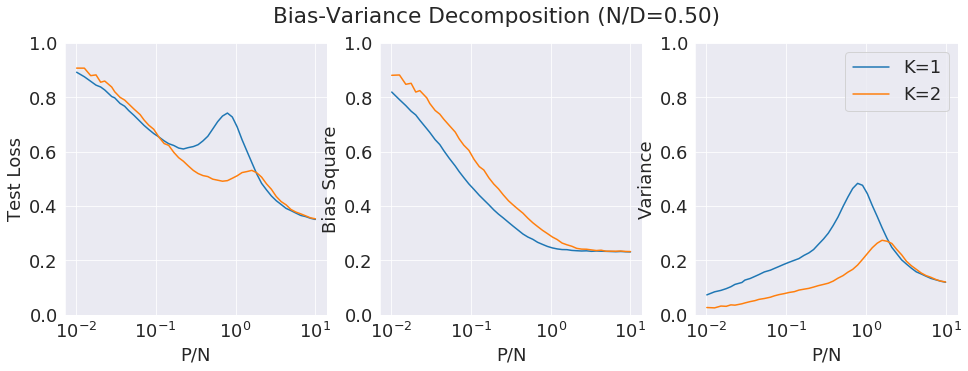

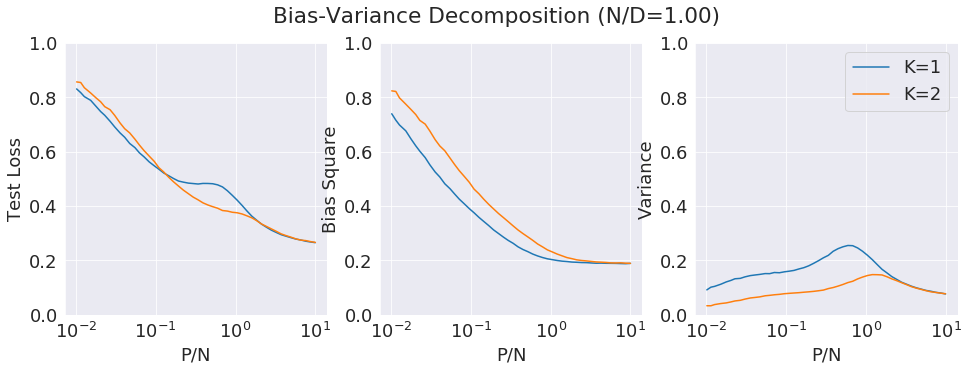

In [19]:
plot_single_vs_ensemble([K1_df, K2_df], [1, 2], N_Ds[0], 784,)
plot_single_vs_ensemble([K1_df, K2_df], [1, 2], N_Ds[1], 784, )

In the experiments above, the random feature models were trained with ridge regression. For the following experiments, we will train the random feature models with SGD. 

In [28]:
coef = 0.1
N_Ds = [1]
train_sizes = [int(np.around(x*feature_dim)) for x in N_Ds]
outdir = 'mnist_coef_{}'.format(coef)
if not os.path.exists(outdir):
    os.makedirs(outdir)
run_exps_ridge(train_sizes, N_Ds, P_Ns, trainset, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'singleNN_output.csv', K = 1)
run_exps_ridge(train_sizes, N_Ds, P_Ns, trainset, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'ensembleNNK=2_output.csv', K = 2)

Train size: [784] hidden size: [8] trial: 0, train_loss: 0.827856, train acc: 33.16326530612245, test loss: 0.848915, test acc: 30.79, bias2: 0.848915159702301, variance: -3.8925479506346505e-10
Train size: [784] hidden size: [8] trial: 1, train_loss: 0.818358, train acc: 34.50255102040816, test loss: 0.830715, test acc: 33.18, bias2: 0.7844759225845337, variance: 0.04623943939805031
Train size: [784] hidden size: [8] trial: 2, train_loss: 0.825773, train acc: 32.6530612244898, test loss: 0.838543, test acc: 31.349999999999998, bias2: 0.7769805788993835, variance: 0.06156245991587639
Train size: [784] hidden size: [8] trial: 3, train_loss: 0.819569, train acc: 33.16326530612245, test loss: 0.833482, test acc: 31.8275, bias2: 0.7644863128662109, variance: 0.06899531930685043
Train size: [784] hidden size: [8] trial: 4, train_loss: 0.820388, train acc: 33.494897959183675, test loss: 0.834593, test acc: 31.844, bias2: 0.7606850862503052, variance: 0.07390792667865753
Train size: [784] hid

Train size: [784] hidden size: [8] trial: 41, train_loss: 0.817381, train acc: 34.56025267249757, test loss: 0.830252, test acc: 32.925, bias2: 0.7401513457298279, variance: 0.09010062366724014
Train size: [784] hidden size: [8] trial: 42, train_loss: 0.816968, train acc: 34.65828191741813, test loss: 0.830062, test acc: 32.93209302325581, bias2: 0.7397473454475403, variance: 0.0903150662779808
Train size: [784] hidden size: [8] trial: 43, train_loss: 0.816530, train acc: 34.76634972170686, test loss: 0.829783, test acc: 33.0275, bias2: 0.739109218120575, variance: 0.09067332744598389
Train size: [784] hidden size: [8] trial: 44, train_loss: 0.816254, train acc: 34.72789115646258, test loss: 0.829250, test acc: 33.01466666666667, bias2: 0.7383273839950562, variance: 0.09092307090759277
Train size: [784] hidden size: [8] trial: 45, train_loss: 0.815876, train acc: 34.82142857142857, test loss: 0.828972, test acc: 33.085, bias2: 0.7377426028251648, variance: 0.09122899919748306
Train siz

Train size: [784] hidden size: [9] trial: 32, train_loss: 0.808634, train acc: 36.05055658627087, test loss: 0.822853, test acc: 33.93848484848484, bias2: 0.7263669371604919, variance: 0.09648651629686356
Train size: [784] hidden size: [9] trial: 33, train_loss: 0.808676, train acc: 36.040666266506605, test loss: 0.822871, test acc: 33.87117647058823, bias2: 0.726558268070221, variance: 0.09631304442882538
Train size: [784] hidden size: [9] trial: 34, train_loss: 0.807744, train acc: 36.21355685131196, test loss: 0.822525, test acc: 33.97771428571428, bias2: 0.7255747318267822, variance: 0.09695012122392654
Train size: [784] hidden size: [9] trial: 35, train_loss: 0.807702, train acc: 36.19614512471656, test loss: 0.821923, test acc: 34.12194444444444, bias2: 0.7247339487075806, variance: 0.09718913584947586
Train size: [784] hidden size: [9] trial: 36, train_loss: 0.808379, train acc: 36.09349145063432, test loss: 0.822744, test acc: 33.970810810810804, bias2: 0.7259814739227295, vari

Train size: [784] hidden size: [10] trial: 22, train_loss: 0.789318, train acc: 39.22471162377995, test loss: 0.806970, test acc: 36.7304347826087, bias2: 0.7082767486572266, variance: 0.0986928716301918
Train size: [784] hidden size: [10] trial: 23, train_loss: 0.789794, train acc: 39.25382653061225, test loss: 0.807282, test acc: 36.711666666666666, bias2: 0.7084920406341553, variance: 0.09878954291343689
Train size: [784] hidden size: [10] trial: 24, train_loss: 0.790826, train acc: 39.11224489795919, test loss: 0.808270, test acc: 36.5708, bias2: 0.7094475626945496, variance: 0.09882243722677231
Train size: [784] hidden size: [10] trial: 25, train_loss: 0.792433, train acc: 38.75588697017269, test loss: 0.809905, test acc: 36.205, bias2: 0.7110925316810608, variance: 0.0988125279545784
Train size: [784] hidden size: [10] trial: 26, train_loss: 0.791939, train acc: 38.893613000755856, test loss: 0.809463, test acc: 36.38407407407407, bias2: 0.7102672457695007, variance: 0.0991953983

Train size: [784] hidden size: [12] trial: 13, train_loss: 0.766144, train acc: 43.649781341107875, test loss: 0.784183, test acc: 40.53928571428571, bias2: 0.6786321997642517, variance: 0.10555068403482437
Train size: [784] hidden size: [12] trial: 14, train_loss: 0.770029, train acc: 42.97619047619048, test loss: 0.787480, test acc: 40.023999999999994, bias2: 0.6824684143066406, variance: 0.10501141101121902
Train size: [784] hidden size: [12] trial: 15, train_loss: 0.771716, train acc: 42.74553571428572, test loss: 0.788841, test acc: 39.794374999999995, bias2: 0.6844468116760254, variance: 0.10439389944076538
Train size: [784] hidden size: [12] trial: 16, train_loss: 0.771518, train acc: 42.82713085234094, test loss: 0.788224, test acc: 39.79705882352941, bias2: 0.6836836934089661, variance: 0.10454066097736359
Train size: [784] hidden size: [12] trial: 17, train_loss: 0.772172, train acc: 42.67998866213153, test loss: 0.788861, test acc: 39.73222222222222, bias2: 0.683857083320617

Train size: [784] hidden size: [14] trial: 3, train_loss: 0.754114, train acc: 44.54719387755102, test loss: 0.775279, test acc: 41.199999999999996, bias2: 0.6887820959091187, variance: 0.08649688959121704
Train size: [784] hidden size: [14] trial: 4, train_loss: 0.750155, train acc: 45.45918367346938, test loss: 0.772367, test acc: 41.635999999999996, bias2: 0.6804936528205872, variance: 0.09187383204698563
Train size: [784] hidden size: [14] trial: 5, train_loss: 0.746681, train acc: 45.982142857142854, test loss: 0.766446, test acc: 42.83833333333333, bias2: 0.6693387627601624, variance: 0.09710699319839478
Train size: [784] hidden size: [14] trial: 6, train_loss: 0.746021, train acc: 45.954810495626816, test loss: 0.766224, test acc: 43.04428571428571, bias2: 0.6653317809104919, variance: 0.10089246183633804
Train size: [784] hidden size: [14] trial: 7, train_loss: 0.747468, train acc: 45.87053571428571, test loss: 0.767271, test acc: 43.146249999999995, bias2: 0.6644995212554932, 

Train size: [784] hidden size: [14] trial: 44, train_loss: 0.743956, train acc: 46.42857142857144, test loss: 0.766065, test acc: 43.23622222222222, bias2: 0.6490703225135803, variance: 0.11699501425027847
Train size: [784] hidden size: [14] trial: 45, train_loss: 0.743156, train acc: 46.52284826974269, test loss: 0.765146, test acc: 43.34478260869565, bias2: 0.6479522585868835, variance: 0.11719347536563873
Train size: [784] hidden size: [14] trial: 46, train_loss: 0.743296, train acc: 46.561550151975695, test loss: 0.765164, test acc: 43.41510638297872, bias2: 0.6479004621505737, variance: 0.11726313084363937
Train size: [784] hidden size: [14] trial: 47, train_loss: 0.744030, train acc: 46.4498299319728, test loss: 0.765611, test acc: 43.337916666666665, bias2: 0.6485757827758789, variance: 0.11703484505414963
Train size: [784] hidden size: [14] trial: 48, train_loss: 0.744144, train acc: 46.38171595168681, test loss: 0.765710, test acc: 43.286530612244896, bias2: 0.6488326191902161

Train size: [784] hidden size: [16] trial: 34, train_loss: 0.728973, train acc: 49.46064139941691, test loss: 0.752351, test acc: 45.97314285714287, bias2: 0.6299971342086792, variance: 0.12235400080680847
Train size: [784] hidden size: [16] trial: 35, train_loss: 0.727698, train acc: 49.52522675736961, test loss: 0.751510, test acc: 46.021666666666675, bias2: 0.6291576623916626, variance: 0.12235257029533386
Train size: [784] hidden size: [16] trial: 36, train_loss: 0.727297, train acc: 49.54150579150579, test loss: 0.751164, test acc: 46.05405405405406, bias2: 0.6285461187362671, variance: 0.1226174384355545
Train size: [784] hidden size: [16] trial: 37, train_loss: 0.726762, train acc: 49.620703544575726, test loss: 0.751181, test acc: 46.09000000000001, bias2: 0.6284016966819763, variance: 0.12277956306934357
Train size: [784] hidden size: [16] trial: 38, train_loss: 0.726736, train acc: 49.60426478283621, test loss: 0.751413, test acc: 46.03358974358976, bias2: 0.628309965133667, 

Train size: [784] hidden size: [18] trial: 24, train_loss: 0.707574, train acc: 52.357142857142854, test loss: 0.736174, test acc: 48.61399999999999, bias2: 0.6108084917068481, variance: 0.12536562979221344
Train size: [784] hidden size: [18] trial: 25, train_loss: 0.708082, train acc: 52.32535321821036, test loss: 0.736132, test acc: 48.663076923076915, bias2: 0.6107473373413086, variance: 0.1253848671913147
Train size: [784] hidden size: [18] trial: 26, train_loss: 0.707521, train acc: 52.4234693877551, test loss: 0.735402, test acc: 48.78814814814814, bias2: 0.609745979309082, variance: 0.12565602362155914
Train size: [784] hidden size: [18] trial: 27, train_loss: 0.707127, train acc: 52.51457725947522, test loss: 0.735399, test acc: 48.83999999999999, bias2: 0.6095234155654907, variance: 0.1258760243654251
Train size: [784] hidden size: [18] trial: 28, train_loss: 0.707503, train acc: 52.511435608726245, test loss: 0.735313, test acc: 48.84965517241378, bias2: 0.6095385551452637, v

Train size: [784] hidden size: [21] trial: 14, train_loss: 0.682713, train acc: 56.802721088435376, test loss: 0.711217, test acc: 53.483333333333334, bias2: 0.5862773656845093, variance: 0.12494011223316193
Train size: [784] hidden size: [21] trial: 15, train_loss: 0.681762, train acc: 56.919642857142854, test loss: 0.712058, test acc: 53.3975, bias2: 0.5857181549072266, variance: 0.12633976340293884
Train size: [784] hidden size: [21] trial: 16, train_loss: 0.681977, train acc: 56.75270108043217, test loss: 0.712545, test acc: 53.26117647058824, bias2: 0.5861260890960693, variance: 0.1264192759990692
Train size: [784] hidden size: [21] trial: 17, train_loss: 0.681469, train acc: 56.68225623582766, test loss: 0.712035, test acc: 53.278333333333336, bias2: 0.5850569009780884, variance: 0.12697821855545044
Train size: [784] hidden size: [21] trial: 18, train_loss: 0.680775, train acc: 56.62593984962406, test loss: 0.712125, test acc: 53.1921052631579, bias2: 0.5846568942070007, variance

Train size: [784] hidden size: [24] trial: 4, train_loss: 0.668746, train acc: 58.5204081632653, test loss: 0.696129, test acc: 55.39200000000001, bias2: 0.5844433307647705, variance: 0.11168579757213593
Train size: [784] hidden size: [24] trial: 5, train_loss: 0.668089, train acc: 58.60969387755102, test loss: 0.701237, test acc: 54.465, bias2: 0.5841012001037598, variance: 0.11713530868291855
Train size: [784] hidden size: [24] trial: 6, train_loss: 0.670319, train acc: 58.1268221574344, test loss: 0.700760, test acc: 54.417142857142856, bias2: 0.5826504230499268, variance: 0.11810943484306335
Train size: [784] hidden size: [24] trial: 7, train_loss: 0.666206, train acc: 58.880739795918366, test loss: 0.698508, test acc: 55.33625, bias2: 0.577532947063446, variance: 0.12097547948360443
Train size: [784] hidden size: [24] trial: 8, train_loss: 0.665215, train acc: 58.8577097505669, test loss: 0.699143, test acc: 54.873333333333335, bias2: 0.5759483575820923, variance: 0.12319460511207

Train size: [784] hidden size: [24] trial: 45, train_loss: 0.658192, train acc: 59.95175244010648, test loss: 0.692509, test acc: 55.498695652173915, bias2: 0.5578795671463013, variance: 0.13462932407855988
Train size: [784] hidden size: [24] trial: 46, train_loss: 0.658632, train acc: 59.894702561875825, test loss: 0.692781, test acc: 55.45744680851064, bias2: 0.5581413507461548, variance: 0.1346398890018463
Train size: [784] hidden size: [24] trial: 47, train_loss: 0.658733, train acc: 59.84800170068028, test loss: 0.692582, test acc: 55.46875, bias2: 0.558037281036377, variance: 0.13454435765743256
Train size: [784] hidden size: [24] trial: 48, train_loss: 0.658772, train acc: 59.85526863806748, test loss: 0.692874, test acc: 55.39857142857143, bias2: 0.5584319233894348, variance: 0.13444161415100098
Train size: [784] hidden size: [24] trial: 49, train_loss: 0.658457, train acc: 59.872448979591844, test loss: 0.692797, test acc: 55.39, bias2: 0.5580236315727234, variance: 0.13477301

Train size: [784] hidden size: [28] trial: 35, train_loss: 0.635722, train acc: 62.80824829931974, test loss: 0.671652, test acc: 58.41388888888888, bias2: 0.5359189510345459, variance: 0.13573333621025085
Train size: [784] hidden size: [28] trial: 36, train_loss: 0.634927, train acc: 62.87575841147272, test loss: 0.671146, test acc: 58.495945945945934, bias2: 0.534982442855835, variance: 0.1361631602048874
Train size: [784] hidden size: [28] trial: 37, train_loss: 0.634617, train acc: 62.919575725026874, test loss: 0.670850, test acc: 58.55184210526314, bias2: 0.5344480872154236, variance: 0.13640187680721283
Train size: [784] hidden size: [28] trial: 38, train_loss: 0.634939, train acc: 62.92844060701206, test loss: 0.671302, test acc: 58.53179487179485, bias2: 0.5348073244094849, variance: 0.13649503886699677
Train size: [784] hidden size: [28] trial: 39, train_loss: 0.635460, train acc: 62.91772959183676, test loss: 0.671309, test acc: 58.58974999999998, bias2: 0.53485107421875, va

Train size: [784] hidden size: [32] trial: 26, train_loss: 0.614737, train acc: 65.55650037792896, test loss: 0.658586, test acc: 60.208518518518524, bias2: 0.5189917087554932, variance: 0.1395939141511917
Train size: [784] hidden size: [32] trial: 27, train_loss: 0.615370, train acc: 65.51567055393586, test loss: 0.659312, test acc: 60.14678571428572, bias2: 0.5195085406303406, variance: 0.1398034691810608
Train size: [784] hidden size: [32] trial: 28, train_loss: 0.614851, train acc: 65.60960591133005, test loss: 0.659155, test acc: 60.20413793103449, bias2: 0.5189838409423828, variance: 0.14017145335674286
Train size: [784] hidden size: [32] trial: 29, train_loss: 0.614648, train acc: 65.65901360544218, test loss: 0.658447, test acc: 60.24166666666667, bias2: 0.518239438533783, variance: 0.14020712673664093
Train size: [784] hidden size: [32] trial: 30, train_loss: 0.614921, train acc: 65.66820276497697, test loss: 0.658757, test acc: 60.17903225806452, bias2: 0.5185354351997375, va

Train size: [784] hidden size: [37] trial: 17, train_loss: 0.580680, train acc: 70.3656462585034, test loss: 0.632442, test acc: 63.861666666666665, bias2: 0.4967878460884094, variance: 0.13565392792224884
Train size: [784] hidden size: [37] trial: 18, train_loss: 0.581824, train acc: 70.27389903329752, test loss: 0.634476, test acc: 63.67473684210526, bias2: 0.49730944633483887, variance: 0.13716672360897064
Train size: [784] hidden size: [37] trial: 19, train_loss: 0.581944, train acc: 70.21045918367346, test loss: 0.633951, test acc: 63.6985, bias2: 0.49659186601638794, variance: 0.13735906779766083
Train size: [784] hidden size: [37] trial: 20, train_loss: 0.581337, train acc: 70.24416909620992, test loss: 0.633805, test acc: 63.69333333333333, bias2: 0.4964068531990051, variance: 0.13739849627017975
Train size: [784] hidden size: [37] trial: 21, train_loss: 0.581758, train acc: 70.10667903525047, test loss: 0.633552, test acc: 63.75818181818181, bias2: 0.4963996410369873, variance

Train size: [784] hidden size: [43] trial: 7, train_loss: 0.559237, train acc: 73.02295918367348, test loss: 0.614898, test acc: 66.3725, bias2: 0.48713964223861694, variance: 0.12775813043117523
Train size: [784] hidden size: [43] trial: 8, train_loss: 0.560798, train acc: 72.76077097505669, test loss: 0.616543, test acc: 66.02666666666667, bias2: 0.4867817461490631, variance: 0.12976130843162537
Train size: [784] hidden size: [43] trial: 9, train_loss: 0.562491, train acc: 72.64030612244899, test loss: 0.616728, test acc: 65.821, bias2: 0.4856871962547302, variance: 0.13104093074798584
Train size: [784] hidden size: [43] trial: 10, train_loss: 0.562250, train acc: 72.54174397031541, test loss: 0.616198, test acc: 65.88181818181819, bias2: 0.48419085144996643, variance: 0.13200673460960388
Train size: [784] hidden size: [43] trial: 11, train_loss: 0.561921, train acc: 72.64030612244899, test loss: 0.615261, test acc: 66.0475, bias2: 0.4828147888183594, variance: 0.13244622945785522
Tr

Train size: [784] hidden size: [43] trial: 48, train_loss: 0.559495, train acc: 72.41513952519783, test loss: 0.617134, test acc: 65.68448979591838, bias2: 0.47469842433929443, variance: 0.14243577420711517
Train size: [784] hidden size: [43] trial: 49, train_loss: 0.559434, train acc: 72.4158163265306, test loss: 0.616933, test acc: 65.71380000000002, bias2: 0.4745206832885742, variance: 0.14241187274456024
##################################################
Train size: [784] hidden size: [49] trial: 0, train_loss: 0.522125, train acc: 77.67857142857143, test loss: 0.593231, test acc: 70.33, bias2: 0.5932307839393616, variance: 2.3355288814030928e-09
Train size: [784] hidden size: [49] trial: 1, train_loss: 0.540457, train acc: 76.0841836734694, test loss: 0.608143, test acc: 68.34, bias2: 0.5360782742500305, variance: 0.07206429541110992
Train size: [784] hidden size: [49] trial: 2, train_loss: 0.531572, train acc: 75.89285714285715, test loss: 0.599097, test acc: 68.18666666666667, b

Train size: [784] hidden size: [49] trial: 39, train_loss: 0.532549, train acc: 75.17857142857143, test loss: 0.595021, test acc: 68.1965, bias2: 0.45447248220443726, variance: 0.1405484825372696
Train size: [784] hidden size: [49] trial: 40, train_loss: 0.532916, train acc: 75.11821801891489, test loss: 0.595212, test acc: 68.20121951219512, bias2: 0.45451241731643677, variance: 0.14069998264312744
Train size: [784] hidden size: [49] trial: 41, train_loss: 0.533239, train acc: 75.04251700680273, test loss: 0.595327, test acc: 68.14595238095238, bias2: 0.4547537565231323, variance: 0.14057345688343048
Train size: [784] hidden size: [49] trial: 42, train_loss: 0.533094, train acc: 75.06822496440437, test loss: 0.595538, test acc: 68.10348837209303, bias2: 0.4546143710613251, variance: 0.14092394709587097
Train size: [784] hidden size: [49] trial: 43, train_loss: 0.533014, train acc: 75.04638218923932, test loss: 0.595480, test acc: 68.07454545454546, bias2: 0.45455288887023926, variance

Train size: [784] hidden size: [56] trial: 29, train_loss: 0.503453, train acc: 78.11649659863946, test loss: 0.574985, test acc: 70.30366666666667, bias2: 0.43678510189056396, variance: 0.13820014894008636
Train size: [784] hidden size: [56] trial: 30, train_loss: 0.503946, train acc: 78.07768268597762, test loss: 0.575894, test acc: 70.22870967741936, bias2: 0.4372718632221222, variance: 0.13862237334251404
Train size: [784] hidden size: [56] trial: 31, train_loss: 0.503820, train acc: 78.08115433673468, test loss: 0.575965, test acc: 70.1928125, bias2: 0.4372756779193878, variance: 0.13868895173072815
Train size: [784] hidden size: [56] trial: 32, train_loss: 0.503643, train acc: 78.1230674087817, test loss: 0.575564, test acc: 70.22030303030303, bias2: 0.4367325007915497, variance: 0.13883128762245178
Train size: [784] hidden size: [56] trial: 33, train_loss: 0.503482, train acc: 78.14750900360143, test loss: 0.575537, test acc: 70.22029411764706, bias2: 0.4367346465587616, varianc

Train size: [784] hidden size: [65] trial: 20, train_loss: 0.481304, train acc: 80.41180758017492, test loss: 0.562337, test acc: 71.94476190476192, bias2: 0.4244356155395508, variance: 0.13790170848369598
Train size: [784] hidden size: [65] trial: 21, train_loss: 0.481796, train acc: 80.32235621521335, test loss: 0.562105, test acc: 71.96363636363637, bias2: 0.4242779016494751, variance: 0.137827530503273
Train size: [784] hidden size: [65] trial: 22, train_loss: 0.482288, train acc: 80.33496007098492, test loss: 0.562565, test acc: 71.93217391304348, bias2: 0.4246591329574585, variance: 0.13790619373321533
Train size: [784] hidden size: [65] trial: 23, train_loss: 0.482309, train acc: 80.37308673469387, test loss: 0.562329, test acc: 71.97791666666667, bias2: 0.4240872859954834, variance: 0.1382414698600769
Train size: [784] hidden size: [65] trial: 24, train_loss: 0.481590, train acc: 80.45918367346938, test loss: 0.561229, test acc: 72.074, bias2: 0.42286598682403564, variance: 0.1

Train size: [784] hidden size: [75] trial: 11, train_loss: 0.451802, train acc: 83.23767006802721, test loss: 0.536026, test acc: 74.41666666666667, bias2: 0.40591567754745483, variance: 0.13011060655117035
Train size: [784] hidden size: [75] trial: 12, train_loss: 0.449759, train acc: 83.42817896389326, test loss: 0.535121, test acc: 74.5, bias2: 0.4041234254837036, variance: 0.1309971660375595
Train size: [784] hidden size: [75] trial: 13, train_loss: 0.449817, train acc: 83.32725947521865, test loss: 0.534153, test acc: 74.60571428571428, bias2: 0.4027172923088074, variance: 0.13143551349639893
Train size: [784] hidden size: [75] trial: 14, train_loss: 0.450515, train acc: 83.25680272108843, test loss: 0.533896, test acc: 74.66733333333333, bias2: 0.4026041328907013, variance: 0.13129135966300964
Train size: [784] hidden size: [75] trial: 15, train_loss: 0.451263, train acc: 83.07557397959184, test loss: 0.535469, test acc: 74.44375, bias2: 0.40280234813690186, variance: 0.132666155

Train size: [784] hidden size: [86] trial: 1, train_loss: 0.423575, train acc: 84.18367346938776, test loss: 0.515420, test acc: 75.77, bias2: 0.4465901255607605, variance: 0.06882983446121216
Train size: [784] hidden size: [86] trial: 2, train_loss: 0.422202, train acc: 84.60884353741496, test loss: 0.518175, test acc: 75.88666666666667, bias2: 0.42519766092300415, variance: 0.09297721087932587
Train size: [784] hidden size: [86] trial: 3, train_loss: 0.429006, train acc: 84.34311224489795, test loss: 0.521574, test acc: 75.755, bias2: 0.4170534014701843, variance: 0.10452020913362503
Train size: [784] hidden size: [86] trial: 4, train_loss: 0.428293, train acc: 84.48979591836734, test loss: 0.519155, test acc: 75.874, bias2: 0.4082742929458618, variance: 0.11088085174560547
Train size: [784] hidden size: [86] trial: 5, train_loss: 0.429051, train acc: 84.52380952380952, test loss: 0.518862, test acc: 75.97833333333334, bias2: 0.40354132652282715, variance: 0.11532066762447357
Train s

Train size: [784] hidden size: [86] trial: 42, train_loss: 0.429109, train acc: 84.82142857142856, test loss: 0.521433, test acc: 75.72906976744184, bias2: 0.38545700907707214, variance: 0.1359761655330658
Train size: [784] hidden size: [86] trial: 43, train_loss: 0.428504, train acc: 84.8678107606679, test loss: 0.521178, test acc: 75.75477272727272, bias2: 0.38515913486480713, variance: 0.13601885735988617
Train size: [784] hidden size: [86] trial: 44, train_loss: 0.428735, train acc: 84.81009070294783, test loss: 0.521334, test acc: 75.74933333333333, bias2: 0.38526979088783264, variance: 0.13606372475624084
Train size: [784] hidden size: [86] trial: 45, train_loss: 0.428506, train acc: 84.82142857142856, test loss: 0.521405, test acc: 75.74217391304347, bias2: 0.38520893454551697, variance: 0.13619574904441833
Train size: [784] hidden size: [86] trial: 46, train_loss: 0.428360, train acc: 84.84856708640902, test loss: 0.521601, test acc: 75.73446808510639, bias2: 0.3853471279144287

Train size: [784] hidden size: [99] trial: 32, train_loss: 0.405498, train acc: 86.88543599257885, test loss: 0.505784, test acc: 77.08000000000003, bias2: 0.37329667806625366, variance: 0.1324871927499771
Train size: [784] hidden size: [99] trial: 33, train_loss: 0.404947, train acc: 86.92977190876351, test loss: 0.505658, test acc: 77.10117647058826, bias2: 0.372924268245697, variance: 0.1327340453863144
Train size: [784] hidden size: [99] trial: 34, train_loss: 0.404919, train acc: 86.9460641399417, test loss: 0.505486, test acc: 77.15314285714288, bias2: 0.37265294790267944, variance: 0.13283266127109528
Train size: [784] hidden size: [99] trial: 35, train_loss: 0.404437, train acc: 86.98979591836736, test loss: 0.505323, test acc: 77.15833333333336, bias2: 0.37244701385498047, variance: 0.1328759789466858
Train size: [784] hidden size: [99] trial: 36, train_loss: 0.404755, train acc: 86.97945394373967, test loss: 0.505507, test acc: 77.16162162162166, bias2: 0.3725277781486511, va

Train size: [784] hidden size: [114] trial: 22, train_loss: 0.382171, train acc: 88.9807009760426, test loss: 0.493019, test acc: 78.4117391304348, bias2: 0.36412274837493896, variance: 0.12889613211154938
Train size: [784] hidden size: [114] trial: 23, train_loss: 0.382489, train acc: 88.95089285714288, test loss: 0.493561, test acc: 78.37500000000001, bias2: 0.36414676904678345, variance: 0.12941424548625946
Train size: [784] hidden size: [114] trial: 24, train_loss: 0.381925, train acc: 89.03571428571429, test loss: 0.493351, test acc: 78.40320000000001, bias2: 0.3637567162513733, variance: 0.12959422171115875
Train size: [784] hidden size: [114] trial: 25, train_loss: 0.381635, train acc: 88.98645996860283, test loss: 0.493532, test acc: 78.36461538461539, bias2: 0.36357933282852173, variance: 0.12995225191116333
Train size: [784] hidden size: [114] trial: 26, train_loss: 0.381326, train acc: 89.01643990929706, test loss: 0.493523, test acc: 78.35777777777778, bias2: 0.363519370555

Train size: [784] hidden size: [131] trial: 12, train_loss: 0.355149, train acc: 90.61028257456829, test loss: 0.475904, test acc: 79.83769230769232, bias2: 0.35353538393974304, variance: 0.12236862629652023
Train size: [784] hidden size: [131] trial: 13, train_loss: 0.355014, train acc: 90.57033527696794, test loss: 0.475643, test acc: 79.85285714285715, bias2: 0.352670818567276, variance: 0.12297218292951584
Train size: [784] hidden size: [131] trial: 14, train_loss: 0.355542, train acc: 90.4421768707483, test loss: 0.476191, test acc: 79.75666666666667, bias2: 0.35234707593917847, variance: 0.12384425103664398
Train size: [784] hidden size: [131] trial: 15, train_loss: 0.356040, train acc: 90.42570153061224, test loss: 0.476075, test acc: 79.7925, bias2: 0.3517633378505707, variance: 0.12431195378303528
Train size: [784] hidden size: [131] trial: 16, train_loss: 0.355563, train acc: 90.50120048019208, test loss: 0.475645, test acc: 79.81588235294119, bias2: 0.3511628806591034, varia

Train size: [784] hidden size: [151] trial: 2, train_loss: 0.343094, train acc: 91.02891156462584, test loss: 0.465743, test acc: 80.2, bias2: 0.3805401027202606, variance: 0.08520282059907913
Train size: [784] hidden size: [151] trial: 3, train_loss: 0.342989, train acc: 90.88010204081633, test loss: 0.461958, test acc: 80.66000000000001, bias2: 0.3657616376876831, variance: 0.09619639813899994
Train size: [784] hidden size: [151] trial: 4, train_loss: 0.340573, train acc: 90.9438775510204, test loss: 0.461833, test acc: 80.644, bias2: 0.3585608899593353, variance: 0.10327231138944626
Train size: [784] hidden size: [151] trial: 5, train_loss: 0.339624, train acc: 91.28401360544217, test loss: 0.462711, test acc: 80.79333333333334, bias2: 0.3545137941837311, variance: 0.10819705575704575
Train size: [784] hidden size: [151] trial: 6, train_loss: 0.340572, train acc: 91.36297376093295, test loss: 0.463480, test acc: 80.76714285714286, bias2: 0.35170114040374756, variance: 0.111779168248

Train size: [784] hidden size: [151] trial: 43, train_loss: 0.333749, train acc: 91.9845779220779, test loss: 0.462643, test acc: 80.91681818181819, bias2: 0.335203617811203, variance: 0.1274397075176239
Train size: [784] hidden size: [151] trial: 44, train_loss: 0.333620, train acc: 92.0096371882086, test loss: 0.462746, test acc: 80.91666666666667, bias2: 0.33533263206481934, variance: 0.12741310894489288
Train size: [784] hidden size: [151] trial: 45, train_loss: 0.333349, train acc: 92.01696983141082, test loss: 0.462770, test acc: 80.91652173913043, bias2: 0.3353099822998047, variance: 0.12746022641658783
Train size: [784] hidden size: [151] trial: 46, train_loss: 0.333016, train acc: 92.03755970473294, test loss: 0.462810, test acc: 80.9136170212766, bias2: 0.33531272411346436, variance: 0.12749768793582916
Train size: [784] hidden size: [151] trial: 47, train_loss: 0.333042, train acc: 92.0440051020408, test loss: 0.462823, test acc: 80.90833333333333, bias2: 0.33524924516677856

Train size: [784] hidden size: [174] trial: 33, train_loss: 0.310993, train acc: 93.21353541416568, test loss: 0.449456, test acc: 81.84235294117647, bias2: 0.3269306719303131, variance: 0.122525155544281
Train size: [784] hidden size: [174] trial: 34, train_loss: 0.311398, train acc: 93.1960641399417, test loss: 0.449492, test acc: 81.82857142857142, bias2: 0.3269079327583313, variance: 0.12258423119783401
Train size: [784] hidden size: [174] trial: 35, train_loss: 0.311809, train acc: 93.18664965986395, test loss: 0.449731, test acc: 81.83611111111111, bias2: 0.3270154595375061, variance: 0.12271545082330704
Train size: [784] hidden size: [174] trial: 36, train_loss: 0.312239, train acc: 93.15016547159405, test loss: 0.449688, test acc: 81.84432432432432, bias2: 0.3269888460636139, variance: 0.12269929051399231
Train size: [784] hidden size: [174] trial: 37, train_loss: 0.311596, train acc: 93.20287325456498, test loss: 0.449332, test acc: 81.86131578947368, bias2: 0.3265951871871948

Train size: [784] hidden size: [201] trial: 23, train_loss: 0.293314, train acc: 94.6109693877551, test loss: 0.436240, test acc: 82.74625, bias2: 0.3177253007888794, variance: 0.11851479113101959
Train size: [784] hidden size: [201] trial: 24, train_loss: 0.293080, train acc: 94.59693877551021, test loss: 0.436056, test acc: 82.7596, bias2: 0.3177976608276367, variance: 0.11825797706842422
Train size: [784] hidden size: [201] trial: 25, train_loss: 0.292661, train acc: 94.6379513343799, test loss: 0.436265, test acc: 82.73615384615385, bias2: 0.31766581535339355, variance: 0.11859957128763199
Train size: [784] hidden size: [201] trial: 26, train_loss: 0.293254, train acc: 94.62396069538927, test loss: 0.436309, test acc: 82.7488888888889, bias2: 0.317484587430954, variance: 0.11882433295249939
Train size: [784] hidden size: [201] trial: 27, train_loss: 0.293305, train acc: 94.5973032069971, test loss: 0.436371, test acc: 82.74178571428573, bias2: 0.3174175024032593, variance: 0.118953

Train size: [784] hidden size: [231] trial: 13, train_loss: 0.268697, train acc: 95.63593294460642, test loss: 0.422718, test acc: 83.535, bias2: 0.31139954924583435, variance: 0.11131885647773743
Train size: [784] hidden size: [231] trial: 14, train_loss: 0.268330, train acc: 95.6122448979592, test loss: 0.422976, test acc: 83.52199999999999, bias2: 0.31119588017463684, variance: 0.11177975684404373
Train size: [784] hidden size: [231] trial: 15, train_loss: 0.268624, train acc: 95.59151785714286, test loss: 0.423445, test acc: 83.49, bias2: 0.31101900339126587, variance: 0.11242587864398956
Train size: [784] hidden size: [231] trial: 16, train_loss: 0.269912, train acc: 95.5282112845138, test loss: 0.423716, test acc: 83.51235294117647, bias2: 0.3108002841472626, variance: 0.11291594058275223
Train size: [784] hidden size: [231] trial: 17, train_loss: 0.270027, train acc: 95.54280045351474, test loss: 0.423777, test acc: 83.46055555555556, bias2: 0.31070613861083984, variance: 0.1130

Train size: [784] hidden size: [266] trial: 3, train_loss: 0.254547, train acc: 96.58801020408163, test loss: 0.413364, test acc: 83.61, bias2: 0.32658547163009644, variance: 0.08677816390991211
Train size: [784] hidden size: [266] trial: 4, train_loss: 0.250781, train acc: 96.76020408163265, test loss: 0.413287, test acc: 83.596, bias2: 0.3220384120941162, variance: 0.09124864637851715
Train size: [784] hidden size: [266] trial: 5, train_loss: 0.250463, train acc: 96.66241496598639, test loss: 0.413248, test acc: 83.68, bias2: 0.3181729316711426, variance: 0.09507544338703156
Train size: [784] hidden size: [266] trial: 6, train_loss: 0.251405, train acc: 96.48323615160349, test loss: 0.412488, test acc: 83.76142857142858, bias2: 0.31466805934906006, variance: 0.09781999886035919
Train size: [784] hidden size: [266] trial: 7, train_loss: 0.250396, train acc: 96.52423469387755, test loss: 0.412333, test acc: 83.69, bias2: 0.31251582503318787, variance: 0.09981673210859299
Train size: [7

Train size: [784] hidden size: [266] trial: 43, train_loss: 0.249725, train acc: 96.54162801484232, test loss: 0.412095, test acc: 84.05704545454547, bias2: 0.30058157444000244, variance: 0.11151368916034698
Train size: [784] hidden size: [266] trial: 44, train_loss: 0.249774, train acc: 96.53628117913833, test loss: 0.411974, test acc: 84.07400000000001, bias2: 0.3004104495048523, variance: 0.11156363785266876
Train size: [784] hidden size: [266] trial: 45, train_loss: 0.249810, train acc: 96.55889529724935, test loss: 0.412070, test acc: 84.05869565217392, bias2: 0.3003970980644226, variance: 0.11167285591363907
Train size: [784] hidden size: [266] trial: 46, train_loss: 0.249780, train acc: 96.5859748154581, test loss: 0.411960, test acc: 84.06170212765959, bias2: 0.30028191208839417, variance: 0.1116780936717987
Train size: [784] hidden size: [266] trial: 47, train_loss: 0.249903, train acc: 96.59332482993199, test loss: 0.412009, test acc: 84.06479166666668, bias2: 0.3003181815147

Train size: [784] hidden size: [306] trial: 33, train_loss: 0.233852, train acc: 97.27265906362543, test loss: 0.399848, test acc: 84.82970588235293, bias2: 0.29447537660598755, variance: 0.10537271201610565
Train size: [784] hidden size: [306] trial: 34, train_loss: 0.233832, train acc: 97.32142857142854, test loss: 0.400000, test acc: 84.83371428571427, bias2: 0.2943340539932251, variance: 0.10566584765911102
Train size: [784] hidden size: [306] trial: 35, train_loss: 0.233870, train acc: 97.31079931972786, test loss: 0.400019, test acc: 84.84027777777777, bias2: 0.29413965344429016, variance: 0.10587901622056961
Train size: [784] hidden size: [306] trial: 36, train_loss: 0.233825, train acc: 97.31798124655265, test loss: 0.400104, test acc: 84.83351351351351, bias2: 0.29409733414649963, variance: 0.1060071662068367
Train size: [784] hidden size: [306] trial: 37, train_loss: 0.233630, train acc: 97.28786251342639, test loss: 0.399886, test acc: 84.83815789473684, bias2: 0.29383063316

Train size: [784] hidden size: [353] trial: 23, train_loss: 0.216834, train acc: 97.64030612244898, test loss: 0.389689, test acc: 85.34625000000001, bias2: 0.2904954254627228, variance: 0.09919395297765732
Train size: [784] hidden size: [353] trial: 24, train_loss: 0.216752, train acc: 97.64285714285714, test loss: 0.389681, test acc: 85.33680000000003, bias2: 0.2904536724090576, variance: 0.09922739863395691
Train size: [784] hidden size: [353] trial: 25, train_loss: 0.216820, train acc: 97.65992935635792, test loss: 0.389748, test acc: 85.33384615384618, bias2: 0.29030799865722656, variance: 0.0994400829076767
Train size: [784] hidden size: [353] trial: 26, train_loss: 0.217104, train acc: 97.6993575207861, test loss: 0.389695, test acc: 85.34592592592595, bias2: 0.2899337410926819, variance: 0.09976105391979218
Train size: [784] hidden size: [353] trial: 27, train_loss: 0.217318, train acc: 97.69041545189505, test loss: 0.389577, test acc: 85.34285714285717, bias2: 0.28972989320755

Train size: [784] hidden size: [406] trial: 13, train_loss: 0.203717, train acc: 98.15962099125365, test loss: 0.378294, test acc: 85.745, bias2: 0.2872031629085541, variance: 0.09109113365411758
Train size: [784] hidden size: [406] trial: 14, train_loss: 0.203978, train acc: 98.14625850340137, test loss: 0.377825, test acc: 85.78933333333335, bias2: 0.28629952669143677, variance: 0.09152562916278839
Train size: [784] hidden size: [406] trial: 15, train_loss: 0.203214, train acc: 98.17442602040816, test loss: 0.377774, test acc: 85.820625, bias2: 0.2858172059059143, variance: 0.09195683896541595
Train size: [784] hidden size: [406] trial: 16, train_loss: 0.203790, train acc: 98.19177671068428, test loss: 0.377679, test acc: 85.88705882352942, bias2: 0.2851802706718445, variance: 0.09249912947416306
Train size: [784] hidden size: [406] trial: 17, train_loss: 0.203677, train acc: 98.20719954648527, test loss: 0.377742, test acc: 85.89555555555556, bias2: 0.28519028425216675, variance: 0.

Train size: [784] hidden size: [468] trial: 3, train_loss: 0.195308, train acc: 98.62882653061226, test loss: 0.361937, test acc: 87.39, bias2: 0.29233336448669434, variance: 0.06960413604974747
Train size: [784] hidden size: [468] trial: 4, train_loss: 0.194057, train acc: 98.6734693877551, test loss: 0.361491, test acc: 87.452, bias2: 0.28832191228866577, variance: 0.07316917926073074
Train size: [784] hidden size: [468] trial: 5, train_loss: 0.192457, train acc: 98.72448979591837, test loss: 0.361552, test acc: 87.245, bias2: 0.2855384051799774, variance: 0.0760139599442482
Train size: [784] hidden size: [468] trial: 6, train_loss: 0.193431, train acc: 98.59693877551021, test loss: 0.362221, test acc: 87.19571428571429, bias2: 0.2834573984146118, variance: 0.07876396924257278
Train size: [784] hidden size: [468] trial: 7, train_loss: 0.193272, train acc: 98.59693877551021, test loss: 0.362576, test acc: 87.07, bias2: 0.2822577953338623, variance: 0.0803178921341896
Train size: [784]

Train size: [784] hidden size: [468] trial: 43, train_loss: 0.191781, train acc: 98.54765769944346, test loss: 0.368199, test acc: 86.42568181818179, bias2: 0.2779046893119812, variance: 0.09029392898082733
Train size: [784] hidden size: [468] trial: 44, train_loss: 0.191839, train acc: 98.55442176870753, test loss: 0.368184, test acc: 86.43933333333331, bias2: 0.2777172029018402, variance: 0.09046631306409836
Train size: [784] hidden size: [468] trial: 45, train_loss: 0.191855, train acc: 98.54702750665487, test loss: 0.368104, test acc: 86.44847826086954, bias2: 0.2777564823627472, variance: 0.090347521007061
Train size: [784] hidden size: [468] trial: 46, train_loss: 0.191847, train acc: 98.5643725575337, test loss: 0.368144, test acc: 86.44638297872338, bias2: 0.27774956822395325, variance: 0.09039392322301865
Train size: [784] hidden size: [468] trial: 47, train_loss: 0.191852, train acc: 98.5570790816327, test loss: 0.368148, test acc: 86.44041666666664, bias2: 0.2777307331562042

Train size: [784] hidden size: [538] trial: 33, train_loss: 0.179766, train acc: 98.78826530612247, test loss: 0.359179, test acc: 86.87882352941176, bias2: 0.2755163609981537, variance: 0.08366311341524124
Train size: [784] hidden size: [538] trial: 34, train_loss: 0.179629, train acc: 98.79737609329447, test loss: 0.359048, test acc: 86.89857142857143, bias2: 0.2753928303718567, variance: 0.08365479111671448
Train size: [784] hidden size: [538] trial: 35, train_loss: 0.179812, train acc: 98.79889455782315, test loss: 0.359287, test acc: 86.88833333333334, bias2: 0.27546823024749756, variance: 0.08381900936365128
Train size: [784] hidden size: [538] trial: 36, train_loss: 0.179753, train acc: 98.80377826806401, test loss: 0.359429, test acc: 86.88810810810811, bias2: 0.2754948139190674, variance: 0.0839344710111618
Train size: [784] hidden size: [538] trial: 37, train_loss: 0.179489, train acc: 98.80504833512354, test loss: 0.359412, test acc: 86.88815789473684, bias2: 0.2754266262054

Train size: [784] hidden size: [620] trial: 23, train_loss: 0.168883, train acc: 98.9423894557823, test loss: 0.348917, test acc: 87.33333333333333, bias2: 0.27107569575309753, variance: 0.07784100621938705
Train size: [784] hidden size: [620] trial: 24, train_loss: 0.168603, train acc: 98.94897959183672, test loss: 0.348942, test acc: 87.33120000000001, bias2: 0.2710007429122925, variance: 0.07794139534235
Train size: [784] hidden size: [620] trial: 25, train_loss: 0.168777, train acc: 98.93053375196232, test loss: 0.349007, test acc: 87.35346153846154, bias2: 0.2708256244659424, variance: 0.07818156480789185
Train size: [784] hidden size: [620] trial: 26, train_loss: 0.168315, train acc: 98.95124716553288, test loss: 0.348778, test acc: 87.35370370370372, bias2: 0.2707992196083069, variance: 0.07797829806804657
Train size: [784] hidden size: [620] trial: 27, train_loss: 0.168282, train acc: 98.96137026239066, test loss: 0.348827, test acc: 87.36000000000001, bias2: 0.2708112597465515

Train size: [784] hidden size: [714] trial: 13, train_loss: 0.161135, train acc: 99.22558309037902, test loss: 0.339571, test acc: 87.81642857142856, bias2: 0.2688713073730469, variance: 0.07069960981607437
Train size: [784] hidden size: [714] trial: 14, train_loss: 0.161086, train acc: 99.23469387755104, test loss: 0.339172, test acc: 87.87733333333333, bias2: 0.2682921886444092, variance: 0.07088024914264679
Train size: [784] hidden size: [714] trial: 15, train_loss: 0.160422, train acc: 99.25063775510205, test loss: 0.339138, test acc: 87.86999999999999, bias2: 0.26807674765586853, variance: 0.07106122374534607
Train size: [784] hidden size: [714] trial: 16, train_loss: 0.160340, train acc: 99.19717887154863, test loss: 0.338965, test acc: 87.87117647058824, bias2: 0.2675008773803711, variance: 0.07146424055099487
Train size: [784] hidden size: [714] trial: 17, train_loss: 0.160201, train acc: 99.21343537414967, test loss: 0.339059, test acc: 87.84055555555555, bias2: 0.267210692167

Train size: [784] hidden size: [822] trial: 3, train_loss: 0.154565, train acc: 99.23469387755102, test loss: 0.332221, test acc: 88.19000000000001, bias2: 0.2779766321182251, variance: 0.05424466356635094
Train size: [784] hidden size: [822] trial: 4, train_loss: 0.152370, train acc: 99.28571428571429, test loss: 0.328972, test acc: 88.446, bias2: 0.27170872688293457, variance: 0.057263754308223724
Train size: [784] hidden size: [822] trial: 5, train_loss: 0.150567, train acc: 99.31972789115646, test loss: 0.329384, test acc: 88.255, bias2: 0.27027449011802673, variance: 0.05910908803343773
Train size: [784] hidden size: [822] trial: 6, train_loss: 0.150859, train acc: 99.30758017492712, test loss: 0.330528, test acc: 88.20857142857143, bias2: 0.2700194716453552, variance: 0.0605081245303154
Train size: [784] hidden size: [822] trial: 7, train_loss: 0.149923, train acc: 99.34630102040818, test loss: 0.330442, test acc: 88.18125, bias2: 0.2688589096069336, variance: 0.06158316135406494

Train size: [784] hidden size: [822] trial: 43, train_loss: 0.152446, train acc: 99.38543599257879, test loss: 0.333695, test acc: 88.09931818181818, bias2: 0.2634168267250061, variance: 0.07027842849493027
Train size: [784] hidden size: [822] trial: 44, train_loss: 0.152555, train acc: 99.38492063492059, test loss: 0.333836, test acc: 88.08066666666667, bias2: 0.2634913921356201, variance: 0.0703449696302414
Train size: [784] hidden size: [822] trial: 45, train_loss: 0.152607, train acc: 99.39274622892631, test loss: 0.333690, test acc: 88.09673913043478, bias2: 0.2633931636810303, variance: 0.07029695808887482
Train size: [784] hidden size: [822] trial: 46, train_loss: 0.152602, train acc: 99.3893834129396, test loss: 0.333726, test acc: 88.10468085106383, bias2: 0.26338228583335876, variance: 0.0703439936041832
Train size: [784] hidden size: [822] trial: 47, train_loss: 0.152597, train acc: 99.39413265306119, test loss: 0.333902, test acc: 88.09333333333335, bias2: 0.263483822345733

Train size: [784] hidden size: [946] trial: 33, train_loss: 0.145901, train acc: 99.45228091236491, test loss: 0.327251, test acc: 88.18264705882352, bias2: 0.26159387826919556, variance: 0.06565665453672409
Train size: [784] hidden size: [946] trial: 34, train_loss: 0.145934, train acc: 99.46428571428568, test loss: 0.327220, test acc: 88.19942857142856, bias2: 0.26157888770103455, variance: 0.06564083695411682
Train size: [784] hidden size: [946] trial: 35, train_loss: 0.146089, train acc: 99.46145124716548, test loss: 0.327326, test acc: 88.19805555555554, bias2: 0.2616717219352722, variance: 0.06565459072589874
Train size: [784] hidden size: [946] trial: 36, train_loss: 0.146113, train acc: 99.45187534473244, test loss: 0.327394, test acc: 88.19162162162161, bias2: 0.26163434982299805, variance: 0.06575952470302582
Train size: [784] hidden size: [946] trial: 37, train_loss: 0.146101, train acc: 99.45622986036516, test loss: 0.327475, test acc: 88.18210526315788, bias2: 0.2615911960

Train size: [784] hidden size: [1089] trial: 23, train_loss: 0.139683, train acc: 99.51636904761902, test loss: 0.321794, test acc: 88.55666666666669, bias2: 0.2608757019042969, variance: 0.060918018221855164
Train size: [784] hidden size: [1089] trial: 24, train_loss: 0.139699, train acc: 99.51020408163262, test loss: 0.321955, test acc: 88.55160000000002, bias2: 0.26085054874420166, variance: 0.06110434606671333
Train size: [784] hidden size: [1089] trial: 25, train_loss: 0.139858, train acc: 99.5143249607535, test loss: 0.322297, test acc: 88.50807692307694, bias2: 0.26088786125183105, variance: 0.061409108340740204
Train size: [784] hidden size: [1089] trial: 26, train_loss: 0.139855, train acc: 99.51814058956913, test loss: 0.322381, test acc: 88.4977777777778, bias2: 0.26081526279449463, variance: 0.06156543642282486
Train size: [784] hidden size: [1089] trial: 27, train_loss: 0.139978, train acc: 99.53079446064136, test loss: 0.322214, test acc: 88.50107142857145, bias2: 0.26063

Train size: [784] hidden size: [1254] trial: 13, train_loss: 0.135576, train acc: 99.60823615160349, test loss: 0.315405, test acc: 88.90642857142858, bias2: 0.25984862446784973, variance: 0.055556412786245346
Train size: [784] hidden size: [1254] trial: 14, train_loss: 0.135097, train acc: 99.60034013605443, test loss: 0.315135, test acc: 88.90866666666668, bias2: 0.2594284415245056, variance: 0.055706921964883804
Train size: [784] hidden size: [1254] trial: 15, train_loss: 0.135224, train acc: 99.58545918367348, test loss: 0.315706, test acc: 88.86250000000001, bias2: 0.2594924569129944, variance: 0.056213606148958206
Train size: [784] hidden size: [1254] trial: 16, train_loss: 0.135432, train acc: 99.57983193277312, test loss: 0.315529, test acc: 88.88411764705883, bias2: 0.25887396931648254, variance: 0.056654900312423706
Train size: [784] hidden size: [1254] trial: 17, train_loss: 0.135507, train acc: 99.55357142857144, test loss: 0.315580, test acc: 88.89000000000001, bias2: 0.25

Train size: [784] hidden size: [1444] trial: 3, train_loss: 0.129648, train acc: 99.61734693877551, test loss: 0.314543, test acc: 88.7225, bias2: 0.2707843482494354, variance: 0.04375912994146347
Train size: [784] hidden size: [1444] trial: 4, train_loss: 0.129721, train acc: 99.56632653061224, test loss: 0.314754, test acc: 88.65799999999999, bias2: 0.26859959959983826, variance: 0.04615464434027672
Train size: [784] hidden size: [1444] trial: 5, train_loss: 0.130008, train acc: 99.51105442176872, test loss: 0.314763, test acc: 88.71999999999998, bias2: 0.2668541371822357, variance: 0.04790926352143288
Train size: [784] hidden size: [1444] trial: 6, train_loss: 0.130016, train acc: 99.54446064139941, test loss: 0.314366, test acc: 88.75714285714285, bias2: 0.26486867666244507, variance: 0.04949773848056793
Train size: [784] hidden size: [1444] trial: 7, train_loss: 0.129720, train acc: 99.5376275510204, test loss: 0.313492, test acc: 88.79374999999999, bias2: 0.2633654773235321, vari

Train size: [784] hidden size: [1444] trial: 43, train_loss: 0.130332, train acc: 99.64343692022258, test loss: 0.312221, test acc: 88.89818181818181, bias2: 0.2561904489994049, variance: 0.0560307539999485
Train size: [784] hidden size: [1444] trial: 44, train_loss: 0.130192, train acc: 99.64002267573692, test loss: 0.312187, test acc: 88.89333333333333, bias2: 0.2561066746711731, variance: 0.056080594658851624
Train size: [784] hidden size: [1444] trial: 45, train_loss: 0.130193, train acc: 99.6450754214729, test loss: 0.312205, test acc: 88.90108695652174, bias2: 0.25610068440437317, variance: 0.056103963404893875
Train size: [784] hidden size: [1444] trial: 46, train_loss: 0.130248, train acc: 99.63905775075985, test loss: 0.312260, test acc: 88.89659574468084, bias2: 0.2560802102088928, variance: 0.05617992579936981
Train size: [784] hidden size: [1444] trial: 47, train_loss: 0.130375, train acc: 99.63594812925167, test loss: 0.312388, test acc: 88.89166666666665, bias2: 0.2561710

Train size: [784] hidden size: [1663] trial: 33, train_loss: 0.127867, train acc: 99.55732292917162, test loss: 0.308314, test acc: 89.12411764705882, bias2: 0.25514087080955505, variance: 0.05317319557070732
Train size: [784] hidden size: [1663] trial: 34, train_loss: 0.127744, train acc: 99.5663265306122, test loss: 0.308234, test acc: 89.12142857142857, bias2: 0.2550691068172455, variance: 0.053164441138505936
Train size: [784] hidden size: [1663] trial: 35, train_loss: 0.127891, train acc: 99.56774376417229, test loss: 0.308260, test acc: 89.11861111111111, bias2: 0.2550923824310303, variance: 0.05316763371229172
Train size: [784] hidden size: [1663] trial: 36, train_loss: 0.127774, train acc: 99.56908439051291, test loss: 0.308155, test acc: 89.13054054054054, bias2: 0.2549998164176941, variance: 0.05315496027469635
Train size: [784] hidden size: [1663] trial: 37, train_loss: 0.127735, train acc: 99.57371106337267, test loss: 0.308216, test acc: 89.11763157894737, bias2: 0.2550690

Train size: [784] hidden size: [1915] trial: 23, train_loss: 0.123016, train acc: 99.69175170068024, test loss: 0.304354, test acc: 89.19083333333333, bias2: 0.254488080739975, variance: 0.049866046756505966
Train size: [784] hidden size: [1915] trial: 24, train_loss: 0.123348, train acc: 99.67346938775506, test loss: 0.304482, test acc: 89.1784, bias2: 0.25453224778175354, variance: 0.04994996637105942
Train size: [784] hidden size: [1915] trial: 25, train_loss: 0.123645, train acc: 99.66640502354784, test loss: 0.304655, test acc: 89.17576923076923, bias2: 0.2545316517353058, variance: 0.05012375861406326
Train size: [784] hidden size: [1915] trial: 26, train_loss: 0.123602, train acc: 99.66931216931214, test loss: 0.304600, test acc: 89.15185185185186, bias2: 0.25440821051597595, variance: 0.050191886723041534
Train size: [784] hidden size: [1915] trial: 27, train_loss: 0.123586, train acc: 99.66745626822153, test loss: 0.304516, test acc: 89.16000000000001, bias2: 0.254353821277618

Train size: [784] hidden size: [2204] trial: 13, train_loss: 0.120811, train acc: 99.73578717201167, test loss: 0.298938, test acc: 89.50214285714287, bias2: 0.2534673810005188, variance: 0.04547052085399628
Train size: [784] hidden size: [2204] trial: 14, train_loss: 0.121086, train acc: 99.75340136054423, test loss: 0.299080, test acc: 89.50666666666667, bias2: 0.25339841842651367, variance: 0.04568130150437355
Train size: [784] hidden size: [2204] trial: 15, train_loss: 0.120969, train acc: 99.76881377551021, test loss: 0.299329, test acc: 89.48250000000002, bias2: 0.2534412443637848, variance: 0.045887865126132965
Train size: [784] hidden size: [2204] trial: 16, train_loss: 0.120615, train acc: 99.75240096038415, test loss: 0.299703, test acc: 89.43058823529412, bias2: 0.25353139638900757, variance: 0.0461711622774601
Train size: [784] hidden size: [2204] trial: 17, train_loss: 0.120819, train acc: 99.75198412698413, test loss: 0.299867, test acc: 89.4338888888889, bias2: 0.2533850

Train size: [784] hidden size: [2538] trial: 3, train_loss: 0.117244, train acc: 99.74489795918367, test loss: 0.297020, test acc: 89.535, bias2: 0.2626383602619171, variance: 0.03438141196966171
Train size: [784] hidden size: [2538] trial: 4, train_loss: 0.117166, train acc: 99.7704081632653, test loss: 0.297188, test acc: 89.666, bias2: 0.2601466178894043, variance: 0.037040963768959045
Train size: [784] hidden size: [2538] trial: 5, train_loss: 0.117687, train acc: 99.76615646258502, test loss: 0.296368, test acc: 89.7, bias2: 0.2576080560684204, variance: 0.03876037895679474
Train size: [784] hidden size: [2538] trial: 6, train_loss: 0.117810, train acc: 99.74489795918366, test loss: 0.297643, test acc: 89.58714285714287, bias2: 0.2573738694190979, variance: 0.040269482880830765
Train size: [784] hidden size: [2538] trial: 7, train_loss: 0.118459, train acc: 99.72895408163265, test loss: 0.297639, test acc: 89.59375, bias2: 0.2563193142414093, variance: 0.04131985083222389
Train si

Train size: [784] hidden size: [2538] trial: 43, train_loss: 0.119369, train acc: 99.73910018552874, test loss: 0.299202, test acc: 89.3806818181818, bias2: 0.251983642578125, variance: 0.047218479216098785
Train size: [784] hidden size: [2538] trial: 44, train_loss: 0.119269, train acc: 99.7392290249433, test loss: 0.299266, test acc: 89.37133333333331, bias2: 0.25203022360801697, variance: 0.047235824167728424
Train size: [784] hidden size: [2538] trial: 45, train_loss: 0.119203, train acc: 99.73657941437443, test loss: 0.299240, test acc: 89.37652173913041, bias2: 0.2520199418067932, variance: 0.04722040891647339
Train size: [784] hidden size: [2538] trial: 46, train_loss: 0.119203, train acc: 99.73404255319149, test loss: 0.299210, test acc: 89.38106382978721, bias2: 0.25201940536499023, variance: 0.047190532088279724
Train size: [784] hidden size: [2538] trial: 47, train_loss: 0.119376, train acc: 99.73958333333333, test loss: 0.299162, test acc: 89.39520833333331, bias2: 0.251924

Train size: [784] hidden size: [2922] trial: 33, train_loss: 0.118094, train acc: 99.72238895558222, test loss: 0.297230, test acc: 89.57264705882358, bias2: 0.25128066539764404, variance: 0.0459495447576046
Train size: [784] hidden size: [2922] trial: 34, train_loss: 0.118230, train acc: 99.72303206997083, test loss: 0.297278, test acc: 89.56571428571434, bias2: 0.25129398703575134, variance: 0.04598405212163925
Train size: [784] hidden size: [2922] trial: 35, train_loss: 0.118197, train acc: 99.71655328798184, test loss: 0.297069, test acc: 89.57416666666671, bias2: 0.2511318325996399, variance: 0.04593758285045624
Train size: [784] hidden size: [2922] trial: 36, train_loss: 0.118294, train acc: 99.72076668505238, test loss: 0.297064, test acc: 89.58108108108112, bias2: 0.2511015236377716, variance: 0.04596228525042534
Train size: [784] hidden size: [2922] trial: 37, train_loss: 0.118145, train acc: 99.72140171858214, test loss: 0.296981, test acc: 89.59315789473688, bias2: 0.2510535

Train size: [784] hidden size: [3365] trial: 23, train_loss: 0.114368, train acc: 99.74489795918366, test loss: 0.294061, test acc: 89.55166666666668, bias2: 0.25122782588005066, variance: 0.042833536863327026
Train size: [784] hidden size: [3365] trial: 24, train_loss: 0.114152, train acc: 99.74999999999999, test loss: 0.294045, test acc: 89.5464, bias2: 0.25121861696243286, variance: 0.04282660782337189
Train size: [784] hidden size: [3365] trial: 25, train_loss: 0.114241, train acc: 99.75961538461537, test loss: 0.293852, test acc: 89.56923076923077, bias2: 0.2511255443096161, variance: 0.04272604361176491
Train size: [784] hidden size: [3365] trial: 26, train_loss: 0.114204, train acc: 99.74489795918365, test loss: 0.294109, test acc: 89.55777777777779, bias2: 0.2511679530143738, variance: 0.04294123500585556
Train size: [784] hidden size: [3365] trial: 27, train_loss: 0.114455, train acc: 99.74489795918365, test loss: 0.294246, test acc: 89.52535714285716, bias2: 0.251128584146499

Train size: [784] hidden size: [3874] trial: 13, train_loss: 0.112391, train acc: 99.79045189504372, test loss: 0.292826, test acc: 89.71357142857143, bias2: 0.25214698910713196, variance: 0.040678974241018295
Train size: [784] hidden size: [3874] trial: 14, train_loss: 0.112077, train acc: 99.80442176870747, test loss: 0.292714, test acc: 89.70266666666666, bias2: 0.25171083211898804, variance: 0.04100355878472328
Train size: [784] hidden size: [3874] trial: 15, train_loss: 0.111893, train acc: 99.80070153061223, test loss: 0.292632, test acc: 89.6925, bias2: 0.2513483166694641, variance: 0.041283804923295975
Train size: [784] hidden size: [3874] trial: 16, train_loss: 0.111809, train acc: 99.81242496998799, test loss: 0.292659, test acc: 89.71588235294116, bias2: 0.25112324953079224, variance: 0.041535407304763794
Train size: [784] hidden size: [3874] trial: 17, train_loss: 0.111919, train acc: 99.79450113378682, test loss: 0.292452, test acc: 89.71722222222222, bias2: 0.250918447971

Train size: [784] hidden size: [4461] trial: 3, train_loss: 0.113180, train acc: 99.80867346938776, test loss: 0.289391, test acc: 89.9, bias2: 0.25779837369918823, variance: 0.031592391431331635
Train size: [784] hidden size: [4461] trial: 4, train_loss: 0.112632, train acc: 99.84693877551021, test loss: 0.288973, test acc: 89.94800000000001, bias2: 0.2553439736366272, variance: 0.03362882137298584
Train size: [784] hidden size: [4461] trial: 5, train_loss: 0.111516, train acc: 99.87244897959185, test loss: 0.288852, test acc: 89.91833333333334, bias2: 0.25400790572166443, variance: 0.03484361618757248
Train size: [784] hidden size: [4461] trial: 6, train_loss: 0.111668, train acc: 99.89067055393586, test loss: 0.288128, test acc: 89.97142857142856, bias2: 0.25265759229660034, variance: 0.03547073155641556
Train size: [784] hidden size: [4461] trial: 7, train_loss: 0.111727, train acc: 99.82461734693878, test loss: 0.289032, test acc: 89.88, bias2: 0.2526314854621887, variance: 0.0364

Train size: [784] hidden size: [4461] trial: 43, train_loss: 0.111309, train acc: 99.78838126159553, test loss: 0.290432, test acc: 89.79863636363635, bias2: 0.2490902841091156, variance: 0.041341811418533325
Train size: [784] hidden size: [4461] trial: 44, train_loss: 0.111303, train acc: 99.79024943310657, test loss: 0.290458, test acc: 89.8051111111111, bias2: 0.24907344579696655, variance: 0.04138469696044922
Train size: [784] hidden size: [4461] trial: 45, train_loss: 0.111303, train acc: 99.79480922803904, test loss: 0.290361, test acc: 89.81543478260868, bias2: 0.24895863234996796, variance: 0.04140271246433258
Train size: [784] hidden size: [4461] trial: 46, train_loss: 0.111422, train acc: 99.7883195831524, test loss: 0.290266, test acc: 89.82212765957446, bias2: 0.24890577793121338, variance: 0.04135989397764206
Train size: [784] hidden size: [4461] trial: 47, train_loss: 0.111505, train acc: 99.79272959183673, test loss: 0.290222, test acc: 89.81541666666665, bias2: 0.248853

Train size: [784] hidden size: [5136] trial: 33, train_loss: 0.111530, train acc: 99.78241296518604, test loss: 0.289812, test acc: 89.73500000000001, bias2: 0.2495812624692917, variance: 0.0402311235666275
Train size: [784] hidden size: [5136] trial: 34, train_loss: 0.111405, train acc: 99.7886297376093, test loss: 0.289855, test acc: 89.72228571428572, bias2: 0.24957416951656342, variance: 0.04028065502643585
Train size: [784] hidden size: [5136] trial: 35, train_loss: 0.111494, train acc: 99.78741496598636, test loss: 0.289780, test acc: 89.74444444444445, bias2: 0.24951587617397308, variance: 0.040263693779706955
Train size: [784] hidden size: [5136] trial: 36, train_loss: 0.111681, train acc: 99.7897131825703, test loss: 0.289838, test acc: 89.76324324324325, bias2: 0.24942399561405182, variance: 0.040414050221443176
Train size: [784] hidden size: [5136] trial: 37, train_loss: 0.111685, train acc: 99.78853383458643, test loss: 0.289836, test acc: 89.7671052631579, bias2: 0.2494011

Train size: [784] hidden size: [5914] trial: 23, train_loss: 0.109228, train acc: 99.78210034013603, test loss: 0.288390, test acc: 89.79291666666667, bias2: 0.24954381585121155, variance: 0.038846198469400406
Train size: [784] hidden size: [5914] trial: 24, train_loss: 0.109257, train acc: 99.78571428571426, test loss: 0.288396, test acc: 89.796, bias2: 0.2494167685508728, variance: 0.03897964581847191
Train size: [784] hidden size: [5914] trial: 25, train_loss: 0.109277, train acc: 99.7792386185243, test loss: 0.288580, test acc: 89.78500000000001, bias2: 0.2495521605014801, variance: 0.039027776569128036
Train size: [784] hidden size: [5914] trial: 26, train_loss: 0.109308, train acc: 99.77796674225243, test loss: 0.288585, test acc: 89.79222222222224, bias2: 0.24953588843345642, variance: 0.039048727601766586
Train size: [784] hidden size: [5914] trial: 27, train_loss: 0.109384, train acc: 99.77223032069968, test loss: 0.288702, test acc: 89.78750000000001, bias2: 0.249473422765731

Train size: [784] hidden size: [6809] trial: 13, train_loss: 0.111765, train acc: 99.78134110787171, test loss: 0.287528, test acc: 89.92071428571428, bias2: 0.25042667984962463, variance: 0.03710082918405533
Train size: [784] hidden size: [6809] trial: 14, train_loss: 0.111332, train acc: 99.78741496598637, test loss: 0.287381, test acc: 89.91133333333332, bias2: 0.2503755986690521, variance: 0.03700561448931694
Train size: [784] hidden size: [6809] trial: 15, train_loss: 0.110693, train acc: 99.79272959183672, test loss: 0.287267, test acc: 89.9125, bias2: 0.24995043873786926, variance: 0.0373169407248497
Train size: [784] hidden size: [6809] trial: 16, train_loss: 0.110443, train acc: 99.79741896758702, test loss: 0.287421, test acc: 89.88647058823528, bias2: 0.24971072375774384, variance: 0.037710439413785934
Train size: [784] hidden size: [6809] trial: 17, train_loss: 0.110336, train acc: 99.79450113378682, test loss: 0.287280, test acc: 89.89111111111112, bias2: 0.249476000666618

Train size: [784] hidden size: [7840] trial: 3, train_loss: 0.109747, train acc: 99.87244897959184, test loss: 0.288684, test acc: 89.505, bias2: 0.25822144746780396, variance: 0.030462877824902534
Train size: [784] hidden size: [7840] trial: 4, train_loss: 0.109528, train acc: 99.87244897959184, test loss: 0.287576, test acc: 89.69800000000001, bias2: 0.25538748502731323, variance: 0.032188933342695236
Train size: [784] hidden size: [7840] trial: 5, train_loss: 0.109672, train acc: 99.82993197278911, test loss: 0.287074, test acc: 89.77499999999999, bias2: 0.25392457842826843, variance: 0.033148981630802155
Train size: [784] hidden size: [7840] trial: 6, train_loss: 0.109914, train acc: 99.78134110787173, test loss: 0.286768, test acc: 89.75857142857141, bias2: 0.2528657019138336, variance: 0.03390251472592354
Train size: [784] hidden size: [7840] trial: 7, train_loss: 0.109584, train acc: 99.7608418367347, test loss: 0.286485, test acc: 89.78875, bias2: 0.2520776391029358, variance: 

Train size: [784] hidden size: [7840] trial: 43, train_loss: 0.108326, train acc: 99.81157235621518, test loss: 0.287244, test acc: 89.81795454545457, bias2: 0.2485569566488266, variance: 0.03868677094578743
Train size: [784] hidden size: [7840] trial: 44, train_loss: 0.108136, train acc: 99.81575963718818, test loss: 0.287234, test acc: 89.80688888888892, bias2: 0.248538538813591, variance: 0.0386955626308918
Train size: [784] hidden size: [7840] trial: 45, train_loss: 0.108118, train acc: 99.8197648624667, test loss: 0.287261, test acc: 89.79869565217395, bias2: 0.2484985589981079, variance: 0.038762547075748444
Train size: [784] hidden size: [7840] trial: 46, train_loss: 0.108112, train acc: 99.82359965262698, test loss: 0.287123, test acc: 89.81127659574472, bias2: 0.24839040637016296, variance: 0.03873223438858986
Train size: [784] hidden size: [7840] trial: 47, train_loss: 0.108094, train acc: 99.81930272108842, test loss: 0.287106, test acc: 89.80604166666672, bias2: 0.248315334

Train size: [784] hidden size: [8] trial: 33, train_loss: 0.845388, train acc: 32.00030012004802, test loss: 0.852069, test acc: 30.575, bias2: 0.8201267719268799, variance: 0.031942594796419144
Train size: [784] hidden size: [8] trial: 34, train_loss: 0.846011, train acc: 31.902332361516034, test loss: 0.852643, test acc: 30.44685714285714, bias2: 0.8207038640975952, variance: 0.03193913400173187
Train size: [784] hidden size: [8] trial: 35, train_loss: 0.845898, train acc: 31.979875283446713, test loss: 0.852608, test acc: 30.50222222222222, bias2: 0.8205987811088562, variance: 0.03200935944914818
Train size: [784] hidden size: [8] trial: 36, train_loss: 0.845878, train acc: 31.9980694980695, test loss: 0.852466, test acc: 30.568108108108106, bias2: 0.8204265832901001, variance: 0.032038960605859756
Train size: [784] hidden size: [8] trial: 37, train_loss: 0.846300, train acc: 32.038802363050486, test loss: 0.852664, test acc: 30.582631578947364, bias2: 0.8205989599227905, variance: 

Train size: [784] hidden size: [9] trial: 24, train_loss: 0.851223, train acc: 30.846938775510203, test loss: 0.857204, test acc: 29.476799999999997, bias2: 0.8254209756851196, variance: 0.03178293630480766
Train size: [784] hidden size: [9] trial: 25, train_loss: 0.851745, train acc: 30.837912087912084, test loss: 0.857985, test acc: 29.364230769230765, bias2: 0.8262298703193665, variance: 0.031754788011312485
Train size: [784] hidden size: [9] trial: 26, train_loss: 0.851465, train acc: 30.928760393046105, test loss: 0.857693, test acc: 29.409999999999997, bias2: 0.8261898756027222, variance: 0.03150356560945511
Train size: [784] hidden size: [9] trial: 27, train_loss: 0.850901, train acc: 31.117893586005827, test loss: 0.857119, test acc: 29.59142857142857, bias2: 0.8255889415740967, variance: 0.03153005242347717
Train size: [784] hidden size: [9] trial: 28, train_loss: 0.850997, train acc: 31.12684729064039, test loss: 0.857053, test acc: 29.60206896551724, bias2: 0.825612127780914

Train size: [784] hidden size: [10] trial: 14, train_loss: 0.821111, train acc: 36.98979591836735, test loss: 0.828425, test acc: 35.10733333333334, bias2: 0.7926757335662842, variance: 0.03574953228235245
Train size: [784] hidden size: [10] trial: 15, train_loss: 0.821533, train acc: 36.9499362244898, test loss: 0.828477, test acc: 35.130625, bias2: 0.7926753163337708, variance: 0.03580174595117569
Train size: [784] hidden size: [10] trial: 16, train_loss: 0.822054, train acc: 36.719687875150065, test loss: 0.828829, test acc: 34.879411764705885, bias2: 0.792992353439331, variance: 0.03583613038063049
Train size: [784] hidden size: [10] trial: 17, train_loss: 0.819775, train acc: 37.27324263038549, test loss: 0.826874, test acc: 35.42277777777778, bias2: 0.7907075881958008, variance: 0.03616683557629585
Train size: [784] hidden size: [10] trial: 18, train_loss: 0.821026, train acc: 37.15762620837809, test loss: 0.827870, test acc: 35.34105263157895, bias2: 0.7918039560317993, variance

Train size: [784] hidden size: [12] trial: 4, train_loss: 0.798593, train acc: 39.59183673469388, test loss: 0.809562, test acc: 37.135999999999996, bias2: 0.7747299671173096, variance: 0.034832149744033813
Train size: [784] hidden size: [12] trial: 5, train_loss: 0.800029, train acc: 39.30697278911565, test loss: 0.810522, test acc: 36.9, bias2: 0.7724850177764893, variance: 0.03803730383515358
Train size: [784] hidden size: [12] trial: 6, train_loss: 0.798689, train acc: 39.94169096209912, test loss: 0.807256, test acc: 37.93285714285714, bias2: 0.7690781354904175, variance: 0.038177698850631714
Train size: [784] hidden size: [12] trial: 7, train_loss: 0.799692, train acc: 39.9234693877551, test loss: 0.808537, test acc: 37.754999999999995, bias2: 0.7698665857315063, variance: 0.0386703759431839
Train size: [784] hidden size: [12] trial: 8, train_loss: 0.802119, train acc: 39.54081632653061, test loss: 0.810469, test acc: 37.60111111111111, bias2: 0.7716028690338135, variance: 0.0388

Train size: [784] hidden size: [12] trial: 45, train_loss: 0.807874, train acc: 39.077750665483585, test loss: 0.816863, test acc: 37.16586956521738, bias2: 0.775059163570404, variance: 0.041804298758506775
Train size: [784] hidden size: [12] trial: 46, train_loss: 0.808210, train acc: 39.06589231437256, test loss: 0.817173, test acc: 37.16191489361701, bias2: 0.7754823565483093, variance: 0.04169050604104996
Train size: [784] hidden size: [12] trial: 47, train_loss: 0.808490, train acc: 39.05187074829932, test loss: 0.817518, test acc: 37.114166666666655, bias2: 0.7759268879890442, variance: 0.041591521352529526
Train size: [784] hidden size: [12] trial: 48, train_loss: 0.808411, train acc: 39.02800916284882, test loss: 0.817276, test acc: 37.129795918367336, bias2: 0.7757132649421692, variance: 0.04156309738755226
Train size: [784] hidden size: [12] trial: 49, train_loss: 0.808409, train acc: 39.079081632653065, test loss: 0.817153, test acc: 37.18799999999999, bias2: 0.7756400108337

Train size: [784] hidden size: [14] trial: 36, train_loss: 0.786356, train acc: 43.23979591836734, test loss: 0.796558, test acc: 40.91594594594595, bias2: 0.7520557641983032, variance: 0.044502049684524536
Train size: [784] hidden size: [14] trial: 37, train_loss: 0.787157, train acc: 43.10217508055853, test loss: 0.797336, test acc: 40.78184210526316, bias2: 0.7526901960372925, variance: 0.044645342975854874
Train size: [784] hidden size: [14] trial: 38, train_loss: 0.787385, train acc: 43.02721088435373, test loss: 0.797597, test acc: 40.6874358974359, bias2: 0.752884030342102, variance: 0.04471316933631897
Train size: [784] hidden size: [14] trial: 39, train_loss: 0.787591, train acc: 43.000637755102034, test loss: 0.797805, test acc: 40.607, bias2: 0.7531140446662903, variance: 0.04469101503491402
Train size: [784] hidden size: [14] trial: 40, train_loss: 0.786636, train acc: 43.01891488302637, test loss: 0.796930, test acc: 40.625365853658536, bias2: 0.7519208788871765, variance:

Train size: [784] hidden size: [16] trial: 26, train_loss: 0.772845, train acc: 45.17668178382464, test loss: 0.784897, test acc: 42.48888888888888, bias2: 0.7380480766296387, variance: 0.04684920981526375
Train size: [784] hidden size: [16] trial: 27, train_loss: 0.773202, train acc: 45.21683673469388, test loss: 0.785139, test acc: 42.537857142857135, bias2: 0.7383309006690979, variance: 0.04680775851011276
Train size: [784] hidden size: [16] trial: 28, train_loss: 0.773064, train acc: 45.32899366643209, test loss: 0.784836, test acc: 42.699655172413784, bias2: 0.7380186915397644, variance: 0.046817388385534286
Train size: [784] hidden size: [16] trial: 29, train_loss: 0.773167, train acc: 45.40391156462585, test loss: 0.784891, test acc: 42.76499999999999, bias2: 0.7382405996322632, variance: 0.04665043205022812
Train size: [784] hidden size: [16] trial: 30, train_loss: 0.772863, train acc: 45.58508887425938, test loss: 0.784735, test acc: 42.84935483870967, bias2: 0.737958908081054

Train size: [784] hidden size: [18] trial: 16, train_loss: 0.748995, train acc: 48.90456182472989, test loss: 0.765805, test acc: 45.46941176470588, bias2: 0.7166474461555481, variance: 0.04915706813335419
Train size: [784] hidden size: [18] trial: 17, train_loss: 0.749086, train acc: 48.979591836734684, test loss: 0.765766, test acc: 45.525000000000006, bias2: 0.7165400981903076, variance: 0.04922609403729439
Train size: [784] hidden size: [18] trial: 18, train_loss: 0.748960, train acc: 48.979591836734684, test loss: 0.765645, test acc: 45.554736842105264, bias2: 0.7163138389587402, variance: 0.0493316575884819
Train size: [784] hidden size: [18] trial: 19, train_loss: 0.749109, train acc: 48.88392857142857, test loss: 0.765788, test acc: 45.4105, bias2: 0.7161169052124023, variance: 0.04967072978615761
Train size: [784] hidden size: [18] trial: 20, train_loss: 0.749002, train acc: 48.83989310009718, test loss: 0.765622, test acc: 45.431428571428576, bias2: 0.7157212495803833, varian

Train size: [784] hidden size: [21] trial: 6, train_loss: 0.745225, train acc: 50.765306122448976, test loss: 0.759655, test acc: 47.33571428571428, bias2: 0.7140008807182312, variance: 0.04565431550145149
Train size: [784] hidden size: [21] trial: 7, train_loss: 0.739284, train acc: 51.5625, test loss: 0.752741, test acc: 48.55, bias2: 0.7056413292884827, variance: 0.04709981009364128
Train size: [784] hidden size: [21] trial: 8, train_loss: 0.735910, train acc: 51.64399092970521, test loss: 0.749769, test acc: 48.577777777777776, bias2: 0.7015483975410461, variance: 0.04822079837322235
Train size: [784] hidden size: [21] trial: 9, train_loss: 0.736040, train acc: 51.41581632653062, test loss: 0.750030, test acc: 48.268, bias2: 0.7010023593902588, variance: 0.04902723431587219
Train size: [784] hidden size: [21] trial: 10, train_loss: 0.735632, train acc: 51.94805194805195, test loss: 0.749414, test acc: 48.61454545454546, bias2: 0.7002255916595459, variance: 0.049188315868377686
Trai

Train size: [784] hidden size: [21] trial: 46, train_loss: 0.738217, train acc: 52.06252713851499, test loss: 0.752623, test acc: 48.8944680851064, bias2: 0.7002412676811218, variance: 0.05238191410899162
Train size: [784] hidden size: [21] trial: 47, train_loss: 0.738137, train acc: 52.078018707483004, test loss: 0.752309, test acc: 48.938125000000014, bias2: 0.6999072432518005, variance: 0.05240131914615631
Train size: [784] hidden size: [21] trial: 48, train_loss: 0.737894, train acc: 52.05383173677635, test loss: 0.751977, test acc: 48.93510204081634, bias2: 0.6996018886566162, variance: 0.05237535014748573
Train size: [784] hidden size: [21] trial: 49, train_loss: 0.737963, train acc: 52.03061224489797, test loss: 0.751933, test acc: 48.93740000000002, bias2: 0.6995558738708496, variance: 0.05237714573740959
##################################################
Train size: [784] hidden size: [24] trial: 0, train_loss: 0.720658, train acc: 52.16836734693877, test loss: 0.733178, test 

Train size: [784] hidden size: [24] trial: 37, train_loss: 0.714729, train acc: 55.46455424274971, test loss: 0.732609, test acc: 51.56842105263157, bias2: 0.6764384508132935, variance: 0.05617079883813858
Train size: [784] hidden size: [24] trial: 38, train_loss: 0.714813, train acc: 55.52721088435372, test loss: 0.732406, test acc: 51.633333333333326, bias2: 0.6763499975204468, variance: 0.056056149303913116
Train size: [784] hidden size: [24] trial: 39, train_loss: 0.715571, train acc: 55.36989795918365, test loss: 0.733067, test acc: 51.48549999999999, bias2: 0.6772322058677673, variance: 0.055834487080574036
Train size: [784] hidden size: [24] trial: 40, train_loss: 0.715520, train acc: 55.28247884519659, test loss: 0.733129, test acc: 51.38780487804877, bias2: 0.6771897077560425, variance: 0.05593961477279663
Train size: [784] hidden size: [24] trial: 41, train_loss: 0.715494, train acc: 55.28425655976674, test loss: 0.733148, test acc: 51.370238095238086, bias2: 0.67698282003402

Train size: [784] hidden size: [28] trial: 27, train_loss: 0.689368, train acc: 59.42055393586006, test loss: 0.709359, test acc: 55.387142857142855, bias2: 0.6501091718673706, variance: 0.05924943834543228
Train size: [784] hidden size: [28] trial: 28, train_loss: 0.690518, train acc: 59.293631245601695, test loss: 0.710595, test acc: 55.158620689655166, bias2: 0.6510657072067261, variance: 0.05952944606542587
Train size: [784] hidden size: [28] trial: 29, train_loss: 0.691094, train acc: 59.1156462585034, test loss: 0.710873, test acc: 55.067, bias2: 0.6513742208480835, variance: 0.059498388320207596
Train size: [784] hidden size: [28] trial: 30, train_loss: 0.690330, train acc: 59.2906517445688, test loss: 0.710015, test acc: 55.152580645161294, bias2: 0.6503968834877014, variance: 0.059618014842271805
Train size: [784] hidden size: [28] trial: 31, train_loss: 0.690518, train acc: 59.31122448979592, test loss: 0.709870, test acc: 55.2340625, bias2: 0.6504195928573608, variance: 0.05

Train size: [784] hidden size: [32] trial: 17, train_loss: 0.664211, train acc: 62.15277777777778, test loss: 0.686745, test acc: 57.98055555555556, bias2: 0.6261206269264221, variance: 0.06062452867627144
Train size: [784] hidden size: [32] trial: 18, train_loss: 0.665009, train acc: 62.130773361976374, test loss: 0.687168, test acc: 58.06315789473685, bias2: 0.6265908479690552, variance: 0.06057699769735336
Train size: [784] hidden size: [32] trial: 19, train_loss: 0.664197, train acc: 62.04081632653062, test loss: 0.686793, test acc: 58.032000000000004, bias2: 0.6263353228569031, variance: 0.06045752391219139
Train size: [784] hidden size: [32] trial: 20, train_loss: 0.664504, train acc: 62.05053449951409, test loss: 0.687279, test acc: 58.06571428571429, bias2: 0.6266099810600281, variance: 0.060668691992759705
Train size: [784] hidden size: [32] trial: 21, train_loss: 0.664640, train acc: 61.98979591836735, test loss: 0.686947, test acc: 58.040909090909096, bias2: 0.62647044658660

Train size: [784] hidden size: [37] trial: 7, train_loss: 0.643154, train acc: 64.5248724489796, test loss: 0.670128, test acc: 59.294999999999995, bias2: 0.6109337210655212, variance: 0.05919398367404938
Train size: [784] hidden size: [37] trial: 8, train_loss: 0.643808, train acc: 64.12981859410431, test loss: 0.669698, test acc: 59.145555555555546, bias2: 0.6098195314407349, variance: 0.059878259897232056
Train size: [784] hidden size: [37] trial: 9, train_loss: 0.644260, train acc: 64.01785714285714, test loss: 0.669972, test acc: 59.17099999999999, bias2: 0.6093572378158569, variance: 0.060614556074142456
Train size: [784] hidden size: [37] trial: 10, train_loss: 0.643154, train acc: 64.21614100185529, test loss: 0.668189, test acc: 59.530909090909084, bias2: 0.6073625087738037, variance: 0.06082673743367195
Train size: [784] hidden size: [37] trial: 11, train_loss: 0.642486, train acc: 64.14753401360544, test loss: 0.667837, test acc: 59.54166666666666, bias2: 0.6067386865615845,

Train size: [784] hidden size: [37] trial: 47, train_loss: 0.648459, train acc: 64.1342474489796, test loss: 0.673543, test acc: 59.56104166666668, bias2: 0.6090877652168274, variance: 0.06445514410734177
Train size: [784] hidden size: [37] trial: 48, train_loss: 0.648716, train acc: 64.1347355268638, test loss: 0.673733, test acc: 59.56326530612247, bias2: 0.6092714667320251, variance: 0.06446177512407303
Train size: [784] hidden size: [37] trial: 49, train_loss: 0.648786, train acc: 64.21683673469389, test loss: 0.673592, test acc: 59.630400000000016, bias2: 0.609073281288147, variance: 0.06451885402202606
##################################################
Train size: [784] hidden size: [43] trial: 0, train_loss: 0.600080, train acc: 70.40816326530613, test loss: 0.635314, test acc: 65.12, bias2: 0.635313868522644, variance: 0.0
Train size: [784] hidden size: [43] trial: 1, train_loss: 0.617791, train acc: 69.06887755102042, test loss: 0.649128, test acc: 63.965, bias2: 0.61487483978

Train size: [784] hidden size: [43] trial: 37, train_loss: 0.621453, train acc: 67.81350698174006, test loss: 0.651052, test acc: 62.624210526315835, bias2: 0.5846810936927795, variance: 0.06637098640203476
Train size: [784] hidden size: [43] trial: 38, train_loss: 0.621631, train acc: 67.74921507064364, test loss: 0.651451, test acc: 62.523333333333376, bias2: 0.585036039352417, variance: 0.06641459465026855
Train size: [784] hidden size: [43] trial: 39, train_loss: 0.621084, train acc: 67.77742346938776, test loss: 0.651235, test acc: 62.48000000000004, bias2: 0.5847207307815552, variance: 0.06651443988084793
Train size: [784] hidden size: [43] trial: 40, train_loss: 0.620823, train acc: 67.75136884021902, test loss: 0.650806, test acc: 62.50219512195125, bias2: 0.5843373537063599, variance: 0.06646846979856491
Train size: [784] hidden size: [43] trial: 41, train_loss: 0.620884, train acc: 67.76603498542275, test loss: 0.650775, test acc: 62.5271428571429, bias2: 0.584275484085083, v

Train size: [784] hidden size: [49] trial: 28, train_loss: 0.595774, train acc: 70.90957072484166, test loss: 0.625411, test acc: 65.89, bias2: 0.5564187169075012, variance: 0.06899275630712509
Train size: [784] hidden size: [49] trial: 29, train_loss: 0.595707, train acc: 70.95238095238095, test loss: 0.625566, test acc: 65.86133333333333, bias2: 0.5564363598823547, variance: 0.06913011521100998
Train size: [784] hidden size: [49] trial: 30, train_loss: 0.594924, train acc: 70.94305464121132, test loss: 0.625024, test acc: 65.84096774193549, bias2: 0.5558760166168213, variance: 0.06914791464805603
Train size: [784] hidden size: [49] trial: 31, train_loss: 0.594807, train acc: 70.94626913265306, test loss: 0.624717, test acc: 65.8884375, bias2: 0.5555224418640137, variance: 0.06919488310813904
Train size: [784] hidden size: [49] trial: 32, train_loss: 0.595129, train acc: 70.91450216450215, test loss: 0.625425, test acc: 65.77484848484848, bias2: 0.5560134053230286, variance: 0.0694118

Train size: [784] hidden size: [56] trial: 18, train_loss: 0.566447, train acc: 73.72448979591837, test loss: 0.602446, test acc: 68.27473684210527, bias2: 0.5327191948890686, variance: 0.06972675770521164
Train size: [784] hidden size: [56] trial: 19, train_loss: 0.566709, train acc: 73.82015306122449, test loss: 0.603337, test acc: 68.189, bias2: 0.5331109762191772, variance: 0.07022576034069061
Train size: [784] hidden size: [56] trial: 20, train_loss: 0.566408, train acc: 73.96137026239067, test loss: 0.602729, test acc: 68.27857142857142, bias2: 0.5323569774627686, variance: 0.07037194073200226
Train size: [784] hidden size: [56] trial: 21, train_loss: 0.566527, train acc: 73.97379406307978, test loss: 0.602501, test acc: 68.2609090909091, bias2: 0.532217264175415, variance: 0.0702841579914093
Train size: [784] hidden size: [56] trial: 22, train_loss: 0.567031, train acc: 73.93522626441882, test loss: 0.603057, test acc: 68.16782608695652, bias2: 0.5323716402053833, variance: 0.07

Train size: [784] hidden size: [65] trial: 9, train_loss: 0.549390, train acc: 74.92346938775509, test loss: 0.590074, test acc: 68.95, bias2: 0.5224992632865906, variance: 0.0675751194357872
Train size: [784] hidden size: [65] trial: 10, train_loss: 0.549098, train acc: 74.95361781076066, test loss: 0.589947, test acc: 68.90181818181817, bias2: 0.5221703052520752, variance: 0.06777690351009369
Train size: [784] hidden size: [65] trial: 11, train_loss: 0.550001, train acc: 75.01062925170068, test loss: 0.589913, test acc: 69.16333333333333, bias2: 0.5219002962112427, variance: 0.06801307946443558
Train size: [784] hidden size: [65] trial: 12, train_loss: 0.550843, train acc: 75.16679748822605, test loss: 0.589868, test acc: 69.29307692307692, bias2: 0.5215265154838562, variance: 0.0683411955833435
Train size: [784] hidden size: [65] trial: 13, train_loss: 0.550403, train acc: 75.42820699708454, test loss: 0.589901, test acc: 69.42999999999999, bias2: 0.5209339261054993, variance: 0.068

Train size: [784] hidden size: [75] trial: 0, train_loss: 0.521723, train acc: 78.4438775510204, test loss: 0.565244, test acc: 72.75, bias2: 0.5652440786361694, variance: -2.530156306690401e-09
Train size: [784] hidden size: [75] trial: 1, train_loss: 0.513784, train acc: 80.42091836734693, test loss: 0.557254, test acc: 73.96000000000001, bias2: 0.5206900238990784, variance: 0.03656381368637085
Train size: [784] hidden size: [75] trial: 2, train_loss: 0.514238, train acc: 79.63435374149658, test loss: 0.552898, test acc: 74.36333333333334, bias2: 0.5049305558204651, variance: 0.047967329621315
Train size: [784] hidden size: [75] trial: 3, train_loss: 0.515185, train acc: 79.01785714285714, test loss: 0.556487, test acc: 73.40750000000001, bias2: 0.5012036561965942, variance: 0.055283401161432266
Train size: [784] hidden size: [75] trial: 4, train_loss: 0.514731, train acc: 79.03061224489795, test loss: 0.557335, test acc: 73.18200000000002, bias2: 0.49834200739860535, variance: 0.058

Train size: [784] hidden size: [75] trial: 40, train_loss: 0.518011, train acc: 78.36299153807867, test loss: 0.562711, test acc: 72.42780487804879, bias2: 0.4899628162384033, variance: 0.07274846732616425
Train size: [784] hidden size: [75] trial: 41, train_loss: 0.518174, train acc: 78.37402818270168, test loss: 0.562580, test acc: 72.47619047619048, bias2: 0.48982498049736023, variance: 0.07275483012199402
Train size: [784] hidden size: [75] trial: 42, train_loss: 0.518011, train acc: 78.31632653061227, test loss: 0.562598, test acc: 72.42511627906978, bias2: 0.48980045318603516, variance: 0.07279753684997559
Train size: [784] hidden size: [75] trial: 43, train_loss: 0.518202, train acc: 78.32212430426718, test loss: 0.562638, test acc: 72.45000000000002, bias2: 0.4898208677768707, variance: 0.07281723618507385
Train size: [784] hidden size: [75] trial: 44, train_loss: 0.518273, train acc: 78.30215419501135, test loss: 0.562709, test acc: 72.44266666666668, bias2: 0.4898786842823028

Train size: [784] hidden size: [86] trial: 31, train_loss: 0.490080, train acc: 80.68797831632654, test loss: 0.540938, test acc: 73.93499999999999, bias2: 0.46785885095596313, variance: 0.07307939976453781
Train size: [784] hidden size: [86] trial: 32, train_loss: 0.490237, train acc: 80.73593073593075, test loss: 0.541144, test acc: 73.98545454545453, bias2: 0.46806642413139343, variance: 0.07307789474725723
Train size: [784] hidden size: [86] trial: 33, train_loss: 0.490134, train acc: 80.7247899159664, test loss: 0.541018, test acc: 73.96676470588234, bias2: 0.467979371547699, variance: 0.07303880900144577
Train size: [784] hidden size: [86] trial: 34, train_loss: 0.490318, train acc: 80.6960641399417, test loss: 0.541189, test acc: 73.9585714285714, bias2: 0.4680003523826599, variance: 0.07318897545337677
Train size: [784] hidden size: [86] trial: 35, train_loss: 0.490886, train acc: 80.68310657596372, test loss: 0.541753, test acc: 73.93888888888887, bias2: 0.4685748219490051, va

Train size: [784] hidden size: [99] trial: 22, train_loss: 0.467742, train acc: 83.00798580301687, test loss: 0.523859, test acc: 75.64043478260871, bias2: 0.45108136534690857, variance: 0.07277748733758926
Train size: [784] hidden size: [99] trial: 23, train_loss: 0.468155, train acc: 82.9559948979592, test loss: 0.523895, test acc: 75.67666666666668, bias2: 0.451166033744812, variance: 0.07272927463054657
Train size: [784] hidden size: [99] trial: 24, train_loss: 0.468087, train acc: 82.94387755102042, test loss: 0.523921, test acc: 75.6644, bias2: 0.4508763253688812, variance: 0.07304432988166809
Train size: [784] hidden size: [99] trial: 25, train_loss: 0.468038, train acc: 82.91306907378338, test loss: 0.523728, test acc: 75.70576923076923, bias2: 0.45074790716171265, variance: 0.07297974079847336
Train size: [784] hidden size: [99] trial: 26, train_loss: 0.468569, train acc: 82.92233560090705, test loss: 0.523921, test acc: 75.74037037037039, bias2: 0.4507683217525482, variance: 

Train size: [784] hidden size: [114] trial: 12, train_loss: 0.444929, train acc: 84.55651491365778, test loss: 0.505050, test acc: 77.29153846153845, bias2: 0.4361756443977356, variance: 0.06887398660182953
Train size: [784] hidden size: [114] trial: 13, train_loss: 0.445340, train acc: 84.42055393586007, test loss: 0.505009, test acc: 77.32571428571428, bias2: 0.4356982409954071, variance: 0.06931070238351822
Train size: [784] hidden size: [114] trial: 14, train_loss: 0.443573, train acc: 84.63435374149661, test loss: 0.504744, test acc: 77.30999999999999, bias2: 0.4346410036087036, variance: 0.0701030045747757
Train size: [784] hidden size: [114] trial: 15, train_loss: 0.443690, train acc: 84.59024234693878, test loss: 0.504784, test acc: 77.22812499999999, bias2: 0.43435075879096985, variance: 0.07043323665857315
Train size: [784] hidden size: [114] trial: 16, train_loss: 0.443308, train acc: 84.57382953181273, test loss: 0.504237, test acc: 77.2170588235294, bias2: 0.43373766541481

Train size: [784] hidden size: [131] trial: 2, train_loss: 0.419185, train acc: 86.77721088435374, test loss: 0.486402, test acc: 78.54333333333334, bias2: 0.4337135851383209, variance: 0.052688490599393845
Train size: [784] hidden size: [131] trial: 3, train_loss: 0.415149, train acc: 86.70280612244898, test loss: 0.484214, test acc: 78.715, bias2: 0.42607590556144714, variance: 0.058137863874435425
Train size: [784] hidden size: [131] trial: 4, train_loss: 0.416118, train acc: 86.86224489795919, test loss: 0.487597, test acc: 78.432, bias2: 0.426042377948761, variance: 0.0615544468164444
Train size: [784] hidden size: [131] trial: 5, train_loss: 0.418190, train acc: 86.43707482993197, test loss: 0.487805, test acc: 78.58666666666667, bias2: 0.4237159788608551, variance: 0.06408917903900146
Train size: [784] hidden size: [131] trial: 6, train_loss: 0.417660, train acc: 86.3338192419825, test loss: 0.488513, test acc: 78.4557142857143, bias2: 0.42265036702156067, variance: 0.0658624395

Train size: [784] hidden size: [131] trial: 42, train_loss: 0.420861, train acc: 86.17109634551498, test loss: 0.490719, test acc: 78.39651162790697, bias2: 0.4165817201137543, variance: 0.07413690537214279
Train size: [784] hidden size: [131] trial: 43, train_loss: 0.420798, train acc: 86.23898423005568, test loss: 0.490776, test acc: 78.40204545454546, bias2: 0.41644713282585144, variance: 0.0743291899561882
Train size: [784] hidden size: [131] trial: 44, train_loss: 0.420920, train acc: 86.25850340136057, test loss: 0.490777, test acc: 78.40733333333333, bias2: 0.4164028763771057, variance: 0.07437437027692795
Train size: [784] hidden size: [131] trial: 45, train_loss: 0.421049, train acc: 86.23003549245787, test loss: 0.490681, test acc: 78.4291304347826, bias2: 0.41634809970855713, variance: 0.07433274388313293
Train size: [784] hidden size: [131] trial: 46, train_loss: 0.420927, train acc: 86.2380590534086, test loss: 0.490500, test acc: 78.44638297872339, bias2: 0.41617253422737

Train size: [784] hidden size: [151] trial: 32, train_loss: 0.396813, train acc: 87.83627087198516, test loss: 0.472560, test acc: 79.75393939393939, bias2: 0.39990898966789246, variance: 0.07265081256628036
Train size: [784] hidden size: [151] trial: 33, train_loss: 0.396874, train acc: 87.83013205282113, test loss: 0.472937, test acc: 79.70647058823528, bias2: 0.4002561867237091, variance: 0.0726812556385994
Train size: [784] hidden size: [151] trial: 34, train_loss: 0.397155, train acc: 87.87536443148689, test loss: 0.472935, test acc: 79.76199999999999, bias2: 0.40023961663246155, variance: 0.07269545644521713
Train size: [784] hidden size: [151] trial: 35, train_loss: 0.397307, train acc: 87.90391156462584, test loss: 0.472905, test acc: 79.79333333333332, bias2: 0.40013355016708374, variance: 0.07277114689350128
Train size: [784] hidden size: [151] trial: 36, train_loss: 0.397668, train acc: 87.85852178709322, test loss: 0.472878, test acc: 79.81594594594594, bias2: 0.40015351772

Train size: [784] hidden size: [174] trial: 22, train_loss: 0.375320, train acc: 89.30789707187223, test loss: 0.457592, test acc: 80.96913043478263, bias2: 0.38609009981155396, variance: 0.07150210440158844
Train size: [784] hidden size: [174] trial: 23, train_loss: 0.375613, train acc: 89.26977040816327, test loss: 0.457663, test acc: 80.97166666666668, bias2: 0.3861837685108185, variance: 0.07147955149412155
Train size: [784] hidden size: [174] trial: 24, train_loss: 0.375871, train acc: 89.24489795918367, test loss: 0.457826, test acc: 80.95800000000001, bias2: 0.3861224353313446, variance: 0.0717034712433815
Train size: [784] hidden size: [174] trial: 25, train_loss: 0.375956, train acc: 89.2219387755102, test loss: 0.457777, test acc: 80.94884615384616, bias2: 0.3860054612159729, variance: 0.07177112251520157
Train size: [784] hidden size: [174] trial: 26, train_loss: 0.375644, train acc: 89.25736961451247, test loss: 0.458051, test acc: 80.9211111111111, bias2: 0.385967791080474

Train size: [784] hidden size: [201] trial: 12, train_loss: 0.351062, train acc: 90.81632653061226, test loss: 0.445378, test acc: 81.52076923076923, bias2: 0.37567436695098877, variance: 0.06970341503620148
Train size: [784] hidden size: [201] trial: 13, train_loss: 0.350442, train acc: 90.9347667638484, test loss: 0.444790, test acc: 81.53857142857143, bias2: 0.375040203332901, variance: 0.06975019723176956
Train size: [784] hidden size: [201] trial: 14, train_loss: 0.349185, train acc: 90.97789115646259, test loss: 0.443667, test acc: 81.61466666666666, bias2: 0.3740153908729553, variance: 0.069651298224926
Train size: [784] hidden size: [201] trial: 15, train_loss: 0.349679, train acc: 91.04751275510205, test loss: 0.444186, test acc: 81.59875, bias2: 0.3739318251609802, variance: 0.07025372236967087
Train size: [784] hidden size: [201] trial: 16, train_loss: 0.350231, train acc: 91.03391356542618, test loss: 0.444875, test acc: 81.54882352941176, bias2: 0.3742646276950836, varianc

Train size: [784] hidden size: [231] trial: 2, train_loss: 0.323629, train acc: 92.68707482993197, test loss: 0.425179, test acc: 82.87666666666667, bias2: 0.37887609004974365, variance: 0.04630294442176819
Train size: [784] hidden size: [231] trial: 3, train_loss: 0.328269, train acc: 92.37882653061224, test loss: 0.426168, test acc: 82.8, bias2: 0.37339162826538086, variance: 0.05277681350708008
Train size: [784] hidden size: [231] trial: 4, train_loss: 0.326011, train acc: 92.37244897959184, test loss: 0.426442, test acc: 82.708, bias2: 0.3699420094490051, variance: 0.056500453501939774
Train size: [784] hidden size: [231] trial: 5, train_loss: 0.326482, train acc: 92.49574829931971, test loss: 0.426949, test acc: 82.75333333333333, bias2: 0.3675612509250641, variance: 0.059388138353824615
Train size: [784] hidden size: [231] trial: 6, train_loss: 0.327035, train acc: 92.5838192419825, test loss: 0.426099, test acc: 82.91857142857143, bias2: 0.3647060692310333, variance: 0.061392672

Train size: [784] hidden size: [231] trial: 43, train_loss: 0.333543, train acc: 92.04255565862708, test loss: 0.430702, test acc: 82.59681818181816, bias2: 0.3582679331302643, variance: 0.07243429869413376
Train size: [784] hidden size: [231] trial: 44, train_loss: 0.333163, train acc: 92.06349206349206, test loss: 0.430633, test acc: 82.59599999999999, bias2: 0.35813045501708984, variance: 0.07250221073627472
Train size: [784] hidden size: [231] trial: 45, train_loss: 0.333156, train acc: 92.05024401064775, test loss: 0.430618, test acc: 82.58152173913041, bias2: 0.35819199681282043, variance: 0.07242568582296371
Train size: [784] hidden size: [231] trial: 46, train_loss: 0.333279, train acc: 92.03755970473298, test loss: 0.430804, test acc: 82.55808510638296, bias2: 0.35836148262023926, variance: 0.07244260609149933
Train size: [784] hidden size: [231] trial: 47, train_loss: 0.332953, train acc: 92.07323554421771, test loss: 0.430612, test acc: 82.57854166666665, bias2: 0.3581035137

Train size: [784] hidden size: [266] trial: 33, train_loss: 0.314235, train acc: 93.08973589435773, test loss: 0.419238, test acc: 83.51117647058821, bias2: 0.3478129506111145, variance: 0.07142552733421326
Train size: [784] hidden size: [266] trial: 34, train_loss: 0.314314, train acc: 93.11588921282798, test loss: 0.419444, test acc: 83.51942857142855, bias2: 0.34784388542175293, variance: 0.07160000503063202
Train size: [784] hidden size: [266] trial: 35, train_loss: 0.314889, train acc: 93.06972789115645, test loss: 0.419458, test acc: 83.50527777777776, bias2: 0.34782350063323975, variance: 0.07163440436124802
Train size: [784] hidden size: [266] trial: 36, train_loss: 0.314541, train acc: 93.09845559845559, test loss: 0.419207, test acc: 83.53135135135133, bias2: 0.34764400124549866, variance: 0.0715634822845459
Train size: [784] hidden size: [266] trial: 37, train_loss: 0.314654, train acc: 93.06189581095596, test loss: 0.419397, test acc: 83.48578947368419, bias2: 0.34778213500

Train size: [784] hidden size: [306] trial: 23, train_loss: 0.292866, train acc: 94.33992346938777, test loss: 0.407592, test acc: 84.31708333333333, bias2: 0.33794456720352173, variance: 0.06964727491140366
Train size: [784] hidden size: [306] trial: 24, train_loss: 0.292361, train acc: 94.37244897959185, test loss: 0.407653, test acc: 84.28399999999999, bias2: 0.33790409564971924, variance: 0.0697486475110054
Train size: [784] hidden size: [306] trial: 25, train_loss: 0.292280, train acc: 94.33379120879121, test loss: 0.407546, test acc: 84.31115384615383, bias2: 0.33770909905433655, variance: 0.0698370710015297
Train size: [784] hidden size: [306] trial: 26, train_loss: 0.292508, train acc: 94.28854875283447, test loss: 0.407766, test acc: 84.26037037037037, bias2: 0.33770763874053955, variance: 0.07005824148654938
Train size: [784] hidden size: [306] trial: 27, train_loss: 0.292841, train acc: 94.26475947521865, test loss: 0.407734, test acc: 84.25535714285714, bias2: 0.33760446310

Train size: [784] hidden size: [353] trial: 13, train_loss: 0.270184, train acc: 95.28061224489797, test loss: 0.397629, test acc: 84.64285714285715, bias2: 0.33019956946372986, variance: 0.06742946058511734
Train size: [784] hidden size: [353] trial: 14, train_loss: 0.270597, train acc: 95.3826530612245, test loss: 0.397606, test acc: 84.70666666666668, bias2: 0.32999861240386963, variance: 0.06760773062705994
Train size: [784] hidden size: [353] trial: 15, train_loss: 0.271808, train acc: 95.28858418367348, test loss: 0.397429, test acc: 84.684375, bias2: 0.32948341965675354, variance: 0.06794535368680954
Train size: [784] hidden size: [353] trial: 16, train_loss: 0.272378, train acc: 95.27310924369749, test loss: 0.397097, test acc: 84.73235294117647, bias2: 0.32898736000061035, variance: 0.06810976564884186
Train size: [784] hidden size: [353] trial: 17, train_loss: 0.272218, train acc: 95.25935374149661, test loss: 0.397010, test acc: 84.71722222222223, bias2: 0.3286852240562439, 

Train size: [784] hidden size: [406] trial: 3, train_loss: 0.258113, train acc: 95.72704081632654, test loss: 0.385305, test acc: 85.53, bias2: 0.3301249146461487, variance: 0.055179838091135025
Train size: [784] hidden size: [406] trial: 4, train_loss: 0.258721, train acc: 95.99489795918367, test loss: 0.384123, test acc: 85.632, bias2: 0.32652416825294495, variance: 0.05759924650192261
Train size: [784] hidden size: [406] trial: 5, train_loss: 0.260467, train acc: 95.83333333333333, test loss: 0.385157, test acc: 85.54, bias2: 0.325274258852005, variance: 0.05988246574997902
Train size: [784] hidden size: [406] trial: 6, train_loss: 0.259187, train acc: 95.9365889212828, test loss: 0.385839, test acc: 85.57857142857142, bias2: 0.3238303065299988, variance: 0.06200888007879257
Train size: [784] hidden size: [406] trial: 7, train_loss: 0.257096, train acc: 95.91836734693878, test loss: 0.385668, test acc: 85.55874999999999, bias2: 0.3227609097957611, variance: 0.06290680170059204
Train

Train size: [784] hidden size: [406] trial: 43, train_loss: 0.258197, train acc: 96.05171614100186, test loss: 0.385316, test acc: 85.57204545454546, bias2: 0.3159233033657074, variance: 0.06939280778169632
Train size: [784] hidden size: [406] trial: 44, train_loss: 0.258082, train acc: 96.07709750566895, test loss: 0.385327, test acc: 85.57866666666666, bias2: 0.315817266702652, variance: 0.06950952857732773
Train size: [784] hidden size: [406] trial: 45, train_loss: 0.257943, train acc: 96.10137533274181, test loss: 0.385288, test acc: 85.58304347826088, bias2: 0.3158026933670044, variance: 0.06948505342006683
Train size: [784] hidden size: [406] trial: 46, train_loss: 0.257960, train acc: 96.09748154580983, test loss: 0.385453, test acc: 85.56808510638298, bias2: 0.3159099519252777, variance: 0.06954284757375717
Train size: [784] hidden size: [406] trial: 47, train_loss: 0.257865, train acc: 96.09375000000001, test loss: 0.385523, test acc: 85.545, bias2: 0.31594955921173096, varian

Train size: [784] hidden size: [468] trial: 33, train_loss: 0.238063, train acc: 96.76620648259302, test loss: 0.374386, test acc: 86.0591176470588, bias2: 0.30749163031578064, variance: 0.06689416617155075
Train size: [784] hidden size: [468] trial: 34, train_loss: 0.238223, train acc: 96.77478134110785, test loss: 0.374430, test acc: 86.06514285714283, bias2: 0.3074271082878113, variance: 0.06700287759304047
Train size: [784] hidden size: [468] trial: 35, train_loss: 0.238589, train acc: 96.7332766439909, test loss: 0.374341, test acc: 86.08194444444443, bias2: 0.3073011636734009, variance: 0.06704006344079971
Train size: [784] hidden size: [468] trial: 36, train_loss: 0.238572, train acc: 96.72848869277439, test loss: 0.374507, test acc: 86.06837837837836, bias2: 0.3073643445968628, variance: 0.06714283674955368
Train size: [784] hidden size: [468] trial: 37, train_loss: 0.238477, train acc: 96.71388292158967, test loss: 0.374659, test acc: 86.03499999999998, bias2: 0.30740374326705

Train size: [784] hidden size: [538] trial: 23, train_loss: 0.220873, train acc: 97.43835034013604, test loss: 0.366648, test acc: 86.395, bias2: 0.3010105490684509, variance: 0.06563764810562134
Train size: [784] hidden size: [538] trial: 24, train_loss: 0.221621, train acc: 97.43877551020407, test loss: 0.366750, test acc: 86.3856, bias2: 0.30112600326538086, variance: 0.06562433391809464
Train size: [784] hidden size: [538] trial: 25, train_loss: 0.221773, train acc: 97.41463893249608, test loss: 0.366753, test acc: 86.38538461538461, bias2: 0.3008882701396942, variance: 0.06586451083421707
Train size: [784] hidden size: [538] trial: 26, train_loss: 0.222194, train acc: 97.39701436130007, test loss: 0.366780, test acc: 86.39629629629628, bias2: 0.3008286654949188, variance: 0.06595128029584885
Train size: [784] hidden size: [538] trial: 27, train_loss: 0.222118, train acc: 97.38064868804663, test loss: 0.367034, test acc: 86.34678571428572, bias2: 0.30068904161453247, variance: 0.06

Train size: [784] hidden size: [620] trial: 14, train_loss: 0.210412, train acc: 97.89115646258502, test loss: 0.356446, test acc: 87.154, bias2: 0.2957378625869751, variance: 0.06070765480399132
Train size: [784] hidden size: [620] trial: 15, train_loss: 0.210741, train acc: 97.87149234693875, test loss: 0.356415, test acc: 87.12125, bias2: 0.29570579528808594, variance: 0.06070898473262787
Train size: [784] hidden size: [620] trial: 16, train_loss: 0.210432, train acc: 97.89165666266504, test loss: 0.356166, test acc: 87.13588235294117, bias2: 0.2950912117958069, variance: 0.061074960976839066
Train size: [784] hidden size: [620] trial: 17, train_loss: 0.210522, train acc: 97.9095804988662, test loss: 0.356618, test acc: 87.11166666666666, bias2: 0.2951003909111023, variance: 0.06151778623461723
Train size: [784] hidden size: [620] trial: 18, train_loss: 0.210141, train acc: 97.93233082706766, test loss: 0.356322, test acc: 87.15052631578946, bias2: 0.2947371006011963, variance: 0.06

Train size: [784] hidden size: [714] trial: 4, train_loss: 0.196978, train acc: 98.36734693877551, test loss: 0.345050, test acc: 87.81800000000001, bias2: 0.2958866059780121, variance: 0.049163706600666046
Train size: [784] hidden size: [714] trial: 5, train_loss: 0.199299, train acc: 98.34183673469387, test loss: 0.345824, test acc: 87.78000000000002, bias2: 0.2943297326564789, variance: 0.051494695246219635
Train size: [784] hidden size: [714] trial: 6, train_loss: 0.198931, train acc: 98.23250728862975, test loss: 0.345969, test acc: 87.76, bias2: 0.2932637333869934, variance: 0.052705325186252594
Train size: [784] hidden size: [714] trial: 7, train_loss: 0.198467, train acc: 98.2780612244898, test loss: 0.346300, test acc: 87.635, bias2: 0.2922118604183197, variance: 0.0540882833302021
Train size: [784] hidden size: [714] trial: 8, train_loss: 0.198222, train acc: 98.21428571428572, test loss: 0.346634, test acc: 87.59555555555556, bias2: 0.2915087640285492, variance: 0.0551252439

Train size: [784] hidden size: [714] trial: 44, train_loss: 0.197304, train acc: 98.19727891156465, test loss: 0.348937, test acc: 87.38355555555557, bias2: 0.28686103224754333, variance: 0.062076035887002945
Train size: [784] hidden size: [714] trial: 45, train_loss: 0.197224, train acc: 98.19487577639755, test loss: 0.348845, test acc: 87.39065217391305, bias2: 0.2867199182510376, variance: 0.06212513521313667
Train size: [784] hidden size: [714] trial: 46, train_loss: 0.197035, train acc: 98.19528875379942, test loss: 0.348788, test acc: 87.40255319148939, bias2: 0.28666219115257263, variance: 0.06212584301829338
Train size: [784] hidden size: [714] trial: 47, train_loss: 0.197002, train acc: 98.18505527210887, test loss: 0.348918, test acc: 87.38687500000002, bias2: 0.28669747710227966, variance: 0.06222081184387207
Train size: [784] hidden size: [714] trial: 48, train_loss: 0.196702, train acc: 98.20387338608917, test loss: 0.348819, test acc: 87.3822448979592, bias2: 0.2865875065

Train size: [784] hidden size: [822] trial: 34, train_loss: 0.185333, train acc: 98.58236151603501, test loss: 0.341942, test acc: 87.66514285714285, bias2: 0.2821769714355469, variance: 0.0597655214369297
Train size: [784] hidden size: [822] trial: 35, train_loss: 0.185367, train acc: 98.58985260770979, test loss: 0.341946, test acc: 87.6625, bias2: 0.28208598494529724, variance: 0.059859633445739746
Train size: [784] hidden size: [822] trial: 36, train_loss: 0.185315, train acc: 98.59004412575845, test loss: 0.341847, test acc: 87.6681081081081, bias2: 0.2819969654083252, variance: 0.059849873185157776
Train size: [784] hidden size: [822] trial: 37, train_loss: 0.185288, train acc: 98.59022556390981, test loss: 0.341899, test acc: 87.67368421052632, bias2: 0.2819178104400635, variance: 0.059981271624565125
Train size: [784] hidden size: [822] trial: 38, train_loss: 0.185218, train acc: 98.5773155416013, test loss: 0.342197, test acc: 87.6451282051282, bias2: 0.28206610679626465, vari

Train size: [784] hidden size: [946] trial: 24, train_loss: 0.175528, train acc: 98.86224489795919, test loss: 0.333012, test acc: 88.0704, bias2: 0.2771002948284149, variance: 0.055911920964717865
Train size: [784] hidden size: [946] trial: 25, train_loss: 0.175475, train acc: 98.83241758241759, test loss: 0.333018, test acc: 88.05923076923078, bias2: 0.27698853611946106, variance: 0.05602899566292763
Train size: [784] hidden size: [946] trial: 26, train_loss: 0.174785, train acc: 98.8425925925926, test loss: 0.332905, test acc: 88.06444444444445, bias2: 0.27675506472587585, variance: 0.05615025386214256
Train size: [784] hidden size: [946] trial: 27, train_loss: 0.174624, train acc: 98.85659620991252, test loss: 0.333141, test acc: 88.0425, bias2: 0.2768513858318329, variance: 0.05628948658704758
Train size: [784] hidden size: [946] trial: 28, train_loss: 0.174362, train acc: 98.86523574947219, test loss: 0.333220, test acc: 88.02586206896552, bias2: 0.276799738407135, variance: 0.05

Train size: [784] hidden size: [1089] trial: 14, train_loss: 0.164767, train acc: 99.0731292517007, test loss: 0.328784, test acc: 88.18400000000001, bias2: 0.275340735912323, variance: 0.05344373732805252
Train size: [784] hidden size: [1089] trial: 15, train_loss: 0.164637, train acc: 99.06728316326533, test loss: 0.328779, test acc: 88.16812500000002, bias2: 0.27521389722824097, variance: 0.05356535688042641
Train size: [784] hidden size: [1089] trial: 16, train_loss: 0.164262, train acc: 99.06212484994, test loss: 0.328710, test acc: 88.15117647058824, bias2: 0.275211364030838, variance: 0.053498197346925735
Train size: [784] hidden size: [1089] trial: 17, train_loss: 0.163913, train acc: 99.07879818594107, test loss: 0.328696, test acc: 88.18277777777779, bias2: 0.275156706571579, variance: 0.05353943631052971
Train size: [784] hidden size: [1089] trial: 18, train_loss: 0.163870, train acc: 99.07357679914074, test loss: 0.328574, test acc: 88.16473684210527, bias2: 0.2749527990818

Train size: [784] hidden size: [1254] trial: 4, train_loss: 0.153008, train acc: 99.18367346938776, test loss: 0.322320, test acc: 88.466, bias2: 0.2787553369998932, variance: 0.04356500878930092
Train size: [784] hidden size: [1254] trial: 5, train_loss: 0.154225, train acc: 99.17091836734694, test loss: 0.322349, test acc: 88.49833333333333, bias2: 0.2767369747161865, variance: 0.04561161249876022
Train size: [784] hidden size: [1254] trial: 6, train_loss: 0.153708, train acc: 99.23469387755104, test loss: 0.322769, test acc: 88.44714285714285, bias2: 0.2758788466453552, variance: 0.04689037427306175
Train size: [784] hidden size: [1254] trial: 7, train_loss: 0.154478, train acc: 99.26658163265307, test loss: 0.322665, test acc: 88.5275, bias2: 0.2744784653186798, variance: 0.0481867678463459
Train size: [784] hidden size: [1254] trial: 8, train_loss: 0.155699, train acc: 99.24886621315194, test loss: 0.323186, test acc: 88.56, bias2: 0.27408647537231445, variance: 0.0490999631583690

Train size: [784] hidden size: [1254] trial: 44, train_loss: 0.154531, train acc: 99.19784580498862, test loss: 0.322604, test acc: 88.39777777777779, bias2: 0.2690538167953491, variance: 0.053549766540527344
Train size: [784] hidden size: [1254] trial: 45, train_loss: 0.154495, train acc: 99.19864685004431, test loss: 0.322669, test acc: 88.39260869565219, bias2: 0.2691815495491028, variance: 0.05348733812570572
Train size: [784] hidden size: [1254] trial: 46, train_loss: 0.154422, train acc: 99.19941380807637, test loss: 0.322608, test acc: 88.39191489361703, bias2: 0.26909339427948, variance: 0.05351448804140091
Train size: [784] hidden size: [1254] trial: 47, train_loss: 0.154507, train acc: 99.20014880952375, test loss: 0.322535, test acc: 88.40020833333334, bias2: 0.26899874210357666, variance: 0.05353621765971184
Train size: [784] hidden size: [1254] trial: 48, train_loss: 0.154473, train acc: 99.20345689296123, test loss: 0.322444, test acc: 88.40673469387755, bias2: 0.26892411

Train size: [784] hidden size: [1444] trial: 34, train_loss: 0.147417, train acc: 99.38046647230317, test loss: 0.316698, test acc: 88.75000000000003, bias2: 0.26583802700042725, variance: 0.05085949972271919
Train size: [784] hidden size: [1444] trial: 35, train_loss: 0.147422, train acc: 99.37287414965982, test loss: 0.316717, test acc: 88.75083333333336, bias2: 0.26577070355415344, variance: 0.05094674229621887
Train size: [784] hidden size: [1444] trial: 36, train_loss: 0.147612, train acc: 99.37603419746273, test loss: 0.316553, test acc: 88.77540540540544, bias2: 0.2656201422214508, variance: 0.05093282088637352
Train size: [784] hidden size: [1444] trial: 37, train_loss: 0.147758, train acc: 99.37231471535979, test loss: 0.316414, test acc: 88.79605263157897, bias2: 0.26551559567451477, variance: 0.05089855194091797
Train size: [784] hidden size: [1444] trial: 38, train_loss: 0.147730, train acc: 99.35897435897432, test loss: 0.316368, test acc: 88.78025641025643, bias2: 0.26539

Train size: [784] hidden size: [1663] trial: 24, train_loss: 0.144191, train acc: 99.43877551020407, test loss: 0.313062, test acc: 88.79439999999998, bias2: 0.2643948495388031, variance: 0.0486675426363945
Train size: [784] hidden size: [1663] trial: 25, train_loss: 0.144054, train acc: 99.46036106750391, test loss: 0.312934, test acc: 88.80653846153845, bias2: 0.2642914056777954, variance: 0.048642292618751526
Train size: [784] hidden size: [1663] trial: 26, train_loss: 0.144140, train acc: 99.45672713529855, test loss: 0.312875, test acc: 88.83777777777777, bias2: 0.26413223147392273, variance: 0.04874324053525925
Train size: [784] hidden size: [1663] trial: 27, train_loss: 0.144134, train acc: 99.44424198250726, test loss: 0.312898, test acc: 88.81642857142856, bias2: 0.2641133964061737, variance: 0.04878435656428337
Train size: [784] hidden size: [1663] trial: 28, train_loss: 0.144068, train acc: 99.45460942997886, test loss: 0.312853, test acc: 88.81724137931033, bias2: 0.2639870

Train size: [784] hidden size: [1915] trial: 14, train_loss: 0.138119, train acc: 99.51530612244896, test loss: 0.307222, test acc: 89.252, bias2: 0.2619870901107788, variance: 0.04523514583706856
Train size: [784] hidden size: [1915] trial: 15, train_loss: 0.138396, train acc: 99.5455994897959, test loss: 0.307369, test acc: 89.24312499999999, bias2: 0.2617533802986145, variance: 0.04561580717563629
Train size: [784] hidden size: [1915] trial: 16, train_loss: 0.138466, train acc: 99.51980792316925, test loss: 0.307270, test acc: 89.24294117647058, bias2: 0.26157188415527344, variance: 0.04569779336452484
Train size: [784] hidden size: [1915] trial: 17, train_loss: 0.138572, train acc: 99.5110544217687, test loss: 0.307213, test acc: 89.25388888888888, bias2: 0.2613338232040405, variance: 0.04587874189019203
Train size: [784] hidden size: [1915] trial: 18, train_loss: 0.138141, train acc: 99.51664876476906, test loss: 0.307378, test acc: 89.22999999999999, bias2: 0.2612139880657196, va

Train size: [784] hidden size: [2204] trial: 4, train_loss: 0.133930, train acc: 99.64285714285715, test loss: 0.306977, test acc: 89.088, bias2: 0.2683444023132324, variance: 0.03863246738910675
Train size: [784] hidden size: [2204] trial: 5, train_loss: 0.135137, train acc: 99.65986394557824, test loss: 0.306426, test acc: 89.16333333333334, bias2: 0.2664569020271301, variance: 0.03996926173567772
Train size: [784] hidden size: [2204] trial: 6, train_loss: 0.135269, train acc: 99.63556851311954, test loss: 0.306632, test acc: 89.09, bias2: 0.26559585332870483, variance: 0.041036199778318405
Train size: [784] hidden size: [2204] trial: 7, train_loss: 0.134573, train acc: 99.64923469387756, test loss: 0.305682, test acc: 89.155, bias2: 0.2642304301261902, variance: 0.041451793164014816
Train size: [784] hidden size: [2204] trial: 8, train_loss: 0.134048, train acc: 99.63151927437643, test loss: 0.305145, test acc: 89.18, bias2: 0.26347965002059937, variance: 0.041665758937597275
Train 

Train size: [784] hidden size: [2204] trial: 44, train_loss: 0.133971, train acc: 99.60034013605438, test loss: 0.304957, test acc: 89.18288888888888, bias2: 0.25936266779899597, variance: 0.04559415578842163
Train size: [784] hidden size: [2204] trial: 45, train_loss: 0.133927, train acc: 99.59793700088727, test loss: 0.305099, test acc: 89.1745652173913, bias2: 0.2594013512134552, variance: 0.04569801315665245
Train size: [784] hidden size: [2204] trial: 46, train_loss: 0.133745, train acc: 99.59292227529306, test loss: 0.305115, test acc: 89.16425531914892, bias2: 0.25942307710647583, variance: 0.04569198936223984
Train size: [784] hidden size: [2204] trial: 47, train_loss: 0.133675, train acc: 99.5987457482993, test loss: 0.305196, test acc: 89.16312499999998, bias2: 0.2594124674797058, variance: 0.04578368365764618
Train size: [784] hidden size: [2204] trial: 48, train_loss: 0.133635, train acc: 99.59391920033318, test loss: 0.305260, test acc: 89.16040816326529, bias2: 0.25944149

Train size: [784] hidden size: [2538] trial: 34, train_loss: 0.128765, train acc: 99.60276967930024, test loss: 0.301307, test acc: 89.46057142857143, bias2: 0.25732213258743286, variance: 0.043984707444906235
Train size: [784] hidden size: [2538] trial: 35, train_loss: 0.128742, train acc: 99.610260770975, test loss: 0.301324, test acc: 89.47277777777778, bias2: 0.2572912275791168, variance: 0.04403239116072655
Train size: [784] hidden size: [2538] trial: 36, train_loss: 0.128799, train acc: 99.61045228902367, test loss: 0.301340, test acc: 89.47621621621622, bias2: 0.2572733163833618, variance: 0.0440664142370224
Train size: [784] hidden size: [2538] trial: 37, train_loss: 0.128946, train acc: 99.61734693877547, test loss: 0.301394, test acc: 89.47473684210526, bias2: 0.25718265771865845, variance: 0.04421183466911316
Train size: [784] hidden size: [2538] trial: 38, train_loss: 0.129075, train acc: 99.61734693877546, test loss: 0.301624, test acc: 89.45871794871795, bias2: 0.25725966

Train size: [784] hidden size: [2922] trial: 24, train_loss: 0.126063, train acc: 99.53061224489797, test loss: 0.299905, test acc: 89.3172, bias2: 0.25626489520072937, variance: 0.04364019259810448
Train size: [784] hidden size: [2922] trial: 25, train_loss: 0.125910, train acc: 99.5486656200942, test loss: 0.299758, test acc: 89.33423076923077, bias2: 0.25618457794189453, variance: 0.043573155999183655
Train size: [784] hidden size: [2922] trial: 26, train_loss: 0.126020, train acc: 99.541761148904, test loss: 0.299744, test acc: 89.3488888888889, bias2: 0.2561301589012146, variance: 0.04361351206898689
Train size: [784] hidden size: [2922] trial: 27, train_loss: 0.125877, train acc: 99.54446064139941, test loss: 0.299931, test acc: 89.33142857142857, bias2: 0.25624528527259827, variance: 0.04368569329380989
Train size: [784] hidden size: [2922] trial: 28, train_loss: 0.125621, train acc: 99.55137227304715, test loss: 0.299774, test acc: 89.34103448275863, bias2: 0.25616997480392456,

Train size: [784] hidden size: [3365] trial: 14, train_loss: 0.122315, train acc: 99.70238095238095, test loss: 0.297680, test acc: 89.488, bias2: 0.25701671838760376, variance: 0.04066302999854088
Train size: [784] hidden size: [3365] trial: 15, train_loss: 0.122711, train acc: 99.6970663265306, test loss: 0.297690, test acc: 89.481875, bias2: 0.2567683458328247, variance: 0.040922023355960846
Train size: [784] hidden size: [3365] trial: 16, train_loss: 0.123183, train acc: 99.69987995198078, test loss: 0.297918, test acc: 89.45235294117647, bias2: 0.2567274272441864, variance: 0.041190098971128464
Train size: [784] hidden size: [3365] trial: 17, train_loss: 0.122965, train acc: 99.69529478458048, test loss: 0.297973, test acc: 89.47888888888889, bias2: 0.2566371262073517, variance: 0.04133613780140877
Train size: [784] hidden size: [3365] trial: 18, train_loss: 0.122799, train acc: 99.69119226638021, test loss: 0.298134, test acc: 89.4421052631579, bias2: 0.2566990554332733, variance

Train size: [784] hidden size: [3874] trial: 4, train_loss: 0.123246, train acc: 99.77040816326533, test loss: 0.296494, test acc: 89.59400000000001, bias2: 0.262416809797287, variance: 0.03407715633511543
Train size: [784] hidden size: [3874] trial: 5, train_loss: 0.122633, train acc: 99.7874149659864, test loss: 0.296155, test acc: 89.63666666666667, bias2: 0.26061031222343445, variance: 0.035544540733098984
Train size: [784] hidden size: [3874] trial: 6, train_loss: 0.123153, train acc: 99.74489795918369, test loss: 0.297203, test acc: 89.58142857142857, bias2: 0.25980889797210693, variance: 0.037393633276224136
Train size: [784] hidden size: [3874] trial: 7, train_loss: 0.122965, train acc: 99.7608418367347, test loss: 0.296899, test acc: 89.64875, bias2: 0.25871047377586365, variance: 0.0381888784468174
Train size: [784] hidden size: [3874] trial: 8, train_loss: 0.122026, train acc: 99.75907029478458, test loss: 0.297119, test acc: 89.61333333333334, bias2: 0.2584742307662964, var

Train size: [784] hidden size: [3874] trial: 44, train_loss: 0.119981, train acc: 99.74489795918367, test loss: 0.295361, test acc: 89.606, bias2: 0.2537785470485687, variance: 0.04158256575465202
Train size: [784] hidden size: [3874] trial: 45, train_loss: 0.120011, train acc: 99.74212511091395, test loss: 0.295255, test acc: 89.6245652173913, bias2: 0.25371789932250977, variance: 0.041536908596754074
Train size: [784] hidden size: [3874] trial: 46, train_loss: 0.120117, train acc: 99.73404255319151, test loss: 0.295211, test acc: 89.62702127659573, bias2: 0.2536330223083496, variance: 0.041578300297260284
Train size: [784] hidden size: [3874] trial: 47, train_loss: 0.120056, train acc: 99.73692602040819, test loss: 0.295228, test acc: 89.62604166666665, bias2: 0.2536505460739136, variance: 0.04157700762152672
Train size: [784] hidden size: [3874] trial: 48, train_loss: 0.119912, train acc: 99.73188254893796, test loss: 0.295317, test acc: 89.61306122448978, bias2: 0.2537200450897217,

Train size: [784] hidden size: [4461] trial: 34, train_loss: 0.118309, train acc: 99.68294460641395, test loss: 0.294803, test acc: 89.50057142857145, bias2: 0.25380054116249084, variance: 0.04100210592150688
Train size: [784] hidden size: [4461] trial: 35, train_loss: 0.118221, train acc: 99.69175170068023, test loss: 0.294754, test acc: 89.50083333333336, bias2: 0.2537088692188263, variance: 0.04104471579194069
Train size: [784] hidden size: [4461] trial: 36, train_loss: 0.118257, train acc: 99.6862934362934, test loss: 0.294584, test acc: 89.52135135135138, bias2: 0.25357335805892944, variance: 0.041010282933712006
Train size: [784] hidden size: [4461] trial: 37, train_loss: 0.118306, train acc: 99.68447905477976, test loss: 0.294482, test acc: 89.52921052631582, bias2: 0.2534325122833252, variance: 0.041049547493457794
Train size: [784] hidden size: [4461] trial: 38, train_loss: 0.118214, train acc: 99.68602825745678, test loss: 0.294402, test acc: 89.53564102564107, bias2: 0.25335

Train size: [784] hidden size: [5136] trial: 24, train_loss: 0.115925, train acc: 99.79591836734691, test loss: 0.292165, test acc: 89.66599999999998, bias2: 0.2529255151748657, variance: 0.03923921659588814
Train size: [784] hidden size: [5136] trial: 25, train_loss: 0.115977, train acc: 99.78905023547878, test loss: 0.292111, test acc: 89.65730769230768, bias2: 0.25282785296440125, variance: 0.03928275778889656
Train size: [784] hidden size: [5136] trial: 26, train_loss: 0.115874, train acc: 99.77324263038545, test loss: 0.291903, test acc: 89.6737037037037, bias2: 0.25260794162750244, variance: 0.039294883608818054
Train size: [784] hidden size: [5136] trial: 27, train_loss: 0.115751, train acc: 99.78134110787168, test loss: 0.291970, test acc: 89.6442857142857, bias2: 0.2526032328605652, variance: 0.03936685621738434
Train size: [784] hidden size: [5136] trial: 28, train_loss: 0.115645, train acc: 99.77128782547499, test loss: 0.291900, test acc: 89.65724137931032, bias2: 0.2525833

Train size: [784] hidden size: [5914] trial: 14, train_loss: 0.114745, train acc: 99.8469387755102, test loss: 0.289164, test acc: 89.95333333333333, bias2: 0.25218552350997925, variance: 0.036978621035814285
Train size: [784] hidden size: [5914] trial: 15, train_loss: 0.114804, train acc: 99.84056122448979, test loss: 0.289561, test acc: 89.92999999999999, bias2: 0.2523542046546936, variance: 0.03720645606517792
Train size: [784] hidden size: [5914] trial: 16, train_loss: 0.114781, train acc: 99.82743097238894, test loss: 0.289343, test acc: 89.94647058823529, bias2: 0.25197651982307434, variance: 0.037366848438978195
Train size: [784] hidden size: [5914] trial: 17, train_loss: 0.115213, train acc: 99.8157596371882, test loss: 0.289419, test acc: 89.95722222222223, bias2: 0.25172534584999084, variance: 0.03769349306821823
Train size: [784] hidden size: [5914] trial: 18, train_loss: 0.115147, train acc: 99.81874328678839, test loss: 0.289300, test acc: 89.95368421052632, bias2: 0.25152

Train size: [784] hidden size: [6809] trial: 4, train_loss: 0.110615, train acc: 99.84693877551021, test loss: 0.292455, test acc: 89.42999999999999, bias2: 0.26042434573173523, variance: 0.03203102573752403
Train size: [784] hidden size: [6809] trial: 5, train_loss: 0.111195, train acc: 99.85119047619048, test loss: 0.292503, test acc: 89.505, bias2: 0.25866928696632385, variance: 0.03383401408791542
Train size: [784] hidden size: [6809] trial: 6, train_loss: 0.110815, train acc: 99.85422740524781, test loss: 0.292785, test acc: 89.41714285714285, bias2: 0.25750651955604553, variance: 0.03527834638953209
Train size: [784] hidden size: [6809] trial: 7, train_loss: 0.110578, train acc: 99.85650510204081, test loss: 0.292336, test acc: 89.425, bias2: 0.25677117705345154, variance: 0.03556482866406441
Train size: [784] hidden size: [6809] trial: 8, train_loss: 0.110199, train acc: 99.85827664399092, test loss: 0.291465, test acc: 89.52444444444444, bias2: 0.25563615560531616, variance: 0.

Train size: [784] hidden size: [6809] trial: 44, train_loss: 0.113077, train acc: 99.73922902494327, test loss: 0.289991, test acc: 89.7371111111111, bias2: 0.25088047981262207, variance: 0.03911052644252777
Train size: [784] hidden size: [6809] trial: 45, train_loss: 0.112889, train acc: 99.7421251109139, test loss: 0.290164, test acc: 89.71260869565216, bias2: 0.25097036361694336, variance: 0.039193812757730484
Train size: [784] hidden size: [6809] trial: 46, train_loss: 0.112947, train acc: 99.7367564046895, test loss: 0.290110, test acc: 89.7127659574468, bias2: 0.25095564126968384, variance: 0.03915422782301903
Train size: [784] hidden size: [6809] trial: 47, train_loss: 0.113037, train acc: 99.73692602040813, test loss: 0.290134, test acc: 89.71666666666665, bias2: 0.2509000301361084, variance: 0.039233528077602386
Train size: [784] hidden size: [6809] trial: 48, train_loss: 0.112892, train acc: 99.73969179508536, test loss: 0.290234, test acc: 89.70918367346938, bias2: 0.2509673

Train size: [784] hidden size: [7840] trial: 34, train_loss: 0.111174, train acc: 99.82142857142854, test loss: 0.287395, test acc: 89.924, bias2: 0.2499295324087143, variance: 0.03746526315808296
Train size: [784] hidden size: [7840] trial: 35, train_loss: 0.111198, train acc: 99.82284580498863, test loss: 0.287377, test acc: 89.92583333333333, bias2: 0.24992059171199799, variance: 0.03745655342936516
Train size: [784] hidden size: [7840] trial: 36, train_loss: 0.111286, train acc: 99.81729178157747, test loss: 0.287431, test acc: 89.92837837837837, bias2: 0.249933123588562, variance: 0.037498265504837036
Train size: [784] hidden size: [7840] trial: 37, train_loss: 0.111222, train acc: 99.81874328678838, test loss: 0.287386, test acc: 89.91842105263159, bias2: 0.24988897144794464, variance: 0.03749729320406914
Train size: [784] hidden size: [7840] trial: 38, train_loss: 0.111366, train acc: 99.81357927786496, test loss: 0.287341, test acc: 89.91974358974359, bias2: 0.2497888207435608,

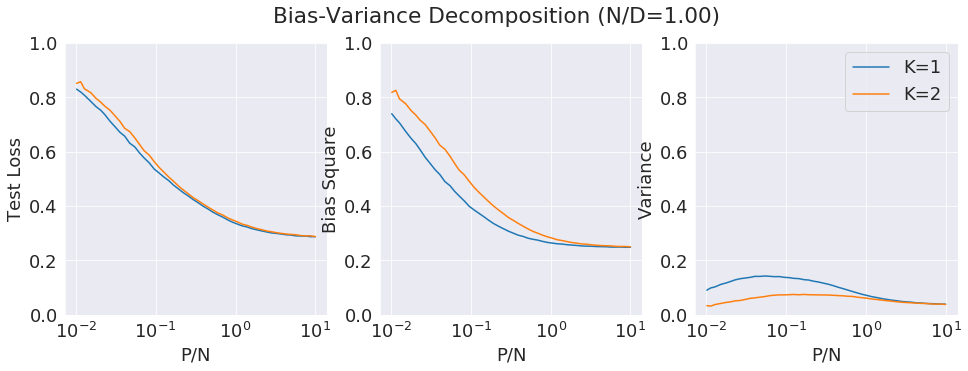

In [29]:
K2_df = pd.read_csv(os.path.join(outdir, 'ensembleNNK=2_output.csv'))
K1_df = pd.read_csv(os.path.join(outdir, 'singleNN_output.csv'))
plot_single_vs_ensemble([K1_df, K2_df], [1, 2], N_Ds[0], 784,)